
# Tutorial 13: Self-Supervised Contrastive Learning with SimCLR

* **Author:** Phillip Lippe
* **License:** CC BY-SA
* **Generated:** 2024-07-26T11:41:55.573099

In this tutorial, we will take a closer look at self-supervised contrastive learning.
Self-supervised learning, or also sometimes called unsupervised learning, describes the scenario where we have given input data, but no accompanying labels to train in a classical supervised way.
However, this data still contains a lot of information from which we can learn: how are the images different from each other?
What patterns are descriptive for certain images?
Can we cluster the images?
To get an insight into these questions, we will implement a popular, simple contrastive learning method, SimCLR, and apply it to the STL10 dataset.
This notebook is part of a lecture series on Deep Learning at the University of Amsterdam.
The full list of tutorials can be found at https://uvadlc-notebooks.rtfd.io.


---
Open in [Open In Colab{height="20px" width="117px"}](https://colab.research.google.com/github/PytorchLightning/lightning-tutorials/blob/publication/.notebooks/course_UvA-DL/13-contrastive-learning.ipynb)

Give us a ⭐ [on Github](https://www.github.com/Lightning-AI/lightning/)
| Check out [the documentation](https://lightning.ai/docs/)
| Join us [on Discord](https://discord.com/invite/tfXFetEZxv)

## Setup
This notebook requires some packages besides pytorch-lightning.

In [1]:
! pip install --quiet "tensorboard" "matplotlib" "torchvision" "numpy <2.0" "torch >=1.8.1,<2.5" "seaborn" "torchmetrics >=1.0,<1.5" "pytorch-lightning >=2.0,<2.4"

<div class="center-wrapper"><div class="video-wrapper"><iframe src="https://www.youtube.com/embed/waVZDFR-06U" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe></div></div>
Methods for self-supervised learning try to learn as much as possible from the data alone, so it can quickly be finetuned for a specific classification task.
The benefit of self-supervised learning is that a large dataset can often easily be obtained.
For instance, if we want to train a vision model on semantic segmentation for autonomous driving, we can collect large amounts of data by simply installing a camera in a car, and driving through a city for an hour.
In contrast, if we would want to do supervised learning, we would have to manually label all those images before training a model.
This is extremely expensive, and would likely take a couple of months to manually label the same amount of data.
Further, self-supervised learning can provide an alternative to transfer learning from models pretrained on ImageNet since we could pretrain a model on a specific dataset/situation, e.g. traffic scenarios for autonomous driving.

Within the last two years, a lot of new approaches have been proposed for self-supervised learning, in particular for images, that have resulted in great improvements over supervised models when few labels are available.
The subfield that we will focus on in this tutorial is contrastive learning.
Contrastive learning is motivated by the question mentioned above: how are images different from each other?
Specifically, contrastive learning methods train a model to cluster an image and its slightly augmented version in latent space, while the distance to other images should be maximized.
A very recent and simple method for this is [SimCLR](https://arxiv.org/abs/2006.10029), which is visualized below (figure credit - [Ting Chen et al. ](https://simclr.github.io/)).

<center width="100%"> 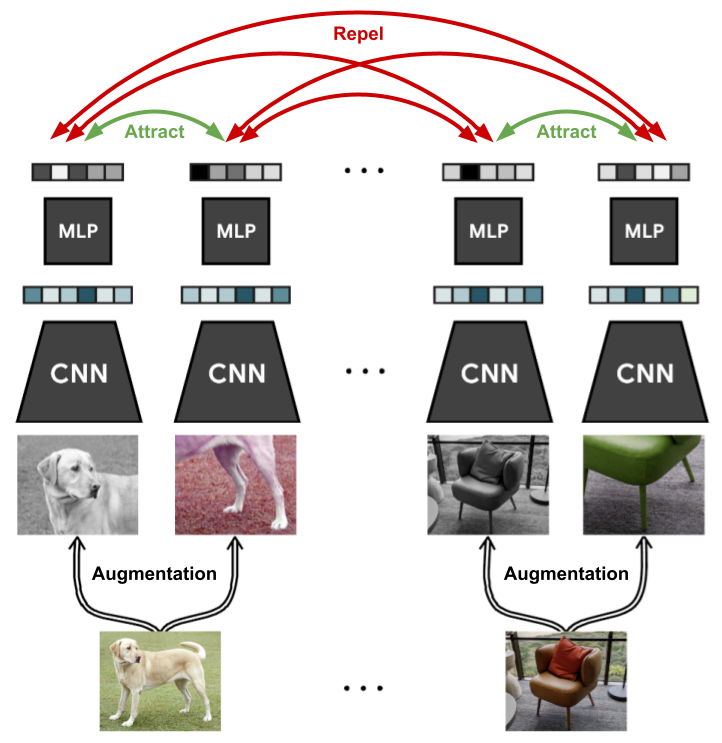{width="500px"} </center>

The general setup is that we are given a dataset of images without any labels, and want to train a model on this data such that it can quickly adapt to any image recognition task afterward.
During each training iteration, we sample a batch of images as usual.
For each image, we create two versions by applying data augmentation techniques like cropping, Gaussian noise, blurring, etc.
An example of such is shown on the left with the image of the dog.
We will go into the details and effects of the chosen augmentation techniques later.
On those images, we apply a CNN like ResNet and obtain as output a 1D feature vector on which we apply a small MLP.
The output features of the two augmented images are then trained to be close to each other, while all other images in that batch should be as different as possible.
This way, the model has to learn to recognize the content of the image that remains unchanged under the data augmentations, such as objects which we usually care about in supervised tasks.

We will now implement this framework ourselves and discuss further details along the way.
Let's first start with importing our standard libraries below:

In [2]:
import os
import urllib.request
from copy import deepcopy
from urllib.error import HTTPError

import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from torchvision import transforms
from torchvision.datasets import STL10
from tqdm.notebook import tqdm

plt.set_cmap("cividis")
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf")  # For export
matplotlib.rcParams["lines.linewidth"] = 2.0
sns.set()

# Import tensorboard
%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = os.environ.get("PATH_DATASETS", "data/")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/ContrastiveLearning/")
# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores
NUM_WORKERS = os.cpu_count()

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

Seed set to 42


Device: cuda:0
Number of workers: 64


<Figure size 640x480 with 0 Axes>

As in many tutorials before, we provide pre-trained models.
Note that those models are slightly larger as normal (~100MB overall) since we use the default ResNet-18 architecture.
If you are running this notebook locally, make sure to have sufficient disk space available.

In [3]:
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial17/"
# Files to download
pretrained_files = [
    "SimCLR.ckpt",
    "ResNet.ckpt",
    "tensorboards/SimCLR/events.out.tfevents.SimCLR",
    "tensorboards/classification/ResNet/events.out.tfevents.ResNet",
]
pretrained_files += [f"LogisticRegression_{size}.ckpt" for size in [10, 20, 50, 100, 200, 500]]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/", 1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print(
                "Something went wrong. Please try to download the file from the GDrive folder,"
                " or contact the author with the full output including the following error:\n",
                e,
            )

## SimCLR

We will start our exploration of contrastive learning by discussing the effect of different data augmentation techniques, and how we can implement an efficient data loader for such.
Next, we implement SimCLR with PyTorch Lightning, and finally train it on a large, unlabeled dataset.

### Data Augmentation for Contrastive Learning

To allow efficient training, we need to prepare the data loading such that we sample two different, random augmentations for each image in the batch.
The easiest way to do this is by creating a transformation that, when being called, applies a set of data augmentations to an image twice.
This is implemented in the class `ContrastiveTransformations` below:

In [4]:
class ContrastiveTransformations:
    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]

The contrastive learning framework can easily be extended to have more _positive_ examples by sampling more than two augmentations of the same image.
However, the most efficient training is usually obtained by using only two.

Next, we can look at the specific augmentations we want to apply.
The choice of the data augmentation to use is the most crucial hyperparameter in SimCLR since it directly affects how the latent space is structured, and what patterns might be learned from the data.
Let's first take a look at some of the most popular data augmentations (figure credit - [Ting Chen and Geoffrey Hinton](https://ai.googleblog.com/2020/04/advancing-self-supervised-and-semi.html)):

<center width="100%"><img src="https://github.com/Lightning-AI/lightning-tutorials/raw/main/course_UvA-DL/13-contrastive-learning/simclr_data_augmentations.jpg" width="800px" style="padding-top: 10px; padding-bottom: 10px"></center>

All of them can be used, but it turns out that two augmentations stand out in their importance: crop-and-resize, and color distortion.
Interestingly, however, they only lead to strong performance if they have been used together as discussed by [Ting Chen et al. ](https://arxiv.org/abs/2006.10029) in their SimCLR paper.
When performing randomly cropping and resizing, we can distinguish between two situations: (a) cropped image A provides a local view of cropped image B, or (b) cropped images C and D show neighboring views of the same image (figure credit - [Ting Chen and Geoffrey Hinton](https://ai.googleblog.com/2020/04/advancing-self-supervised-and-semi.html)).

<center width="100%"><img src="https://github.com/Lightning-AI/lightning-tutorials/raw/main/course_UvA-DL/13-contrastive-learning/crop_views.svg" width="400px" style="padding-top: 20px; padding-bottom: 0px"></center>

While situation (a) requires the model to learn some sort of scale invariance to make crops A and B similar in latent space, situation (b) is more challenging since the model needs to recognize an object beyond its limited view.
However, without color distortion, there is a loophole that the model can exploit, namely that different crops of the same image usually look very similar in color space.
Consider the picture of the dog above.
Simply from the color of the fur and the green color tone of the background, you can reason that two patches belong to the same image without actually recognizing the dog in the picture.
In this case, the model might end up focusing only on the color histograms of the images, and ignore other more generalizable features.
If, however, we distort the colors in the two patches randomly and independently of each other, the model cannot rely on this simple feature anymore.
Hence, by combining random cropping and color distortions, the model can only match two patches by learning generalizable representations.

Overall, for our experiments, we apply a set of 5 transformations following the original SimCLR setup: random horizontal flip, crop-and-resize, color distortion, random grayscale, and gaussian blur.
In comparison to the [original implementation](https://github.com/google-research/simclr), we reduce the effect of the color jitter slightly (0.5 instead of 0.8 for brightness, contrast, and saturation, and 0.1 instead of 0.2 for hue).
In our experiments, this setting obtained better performance and was faster and more stable to train.
If, for instance, the brightness scale highly varies in a dataset, the
original settings can be more beneficial since the model can't rely on
this information anymore to distinguish between images.

In [5]:
contrast_transforms = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(size=96),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.GaussianBlur(kernel_size=9),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

After discussing the data augmentation techniques, we can now focus on the dataset.
In this tutorial, we will use the [STL10 dataset](https://cs.stanford.edu/~acoates/stl10/), which, similarly to CIFAR10, contains images of 10 classes: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck.
However, the images have a higher resolution, namely $96\times 96$ pixels, and we are only provided with 500 labeled images per class.
Additionally, we have a much larger set of $100,000$ unlabeled images which are similar to the training images but are sampled from a wider range of animals and vehicles.
This makes the dataset ideal to showcase the benefits that self-supervised learning offers.

Luckily, the STL10 dataset is provided through torchvision.
Keep in mind, however, that since this dataset is relatively large and has a considerably higher resolution than CIFAR10, it requires more disk space (~3GB) and takes a bit of time to download.
For our initial discussion of self-supervised learning and SimCLR, we
will create two data loaders with our contrastive transformations above:
the `unlabeled_data` will be used to train our model via contrastive
learning, and `train_data_contrast` will be used as a validation set in
contrastive learning.

In [6]:
unlabeled_data = STL10(
    root=DATASET_PATH,
    split="unlabeled",
    download=True,
    transform=ContrastiveTransformations(contrast_transforms, n_views=2),
)
train_data_contrast = STL10(
    root=DATASET_PATH,
    split="train",
    download=True,
    transform=ContrastiveTransformations(contrast_transforms, n_views=2),
)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

  0%|          | 32768/2640397119 [00:00<2:42:17, 271141.58it/s]

  0%|          | 98304/2640397119 [00:00<1:44:23, 421528.19it/s]

  0%|          | 196608/2640397119 [00:00<1:14:54, 587457.31it/s]

  0%|          | 294912/2640397119 [00:00<1:05:53, 667717.25it/s]

  0%|          | 491520/2640397119 [00:00<44:30, 988401.84it/s]  

  0%|          | 720896/2640397119 [00:00<34:25, 1278144.85it/s]

  0%|          | 1048576/2640397119 [00:00<25:34, 1720370.37it/s]

  0%|          | 1507328/2640397119 [00:00<18:47, 2340341.58it/s]

  0%|          | 2195456/2640397119 [00:01<13:13, 3324270.87it/s]

  0%|          | 3211264/2640397119 [00:01<09:09, 4797363.73it/s]

  0%|          | 4587520/2640397119 [00:01<06:16, 7007203.38it/s]

  0%|          | 5603328/2640397119 [00:01<06:17, 6979369.87it/s]

  0%|          | 7995392/2640397119 [00:01<04:06, 10660413.01it/s]

  0%|          | 9502720/2640397119 [00:01<03:47, 11572165.14it/s]

  0%|          | 11042816/2640397119 [00:01<03:42, 11807698.85it/s]

  0%|          | 12582912/2640397119 [00:01<03:26, 12721087.08it/s]

  1%|          | 13893632/2640397119 [00:02<03:35, 12197932.16it/s]

  1%|          | 15138816/2640397119 [00:02<03:42, 11772730.42it/s]

  1%|          | 16711680/2640397119 [00:02<03:26, 12709458.52it/s]

  1%|          | 18186240/2640397119 [00:02<03:17, 13259079.63it/s]

  1%|          | 19529728/2640397119 [00:02<03:26, 12709214.37it/s]

  1%|          | 20938752/2640397119 [00:02<03:26, 12671529.57it/s]

  1%|          | 22642688/2640397119 [00:02<03:13, 13550624.65it/s]

  1%|          | 24117248/2640397119 [00:02<03:08, 13865441.75it/s]

  1%|          | 25526272/2640397119 [00:02<03:16, 13316085.52it/s]

  1%|          | 27066368/2640397119 [00:03<03:15, 13398854.45it/s]

  1%|          | 28868608/2640397119 [00:03<03:10, 13689260.77it/s]

  1%|          | 30638080/2640397119 [00:03<03:00, 14488769.35it/s]

  1%|          | 32145408/2640397119 [00:03<02:58, 14620800.82it/s]

  1%|▏         | 33619968/2640397119 [00:03<03:05, 14036675.62it/s]

  1%|▏         | 35258368/2640397119 [00:03<03:03, 14169274.14it/s]

  1%|▏         | 37126144/2640397119 [00:03<02:53, 15031810.52it/s]

  1%|▏         | 38633472/2640397119 [00:03<02:53, 15036981.89it/s]

  2%|▏         | 40140800/2640397119 [00:03<02:59, 14478384.18it/s]

  2%|▏         | 41910272/2640397119 [00:04<02:57, 14642570.84it/s]

  2%|▏         | 43384832/2640397119 [00:04<03:16, 13240139.84it/s]

  2%|▏         | 45219840/2640397119 [00:04<03:02, 14190220.57it/s]

  2%|▏         | 46661632/2640397119 [00:04<03:18, 13076698.93it/s]

  2%|▏         | 48005120/2640397119 [00:04<03:27, 12485946.25it/s]

  2%|▏         | 49348608/2640397119 [00:04<03:35, 12020438.28it/s]

  2%|▏         | 50593792/2640397119 [00:04<03:58, 10862174.88it/s]

  2%|▏         | 51707904/2640397119 [00:04<04:15, 10120223.00it/s]

  2%|▏         | 52756480/2640397119 [00:05<04:30, 9581954.18it/s] 

  2%|▏         | 53739520/2640397119 [00:05<04:43, 9123482.53it/s]

  2%|▏         | 54689792/2640397119 [00:05<04:55, 8764221.60it/s]

  2%|▏         | 55574528/2640397119 [00:05<05:06, 8430007.96it/s]

  2%|▏         | 56557568/2640397119 [00:05<05:06, 8422356.97it/s]

  2%|▏         | 57606144/2640397119 [00:05<04:50, 8902261.53it/s]

  2%|▏         | 58523648/2640397119 [00:05<04:53, 8786217.72it/s]

  2%|▏         | 59408384/2640397119 [00:05<05:04, 8480105.11it/s]

  2%|▏         | 60358656/2640397119 [00:06<05:05, 8442060.49it/s]

  2%|▏         | 61407232/2640397119 [00:06<04:49, 8912073.33it/s]

  2%|▏         | 62324736/2640397119 [00:06<04:50, 8868749.79it/s]

  2%|▏         | 63242240/2640397119 [00:06<05:00, 8571695.07it/s]

  2%|▏         | 64225280/2640397119 [00:06<04:58, 8623998.06it/s]

  2%|▏         | 65339392/2640397119 [00:06<04:41, 9153032.87it/s]

  3%|▎         | 66289664/2640397119 [00:06<04:42, 9105977.60it/s]

  3%|▎         | 67207168/2640397119 [00:06<04:54, 8744290.84it/s]

  3%|▎         | 68222976/2640397119 [00:06<04:51, 8829346.84it/s]

  3%|▎         | 69337088/2640397119 [00:06<04:34, 9362494.77it/s]

  3%|▎         | 70287360/2640397119 [00:07<04:38, 9226114.22it/s]

  3%|▎         | 71237632/2640397119 [00:07<04:47, 8934386.62it/s]

  3%|▎         | 72253440/2640397119 [00:07<04:46, 8970872.59it/s]

  3%|▎         | 73367552/2640397119 [00:07<04:30, 9491053.08it/s]

  3%|▎         | 74350592/2640397119 [00:07<04:34, 9353108.42it/s]

  3%|▎         | 75300864/2640397119 [00:07<04:42, 9074271.93it/s]

  3%|▎         | 76349440/2640397119 [00:07<04:41, 9103709.30it/s]

  3%|▎         | 77463552/2640397119 [00:07<04:25, 9668231.03it/s]

  3%|▎         | 78446592/2640397119 [00:07<04:32, 9398122.25it/s]

  3%|▎         | 79396864/2640397119 [00:08<04:41, 9095824.53it/s]

  3%|▎         | 80478208/2640397119 [00:08<04:36, 9266050.96it/s]

  3%|▎         | 81592320/2640397119 [00:08<04:21, 9766903.09it/s]

  3%|▎         | 82575360/2640397119 [00:08<04:31, 9431482.24it/s]

  3%|▎         | 83525632/2640397119 [00:08<04:38, 9196851.88it/s]

  3%|▎         | 84606976/2640397119 [00:08<04:34, 9298038.51it/s]

  3%|▎         | 85688320/2640397119 [00:08<04:23, 9690529.15it/s]

  3%|▎         | 86671360/2640397119 [00:08<04:32, 9367949.70it/s]

  3%|▎         | 87621632/2640397119 [00:08<04:34, 9308291.41it/s]

  3%|▎         | 88735744/2640397119 [00:09<04:21, 9770725.80it/s]

  3%|▎         | 89718784/2640397119 [00:09<04:28, 9501206.14it/s]

  3%|▎         | 90701824/2640397119 [00:09<04:33, 9311490.39it/s]

  3%|▎         | 91750400/2640397119 [00:09<04:29, 9451936.32it/s]

  4%|▎         | 92798976/2640397119 [00:09<04:22, 9721447.27it/s]

  4%|▎         | 93782016/2640397119 [00:09<04:30, 9404842.88it/s]

  4%|▎         | 94765056/2640397119 [00:09<04:29, 9450817.41it/s]

  4%|▎         | 95846400/2640397119 [00:09<04:19, 9820359.69it/s]

  4%|▎         | 96862208/2640397119 [00:09<04:27, 9503205.04it/s]

  4%|▎         | 97845248/2640397119 [00:10<04:30, 9385046.13it/s]

  4%|▎         | 98959360/2640397119 [00:10<04:27, 9495990.83it/s]

  4%|▍         | 100040704/2640397119 [00:10<04:17, 9855175.12it/s]

  4%|▍         | 101056512/2640397119 [00:10<04:27, 9497642.04it/s]

  4%|▍         | 102039552/2640397119 [00:10<04:31, 9336892.56it/s]

  4%|▍         | 103153664/2640397119 [00:10<04:26, 9533022.99it/s]

  4%|▍         | 104235008/2640397119 [00:10<04:18, 9827216.00it/s]

  4%|▍         | 105250816/2640397119 [00:10<04:25, 9539665.57it/s]

  4%|▍         | 106233856/2640397119 [00:10<04:32, 9293295.24it/s]

  4%|▍         | 107347968/2640397119 [00:11<04:24, 9567790.56it/s]

  4%|▍         | 108429312/2640397119 [00:11<04:16, 9866864.62it/s]

  4%|▍         | 109445120/2640397119 [00:11<04:25, 9531734.98it/s]

  4%|▍         | 110428160/2640397119 [00:11<04:33, 9252814.30it/s]

  4%|▍         | 111542272/2640397119 [00:11<04:23, 9596136.81it/s]

  4%|▍         | 112623616/2640397119 [00:11<04:16, 9867530.73it/s]

  4%|▍         | 113639424/2640397119 [00:11<04:24, 9544493.43it/s]

  4%|▍         | 114622464/2640397119 [00:11<04:33, 9246567.04it/s]

  4%|▍         | 115736576/2640397119 [00:11<04:22, 9622634.22it/s]

  4%|▍         | 116817920/2640397119 [00:11<04:15, 9887593.99it/s]

  4%|▍         | 117833728/2640397119 [00:12<04:23, 9557176.38it/s]

  4%|▍         | 118816768/2640397119 [00:12<04:32, 9250132.95it/s]

  5%|▍         | 119930880/2640397119 [00:12<04:21, 9629127.20it/s]

  5%|▍         | 121012224/2640397119 [00:12<04:14, 9895730.74it/s]

  5%|▍         | 122028032/2640397119 [00:12<04:23, 9547201.28it/s]

  5%|▍         | 123011072/2640397119 [00:12<04:31, 9256190.60it/s]

  5%|▍         | 124125184/2640397119 [00:12<04:21, 9636592.10it/s]

  5%|▍         | 125173760/2640397119 [00:12<04:15, 9855337.24it/s]

  5%|▍         | 126189568/2640397119 [00:12<04:26, 9451887.88it/s]

  5%|▍         | 127205376/2640397119 [00:13<04:23, 9548326.88it/s]

  5%|▍         | 128319488/2640397119 [00:13<04:11, 9983034.28it/s]

  5%|▍         | 129335296/2640397119 [00:13<04:19, 9673146.12it/s]

  5%|▍         | 130318336/2640397119 [00:13<04:28, 9362952.10it/s]

  5%|▍         | 131465216/2640397119 [00:13<04:17, 9755441.28it/s]

  5%|▌         | 132579328/2640397119 [00:13<04:08, 10071795.93it/s]

  5%|▌         | 133595136/2640397119 [00:13<04:18, 9695492.90it/s] 

  5%|▌         | 134578176/2640397119 [00:13<04:17, 9717191.03it/s]

  5%|▌         | 135692288/2640397119 [00:13<04:07, 10121995.78it/s]

  5%|▌         | 136740864/2640397119 [00:14<04:14, 9820872.29it/s] 

  5%|▌         | 137756672/2640397119 [00:14<04:19, 9647543.64it/s]

  5%|▌         | 138903552/2640397119 [00:14<04:06, 10159451.21it/s]

  5%|▌         | 139952128/2640397119 [00:14<04:08, 10078963.10it/s]

  5%|▌         | 140967936/2640397119 [00:14<04:17, 9708830.48it/s] 

  5%|▌         | 142114816/2640397119 [00:14<04:05, 10176502.86it/s]

  5%|▌         | 143163392/2640397119 [00:14<04:04, 10226951.52it/s]

  5%|▌         | 144211968/2640397119 [00:14<04:13, 9853726.37it/s] 

  6%|▌         | 145391616/2640397119 [00:14<04:04, 10201082.45it/s]

  6%|▌         | 146571264/2640397119 [00:15<03:56, 10530618.78it/s]

  6%|▌         | 147652608/2640397119 [00:15<04:00, 10373135.74it/s]

  6%|▌         | 148701184/2640397119 [00:15<04:04, 10180427.70it/s]

  6%|▌         | 149946368/2640397119 [00:15<03:54, 10600167.73it/s]

  6%|▌         | 151027712/2640397119 [00:15<03:54, 10602600.39it/s]

  6%|▌         | 152109056/2640397119 [00:15<04:01, 10316179.43it/s]

  6%|▌         | 153354240/2640397119 [00:15<03:52, 10714836.88it/s]

  6%|▌         | 154501120/2640397119 [00:15<03:47, 10915256.58it/s]

  6%|▌         | 155615232/2640397119 [00:15<03:53, 10625147.85it/s]

  6%|▌         | 156827648/2640397119 [00:15<03:49, 10806555.00it/s]

  6%|▌         | 158105600/2640397119 [00:16<03:40, 11246180.35it/s]

  6%|▌         | 159252480/2640397119 [00:16<03:44, 11043268.83it/s]

  6%|▌         | 160366592/2640397119 [00:16<03:44, 11024375.26it/s]

  6%|▌         | 161677312/2640397119 [00:16<03:34, 11532532.16it/s]

  6%|▌         | 162856960/2640397119 [00:16<03:38, 11337700.96it/s]

  6%|▌         | 164003840/2640397119 [00:16<03:39, 11260203.33it/s]

  6%|▋         | 165249024/2640397119 [00:16<03:34, 11558746.09it/s]

  6%|▋         | 166428672/2640397119 [00:16<04:05, 10072017.40it/s]

  6%|▋         | 167477248/2640397119 [00:16<04:17, 9613434.18it/s] 

  6%|▋         | 168493056/2640397119 [00:17<04:20, 9487432.90it/s]

  6%|▋         | 169476096/2640397119 [00:17<04:23, 9370541.50it/s]

  6%|▋         | 170426368/2640397119 [00:17<04:32, 9080112.85it/s]

  6%|▋         | 171376640/2640397119 [00:17<04:30, 9129828.18it/s]

  7%|▋         | 172359680/2640397119 [00:17<04:25, 9309005.71it/s]

  7%|▋         | 173309952/2640397119 [00:17<04:30, 9130177.50it/s]

  7%|▋         | 174292992/2640397119 [00:17<04:26, 9256159.02it/s]

  7%|▋         | 175341568/2640397119 [00:17<04:18, 9538106.75it/s]

  7%|▋         | 176324608/2640397119 [00:17<04:21, 9405677.02it/s]

  7%|▋         | 177373184/2640397119 [00:18<04:17, 9564992.26it/s]

  7%|▋         | 178454528/2640397119 [00:18<04:10, 9808838.77it/s]

  7%|▋         | 179437568/2640397119 [00:18<04:13, 9700524.39it/s]

  7%|▋         | 180486144/2640397119 [00:18<04:09, 9852830.00it/s]

  7%|▋         | 181567488/2640397119 [00:18<04:03, 10099216.74it/s]

  7%|▋         | 182583296/2640397119 [00:18<04:07, 9942792.96it/s] 

  7%|▋         | 183730176/2640397119 [00:18<04:01, 10153899.05it/s]

  7%|▋         | 184844288/2640397119 [00:18<03:56, 10369615.23it/s]

  7%|▋         | 185892864/2640397119 [00:18<04:00, 10208703.14it/s]

  7%|▋         | 187006976/2640397119 [00:18<03:55, 10426613.90it/s]

  7%|▋         | 188088320/2640397119 [00:19<03:53, 10522111.68it/s]

  7%|▋         | 189169664/2640397119 [00:19<03:53, 10514821.56it/s]

  7%|▋         | 190283776/2640397119 [00:19<03:49, 10677590.10it/s]

  7%|▋         | 191365120/2640397119 [00:19<03:51, 10593382.73it/s]

  7%|▋         | 192512000/2640397119 [00:19<03:47, 10782982.69it/s]

  7%|▋         | 193691648/2640397119 [00:19<03:41, 11057896.38it/s]

  7%|▋         | 194805760/2640397119 [00:19<03:45, 10859165.53it/s]

  7%|▋         | 195985408/2640397119 [00:19<03:43, 10921784.68it/s]

  7%|▋         | 197197824/2640397119 [00:19<03:39, 11111156.48it/s]

  8%|▊         | 198311936/2640397119 [00:20<03:41, 11002406.65it/s]

  8%|▊         | 199491584/2640397119 [00:20<03:38, 11152975.69it/s]

  8%|▊         | 200638464/2640397119 [00:20<03:37, 11224724.77it/s]

  8%|▊         | 201785344/2640397119 [00:20<03:38, 11177974.05it/s]

  8%|▊         | 202932224/2640397119 [00:20<03:36, 11254071.71it/s]

  8%|▊         | 204079104/2640397119 [00:20<03:36, 11279239.64it/s]

  8%|▊         | 205291520/2640397119 [00:20<03:32, 11471861.49it/s]

  8%|▊         | 206471168/2640397119 [00:20<03:31, 11492899.79it/s]

  8%|▊         | 207650816/2640397119 [00:20<03:35, 11309351.29it/s]

  8%|▊         | 208896000/2640397119 [00:20<03:30, 11572849.76it/s]

  8%|▊         | 210075648/2640397119 [00:21<03:30, 11562523.50it/s]

  8%|▊         | 211255296/2640397119 [00:21<03:33, 11372662.80it/s]

  8%|▊         | 212500480/2640397119 [00:21<03:27, 11675205.02it/s]

  8%|▊         | 213680128/2640397119 [00:21<03:28, 11661354.20it/s]

  8%|▊         | 214859776/2640397119 [00:21<03:31, 11464121.98it/s]

  8%|▊         | 216072192/2640397119 [00:21<03:28, 11639439.65it/s]

  8%|▊         | 217251840/2640397119 [00:21<03:29, 11588927.45it/s]

  8%|▊         | 218431488/2640397119 [00:21<04:06, 9808943.32it/s] 

  8%|▊         | 219971584/2640397119 [00:21<03:36, 11187096.93it/s]

  8%|▊         | 221151232/2640397119 [00:22<03:53, 10343328.14it/s]

  8%|▊         | 222232576/2640397119 [00:22<04:07, 9782665.02it/s] 

  8%|▊         | 223248384/2640397119 [00:22<04:17, 9388224.65it/s]

  8%|▊         | 224231424/2640397119 [00:22<04:26, 9061023.95it/s]

  9%|▊         | 225181696/2640397119 [00:22<04:28, 8990683.92it/s]

  9%|▊         | 226099200/2640397119 [00:22<04:27, 9033685.53it/s]

  9%|▊         | 227016704/2640397119 [00:22<04:31, 8895187.84it/s]

  9%|▊         | 227934208/2640397119 [00:22<04:29, 8936114.68it/s]

  9%|▊         | 228884480/2640397119 [00:22<04:29, 8950113.93it/s]

  9%|▊         | 229801984/2640397119 [00:23<04:28, 8984176.30it/s]

  9%|▊         | 230752256/2640397119 [00:23<04:26, 9038762.20it/s]

  9%|▉         | 231702528/2640397119 [00:23<04:22, 9163744.11it/s]

  9%|▉         | 232652800/2640397119 [00:23<04:21, 9211799.61it/s]

  9%|▉         | 233603072/2640397119 [00:23<04:22, 9177328.04it/s]

  9%|▉         | 234553344/2640397119 [00:23<04:22, 9179534.21it/s]

  9%|▉         | 235536384/2640397119 [00:23<04:18, 9299553.48it/s]

  9%|▉         | 236486656/2640397119 [00:23<04:17, 9349194.38it/s]

  9%|▉         | 237436928/2640397119 [00:23<04:17, 9338175.59it/s]

  9%|▉         | 238419968/2640397119 [00:23<04:15, 9387229.13it/s]

  9%|▉         | 239403008/2640397119 [00:24<04:15, 9385023.28it/s]

  9%|▉         | 240386048/2640397119 [00:24<04:13, 9478864.75it/s]

  9%|▉         | 241369088/2640397119 [00:24<04:10, 9559058.14it/s]

  9%|▉         | 242352128/2640397119 [00:24<04:09, 9607767.78it/s]

  9%|▉         | 243335168/2640397119 [00:24<04:09, 9595319.95it/s]

  9%|▉         | 244350976/2640397119 [00:24<04:07, 9685069.19it/s]

  9%|▉         | 245334016/2640397119 [00:24<04:11, 9527920.99it/s]

  9%|▉         | 246349824/2640397119 [00:24<04:07, 9674433.64it/s]

  9%|▉         | 247365632/2640397119 [00:24<04:04, 9801733.95it/s]

  9%|▉         | 248348672/2640397119 [00:25<04:06, 9722189.49it/s]

  9%|▉         | 249364480/2640397119 [00:25<04:03, 9821869.71it/s]

  9%|▉         | 250347520/2640397119 [00:25<04:03, 9809578.94it/s]

 10%|▉         | 251330560/2640397119 [00:25<04:05, 9741795.42it/s]

 10%|▉         | 252346368/2640397119 [00:25<04:04, 9753153.25it/s]

 10%|▉         | 253329408/2640397119 [00:25<04:09, 9568961.58it/s]

 10%|▉         | 254410752/2640397119 [00:25<04:04, 9760917.67it/s]

 10%|▉         | 255426560/2640397119 [00:25<04:03, 9809762.92it/s]

 10%|▉         | 256409600/2640397119 [00:25<04:06, 9677429.00it/s]

 10%|▉         | 257523712/2640397119 [00:25<04:01, 9879643.39it/s]

 10%|▉         | 258539520/2640397119 [00:26<03:59, 9954785.89it/s]

 10%|▉         | 259555328/2640397119 [00:26<04:02, 9824355.70it/s]

 10%|▉         | 260636672/2640397119 [00:26<03:55, 10109076.00it/s]

 10%|▉         | 261652480/2640397119 [00:26<03:56, 10074045.32it/s]

 10%|▉         | 262668288/2640397119 [00:26<04:02, 9798976.42it/s] 

 10%|▉         | 263782400/2640397119 [00:26<03:57, 10002364.33it/s]

 10%|█         | 264798208/2640397119 [00:26<03:56, 10044433.67it/s]

 10%|█         | 265814016/2640397119 [00:26<04:00, 9860271.25it/s] 

 10%|█         | 266895360/2640397119 [00:26<03:56, 10032044.13it/s]

 10%|█         | 267943936/2640397119 [00:26<03:58, 9967801.73it/s] 

 10%|█         | 268959744/2640397119 [00:27<03:59, 9898547.30it/s]

 10%|█         | 270041088/2640397119 [00:27<03:57, 9983349.24it/s]

 10%|█         | 271089664/2640397119 [00:27<03:57, 9986479.19it/s]

 10%|█         | 272105472/2640397119 [00:27<03:58, 9926691.33it/s]

 10%|█         | 273154048/2640397119 [00:27<03:54, 10076293.66it/s]

 10%|█         | 274169856/2640397119 [00:27<03:54, 10097984.88it/s]

 10%|█         | 275185664/2640397119 [00:27<03:59, 9891554.24it/s] 

 10%|█         | 276201472/2640397119 [00:27<04:37, 8532953.01it/s]

 11%|█         | 277446656/2640397119 [00:27<04:08, 9509993.94it/s]

 11%|█         | 278462464/2640397119 [00:28<04:27, 8842601.55it/s]

 11%|█         | 279379968/2640397119 [00:28<04:41, 8382909.92it/s]

 11%|█         | 280264704/2640397119 [00:28<04:51, 8090369.50it/s]

 11%|█         | 281116672/2640397119 [00:28<04:59, 7869174.09it/s]

 11%|█         | 281935872/2640397119 [00:28<05:00, 7855110.93it/s]

 11%|█         | 282755072/2640397119 [00:28<05:00, 7850202.14it/s]

 11%|█         | 283574272/2640397119 [00:28<05:00, 7835115.57it/s]

 11%|█         | 284426240/2640397119 [00:28<04:56, 7942594.97it/s]

 11%|█         | 285278208/2640397119 [00:28<04:54, 8002775.80it/s]

 11%|█         | 286097408/2640397119 [00:29<04:54, 7995082.48it/s]

 11%|█         | 286982144/2640397119 [00:29<04:46, 8205564.20it/s]

 11%|█         | 287834112/2640397119 [00:29<04:55, 7959322.99it/s]

 11%|█         | 288686080/2640397119 [00:29<04:52, 8040633.69it/s]

 11%|█         | 289505280/2640397119 [00:29<04:53, 8004312.80it/s]

 11%|█         | 290324480/2640397119 [00:29<04:59, 7845728.28it/s]

 11%|█         | 291110912/2640397119 [00:29<05:47, 6751555.63it/s]

 11%|█         | 291831808/2640397119 [00:29<06:20, 6170593.76it/s]

 11%|█         | 292487168/2640397119 [00:30<09:51, 3972260.02it/s]

 11%|█         | 293011456/2640397119 [00:30<10:44, 3643394.01it/s]

 11%|█         | 293470208/2640397119 [00:30<15:05, 2591393.71it/s]

 11%|█         | 293830656/2640397119 [00:31<27:12, 1437302.03it/s]

 11%|█         | 294092800/2640397119 [00:35<2:10:09, 300426.76it/s]

 11%|█         | 294289408/2640397119 [00:40<4:21:07, 149741.02it/s]

 11%|█         | 294420480/2640397119 [00:43<5:58:06, 109182.38it/s]

 11%|█         | 294518784/2640397119 [00:46<7:27:12, 87426.70it/s] 

 11%|█         | 294584320/2640397119 [00:48<8:19:25, 78284.09it/s]

 11%|█         | 294649856/2640397119 [00:49<8:13:01, 79296.87it/s]

 11%|█         | 294715392/2640397119 [00:49<7:44:45, 84116.93it/s]

 11%|█         | 294748160/2640397119 [00:49<7:24:56, 87862.17it/s]

 11%|█         | 294780928/2640397119 [00:49<6:51:47, 94936.53it/s]

 11%|█         | 294813696/2640397119 [00:50<6:29:35, 100342.54it/s]

 11%|█         | 294846464/2640397119 [00:50<5:52:11, 110999.16it/s]

 11%|█         | 294912000/2640397119 [00:50<4:38:51, 140184.86it/s]

 11%|█         | 294944768/2640397119 [00:50<4:19:21, 150725.83it/s]

 11%|█         | 295010304/2640397119 [00:50<3:28:03, 187883.21it/s]

 11%|█         | 295043072/2640397119 [00:50<3:11:15, 204371.46it/s]

 11%|█         | 295108608/2640397119 [00:51<2:34:03, 253715.00it/s]

 11%|█         | 295174144/2640397119 [00:51<2:11:46, 296603.59it/s]

 11%|█         | 295239680/2640397119 [00:51<1:57:49, 331741.03it/s]

 11%|█         | 295305216/2640397119 [00:51<1:48:20, 360773.72it/s]

 11%|█         | 295370752/2640397119 [00:51<1:36:46, 403856.85it/s]

 11%|█         | 295436288/2640397119 [00:51<1:26:06, 453874.65it/s]

 11%|█         | 295534592/2640397119 [00:51<1:15:37, 516757.53it/s]

 11%|█         | 295632896/2640397119 [00:52<1:09:31, 562040.35it/s]

 11%|█         | 295731200/2640397119 [00:52<1:01:53, 631438.62it/s]

 11%|█         | 295829504/2640397119 [00:52<56:05, 696632.33it/s]  

 11%|█         | 295927808/2640397119 [00:52<52:54, 738584.20it/s]

 11%|█         | 296026112/2640397119 [00:52<49:35, 787907.88it/s]

 11%|█         | 296124416/2640397119 [00:52<1:00:51, 641944.49it/s]

 11%|█         | 296222720/2640397119 [00:52<1:07:29, 578870.55it/s]

 11%|█         | 296353792/2640397119 [00:53<55:55, 698517.86it/s]  

 11%|█         | 296452096/2640397119 [00:53<1:12:54, 535796.29it/s]

 11%|█         | 296517632/2640397119 [00:53<1:34:14, 414488.82it/s]

 11%|█         | 296583168/2640397119 [00:54<2:56:01, 221923.96it/s]

 11%|█         | 296648704/2640397119 [00:55<3:38:11, 179033.86it/s]

 11%|█         | 296681472/2640397119 [00:55<4:06:23, 158537.23it/s]

 11%|█         | 296714240/2640397119 [00:55<4:24:57, 147425.09it/s]

 11%|█         | 296747008/2640397119 [00:56<5:12:47, 124879.47it/s]

 11%|█         | 296779776/2640397119 [00:56<5:52:35, 110781.19it/s]

 11%|█         | 296812544/2640397119 [00:56<6:01:45, 107972.93it/s]

 11%|█         | 296845312/2640397119 [00:57<6:06:30, 106571.89it/s]

 11%|█         | 296878080/2640397119 [00:57<6:24:53, 101477.98it/s]

 11%|█         | 296910848/2640397119 [00:57<6:27:52, 100697.44it/s]

 11%|█         | 296943616/2640397119 [00:58<6:11:05, 105249.28it/s]

 11%|█         | 296976384/2640397119 [00:58<6:03:59, 107303.27it/s]

 11%|█         | 297009152/2640397119 [00:58<5:49:04, 111887.89it/s]

 11%|█         | 297041920/2640397119 [00:58<5:21:40, 121414.44it/s]

 11%|█▏        | 297074688/2640397119 [00:59<5:13:19, 124647.30it/s]

 11%|█▏        | 297107456/2640397119 [00:59<4:41:27, 138761.16it/s]

 11%|█▏        | 297140224/2640397119 [00:59<4:33:27, 142819.53it/s]

 11%|█▏        | 297172992/2640397119 [00:59<4:06:39, 158326.14it/s]

 11%|█▏        | 297205760/2640397119 [00:59<3:46:55, 172092.07it/s]

 11%|█▏        | 297238528/2640397119 [00:59<3:33:15, 183116.94it/s]

 11%|█▏        | 297271296/2640397119 [01:00<3:22:41, 192664.88it/s]

 11%|█▏        | 297304064/2640397119 [01:00<3:15:23, 199870.52it/s]

 11%|█▏        | 297336832/2640397119 [01:00<3:10:57, 204498.52it/s]

 11%|█▏        | 297369600/2640397119 [01:00<3:07:28, 208298.18it/s]

 11%|█▏        | 297435136/2640397119 [01:00<2:43:33, 238745.51it/s]

 11%|█▏        | 297500672/2640397119 [01:01<2:32:16, 256419.75it/s]

 11%|█▏        | 297533440/2640397119 [01:01<2:34:19, 253023.86it/s]

 11%|█▏        | 297598976/2640397119 [01:01<2:33:28, 254416.14it/s]

 11%|█▏        | 297631744/2640397119 [01:01<2:41:11, 242239.61it/s]

 11%|█▏        | 297664512/2640397119 [01:01<2:44:51, 236834.96it/s]

 11%|█▏        | 297730048/2640397119 [01:01<2:33:06, 255004.20it/s]

 11%|█▏        | 297762816/2640397119 [01:02<2:34:29, 252718.64it/s]

 11%|█▏        | 297828352/2640397119 [01:02<2:26:22, 266736.06it/s]

 11%|█▏        | 297893888/2640397119 [01:02<2:12:58, 293592.12it/s]

 11%|█▏        | 297926656/2640397119 [01:02<2:18:46, 281339.93it/s]

 11%|█▏        | 297992192/2640397119 [01:02<2:16:01, 286989.42it/s]

 11%|█▏        | 298057728/2640397119 [01:03<2:14:58, 289246.43it/s]

 11%|█▏        | 298123264/2640397119 [01:03<2:03:26, 316233.01it/s]

 11%|█▏        | 298156032/2640397119 [01:03<2:11:06, 297745.79it/s]

 11%|█▏        | 298221568/2640397119 [01:03<2:11:18, 297269.23it/s]

 11%|█▏        | 298287104/2640397119 [01:03<2:00:35, 323694.94it/s]

 11%|█▏        | 298319872/2640397119 [01:03<2:07:47, 305472.40it/s]

 11%|█▏        | 298385408/2640397119 [01:04<1:57:00, 333609.03it/s]

 11%|█▏        | 298450944/2640397119 [01:04<2:00:09, 324849.45it/s]

 11%|█▏        | 298516480/2640397119 [01:04<1:53:01, 345321.94it/s]

 11%|█▏        | 298582016/2640397119 [01:04<1:45:49, 368842.93it/s]

 11%|█▏        | 298647552/2640397119 [01:04<1:51:16, 350748.48it/s]

 11%|█▏        | 298713088/2640397119 [01:04<1:47:15, 363845.36it/s]

 11%|█▏        | 298778624/2640397119 [01:05<1:41:58, 382698.70it/s]

 11%|█▏        | 298844160/2640397119 [01:05<1:38:03, 397997.61it/s]

 11%|█▏        | 298909696/2640397119 [01:05<1:35:03, 410508.77it/s]

 11%|█▏        | 298975232/2640397119 [01:05<1:33:43, 416374.20it/s]

 11%|█▏        | 299040768/2640397119 [01:05<1:32:25, 422236.23it/s]

 11%|█▏        | 299106304/2640397119 [01:05<1:31:31, 426310.12it/s]

 11%|█▏        | 299171840/2640397119 [01:05<1:30:52, 429358.77it/s]

 11%|█▏        | 299237376/2640397119 [01:06<1:29:50, 434334.37it/s]

 11%|█▏        | 299302912/2640397119 [01:06<1:29:29, 436023.28it/s]

 11%|█▏        | 299368448/2640397119 [01:06<1:29:26, 436233.57it/s]

 11%|█▏        | 299433984/2640397119 [01:06<1:27:00, 448448.78it/s]

 11%|█▏        | 299532288/2640397119 [01:06<1:19:11, 492649.48it/s]

 11%|█▏        | 299597824/2640397119 [01:06<1:19:07, 493046.71it/s]

 11%|█▏        | 299696128/2640397119 [01:07<1:13:43, 529152.37it/s]

 11%|█▏        | 299761664/2640397119 [01:07<1:11:06, 548548.45it/s]

 11%|█▏        | 299827200/2640397119 [01:07<1:08:10, 572192.29it/s]

 11%|█▏        | 299925504/2640397119 [01:07<1:04:05, 608623.94it/s]

 11%|█▏        | 300023808/2640397119 [01:07<59:46, 652562.39it/s]  

 11%|█▏        | 300122112/2640397119 [01:07<56:26, 691050.64it/s]

 11%|█▏        | 300220416/2640397119 [01:07<53:55, 723201.20it/s]

 11%|█▏        | 300318720/2640397119 [01:07<50:00, 779960.93it/s]

 11%|█▏        | 300449792/2640397119 [01:08<56:03, 695755.28it/s]

 11%|█▏        | 300613632/2640397119 [01:08<47:13, 825843.30it/s]

 11%|█▏        | 300711936/2640397119 [01:08<48:34, 802859.28it/s]

 11%|█▏        | 300810240/2640397119 [01:08<48:35, 802445.00it/s]

 11%|█▏        | 300908544/2640397119 [01:08<48:50, 798265.81it/s]

 11%|█▏        | 301006848/2640397119 [01:08<49:06, 794006.41it/s]

 11%|█▏        | 301105152/2640397119 [01:08<49:05, 794066.54it/s]

 11%|█▏        | 301203456/2640397119 [01:08<48:33, 802868.09it/s]

 11%|█▏        | 301301760/2640397119 [01:09<46:34, 836899.96it/s]

 11%|█▏        | 301400064/2640397119 [01:09<44:41, 872168.29it/s]

 11%|█▏        | 301498368/2640397119 [01:09<46:00, 847247.15it/s]

 11%|█▏        | 301629440/2640397119 [01:09<43:17, 900311.58it/s]

 11%|█▏        | 301760512/2640397119 [01:09<43:03, 905266.14it/s]

 11%|█▏        | 301858816/2640397119 [01:09<48:19, 806538.48it/s]

 11%|█▏        | 301989888/2640397119 [01:09<45:42, 852558.88it/s]

 11%|█▏        | 302088192/2640397119 [01:10<47:20, 823312.27it/s]

 11%|█▏        | 302186496/2640397119 [01:10<48:20, 806016.26it/s]

 11%|█▏        | 302284800/2640397119 [01:10<51:04, 762968.51it/s]

 11%|█▏        | 302383104/2640397119 [01:10<51:07, 762236.28it/s]

 11%|█▏        | 302481408/2640397119 [01:10<52:11, 746604.36it/s]

 11%|█▏        | 302579712/2640397119 [01:10<52:09, 746963.00it/s]

 11%|█▏        | 302678016/2640397119 [01:10<51:34, 755553.07it/s]

 11%|█▏        | 302776320/2640397119 [01:10<51:21, 758490.99it/s]

 11%|█▏        | 302874624/2640397119 [01:11<50:12, 775861.98it/s]

 11%|█▏        | 302972928/2640397119 [01:11<48:47, 798420.09it/s]

 11%|█▏        | 303071232/2640397119 [01:11<46:23, 839846.37it/s]

 11%|█▏        | 303169536/2640397119 [01:11<47:44, 815787.77it/s]

 11%|█▏        | 303267840/2640397119 [01:11<47:44, 815853.86it/s]

 11%|█▏        | 303366144/2640397119 [01:11<48:53, 796734.21it/s]

 11%|█▏        | 303464448/2640397119 [01:11<51:20, 758603.74it/s]

 11%|█▏        | 303562752/2640397119 [01:11<51:26, 757236.90it/s]

 12%|█▏        | 303661056/2640397119 [01:12<48:32, 802211.81it/s]

 12%|█▏        | 303759360/2640397119 [01:12<50:48, 766597.80it/s]

 12%|█▏        | 303857664/2640397119 [01:12<50:51, 765772.72it/s]

 12%|█▏        | 303955968/2640397119 [01:12<50:19, 773805.21it/s]

 12%|█▏        | 304054272/2640397119 [01:12<49:35, 785116.23it/s]

 12%|█▏        | 304152576/2640397119 [01:12<49:40, 783840.48it/s]

 12%|█▏        | 304250880/2640397119 [01:12<49:35, 785176.82it/s]

 12%|█▏        | 304349184/2640397119 [01:12<48:43, 798951.11it/s]

 12%|█▏        | 304447488/2640397119 [01:13<47:13, 824499.01it/s]

 12%|█▏        | 304545792/2640397119 [01:13<47:17, 823065.99it/s]

 12%|█▏        | 304644096/2640397119 [01:13<47:47, 814610.60it/s]

 12%|█▏        | 304742400/2640397119 [01:13<45:37, 853181.05it/s]

 12%|█▏        | 304840704/2640397119 [01:13<47:27, 820111.09it/s]

 12%|█▏        | 304939008/2640397119 [01:13<46:19, 840163.51it/s]

 12%|█▏        | 305037312/2640397119 [01:13<46:11, 842703.10it/s]

 12%|█▏        | 305135616/2640397119 [01:13<45:26, 856439.20it/s]

 12%|█▏        | 305233920/2640397119 [01:13<44:53, 866993.46it/s]

 12%|█▏        | 305332224/2640397119 [01:14<44:53, 866809.68it/s]

 12%|█▏        | 305430528/2640397119 [01:14<44:29, 874775.66it/s]

 12%|█▏        | 305561600/2640397119 [01:14<44:22, 877058.57it/s]

 12%|█▏        | 305692672/2640397119 [01:14<43:08, 901837.97it/s]

 12%|█▏        | 305790976/2640397119 [01:14<42:33, 914226.15it/s]

 12%|█▏        | 305889280/2640397119 [01:14<42:03, 925179.56it/s]

 12%|█▏        | 305987584/2640397119 [01:14<42:30, 915312.68it/s]

 12%|█▏        | 306085888/2640397119 [01:14<42:45, 909743.98it/s]

 12%|█▏        | 306184192/2640397119 [01:14<42:37, 912702.49it/s]

 12%|█▏        | 306315264/2640397119 [01:15<40:52, 951673.70it/s]

 12%|█▏        | 306413568/2640397119 [01:15<41:03, 947263.47it/s]

 12%|█▏        | 306544640/2640397119 [01:15<40:09, 968423.23it/s]

 12%|█▏        | 306675712/2640397119 [01:15<39:18, 989285.02it/s]

 12%|█▏        | 306806784/2640397119 [01:15<38:22, 1013721.30it/s]

 12%|█▏        | 306937856/2640397119 [01:15<37:41, 1031936.73it/s]

 12%|█▏        | 307068928/2640397119 [01:15<35:49, 1085647.28it/s]

 12%|█▏        | 307200000/2640397119 [01:15<36:23, 1068372.33it/s]

 12%|█▏        | 307363840/2640397119 [01:16<35:12, 1104543.92it/s]

 12%|█▏        | 307527680/2640397119 [01:16<33:29, 1161006.63it/s]

 12%|█▏        | 307658752/2640397119 [01:16<32:54, 1181455.77it/s]

 12%|█▏        | 307822592/2640397119 [01:16<31:23, 1238707.79it/s]

 12%|█▏        | 307953664/2640397119 [01:16<31:13, 1244951.49it/s]

 12%|█▏        | 308117504/2640397119 [01:16<28:58, 1341184.68it/s]

 12%|█▏        | 308281344/2640397119 [01:16<28:52, 1346152.56it/s]

 12%|█▏        | 308445184/2640397119 [01:16<28:30, 1363263.48it/s]

 12%|█▏        | 308609024/2640397119 [01:17<30:35, 1270585.12it/s]

 12%|█▏        | 308740096/2640397119 [01:17<32:38, 1190419.62it/s]

 12%|█▏        | 308871168/2640397119 [01:17<36:00, 1079316.58it/s]

 12%|█▏        | 309002240/2640397119 [01:17<38:18, 1014335.96it/s]

 12%|█▏        | 309133312/2640397119 [01:17<40:01, 970575.09it/s] 

 12%|█▏        | 309264384/2640397119 [01:17<41:10, 943432.03it/s]

 12%|█▏        | 309362688/2640397119 [01:17<41:15, 941498.37it/s]

 12%|█▏        | 309460992/2640397119 [01:17<40:53, 950197.57it/s]

 12%|█▏        | 309559296/2640397119 [01:18<42:11, 920764.64it/s]

 12%|█▏        | 309690368/2640397119 [01:18<41:13, 942272.39it/s]

 12%|█▏        | 309788672/2640397119 [01:18<41:46, 929908.10it/s]

 12%|█▏        | 309919744/2640397119 [01:18<40:58, 947965.36it/s]

 12%|█▏        | 310050816/2640397119 [01:18<40:12, 965843.42it/s]

 12%|█▏        | 310149120/2640397119 [01:18<40:58, 947699.54it/s]

 12%|█▏        | 310280192/2640397119 [01:18<40:08, 967285.29it/s]

 12%|█▏        | 310411264/2640397119 [01:18<39:51, 974291.31it/s]

 12%|█▏        | 310509568/2640397119 [01:19<40:12, 965687.93it/s]

 12%|█▏        | 310607872/2640397119 [01:19<40:11, 965966.56it/s]

 12%|█▏        | 310738944/2640397119 [01:19<40:24, 960989.99it/s]

 12%|█▏        | 310837248/2640397119 [01:19<40:30, 958486.65it/s]

 12%|█▏        | 310935552/2640397119 [01:19<40:26, 959938.77it/s]

 12%|█▏        | 311033856/2640397119 [01:19<40:24, 960599.18it/s]

 12%|█▏        | 311164928/2640397119 [01:19<41:09, 943172.62it/s]

 12%|█▏        | 311296000/2640397119 [01:19<39:59, 970462.98it/s]

 12%|█▏        | 311394304/2640397119 [01:20<40:04, 968622.03it/s]

 12%|█▏        | 311525376/2640397119 [01:20<40:38, 955117.94it/s]

 12%|█▏        | 311656448/2640397119 [01:20<39:34, 980931.96it/s]

 12%|█▏        | 311754752/2640397119 [01:20<39:42, 977436.93it/s]

 12%|█▏        | 311885824/2640397119 [01:20<39:37, 979443.02it/s]

 12%|█▏        | 312016896/2640397119 [01:20<38:28, 1008636.11it/s]

 12%|█▏        | 312147968/2640397119 [01:20<39:02, 994110.45it/s] 

 12%|█▏        | 312279040/2640397119 [01:20<39:00, 994650.42it/s]

 12%|█▏        | 312410112/2640397119 [01:21<38:21, 1011495.16it/s]

 12%|█▏        | 312541184/2640397119 [01:21<37:57, 1022225.64it/s]

 12%|█▏        | 312672256/2640397119 [01:21<37:51, 1024693.28it/s]

 12%|█▏        | 312803328/2640397119 [01:21<36:09, 1072697.10it/s]

 12%|█▏        | 312934400/2640397119 [01:21<35:03, 1106228.41it/s]

 12%|█▏        | 313065472/2640397119 [01:21<34:17, 1131340.12it/s]

 12%|█▏        | 313196544/2640397119 [01:21<34:06, 1137328.26it/s]

 12%|█▏        | 313327616/2640397119 [01:21<34:57, 1109241.79it/s]

 12%|█▏        | 313458688/2640397119 [01:21<35:10, 1102599.05it/s]

 12%|█▏        | 313589760/2640397119 [01:22<34:47, 1114774.55it/s]

 12%|█▏        | 313720832/2640397119 [01:22<36:20, 1067074.88it/s]

 12%|█▏        | 313851904/2640397119 [01:22<35:25, 1094593.01it/s]

 12%|█▏        | 313982976/2640397119 [01:22<35:50, 1082014.72it/s]

 12%|█▏        | 314114048/2640397119 [01:22<35:28, 1092807.00it/s]

 12%|█▏        | 314245120/2640397119 [01:22<34:38, 1119102.74it/s]

 12%|█▏        | 314376192/2640397119 [01:22<34:45, 1115408.36it/s]

 12%|█▏        | 314507264/2640397119 [01:22<34:14, 1132076.68it/s]

 12%|█▏        | 314638336/2640397119 [01:23<33:51, 1145060.02it/s]

 12%|█▏        | 314769408/2640397119 [01:23<32:51, 1179868.82it/s]

 12%|█▏        | 314900480/2640397119 [01:23<32:27, 1193964.34it/s]

 12%|█▏        | 315031552/2640397119 [01:23<31:55, 1214128.51it/s]

 12%|█▏        | 315162624/2640397119 [01:23<31:17, 1238732.84it/s]

 12%|█▏        | 315326464/2640397119 [01:23<30:24, 1274321.82it/s]

 12%|█▏        | 315490304/2640397119 [01:23<29:24, 1317320.29it/s]

 12%|█▏        | 315654144/2640397119 [01:23<29:00, 1335364.87it/s]

 12%|█▏        | 315817984/2640397119 [01:23<28:23, 1364777.41it/s]

 12%|█▏        | 315981824/2640397119 [01:24<27:22, 1415287.15it/s]

 12%|█▏        | 316145664/2640397119 [01:24<26:40, 1452626.72it/s]

 12%|█▏        | 316309504/2640397119 [01:24<26:34, 1457396.08it/s]

 12%|█▏        | 316506112/2640397119 [01:24<25:48, 1500664.00it/s]

 12%|█▏        | 316702720/2640397119 [01:24<24:29, 1581293.70it/s]

 12%|█▏        | 316899328/2640397119 [01:24<23:52, 1622215.42it/s]

 12%|█▏        | 317095936/2640397119 [01:24<23:13, 1666880.98it/s]

 12%|█▏        | 317292544/2640397119 [01:24<22:12, 1743512.74it/s]

 12%|█▏        | 317489152/2640397119 [01:24<22:04, 1754187.79it/s]

 12%|█▏        | 317718528/2640397119 [01:25<21:00, 1842233.31it/s]

 12%|█▏        | 317947904/2640397119 [01:25<20:37, 1877170.28it/s]

 12%|█▏        | 318177280/2640397119 [01:25<19:31, 1982930.22it/s]

 12%|█▏        | 318406656/2640397119 [01:25<19:33, 1978990.97it/s]

 12%|█▏        | 318668800/2640397119 [01:25<18:17, 2115241.48it/s]

 12%|█▏        | 318898176/2640397119 [01:25<17:57, 2154711.44it/s]

 12%|█▏        | 319127552/2640397119 [01:25<18:36, 2078516.26it/s]

 12%|█▏        | 319356928/2640397119 [01:25<18:16, 2116480.29it/s]

 12%|█▏        | 319586304/2640397119 [01:25<19:20, 2000382.87it/s]

 12%|█▏        | 319815680/2640397119 [01:26<20:14, 1910549.21it/s]

 12%|█▏        | 320045056/2640397119 [01:26<19:55, 1940112.96it/s]

 12%|█▏        | 320241664/2640397119 [01:26<20:22, 1897856.80it/s]

 12%|█▏        | 320471040/2640397119 [01:26<19:39, 1966880.96it/s]

 12%|█▏        | 320700416/2640397119 [01:26<19:52, 1945321.64it/s]

 12%|█▏        | 320929792/2640397119 [01:26<19:16, 2006060.64it/s]

 12%|█▏        | 321159168/2640397119 [01:26<19:34, 1975279.40it/s]

 12%|█▏        | 321388544/2640397119 [01:26<18:52, 2047944.64it/s]

 12%|█▏        | 321617920/2640397119 [01:26<19:03, 2028422.37it/s]

 12%|█▏        | 321847296/2640397119 [01:27<18:29, 2090405.82it/s]

 12%|█▏        | 322076672/2640397119 [01:27<18:13, 2120569.65it/s]

 12%|█▏        | 322306048/2640397119 [01:27<17:57, 2150422.67it/s]

 12%|█▏        | 322568192/2640397119 [01:27<17:49, 2167854.27it/s]

 12%|█▏        | 322797568/2640397119 [01:27<17:36, 2194146.14it/s]

 12%|█▏        | 323059712/2640397119 [01:27<17:26, 2215287.97it/s]

 12%|█▏        | 323321856/2640397119 [01:27<17:01, 2269004.38it/s]

 12%|█▏        | 323584000/2640397119 [01:27<16:52, 2287082.12it/s]

 12%|█▏        | 323813376/2640397119 [01:27<16:59, 2272130.36it/s]

 12%|█▏        | 324075520/2640397119 [01:28<16:32, 2334484.64it/s]

 12%|█▏        | 324337664/2640397119 [01:28<16:50, 2291721.32it/s]

 12%|█▏        | 324599808/2640397119 [01:28<16:17, 2368154.00it/s]

 12%|█▏        | 324861952/2640397119 [01:28<16:42, 2309843.27it/s]

 12%|█▏        | 325124096/2640397119 [01:28<16:15, 2372433.99it/s]

 12%|█▏        | 325386240/2640397119 [01:28<16:29, 2340684.82it/s]

 12%|█▏        | 325648384/2640397119 [01:28<16:09, 2388447.09it/s]

 12%|█▏        | 325910528/2640397119 [01:28<16:15, 2372109.48it/s]

 12%|█▏        | 326172672/2640397119 [01:28<15:58, 2414215.57it/s]

 12%|█▏        | 326434816/2640397119 [01:28<15:47, 2440979.40it/s]

 12%|█▏        | 326696960/2640397119 [01:29<16:05, 2396128.63it/s]

 12%|█▏        | 326959104/2640397119 [01:29<15:48, 2439071.50it/s]

 12%|█▏        | 327221248/2640397119 [01:29<16:03, 2401750.14it/s]

 12%|█▏        | 327483392/2640397119 [01:29<15:58, 2412184.20it/s]

 12%|█▏        | 327745536/2640397119 [01:29<16:01, 2404766.64it/s]

 12%|█▏        | 328007680/2640397119 [01:29<15:51, 2431457.43it/s]

 12%|█▏        | 328269824/2640397119 [01:29<15:58, 2412987.23it/s]

 12%|█▏        | 328531968/2640397119 [01:29<16:02, 2401049.54it/s]

 12%|█▏        | 328794112/2640397119 [01:29<16:02, 2401796.34it/s]

 12%|█▏        | 329056256/2640397119 [01:30<16:05, 2393322.14it/s]

 12%|█▏        | 329318400/2640397119 [01:30<16:03, 2399673.69it/s]

 12%|█▏        | 329580544/2640397119 [01:30<16:00, 2404633.47it/s]

 12%|█▏        | 329842688/2640397119 [01:30<15:47, 2438911.43it/s]

 13%|█▎        | 330104832/2640397119 [01:30<15:59, 2407512.80it/s]

 13%|█▎        | 330366976/2640397119 [01:30<15:49, 2432337.89it/s]

 13%|█▎        | 330629120/2640397119 [01:30<15:57, 2413282.00it/s]

 13%|█▎        | 330891264/2640397119 [01:30<15:48, 2435331.85it/s]

 13%|█▎        | 331153408/2640397119 [01:30<16:00, 2404809.98it/s]

 13%|█▎        | 331415552/2640397119 [01:31<15:50, 2428613.43it/s]

 13%|█▎        | 331677696/2640397119 [01:31<15:44, 2445006.71it/s]

 13%|█▎        | 331939840/2640397119 [01:31<15:38, 2460379.32it/s]

 13%|█▎        | 332201984/2640397119 [01:31<15:42, 2448446.35it/s]

 13%|█▎        | 332464128/2640397119 [01:31<16:05, 2390468.60it/s]

 13%|█▎        | 332759040/2640397119 [01:31<15:25, 2494339.27it/s]

 13%|█▎        | 333053952/2640397119 [01:31<14:58, 2566759.90it/s]

 13%|█▎        | 333348864/2640397119 [01:31<14:29, 2653105.89it/s]

 13%|█▎        | 333643776/2640397119 [01:31<14:37, 2628452.48it/s]

 13%|█▎        | 333938688/2640397119 [01:32<15:17, 2512777.40it/s]

 13%|█▎        | 334233600/2640397119 [01:32<15:04, 2548422.67it/s]

 13%|█▎        | 334495744/2640397119 [01:32<15:27, 2485436.07it/s]

 13%|█▎        | 334790656/2640397119 [01:32<15:17, 2512298.64it/s]

 13%|█▎        | 335052800/2640397119 [01:32<15:26, 2487137.06it/s]

 13%|█▎        | 335347712/2640397119 [01:32<15:07, 2540983.65it/s]

 13%|█▎        | 335609856/2640397119 [01:32<15:30, 2476506.17it/s]

 13%|█▎        | 335904768/2640397119 [01:32<15:01, 2555996.27it/s]

 13%|█▎        | 336166912/2640397119 [01:32<15:14, 2519401.83it/s]

 13%|█▎        | 336461824/2640397119 [01:33<14:56, 2569945.84it/s]

 13%|█▎        | 336723968/2640397119 [01:33<14:59, 2561683.25it/s]

 13%|█▎        | 336986112/2640397119 [01:33<15:05, 2544020.43it/s]

 13%|█▎        | 337281024/2640397119 [01:33<14:38, 2622017.23it/s]

 13%|█▎        | 337575936/2640397119 [01:33<14:48, 2590903.80it/s]

 13%|█▎        | 337838080/2640397119 [01:33<14:46, 2596181.90it/s]

 13%|█▎        | 338100224/2640397119 [01:33<15:57, 2404509.35it/s]

 13%|█▎        | 338362368/2640397119 [01:33<16:57, 2262726.50it/s]

 13%|█▎        | 338624512/2640397119 [01:33<17:13, 2227604.05it/s]

 13%|█▎        | 338853888/2640397119 [01:34<17:43, 2165094.76it/s]

 13%|█▎        | 339083264/2640397119 [01:34<17:34, 2182818.31it/s]

 13%|█▎        | 339312640/2640397119 [01:34<17:37, 2175608.13it/s]

 13%|█▎        | 339542016/2640397119 [01:34<17:24, 2203384.55it/s]

 13%|█▎        | 339771392/2640397119 [01:34<17:21, 2209826.95it/s]

 13%|█▎        | 340033536/2640397119 [01:34<17:10, 2232034.76it/s]

 13%|█▎        | 340295680/2640397119 [01:34<16:49, 2278207.41it/s]

 13%|█▎        | 340557824/2640397119 [01:34<16:39, 2302066.37it/s]

 13%|█▎        | 340819968/2640397119 [01:34<16:09, 2371626.19it/s]

 13%|█▎        | 341082112/2640397119 [01:35<16:25, 2334034.80it/s]

 13%|█▎        | 341344256/2640397119 [01:35<15:56, 2402903.77it/s]

 13%|█▎        | 341606400/2640397119 [01:35<15:50, 2418351.70it/s]

 13%|█▎        | 341868544/2640397119 [01:35<15:31, 2468617.02it/s]

 13%|█▎        | 342130688/2640397119 [01:35<15:22, 2490474.13it/s]

 13%|█▎        | 342392832/2640397119 [01:35<15:22, 2491696.46it/s]

 13%|█▎        | 342654976/2640397119 [01:35<15:09, 2525680.74it/s]

 13%|█▎        | 342949888/2640397119 [01:35<14:55, 2564883.84it/s]

 13%|█▎        | 343212032/2640397119 [01:35<15:03, 2542685.78it/s]

 13%|█▎        | 343506944/2640397119 [01:35<14:40, 2607955.06it/s]

 13%|█▎        | 343769088/2640397119 [01:36<14:43, 2599703.59it/s]

 13%|█▎        | 344064000/2640397119 [01:36<14:33, 2630262.59it/s]

 13%|█▎        | 344358912/2640397119 [01:36<14:37, 2616321.77it/s]

 13%|█▎        | 344653824/2640397119 [01:36<14:26, 2650928.12it/s]

 13%|█▎        | 344948736/2640397119 [01:36<14:31, 2633287.28it/s]

 13%|█▎        | 345243648/2640397119 [01:36<14:19, 2670007.64it/s]

 13%|█▎        | 345538560/2640397119 [01:36<14:12, 2691603.08it/s]

 13%|█▎        | 345833472/2640397119 [01:36<14:12, 2691417.53it/s]

 13%|█▎        | 346128384/2640397119 [01:36<14:06, 2708808.13it/s]

 13%|█▎        | 346423296/2640397119 [01:37<14:13, 2688655.26it/s]

 13%|█▎        | 346718208/2640397119 [01:37<14:05, 2713582.83it/s]

 13%|█▎        | 347013120/2640397119 [01:37<14:03, 2720421.19it/s]

 13%|█▎        | 347308032/2640397119 [01:37<14:04, 2715861.05it/s]

 13%|█▎        | 347602944/2640397119 [01:37<14:00, 2727288.12it/s]

 13%|█▎        | 347897856/2640397119 [01:37<14:04, 2713215.95it/s]

 13%|█▎        | 348192768/2640397119 [01:37<13:58, 2733020.97it/s]

 13%|█▎        | 348487680/2640397119 [01:37<14:02, 2721882.01it/s]

 13%|█▎        | 348782592/2640397119 [01:37<14:06, 2708154.50it/s]

 13%|█▎        | 349077504/2640397119 [01:38<13:57, 2735687.97it/s]

 13%|█▎        | 349372416/2640397119 [01:38<13:58, 2731751.59it/s]

 13%|█▎        | 349667328/2640397119 [01:38<14:00, 2724024.78it/s]

 13%|█▎        | 349962240/2640397119 [01:38<13:59, 2727588.11it/s]

 13%|█▎        | 350257152/2640397119 [01:38<13:56, 2736751.18it/s]

 13%|█▎        | 350552064/2640397119 [01:38<13:58, 2729924.80it/s]

 13%|█▎        | 350846976/2640397119 [01:38<13:52, 2748699.01it/s]

 13%|█▎        | 351141888/2640397119 [01:38<14:01, 2720213.66it/s]

 13%|█▎        | 351436800/2640397119 [01:38<13:55, 2741076.39it/s]

 13%|█▎        | 351731712/2640397119 [01:39<13:55, 2737668.50it/s]

 13%|█▎        | 352026624/2640397119 [01:39<14:03, 2714342.44it/s]

 13%|█▎        | 352321536/2640397119 [01:39<14:01, 2720458.64it/s]

 13%|█▎        | 352616448/2640397119 [01:39<14:01, 2718875.65it/s]

 13%|█▎        | 352911360/2640397119 [01:39<14:01, 2717041.53it/s]

 13%|█▎        | 353206272/2640397119 [01:39<13:59, 2723496.02it/s]

 13%|█▎        | 353501184/2640397119 [01:39<14:00, 2721215.92it/s]

 13%|█▎        | 353796096/2640397119 [01:39<14:00, 2721898.63it/s]

 13%|█▎        | 354091008/2640397119 [01:39<13:56, 2733762.69it/s]

 13%|█▎        | 354385920/2640397119 [01:39<13:58, 2727057.91it/s]

 13%|█▎        | 354680832/2640397119 [01:40<13:52, 2745664.93it/s]

 13%|█▎        | 354975744/2640397119 [01:40<13:52, 2745568.74it/s]

 13%|█▎        | 355270656/2640397119 [01:40<13:52, 2743599.63it/s]

 13%|█▎        | 355565568/2640397119 [01:40<13:44, 2771641.01it/s]

 13%|█▎        | 355860480/2640397119 [01:40<13:39, 2788630.36it/s]

 13%|█▎        | 356155392/2640397119 [01:40<13:40, 2784087.17it/s]

 13%|█▎        | 356450304/2640397119 [01:40<13:40, 2784459.53it/s]

 14%|█▎        | 356745216/2640397119 [01:40<13:29, 2820396.17it/s]

 14%|█▎        | 357040128/2640397119 [01:40<13:24, 2837365.78it/s]

 14%|█▎        | 357335040/2640397119 [01:41<13:24, 2837934.75it/s]

 14%|█▎        | 357629952/2640397119 [01:41<13:22, 2845653.61it/s]

 14%|█▎        | 357957632/2640397119 [01:41<13:15, 2867568.82it/s]

 14%|█▎        | 358252544/2640397119 [01:41<13:10, 2888644.79it/s]

 14%|█▎        | 358580224/2640397119 [01:41<13:02, 2915733.03it/s]

 14%|█▎        | 358907904/2640397119 [01:41<12:51, 2958116.89it/s]

 14%|█▎        | 359235584/2640397119 [01:41<12:54, 2944868.44it/s]

 14%|█▎        | 359563264/2640397119 [01:41<12:51, 2957815.79it/s]

 14%|█▎        | 359956480/2640397119 [01:41<11:57, 3178901.99it/s]

 14%|█▎        | 360382464/2640397119 [01:42<11:14, 3378668.75it/s]

 14%|█▎        | 360742912/2640397119 [01:42<11:30, 3301379.75it/s]

 14%|█▎        | 361103360/2640397119 [01:42<11:37, 3265472.86it/s]

 14%|█▎        | 361431040/2640397119 [01:42<11:48, 3217477.86it/s]

 14%|█▎        | 361791488/2640397119 [01:42<11:30, 3298182.67it/s]

 14%|█▎        | 362151936/2640397119 [01:42<11:46, 3224509.62it/s]

 14%|█▎        | 362545152/2640397119 [01:42<11:23, 3332972.11it/s]

 14%|█▎        | 362905600/2640397119 [01:42<11:35, 3272612.21it/s]

 14%|█▍        | 363298816/2640397119 [01:42<11:10, 3396715.03it/s]

 14%|█▍        | 363659264/2640397119 [01:43<11:15, 3368654.55it/s]

 14%|█▍        | 364052480/2640397119 [01:43<10:54, 3476162.18it/s]

 14%|█▍        | 364412928/2640397119 [01:43<12:38, 2999991.90it/s]

 14%|█▍        | 364904448/2640397119 [01:43<11:12, 3382565.47it/s]

 14%|█▍        | 365264896/2640397119 [01:43<12:00, 3157226.30it/s]

 14%|█▍        | 365592576/2640397119 [01:43<12:29, 3033382.77it/s]

 14%|█▍        | 365920256/2640397119 [01:43<12:52, 2945833.77it/s]

 14%|█▍        | 366247936/2640397119 [01:43<12:49, 2954494.99it/s]

 14%|█▍        | 366575616/2640397119 [01:43<13:01, 2910413.93it/s]

 14%|█▍        | 366903296/2640397119 [01:44<12:47, 2961000.32it/s]

 14%|█▍        | 367230976/2640397119 [01:44<12:51, 2947326.42it/s]

 14%|█▍        | 367558656/2640397119 [01:44<12:35, 3009673.13it/s]

 14%|█▍        | 367886336/2640397119 [01:44<12:26, 3045005.50it/s]

 14%|█▍        | 368214016/2640397119 [01:44<12:25, 3049899.11it/s]

 14%|█▍        | 368541696/2640397119 [01:44<12:10, 3109599.15it/s]

 14%|█▍        | 368869376/2640397119 [01:44<12:07, 3122643.51it/s]

 14%|█▍        | 369197056/2640397119 [01:44<12:02, 3143154.56it/s]

 14%|█▍        | 369557504/2640397119 [01:44<11:46, 3216063.85it/s]

 14%|█▍        | 369885184/2640397119 [01:45<11:42, 3232719.40it/s]

 14%|█▍        | 370245632/2640397119 [01:45<11:26, 3304687.86it/s]

 14%|█▍        | 370606080/2640397119 [01:45<11:27, 3299678.41it/s]

 14%|█▍        | 370966528/2640397119 [01:45<11:18, 3346098.59it/s]

 14%|█▍        | 371326976/2640397119 [01:45<11:12, 3372619.29it/s]

 14%|█▍        | 371687424/2640397119 [01:45<11:06, 3403206.53it/s]

 14%|█▍        | 372047872/2640397119 [01:45<10:59, 3441667.34it/s]

 14%|█▍        | 372408320/2640397119 [01:45<11:01, 3430288.53it/s]

 14%|█▍        | 372768768/2640397119 [01:45<10:53, 3471735.34it/s]

 14%|█▍        | 373129216/2640397119 [01:45<10:46, 3507886.42it/s]

 14%|█▍        | 373489664/2640397119 [01:46<10:46, 3504019.77it/s]

 14%|█▍        | 373850112/2640397119 [01:46<10:44, 3519402.92it/s]

 14%|█▍        | 374243328/2640397119 [01:46<10:37, 3553525.67it/s]

 14%|█▍        | 374603776/2640397119 [01:46<10:40, 3539714.01it/s]

 14%|█▍        | 374996992/2640397119 [01:46<10:33, 3576649.15it/s]

 14%|█▍        | 375357440/2640397119 [01:46<10:35, 3562263.48it/s]

 14%|█▍        | 375750656/2640397119 [01:46<10:30, 3590310.34it/s]

 14%|█▍        | 376143872/2640397119 [01:46<10:29, 3595498.73it/s]

 14%|█▍        | 376504320/2640397119 [01:46<10:32, 3581868.91it/s]

 14%|█▍        | 376897536/2640397119 [01:47<10:26, 3615475.87it/s]

 14%|█▍        | 377290752/2640397119 [01:47<10:28, 3598099.79it/s]

 14%|█▍        | 377651200/2640397119 [01:47<10:58, 3434207.71it/s]

 14%|█▍        | 378011648/2640397119 [01:47<11:16, 3344173.64it/s]

 14%|█▍        | 378372096/2640397119 [01:47<12:11, 3090507.00it/s]

 14%|█▍        | 378699776/2640397119 [01:47<12:38, 2982046.72it/s]

 14%|█▍        | 379027456/2640397119 [01:47<12:47, 2948023.11it/s]

 14%|█▍        | 379355136/2640397119 [01:47<13:01, 2891686.55it/s]

 14%|█▍        | 379650048/2640397119 [01:47<13:16, 2836790.29it/s]

 14%|█▍        | 379944960/2640397119 [01:48<14:37, 2576972.16it/s]

 14%|█▍        | 380207104/2640397119 [01:48<15:27, 2435827.47it/s]

 14%|█▍        | 380469248/2640397119 [01:48<16:09, 2331866.97it/s]

 14%|█▍        | 380731392/2640397119 [01:48<16:20, 2303826.72it/s]

 14%|█▍        | 380993536/2640397119 [01:48<16:33, 2273807.60it/s]

 14%|█▍        | 381222912/2640397119 [01:48<16:38, 2262550.84it/s]

 14%|█▍        | 381485056/2640397119 [01:48<16:36, 2266887.54it/s]

 14%|█▍        | 381714432/2640397119 [01:48<18:15, 2061389.28it/s]

 14%|█▍        | 381976576/2640397119 [01:49<17:35, 2139789.32it/s]

 14%|█▍        | 382205952/2640397119 [01:49<18:50, 1998365.64it/s]

 14%|█▍        | 382435328/2640397119 [01:49<19:51, 1895837.81it/s]

 14%|█▍        | 382631936/2640397119 [01:49<20:08, 1868787.60it/s]

 14%|█▍        | 382828544/2640397119 [01:49<20:37, 1824505.87it/s]

 15%|█▍        | 383025152/2640397119 [01:49<20:35, 1826692.79it/s]

 15%|█▍        | 383221760/2640397119 [01:49<20:45, 1811983.23it/s]

 15%|█▍        | 383418368/2640397119 [01:49<20:44, 1813042.96it/s]

 15%|█▍        | 383614976/2640397119 [01:49<20:26, 1840379.07it/s]

 15%|█▍        | 383811584/2640397119 [01:50<20:26, 1839511.51it/s]

 15%|█▍        | 384008192/2640397119 [01:50<20:27, 1837555.86it/s]

 15%|█▍        | 384204800/2640397119 [01:50<20:08, 1866455.52it/s]

 15%|█▍        | 384401408/2640397119 [01:50<19:55, 1886812.60it/s]

 15%|█▍        | 384598016/2640397119 [01:50<19:50, 1895000.23it/s]

 15%|█▍        | 384794624/2640397119 [01:50<19:49, 1896320.14it/s]

 15%|█▍        | 384991232/2640397119 [01:50<20:04, 1871859.75it/s]

 15%|█▍        | 385187840/2640397119 [01:50<19:51, 1893182.86it/s]

 15%|█▍        | 385417216/2640397119 [01:50<19:32, 1923592.79it/s]

 15%|█▍        | 385613824/2640397119 [01:51<19:35, 1918411.51it/s]

 15%|█▍        | 385843200/2640397119 [01:51<19:13, 1954875.99it/s]

 15%|█▍        | 386039808/2640397119 [01:51<19:20, 1942727.52it/s]

 15%|█▍        | 386236416/2640397119 [01:51<19:16, 1948421.84it/s]

 15%|█▍        | 386433024/2640397119 [01:51<19:16, 1949218.75it/s]

 15%|█▍        | 386629632/2640397119 [01:51<19:26, 1932343.18it/s]

 15%|█▍        | 386859008/2640397119 [01:51<19:10, 1958003.57it/s]

 15%|█▍        | 387055616/2640397119 [01:51<19:20, 1941783.77it/s]

 15%|█▍        | 387252224/2640397119 [01:51<19:18, 1944128.21it/s]

 15%|█▍        | 387448832/2640397119 [01:51<19:17, 1946836.76it/s]

 15%|█▍        | 387678208/2640397119 [01:52<18:34, 2021708.23it/s]

 15%|█▍        | 387940352/2640397119 [01:52<17:53, 2098516.14it/s]

 15%|█▍        | 388202496/2640397119 [01:52<17:28, 2148319.98it/s]

 15%|█▍        | 388431872/2640397119 [01:52<18:02, 2080932.20it/s]

 15%|█▍        | 388661248/2640397119 [01:52<18:34, 2021118.04it/s]

 15%|█▍        | 388890624/2640397119 [01:52<18:28, 2030349.72it/s]

 15%|█▍        | 389120000/2640397119 [01:52<18:57, 1978314.08it/s]

 15%|█▍        | 389349376/2640397119 [01:52<18:44, 2001195.15it/s]

 15%|█▍        | 389578752/2640397119 [01:53<19:12, 1952651.66it/s]

 15%|█▍        | 389808128/2640397119 [01:53<19:03, 1968234.10it/s]

 15%|█▍        | 390037504/2640397119 [01:53<18:56, 1979214.37it/s]

 15%|█▍        | 390266880/2640397119 [01:53<19:14, 1949143.57it/s]

 15%|█▍        | 390463488/2640397119 [01:53<19:13, 1950660.73it/s]

 15%|█▍        | 390692864/2640397119 [01:53<19:22, 1934773.76it/s]

 15%|█▍        | 390922240/2640397119 [01:53<19:10, 1954834.31it/s]

 15%|█▍        | 391118848/2640397119 [01:53<19:15, 1946085.48it/s]

 15%|█▍        | 391315456/2640397119 [01:53<19:14, 1948420.08it/s]

 15%|█▍        | 391544832/2640397119 [01:54<18:57, 1976308.79it/s]

 15%|█▍        | 391774208/2640397119 [01:54<18:55, 1980694.32it/s]

 15%|█▍        | 392003584/2640397119 [01:54<18:59, 1973531.69it/s]

 15%|█▍        | 392232960/2640397119 [01:54<19:26, 1926768.07it/s]

 15%|█▍        | 392429568/2640397119 [01:54<21:13, 1765103.34it/s]

 15%|█▍        | 392626176/2640397119 [01:54<22:33, 1661292.03it/s]

 15%|█▍        | 392822784/2640397119 [01:54<23:14, 1611794.46it/s]

 15%|█▍        | 393019392/2640397119 [01:54<22:56, 1632392.55it/s]

 15%|█▍        | 393216000/2640397119 [01:55<23:18, 1607031.91it/s]

 15%|█▍        | 393412608/2640397119 [01:55<23:02, 1625652.63it/s]

 15%|█▍        | 393609216/2640397119 [01:55<22:36, 1656314.24it/s]

 15%|█▍        | 393805824/2640397119 [01:55<22:48, 1641533.99it/s]

 15%|█▍        | 394002432/2640397119 [01:55<21:52, 1711599.74it/s]

 15%|█▍        | 394199040/2640397119 [01:55<21:47, 1718536.02it/s]

 15%|█▍        | 394395648/2640397119 [01:55<21:24, 1748304.29it/s]

 15%|█▍        | 394592256/2640397119 [01:55<20:55, 1788090.67it/s]

 15%|█▍        | 394788864/2640397119 [01:55<20:57, 1785198.64it/s]

 15%|█▍        | 395018240/2640397119 [01:56<20:32, 1821540.96it/s]

 15%|█▍        | 395214848/2640397119 [01:56<20:27, 1829128.54it/s]

 15%|█▍        | 395444224/2640397119 [01:56<20:10, 1853941.70it/s]

 15%|█▍        | 395640832/2640397119 [01:56<20:00, 1869741.21it/s]

 15%|█▍        | 395870208/2640397119 [01:56<19:49, 1887679.88it/s]

 15%|█▌        | 396066816/2640397119 [01:56<19:47, 1890642.57it/s]

 15%|█▌        | 396296192/2640397119 [01:56<19:23, 1928113.17it/s]

 15%|█▌        | 396492800/2640397119 [01:56<19:30, 1917019.15it/s]

 15%|█▌        | 396722176/2640397119 [01:56<19:07, 1955028.42it/s]

 15%|█▌        | 396918784/2640397119 [01:57<19:13, 1944941.29it/s]

 15%|█▌        | 397148160/2640397119 [01:57<18:49, 1985663.18it/s]

 15%|█▌        | 397377536/2640397119 [01:57<18:53, 1978225.22it/s]

 15%|█▌        | 397606912/2640397119 [01:57<18:57, 1970872.95it/s]

 15%|█▌        | 397836288/2640397119 [01:57<18:54, 1975939.56it/s]

 15%|█▌        | 398065664/2640397119 [01:57<18:46, 1991214.35it/s]

 15%|█▌        | 398295040/2640397119 [01:57<18:48, 1986015.76it/s]

 15%|█▌        | 398524416/2640397119 [01:57<18:55, 1973800.69it/s]

 15%|█▌        | 398753792/2640397119 [01:57<18:31, 2016377.07it/s]

 15%|█▌        | 398983168/2640397119 [01:58<18:54, 1976502.84it/s]

 15%|█▌        | 399212544/2640397119 [01:58<18:48, 1986648.50it/s]

 15%|█▌        | 399441920/2640397119 [01:58<18:44, 1992510.68it/s]

 15%|█▌        | 399671296/2640397119 [01:58<18:58, 1968395.63it/s]

 15%|█▌        | 399900672/2640397119 [01:58<18:47, 1987252.88it/s]

 15%|█▌        | 400130048/2640397119 [01:58<18:50, 1981015.43it/s]

 15%|█▌        | 400359424/2640397119 [01:58<18:47, 1986930.48it/s]

 15%|█▌        | 400588800/2640397119 [01:58<18:56, 1969955.81it/s]

 15%|█▌        | 400818176/2640397119 [01:58<18:39, 2000790.00it/s]

 15%|█▌        | 401047552/2640397119 [01:59<18:49, 1981901.44it/s]

 15%|█▌        | 401276928/2640397119 [01:59<18:56, 1970963.42it/s]

 15%|█▌        | 401506304/2640397119 [01:59<18:38, 2001730.75it/s]

 15%|█▌        | 401735680/2640397119 [01:59<18:45, 1989359.18it/s]

 15%|█▌        | 401965056/2640397119 [01:59<18:47, 1985425.64it/s]

 15%|█▌        | 402194432/2640397119 [01:59<18:48, 1984061.48it/s]

 15%|█▌        | 402423808/2640397119 [01:59<18:44, 1990047.27it/s]

 15%|█▌        | 402653184/2640397119 [01:59<18:39, 1999311.63it/s]

 15%|█▌        | 402882560/2640397119 [02:00<18:37, 2002905.34it/s]

 15%|█▌        | 403111936/2640397119 [02:00<18:42, 1993795.78it/s]

 15%|█▌        | 403341312/2640397119 [02:00<18:24, 2026155.32it/s]

 15%|█▌        | 403570688/2640397119 [02:00<18:27, 2019811.27it/s]

 15%|█▌        | 403800064/2640397119 [02:00<18:38, 1999673.90it/s]

 15%|█▌        | 404029440/2640397119 [02:00<18:23, 2027065.38it/s]

 15%|█▌        | 404258816/2640397119 [02:00<18:27, 2019738.02it/s]

 15%|█▌        | 404488192/2640397119 [02:00<18:09, 2051359.33it/s]

 15%|█▌        | 404717568/2640397119 [02:00<18:15, 2040364.37it/s]

 15%|█▌        | 404946944/2640397119 [02:01<18:05, 2059619.62it/s]

 15%|█▌        | 405176320/2640397119 [02:01<17:58, 2072927.32it/s]

 15%|█▌        | 405405696/2640397119 [02:01<17:45, 2096877.52it/s]

 15%|█▌        | 405635072/2640397119 [02:01<17:47, 2094394.78it/s]

 15%|█▌        | 405864448/2640397119 [02:01<17:41, 2105909.08it/s]

 15%|█▌        | 406093824/2640397119 [02:01<17:20, 2147987.33it/s]

 15%|█▌        | 406323200/2640397119 [02:01<17:10, 2166974.99it/s]

 15%|█▌        | 406552576/2640397119 [02:01<17:02, 2183794.82it/s]

 15%|█▌        | 406781952/2640397119 [02:01<17:02, 2184830.11it/s]

 15%|█▌        | 407044096/2640397119 [02:01<16:38, 2236698.98it/s]

 15%|█▌        | 407306240/2640397119 [02:02<16:34, 2246253.38it/s]

 15%|█▌        | 407568384/2640397119 [02:02<16:14, 2290334.72it/s]

 15%|█▌        | 407863296/2640397119 [02:02<15:04, 2467158.55it/s]

 15%|█▌        | 408158208/2640397119 [02:02<14:38, 2540651.76it/s]

 15%|█▌        | 408453120/2640397119 [02:02<14:13, 2613730.45it/s]

 15%|█▌        | 408715264/2640397119 [02:02<14:35, 2550181.85it/s]

 15%|█▌        | 408977408/2640397119 [02:02<14:29, 2565769.01it/s]

 15%|█▌        | 409239552/2640397119 [02:02<15:40, 2372143.49it/s]

 16%|█▌        | 409501696/2640397119 [02:02<15:45, 2358241.87it/s]

 16%|█▌        | 409763840/2640397119 [02:03<16:59, 2187721.56it/s]

 16%|█▌        | 409993216/2640397119 [02:03<17:29, 2125955.88it/s]

 16%|█▌        | 410222592/2640397119 [02:03<17:57, 2070569.82it/s]

 16%|█▌        | 410451968/2640397119 [02:03<18:00, 2063232.19it/s]

 16%|█▌        | 410681344/2640397119 [02:03<18:06, 2051880.00it/s]

 16%|█▌        | 410910720/2640397119 [02:03<17:47, 2087926.04it/s]

 16%|█▌        | 411140096/2640397119 [02:03<17:47, 2088591.17it/s]

 16%|█▌        | 411369472/2640397119 [02:03<17:39, 2104820.97it/s]

 16%|█▌        | 411631616/2640397119 [02:04<17:18, 2145721.77it/s]

 16%|█▌        | 411893760/2640397119 [02:04<16:56, 2191525.93it/s]

 16%|█▌        | 412123136/2640397119 [02:04<16:53, 2198883.64it/s]

 16%|█▌        | 412385280/2640397119 [02:04<16:36, 2235635.84it/s]

 16%|█▌        | 412647424/2640397119 [02:04<16:21, 2269140.98it/s]

 16%|█▌        | 412909568/2640397119 [02:04<15:56, 2329506.21it/s]

 16%|█▌        | 413171712/2640397119 [02:04<15:50, 2344054.72it/s]

 16%|█▌        | 413433856/2640397119 [02:04<15:49, 2345860.32it/s]

 16%|█▌        | 413696000/2640397119 [02:04<15:39, 2369936.49it/s]

 16%|█▌        | 413958144/2640397119 [02:05<15:33, 2383834.68it/s]

 16%|█▌        | 414220288/2640397119 [02:05<15:17, 2427149.82it/s]

 16%|█▌        | 414482432/2640397119 [02:05<15:25, 2404378.70it/s]

 16%|█▌        | 414744576/2640397119 [02:05<15:04, 2460863.68it/s]

 16%|█▌        | 415006720/2640397119 [02:05<15:08, 2449455.57it/s]

 16%|█▌        | 415268864/2640397119 [02:05<15:07, 2451868.60it/s]

 16%|█▌        | 415531008/2640397119 [02:05<14:55, 2483602.27it/s]

 16%|█▌        | 415793152/2640397119 [02:05<14:55, 2485426.27it/s]

 16%|█▌        | 416055296/2640397119 [02:05<14:47, 2507440.12it/s]

 16%|█▌        | 416317440/2640397119 [02:05<14:44, 2513771.72it/s]

 16%|█▌        | 416579584/2640397119 [02:06<14:49, 2499327.02it/s]

 16%|█▌        | 416841728/2640397119 [02:06<14:43, 2515400.23it/s]

 16%|█▌        | 417103872/2640397119 [02:06<14:58, 2474690.24it/s]

 16%|█▌        | 417366016/2640397119 [02:06<16:34, 2234474.41it/s]

 16%|█▌        | 417595392/2640397119 [02:06<17:21, 2133332.33it/s]

 16%|█▌        | 417824768/2640397119 [02:06<17:55, 2067241.08it/s]

 16%|█▌        | 418054144/2640397119 [02:06<17:53, 2069601.18it/s]

 16%|█▌        | 418283520/2640397119 [02:06<18:11, 2035853.03it/s]

 16%|█▌        | 418512896/2640397119 [02:06<17:55, 2066318.24it/s]

 16%|█▌        | 418742272/2640397119 [02:07<18:00, 2055192.95it/s]

 16%|█▌        | 418971648/2640397119 [02:07<17:34, 2107258.25it/s]

 16%|█▌        | 419201024/2640397119 [02:07<17:22, 2130940.01it/s]

 16%|█▌        | 419430400/2640397119 [02:07<17:13, 2148988.45it/s]

 16%|█▌        | 419692544/2640397119 [02:07<16:51, 2196282.83it/s]

 16%|█▌        | 419921920/2640397119 [02:07<16:46, 2206358.52it/s]

 16%|█▌        | 420184064/2640397119 [02:07<16:24, 2256310.33it/s]

 16%|█▌        | 420413440/2640397119 [02:07<16:33, 2235511.49it/s]

 16%|█▌        | 420675584/2640397119 [02:07<15:56, 2321438.39it/s]

 16%|█▌        | 420937728/2640397119 [02:08<16:01, 2309272.68it/s]

 16%|█▌        | 421199872/2640397119 [02:08<15:41, 2357629.26it/s]

 16%|█▌        | 421462016/2640397119 [02:08<15:42, 2354494.31it/s]

 16%|█▌        | 421724160/2640397119 [02:08<15:18, 2415051.07it/s]

 16%|█▌        | 421986304/2640397119 [02:08<15:07, 2443792.86it/s]

 16%|█▌        | 422248448/2640397119 [02:08<15:05, 2449243.26it/s]

 16%|█▌        | 422510592/2640397119 [02:08<15:00, 2462063.58it/s]

 16%|█▌        | 422772736/2640397119 [02:08<15:16, 2419785.66it/s]

 16%|█▌        | 423034880/2640397119 [02:08<14:58, 2467914.21it/s]

 16%|█▌        | 423329792/2640397119 [02:09<14:52, 2483518.07it/s]

 16%|█▌        | 423591936/2640397119 [02:09<14:48, 2496082.07it/s]

 16%|█▌        | 423886848/2640397119 [02:09<14:45, 2501908.81it/s]

 16%|█▌        | 424148992/2640397119 [02:09<14:36, 2528810.24it/s]

 16%|█▌        | 424411136/2640397119 [02:09<14:32, 2538773.27it/s]

 16%|█▌        | 424673280/2640397119 [02:09<14:35, 2529688.67it/s]

 16%|█▌        | 424935424/2640397119 [02:09<14:27, 2554403.45it/s]

 16%|█▌        | 425197568/2640397119 [02:09<14:22, 2567414.97it/s]

 16%|█▌        | 425459712/2640397119 [02:09<14:31, 2540841.10it/s]

 16%|█▌        | 425721856/2640397119 [02:09<14:25, 2559987.77it/s]

 16%|█▌        | 425984000/2640397119 [02:10<14:25, 2558378.82it/s]

 16%|█▌        | 426246144/2640397119 [02:10<14:26, 2555966.41it/s]

 16%|█▌        | 426541056/2640397119 [02:10<14:26, 2556080.22it/s]

 16%|█▌        | 426835968/2640397119 [02:10<14:20, 2572020.86it/s]

 16%|█▌        | 427098112/2640397119 [02:10<14:18, 2579451.81it/s]

 16%|█▌        | 427360256/2640397119 [02:10<14:22, 2567313.76it/s]

 16%|█▌        | 427622400/2640397119 [02:10<14:25, 2556351.72it/s]

 16%|█▌        | 427884544/2640397119 [02:10<14:23, 2561810.78it/s]

 16%|█▌        | 428146688/2640397119 [02:10<14:25, 2555183.83it/s]

 16%|█▌        | 428408832/2640397119 [02:11<14:24, 2560122.83it/s]

 16%|█▌        | 428670976/2640397119 [02:11<14:23, 2562719.19it/s]

 16%|█▌        | 428933120/2640397119 [02:11<14:20, 2570399.16it/s]

 16%|█▋        | 429195264/2640397119 [02:11<14:30, 2541513.86it/s]

 16%|█▋        | 429457408/2640397119 [02:11<14:23, 2559882.70it/s]

 16%|█▋        | 429719552/2640397119 [02:11<14:25, 2553435.53it/s]

 16%|█▋        | 429981696/2640397119 [02:11<15:20, 2402282.74it/s]

 16%|█▋        | 430243840/2640397119 [02:11<15:29, 2378623.62it/s]

 16%|█▋        | 430505984/2640397119 [02:11<16:36, 2218427.75it/s]

 16%|█▋        | 430735360/2640397119 [02:12<17:29, 2106239.99it/s]

 16%|█▋        | 430964736/2640397119 [02:12<17:41, 2081503.30it/s]

 16%|█▋        | 431194112/2640397119 [02:12<17:54, 2055870.09it/s]

 16%|█▋        | 431423488/2640397119 [02:12<17:46, 2071955.45it/s]

 16%|█▋        | 431652864/2640397119 [02:12<17:23, 2116590.08it/s]

 16%|█▋        | 431915008/2640397119 [02:12<19:24, 1896165.82it/s]

 16%|█▋        | 432275456/2640397119 [02:12<16:41, 2204992.46it/s]

 16%|█▋        | 432504832/2640397119 [02:12<18:23, 1999920.07it/s]

 16%|█▋        | 432734208/2640397119 [02:13<19:29, 1888173.72it/s]

 16%|█▋        | 432930816/2640397119 [02:13<20:14, 1817436.33it/s]

 16%|█▋        | 433127424/2640397119 [02:13<20:49, 1766534.71it/s]

 16%|█▋        | 433324032/2640397119 [02:13<21:09, 1738507.47it/s]

 16%|█▋        | 433520640/2640397119 [02:13<21:11, 1735185.53it/s]

 16%|█▋        | 433717248/2640397119 [02:13<20:57, 1755234.65it/s]

 16%|█▋        | 433913856/2640397119 [02:13<21:25, 1716599.75it/s]

 16%|█▋        | 434110464/2640397119 [02:13<20:58, 1753446.29it/s]

 16%|█▋        | 434307072/2640397119 [02:13<21:14, 1730396.85it/s]

 16%|█▋        | 434503680/2640397119 [02:14<20:51, 1762860.18it/s]

 16%|█▋        | 434700288/2640397119 [02:14<21:00, 1750281.50it/s]

 16%|█▋        | 434896896/2640397119 [02:14<20:49, 1764954.24it/s]

 16%|█▋        | 435093504/2640397119 [02:14<20:30, 1791575.86it/s]

 16%|█▋        | 435290112/2640397119 [02:14<20:20, 1806972.91it/s]

 16%|█▋        | 435486720/2640397119 [02:14<20:13, 1817099.24it/s]

 17%|█▋        | 435683328/2640397119 [02:14<20:12, 1818283.69it/s]

 17%|█▋        | 435879936/2640397119 [02:14<20:07, 1825934.18it/s]

 17%|█▋        | 436076544/2640397119 [02:14<20:14, 1815186.98it/s]

 17%|█▋        | 436273152/2640397119 [02:15<21:23, 1717299.55it/s]

 17%|█▋        | 436469760/2640397119 [02:15<22:03, 1665203.28it/s]

 17%|█▋        | 436666368/2640397119 [02:15<23:29, 1563313.64it/s]

 17%|█▋        | 436830208/2640397119 [02:15<24:05, 1524754.45it/s]

 17%|█▋        | 436994048/2640397119 [02:15<24:26, 1502310.08it/s]

 17%|█▋        | 437157888/2640397119 [02:15<24:25, 1502966.22it/s]

 17%|█▋        | 437321728/2640397119 [02:15<24:23, 1505670.23it/s]

 17%|█▋        | 437485568/2640397119 [02:15<24:21, 1507381.79it/s]

 17%|█▋        | 437649408/2640397119 [02:15<23:48, 1541580.96it/s]

 17%|█▋        | 437813248/2640397119 [02:16<23:49, 1540681.02it/s]

 17%|█▋        | 438009856/2640397119 [02:16<23:07, 1587259.94it/s]

 17%|█▋        | 438173696/2640397119 [02:16<22:57, 1599207.99it/s]

 17%|█▋        | 438370304/2640397119 [02:16<22:44, 1613346.12it/s]

 17%|█▋        | 438566912/2640397119 [02:16<22:21, 1641427.37it/s]

 17%|█▋        | 438763520/2640397119 [02:16<21:54, 1675512.39it/s]

 17%|█▋        | 438960128/2640397119 [02:16<21:45, 1685969.34it/s]

 17%|█▋        | 439156736/2640397119 [02:16<21:44, 1687752.61it/s]

 17%|█▋        | 439353344/2640397119 [02:17<21:13, 1727818.73it/s]

 17%|█▋        | 439549952/2640397119 [02:17<21:05, 1739093.26it/s]

 17%|█▋        | 439746560/2640397119 [02:17<20:53, 1755725.82it/s]

 17%|█▋        | 439943168/2640397119 [02:17<20:50, 1759703.97it/s]

 17%|█▋        | 440139776/2640397119 [02:17<20:38, 1776988.84it/s]

 17%|█▋        | 440336384/2640397119 [02:17<20:37, 1778261.59it/s]

 17%|█▋        | 440532992/2640397119 [02:17<20:08, 1820909.65it/s]

 17%|█▋        | 440729600/2640397119 [02:17<20:21, 1800873.34it/s]

 17%|█▋        | 440926208/2640397119 [02:17<20:15, 1809470.24it/s]

 17%|█▋        | 441122816/2640397119 [02:17<20:12, 1813577.26it/s]

 17%|█▋        | 441319424/2640397119 [02:18<20:08, 1820035.62it/s]

 17%|█▋        | 441548800/2640397119 [02:18<19:33, 1874432.53it/s]

 17%|█▋        | 441778176/2640397119 [02:18<19:06, 1917240.88it/s]

 17%|█▋        | 441974784/2640397119 [02:18<19:37, 1867634.81it/s]

 17%|█▋        | 442171392/2640397119 [02:18<19:31, 1875851.95it/s]

 17%|█▋        | 442368000/2640397119 [02:18<19:50, 1846902.16it/s]

 17%|█▋        | 442564608/2640397119 [02:18<19:43, 1856605.16it/s]

 17%|█▋        | 442761216/2640397119 [02:18<19:55, 1837540.26it/s]

 17%|█▋        | 442957824/2640397119 [02:18<19:47, 1849722.70it/s]

 17%|█▋        | 443154432/2640397119 [02:19<20:10, 1815615.35it/s]

 17%|█▋        | 443351040/2640397119 [02:19<22:27, 1630688.42it/s]

 17%|█▋        | 443547648/2640397119 [02:19<23:41, 1545365.31it/s]

 17%|█▋        | 443711488/2640397119 [02:19<24:16, 1507930.82it/s]

 17%|█▋        | 443875328/2640397119 [02:19<24:38, 1485535.11it/s]

 17%|█▋        | 444039168/2640397119 [02:19<24:36, 1487540.89it/s]

 17%|█▋        | 444203008/2640397119 [02:19<24:19, 1504345.81it/s]

 17%|█▋        | 444366848/2640397119 [02:19<24:19, 1504478.96it/s]

 17%|█▋        | 444530688/2640397119 [02:20<23:57, 1527578.04it/s]

 17%|█▋        | 444727296/2640397119 [02:20<23:25, 1561819.35it/s]

 17%|█▋        | 444923904/2640397119 [02:20<22:53, 1598043.98it/s]

 17%|█▋        | 445120512/2640397119 [02:20<22:35, 1619151.02it/s]

 17%|█▋        | 445317120/2640397119 [02:20<22:41, 1612375.30it/s]

 17%|█▋        | 445513728/2640397119 [02:20<22:00, 1662273.39it/s]

 17%|█▋        | 445710336/2640397119 [02:20<21:52, 1671937.04it/s]

 17%|█▋        | 445906944/2640397119 [02:20<21:33, 1696589.27it/s]

 17%|█▋        | 446103552/2640397119 [02:20<21:18, 1716624.63it/s]

 17%|█▋        | 446300160/2640397119 [02:21<20:54, 1749574.00it/s]

 17%|█▋        | 446496768/2640397119 [02:21<20:50, 1754748.74it/s]

 17%|█▋        | 446693376/2640397119 [02:21<20:37, 1773314.84it/s]

 17%|█▋        | 446889984/2640397119 [02:21<20:45, 1760601.84it/s]

 17%|█▋        | 447086592/2640397119 [02:21<23:38, 1546234.79it/s]

 17%|█▋        | 447315968/2640397119 [02:21<21:28, 1702550.84it/s]

 17%|█▋        | 447512576/2640397119 [02:21<23:18, 1568296.63it/s]

 17%|█▋        | 447676416/2640397119 [02:21<24:31, 1490371.96it/s]

 17%|█▋        | 447840256/2640397119 [02:22<24:46, 1475444.38it/s]

 17%|█▋        | 448004096/2640397119 [02:22<25:24, 1437815.53it/s]

 17%|█▋        | 448167936/2640397119 [02:22<25:18, 1443555.53it/s]

 17%|█▋        | 448331776/2640397119 [02:22<25:38, 1424621.17it/s]

 17%|█▋        | 448495616/2640397119 [02:22<25:16, 1444917.20it/s]

 17%|█▋        | 448659456/2640397119 [02:22<25:15, 1446416.18it/s]

 17%|█▋        | 448823296/2640397119 [02:22<24:24, 1496779.30it/s]

 17%|█▋        | 449019904/2640397119 [02:22<22:41, 1609852.07it/s]

 17%|█▋        | 449183744/2640397119 [02:22<22:38, 1612564.55it/s]

 17%|█▋        | 449347584/2640397119 [02:23<23:09, 1576488.92it/s]

 17%|█▋        | 449511424/2640397119 [02:23<23:51, 1530747.43it/s]

 17%|█▋        | 449708032/2640397119 [02:23<23:59, 1521619.33it/s]

 17%|█▋        | 449871872/2640397119 [02:23<23:44, 1538105.74it/s]

 17%|█▋        | 450035712/2640397119 [02:23<24:00, 1520259.25it/s]

 17%|█▋        | 450199552/2640397119 [02:23<23:48, 1533680.57it/s]

 17%|█▋        | 450363392/2640397119 [02:23<23:57, 1523771.13it/s]

 17%|█▋        | 450527232/2640397119 [02:23<24:08, 1512330.25it/s]

 17%|█▋        | 450691072/2640397119 [02:23<23:41, 1540764.47it/s]

 17%|█▋        | 450854912/2640397119 [02:24<24:29, 1490405.59it/s]

 17%|█▋        | 451051520/2640397119 [02:24<23:55, 1525543.54it/s]

 17%|█▋        | 451215360/2640397119 [02:24<23:40, 1541357.40it/s]

 17%|█▋        | 451379200/2640397119 [02:24<28:34, 1276788.45it/s]

 17%|█▋        | 451608576/2640397119 [02:24<24:49, 1469216.63it/s]

 17%|█▋        | 451772416/2640397119 [02:24<26:58, 1352398.95it/s]

 17%|█▋        | 451936256/2640397119 [02:24<28:25, 1283201.03it/s]

 17%|█▋        | 452100096/2640397119 [02:24<28:09, 1295374.66it/s]

 17%|█▋        | 452263936/2640397119 [02:25<30:30, 1195273.26it/s]

 17%|█▋        | 452395008/2640397119 [02:25<33:09, 1099898.00it/s]

 17%|█▋        | 452526080/2640397119 [02:25<34:30, 1056526.63it/s]

 17%|█▋        | 452657152/2640397119 [02:25<35:05, 1039263.96it/s]

 17%|█▋        | 452788224/2640397119 [02:25<35:38, 1023121.00it/s]

 17%|█▋        | 452919296/2640397119 [02:25<36:10, 1007698.37it/s]

 17%|█▋        | 453050368/2640397119 [02:25<36:28, 999406.12it/s] 

 17%|█▋        | 453181440/2640397119 [02:26<36:03, 1010846.10it/s]

 17%|█▋        | 453312512/2640397119 [02:26<35:41, 1021069.91it/s]

 17%|█▋        | 453443584/2640397119 [02:26<35:47, 1018338.04it/s]

 17%|█▋        | 453574656/2640397119 [02:26<35:09, 1036447.30it/s]

 17%|█▋        | 453705728/2640397119 [02:26<34:51, 1045349.64it/s]

 17%|█▋        | 453836800/2640397119 [02:26<35:23, 1029780.64it/s]

 17%|█▋        | 453967872/2640397119 [02:26<35:02, 1040007.93it/s]

 17%|█▋        | 454098944/2640397119 [02:26<34:42, 1049922.65it/s]

 17%|█▋        | 454230016/2640397119 [02:27<34:48, 1046726.16it/s]

 17%|█▋        | 454361088/2640397119 [02:27<34:36, 1052872.19it/s]

 17%|█▋        | 454492160/2640397119 [02:27<34:38, 1051482.23it/s]

 17%|█▋        | 454623232/2640397119 [02:27<34:32, 1054592.19it/s]

 17%|█▋        | 454754304/2640397119 [02:27<34:51, 1045074.21it/s]

 17%|█▋        | 454885376/2640397119 [02:27<34:15, 1063460.21it/s]

 17%|█▋        | 455016448/2640397119 [02:27<34:32, 1054489.32it/s]

 17%|█▋        | 455147520/2640397119 [02:27<34:41, 1049979.50it/s]

 17%|█▋        | 455278592/2640397119 [02:28<34:16, 1062761.88it/s]

 17%|█▋        | 455409664/2640397119 [02:28<34:35, 1052906.12it/s]

 17%|█▋        | 455540736/2640397119 [02:28<34:37, 1051693.91it/s]

 17%|█▋        | 455671808/2640397119 [02:28<34:15, 1063050.85it/s]

 17%|█▋        | 455802880/2640397119 [02:28<34:31, 1054553.27it/s]

 17%|█▋        | 455933952/2640397119 [02:28<34:34, 1052771.72it/s]

 17%|█▋        | 456065024/2640397119 [02:28<33:52, 1074863.60it/s]

 17%|█▋        | 456196096/2640397119 [02:28<34:11, 1064811.09it/s]

 17%|█▋        | 456327168/2640397119 [02:29<34:10, 1065063.72it/s]

 17%|█▋        | 456458240/2640397119 [02:29<33:34, 1084009.73it/s]

 17%|█▋        | 456589312/2640397119 [02:29<34:00, 1069996.49it/s]

 17%|█▋        | 456720384/2640397119 [02:29<32:49, 1108615.25it/s]

 17%|█▋        | 456851456/2640397119 [02:29<33:14, 1094911.26it/s]

 17%|█▋        | 456982528/2640397119 [02:29<32:00, 1136635.34it/s]

 17%|█▋        | 457113600/2640397119 [02:29<32:36, 1115678.20it/s]

 17%|█▋        | 457244672/2640397119 [02:29<32:34, 1116940.87it/s]

 17%|█▋        | 457375744/2640397119 [02:30<32:24, 1122415.77it/s]

 17%|█▋        | 457506816/2640397119 [02:30<32:00, 1136485.92it/s]

 17%|█▋        | 457637888/2640397119 [02:30<31:46, 1145201.16it/s]

 17%|█▋        | 457768960/2640397119 [02:30<31:37, 1150045.02it/s]

 17%|█▋        | 457900032/2640397119 [02:30<31:12, 1165377.91it/s]

 17%|█▋        | 458031104/2640397119 [02:30<31:09, 1167630.33it/s]

 17%|█▋        | 458162176/2640397119 [02:30<30:37, 1187924.95it/s]

 17%|█▋        | 458293248/2640397119 [02:30<30:04, 1208940.16it/s]

 17%|█▋        | 458424320/2640397119 [02:30<30:16, 1201512.15it/s]

 17%|█▋        | 458555392/2640397119 [02:30<29:36, 1228241.43it/s]

 17%|█▋        | 458686464/2640397119 [02:31<29:14, 1243291.80it/s]

 17%|█▋        | 458850304/2640397119 [02:31<28:27, 1277561.28it/s]

 17%|█▋        | 458981376/2640397119 [02:31<28:19, 1283712.09it/s]

 17%|█▋        | 459145216/2640397119 [02:31<27:28, 1322820.95it/s]

 17%|█▋        | 459309056/2640397119 [02:31<27:11, 1336958.90it/s]

 17%|█▋        | 459472896/2640397119 [02:31<26:07, 1391082.22it/s]

 17%|█▋        | 459636736/2640397119 [02:31<25:53, 1403917.15it/s]

 17%|█▋        | 459800576/2640397119 [02:31<25:06, 1447483.17it/s]

 17%|█▋        | 459964416/2640397119 [02:31<24:50, 1462553.74it/s]

 17%|█▋        | 460128256/2640397119 [02:32<24:11, 1501882.71it/s]

 17%|█▋        | 460324864/2640397119 [02:32<23:34, 1541752.56it/s]

 17%|█▋        | 460521472/2640397119 [02:32<22:41, 1601030.56it/s]

 17%|█▋        | 460718080/2640397119 [02:32<22:24, 1620658.54it/s]

 17%|█▋        | 460914688/2640397119 [02:32<21:40, 1676487.40it/s]

 17%|█▋        | 461111296/2640397119 [02:32<20:58, 1732288.47it/s]

 17%|█▋        | 461307904/2640397119 [02:32<20:29, 1771785.29it/s]

 17%|█▋        | 461537280/2640397119 [02:32<19:44, 1839536.38it/s]

 17%|█▋        | 461799424/2640397119 [02:32<18:00, 2016537.40it/s]

 17%|█▋        | 462061568/2640397119 [02:33<16:54, 2147062.50it/s]

 18%|█▊        | 462290944/2640397119 [02:33<17:20, 2093385.88it/s]

 18%|█▊        | 462520320/2640397119 [02:33<19:51, 1828304.00it/s]

 18%|█▊        | 462716928/2640397119 [02:33<23:36, 1537258.94it/s]

 18%|█▊        | 462913536/2640397119 [02:33<25:38, 1415314.50it/s]

 18%|█▊        | 463077376/2640397119 [02:33<26:39, 1361535.95it/s]

 18%|█▊        | 463241216/2640397119 [02:34<27:44, 1308000.12it/s]

 18%|█▊        | 463405056/2640397119 [02:34<28:25, 1276570.55it/s]

 18%|█▊        | 463536128/2640397119 [02:34<28:36, 1268439.02it/s]

 18%|█▊        | 463699968/2640397119 [02:34<28:34, 1269720.48it/s]

 18%|█▊        | 463863808/2640397119 [02:34<28:16, 1282810.76it/s]

 18%|█▊        | 463994880/2640397119 [02:34<28:26, 1275387.89it/s]

 18%|█▊        | 464125952/2640397119 [02:34<28:21, 1279093.63it/s]

 18%|█▊        | 464257024/2640397119 [02:34<28:21, 1278777.16it/s]

 18%|█▊        | 464388096/2640397119 [02:34<28:32, 1270604.23it/s]

 18%|█▊        | 464551936/2640397119 [02:35<28:21, 1278806.13it/s]

 18%|█▊        | 464715776/2640397119 [02:35<27:57, 1296615.29it/s]

 18%|█▊        | 464846848/2640397119 [02:35<28:00, 1294564.74it/s]

 18%|█▊        | 464977920/2640397119 [02:35<28:00, 1294451.51it/s]

 18%|█▊        | 465108992/2640397119 [02:35<28:08, 1287991.13it/s]

 18%|█▊        | 465240064/2640397119 [02:35<28:32, 1270213.92it/s]

 18%|█▊        | 465403904/2640397119 [02:35<27:49, 1302400.29it/s]

 18%|█▊        | 465534976/2640397119 [02:35<28:14, 1283723.83it/s]

 18%|█▊        | 465698816/2640397119 [02:35<28:02, 1292651.20it/s]

 18%|█▊        | 465862656/2640397119 [02:36<27:49, 1302849.00it/s]

 18%|█▊        | 465993728/2640397119 [02:36<27:51, 1300711.83it/s]

 18%|█▊        | 466124800/2640397119 [02:36<28:00, 1293982.64it/s]

 18%|█▊        | 466255872/2640397119 [02:36<27:59, 1294759.16it/s]

 18%|█▊        | 466386944/2640397119 [02:36<28:18, 1279873.12it/s]

 18%|█▊        | 466550784/2640397119 [02:36<27:54, 1298268.27it/s]

 18%|█▊        | 466681856/2640397119 [02:36<28:10, 1285631.99it/s]

 18%|█▊        | 466845696/2640397119 [02:36<28:05, 1289890.83it/s]

 18%|█▊        | 467009536/2640397119 [02:36<27:54, 1297554.60it/s]

 18%|█▊        | 467140608/2640397119 [02:37<27:54, 1298058.04it/s]

 18%|█▊        | 467271680/2640397119 [02:37<28:00, 1293291.79it/s]

 18%|█▊        | 467402752/2640397119 [02:37<27:54, 1297773.90it/s]

 18%|█▊        | 467533824/2640397119 [02:37<28:18, 1279504.89it/s]

 18%|█▊        | 467697664/2640397119 [02:37<27:29, 1317442.51it/s]

 18%|█▊        | 467861504/2640397119 [02:37<27:40, 1308178.77it/s]

 18%|█▊        | 468025344/2640397119 [02:37<27:42, 1306874.37it/s]

 18%|█▊        | 468189184/2640397119 [02:37<27:13, 1329668.60it/s]

 18%|█▊        | 468353024/2640397119 [02:37<27:06, 1335777.13it/s]

 18%|█▊        | 468516864/2640397119 [02:38<26:41, 1356267.39it/s]

 18%|█▊        | 468680704/2640397119 [02:38<26:27, 1368327.43it/s]

 18%|█▊        | 468844544/2640397119 [02:38<26:44, 1353158.26it/s]

 18%|█▊        | 469008384/2640397119 [02:38<26:29, 1365723.92it/s]

 18%|█▊        | 469172224/2640397119 [02:38<26:32, 1363829.66it/s]

 18%|█▊        | 469336064/2640397119 [02:38<25:56, 1395195.86it/s]

 18%|█▊        | 469499904/2640397119 [02:38<26:00, 1390876.77it/s]

 18%|█▊        | 469663744/2640397119 [02:38<26:21, 1372572.44it/s]

 18%|█▊        | 469827584/2640397119 [02:39<25:29, 1418859.56it/s]

 18%|█▊        | 469991424/2640397119 [02:39<25:37, 1411992.72it/s]

 18%|█▊        | 470155264/2640397119 [02:39<25:10, 1437066.36it/s]

 18%|█▊        | 470319104/2640397119 [02:39<24:59, 1446931.84it/s]

 18%|█▊        | 470515712/2640397119 [02:39<24:00, 1506249.39it/s]

 18%|█▊        | 470679552/2640397119 [02:39<24:07, 1499170.63it/s]

 18%|█▊        | 470843392/2640397119 [02:39<23:57, 1508855.39it/s]

 18%|█▊        | 471007232/2640397119 [02:39<23:30, 1537725.37it/s]

 18%|█▊        | 471203840/2640397119 [02:39<23:01, 1569678.04it/s]

 18%|█▊        | 471400448/2640397119 [02:40<21:53, 1651518.85it/s]

 18%|█▊        | 471597056/2640397119 [02:40<21:30, 1679950.88it/s]

 18%|█▊        | 471793664/2640397119 [02:40<21:08, 1709393.09it/s]

 18%|█▊        | 471990272/2640397119 [02:40<21:06, 1712028.56it/s]

 18%|█▊        | 472186880/2640397119 [02:40<20:40, 1747767.67it/s]

 18%|█▊        | 472383488/2640397119 [02:40<20:28, 1764697.25it/s]

 18%|█▊        | 472612864/2640397119 [02:40<19:47, 1825509.56it/s]

 18%|█▊        | 472809472/2640397119 [02:40<19:34, 1845136.64it/s]

 18%|█▊        | 473038848/2640397119 [02:40<18:48, 1920936.36it/s]

 18%|█▊        | 473268224/2640397119 [02:41<18:47, 1921395.99it/s]

 18%|█▊        | 473497600/2640397119 [02:41<18:02, 2001587.27it/s]

 18%|█▊        | 473726976/2640397119 [02:41<17:33, 2055948.75it/s]

 18%|█▊        | 473956352/2640397119 [02:41<17:12, 2098265.84it/s]

 18%|█▊        | 474218496/2640397119 [02:41<16:31, 2183894.24it/s]

 18%|█▊        | 474480640/2640397119 [02:41<16:12, 2227417.89it/s]

 18%|█▊        | 474742784/2640397119 [02:41<15:44, 2293969.22it/s]

 18%|█▊        | 475004928/2640397119 [02:41<15:26, 2338098.96it/s]

 18%|█▊        | 475267072/2640397119 [02:41<15:07, 2385710.76it/s]

 18%|█▊        | 475529216/2640397119 [02:41<14:48, 2435704.34it/s]

 18%|█▊        | 475824128/2640397119 [02:42<14:12, 2540173.22it/s]

 18%|█▊        | 476119040/2640397119 [02:42<13:40, 2636196.74it/s]

 18%|█▊        | 476413952/2640397119 [02:42<13:20, 2702036.35it/s]

 18%|█▊        | 476708864/2640397119 [02:42<13:00, 2771048.43it/s]

 18%|█▊        | 477036544/2640397119 [02:42<12:36, 2858212.03it/s]

 18%|█▊        | 477364224/2640397119 [02:42<12:13, 2949777.90it/s]

 18%|█▊        | 477724672/2640397119 [02:42<11:55, 3021118.86it/s]

 18%|█▊        | 478085120/2640397119 [02:42<11:28, 3140197.49it/s]

 18%|█▊        | 478445568/2640397119 [02:42<11:05, 3248312.35it/s]

 18%|█▊        | 478806016/2640397119 [02:43<10:51, 3320392.02it/s]

 18%|█▊        | 479199232/2640397119 [02:43<10:29, 3431440.12it/s]

 18%|█▊        | 479592448/2640397119 [02:43<11:29, 3134973.74it/s]

 18%|█▊        | 480182272/2640397119 [02:43<09:25, 3820035.92it/s]

 18%|█▊        | 480575488/2640397119 [02:43<10:23, 3464373.99it/s]

 18%|█▊        | 480935936/2640397119 [02:43<10:53, 3305671.39it/s]

 18%|█▊        | 481296384/2640397119 [02:43<11:28, 3136020.62it/s]

 18%|█▊        | 481624064/2640397119 [02:43<11:27, 3138581.35it/s]

 18%|█▊        | 481951744/2640397119 [02:43<11:43, 3067373.22it/s]

 18%|█▊        | 482312192/2640397119 [02:44<11:29, 3131184.10it/s]

 18%|█▊        | 482639872/2640397119 [02:44<11:30, 3123829.20it/s]

 18%|█▊        | 482967552/2640397119 [02:44<11:26, 3143783.32it/s]

 18%|█▊        | 483328000/2640397119 [02:44<11:09, 3222720.98it/s]

 18%|█▊        | 483655680/2640397119 [02:44<11:10, 3218574.57it/s]

 18%|█▊        | 483983360/2640397119 [02:44<11:11, 3212871.28it/s]

 18%|█▊        | 484343808/2640397119 [02:44<10:56, 3282247.93it/s]

 18%|█▊        | 484704256/2640397119 [02:44<10:57, 3277925.43it/s]

 18%|█▊        | 485064704/2640397119 [02:44<10:41, 3359322.49it/s]

 18%|█▊        | 485425152/2640397119 [02:45<10:37, 3377825.84it/s]

 18%|█▊        | 485785600/2640397119 [02:45<10:36, 3384177.15it/s]

 18%|█▊        | 486146048/2640397119 [02:45<10:25, 3446506.50it/s]

 18%|█▊        | 486506496/2640397119 [02:45<10:20, 3469384.92it/s]

 18%|█▊        | 486899712/2640397119 [02:45<10:09, 3535412.57it/s]

 18%|█▊        | 487260160/2640397119 [02:45<10:09, 3532356.46it/s]

 18%|█▊        | 487653376/2640397119 [02:45<10:00, 3584998.22it/s]

 18%|█▊        | 488046592/2640397119 [02:45<09:58, 3599134.53it/s]

 18%|█▊        | 488439808/2640397119 [02:45<09:54, 3618588.83it/s]

 19%|█▊        | 488833024/2640397119 [02:45<09:50, 3646497.48it/s]

 19%|█▊        | 489226240/2640397119 [02:46<09:47, 3663940.31it/s]

 19%|█▊        | 489619456/2640397119 [02:46<09:37, 3724272.35it/s]

 19%|█▊        | 490012672/2640397119 [02:46<09:37, 3725218.63it/s]

 19%|█▊        | 490405888/2640397119 [02:46<09:45, 3669713.38it/s]

 19%|█▊        | 490831872/2640397119 [02:46<09:32, 3751776.54it/s]

 19%|█▊        | 491225088/2640397119 [02:46<09:40, 3699325.74it/s]

 19%|█▊        | 491618304/2640397119 [02:46<09:32, 3756157.44it/s]

 19%|█▊        | 492044288/2640397119 [02:46<09:26, 3791914.56it/s]

 19%|█▊        | 492437504/2640397119 [02:46<09:29, 3769740.38it/s]

 19%|█▊        | 492830720/2640397119 [02:47<09:25, 3795997.24it/s]

 19%|█▊        | 493223936/2640397119 [02:47<09:36, 3723299.83it/s]

 19%|█▊        | 493649920/2640397119 [02:47<09:20, 3828188.36it/s]

 19%|█▊        | 494043136/2640397119 [02:47<09:22, 3813154.39it/s]

 19%|█▊        | 494436352/2640397119 [02:47<09:24, 3799014.39it/s]

 19%|█▊        | 494829568/2640397119 [02:47<09:22, 3816648.47it/s]

 19%|█▉        | 495222784/2640397119 [02:47<09:25, 3792971.40it/s]

 19%|█▉        | 495616000/2640397119 [02:47<09:20, 3829370.54it/s]

 19%|█▉        | 496009216/2640397119 [02:47<09:20, 3828034.25it/s]

 19%|█▉        | 496402432/2640397119 [02:47<09:21, 3818192.58it/s]

 19%|█▉        | 496795648/2640397119 [02:48<09:20, 3824687.74it/s]

 19%|█▉        | 497188864/2640397119 [02:48<09:21, 3816095.27it/s]

 19%|█▉        | 497614848/2640397119 [02:48<09:07, 3915327.88it/s]

 19%|█▉        | 498008064/2640397119 [02:48<09:23, 3802591.80it/s]

 19%|█▉        | 498401280/2640397119 [02:48<09:20, 3818534.91it/s]

 19%|█▉        | 498827264/2640397119 [02:48<09:03, 3943321.52it/s]

 19%|█▉        | 499253248/2640397119 [02:48<08:57, 3986006.18it/s]

 19%|█▉        | 499679232/2640397119 [02:48<08:59, 3967365.61it/s]

 19%|█▉        | 500105216/2640397119 [02:48<09:09, 3897047.09it/s]

 19%|█▉        | 500498432/2640397119 [02:49<09:10, 3887442.06it/s]

 19%|█▉        | 500891648/2640397119 [02:49<09:13, 3864422.93it/s]

 19%|█▉        | 501284864/2640397119 [02:49<09:11, 3881073.81it/s]

 19%|█▉        | 501678080/2640397119 [02:49<09:11, 3880370.91it/s]

 19%|█▉        | 502071296/2640397119 [02:49<09:18, 3832035.45it/s]

 19%|█▉        | 502497280/2640397119 [02:49<09:13, 3865820.43it/s]

 19%|█▉        | 502890496/2640397119 [02:49<09:16, 3837926.91it/s]

 19%|█▉        | 503316480/2640397119 [02:49<09:01, 3943796.44it/s]

 19%|█▉        | 503742464/2640397119 [02:49<09:14, 3850598.33it/s]

 19%|█▉        | 504135680/2640397119 [02:49<09:17, 3828570.74it/s]

 19%|█▉        | 504528896/2640397119 [02:50<09:27, 3765732.89it/s]

 19%|█▉        | 504954880/2640397119 [02:50<09:15, 3843942.50it/s]

 19%|█▉        | 505348096/2640397119 [02:50<09:21, 3801822.25it/s]

 19%|█▉        | 505774080/2640397119 [02:50<09:13, 3853398.84it/s]

 19%|█▉        | 506167296/2640397119 [02:50<09:11, 3866514.65it/s]

 19%|█▉        | 506560512/2640397119 [02:50<09:13, 3852703.62it/s]

 19%|█▉        | 506953728/2640397119 [02:50<09:52, 3599473.44it/s]

 19%|█▉        | 507346944/2640397119 [02:50<09:38, 3684205.54it/s]

 19%|█▉        | 507740160/2640397119 [02:50<10:21, 3429030.79it/s]

 19%|█▉        | 508100608/2640397119 [02:51<10:56, 3246878.56it/s]

 19%|█▉        | 508461056/2640397119 [02:51<11:25, 3110873.48it/s]

 19%|█▉        | 508788736/2640397119 [02:51<11:26, 3107066.89it/s]

 19%|█▉        | 509116416/2640397119 [02:51<11:30, 3088440.17it/s]

 19%|█▉        | 509444096/2640397119 [02:51<11:24, 3115237.06it/s]

 19%|█▉        | 509771776/2640397119 [02:51<11:16, 3150453.56it/s]

 19%|█▉        | 510099456/2640397119 [02:51<11:10, 3176280.47it/s]

 19%|█▉        | 510459904/2640397119 [02:51<10:57, 3238234.55it/s]

 19%|█▉        | 510787584/2640397119 [02:51<10:58, 3234849.10it/s]

 19%|█▉        | 511148032/2640397119 [02:52<10:44, 3304745.15it/s]

 19%|█▉        | 511508480/2640397119 [02:52<10:47, 3286383.85it/s]

 19%|█▉        | 511868928/2640397119 [02:52<10:32, 3366168.03it/s]

 19%|█▉        | 512229376/2640397119 [02:52<10:26, 3396982.37it/s]

 19%|█▉        | 512589824/2640397119 [02:52<10:24, 3409474.67it/s]

 19%|█▉        | 512983040/2640397119 [02:52<10:12, 3475962.40it/s]

 19%|█▉        | 513343488/2640397119 [02:52<10:09, 3487071.79it/s]

 19%|█▉        | 513736704/2640397119 [02:52<10:01, 3533963.27it/s]

 19%|█▉        | 514129920/2640397119 [02:52<09:52, 3589070.26it/s]

 19%|█▉        | 514490368/2640397119 [02:53<09:51, 3592504.30it/s]

 20%|█▉        | 514883584/2640397119 [02:53<09:45, 3632033.01it/s]

 20%|█▉        | 515276800/2640397119 [02:53<09:31, 3719057.06it/s]

 20%|█▉        | 515670016/2640397119 [02:53<09:37, 3677076.27it/s]

 20%|█▉        | 516096000/2640397119 [02:53<09:12, 3844375.54it/s]

 20%|█▉        | 516587520/2640397119 [02:53<08:36, 4109839.48it/s]

 20%|█▉        | 517013504/2640397119 [02:53<08:42, 4060805.87it/s]

 20%|█▉        | 517472256/2640397119 [02:53<08:44, 4049662.09it/s]

 20%|█▉        | 517898240/2640397119 [02:53<09:02, 3913228.83it/s]

 20%|█▉        | 518324224/2640397119 [02:53<08:54, 3968948.23it/s]

 20%|█▉        | 518750208/2640397119 [02:54<09:04, 3899431.61it/s]

 20%|█▉        | 519176192/2640397119 [02:54<09:00, 3925213.95it/s]

 20%|█▉        | 519602176/2640397119 [02:54<09:04, 3891684.69it/s]

 20%|█▉        | 519995392/2640397119 [02:54<09:04, 3896335.70it/s]

 20%|█▉        | 520388608/2640397119 [02:54<09:15, 3814288.62it/s]

 20%|█▉        | 520814592/2640397119 [02:54<09:12, 3836775.99it/s]

 20%|█▉        | 521207808/2640397119 [02:54<09:13, 3826322.60it/s]

 20%|█▉        | 521601024/2640397119 [02:54<09:49, 3591941.82it/s]

 20%|█▉        | 521994240/2640397119 [02:54<09:44, 3622729.22it/s]

 20%|█▉        | 522387456/2640397119 [02:55<10:32, 3346319.54it/s]

 20%|█▉        | 522747904/2640397119 [02:55<10:56, 3223240.92it/s]

 20%|█▉        | 523075584/2640397119 [02:55<11:13, 3143801.45it/s]

 20%|█▉        | 523403264/2640397119 [02:55<11:17, 3126843.30it/s]

 20%|█▉        | 523730944/2640397119 [02:55<11:15, 3133041.04it/s]

 20%|█▉        | 524058624/2640397119 [02:55<11:16, 3130166.72it/s]

 20%|█▉        | 524386304/2640397119 [02:55<11:07, 3169099.41it/s]

 20%|█▉        | 524713984/2640397119 [02:55<11:06, 3176620.40it/s]

 20%|█▉        | 525074432/2640397119 [02:55<10:53, 3237162.33it/s]

 20%|█▉        | 525434880/2640397119 [02:56<10:44, 3283687.78it/s]

 20%|█▉        | 525795328/2640397119 [02:56<10:40, 3299113.50it/s]

 20%|█▉        | 526155776/2640397119 [02:56<10:31, 3346447.78it/s]

 20%|█▉        | 526516224/2640397119 [02:56<10:25, 3377411.90it/s]

 20%|█▉        | 526909440/2640397119 [02:56<10:18, 3415611.14it/s]

 20%|█▉        | 527269888/2640397119 [02:56<10:11, 3458165.18it/s]

 20%|█▉        | 527663104/2640397119 [02:56<09:59, 3522098.03it/s]

 20%|█▉        | 528056320/2640397119 [02:56<09:58, 3531526.54it/s]

 20%|██        | 528416768/2640397119 [02:56<09:55, 3547682.90it/s]

 20%|██        | 528809984/2640397119 [02:57<09:43, 3617860.84it/s]

 20%|██        | 529203200/2640397119 [02:57<09:41, 3631227.66it/s]

 20%|██        | 529596416/2640397119 [02:57<09:38, 3647796.44it/s]

 20%|██        | 529989632/2640397119 [02:57<09:35, 3668583.19it/s]

 20%|██        | 530382848/2640397119 [02:57<09:27, 3716211.07it/s]

 20%|██        | 530776064/2640397119 [02:57<09:29, 3702820.89it/s]

 20%|██        | 531169280/2640397119 [02:57<09:23, 3745022.19it/s]

 20%|██        | 531562496/2640397119 [02:57<09:20, 3762863.07it/s]

 20%|██        | 531955712/2640397119 [02:57<09:19, 3765975.91it/s]

 20%|██        | 532348928/2640397119 [02:57<09:16, 3787287.29it/s]

 20%|██        | 532742144/2640397119 [02:58<09:12, 3817615.77it/s]

 20%|██        | 533135360/2640397119 [02:58<09:10, 3827643.38it/s]

 20%|██        | 533528576/2640397119 [02:58<09:09, 3835351.69it/s]

 20%|██        | 533921792/2640397119 [02:58<09:11, 3817849.93it/s]

 20%|██        | 534347776/2640397119 [02:58<09:05, 3858686.61it/s]

 20%|██        | 534740992/2640397119 [02:58<09:03, 3873223.11it/s]

 20%|██        | 535134208/2640397119 [02:58<09:07, 3847798.77it/s]

 20%|██        | 535560192/2640397119 [02:58<09:08, 3838596.36it/s]

 20%|██        | 535986176/2640397119 [02:58<09:01, 3886346.77it/s]

 20%|██        | 536412160/2640397119 [02:58<08:57, 3916934.28it/s]

 20%|██        | 536805376/2640397119 [02:59<09:05, 3859438.90it/s]

 20%|██        | 537198592/2640397119 [02:59<09:03, 3872021.36it/s]

 20%|██        | 537624576/2640397119 [02:59<08:54, 3936175.71it/s]

 20%|██        | 538050560/2640397119 [02:59<09:01, 3885344.08it/s]

 20%|██        | 538443776/2640397119 [02:59<09:00, 3889826.79it/s]

 20%|██        | 538836992/2640397119 [02:59<09:04, 3860525.14it/s]

 20%|██        | 539262976/2640397119 [02:59<08:57, 3911349.72it/s]

 20%|██        | 539656192/2640397119 [02:59<09:00, 3888892.46it/s]

 20%|██        | 540049408/2640397119 [02:59<09:04, 3860484.57it/s]

 20%|██        | 540475392/2640397119 [03:00<08:56, 3914768.43it/s]

 20%|██        | 540868608/2640397119 [03:00<08:58, 3897948.88it/s]

 20%|██        | 541261824/2640397119 [03:00<08:58, 3895242.09it/s]

 21%|██        | 541687808/2640397119 [03:00<08:54, 3928736.72it/s]

 21%|██        | 542081024/2640397119 [03:00<08:59, 3888635.98it/s]

 21%|██        | 542507008/2640397119 [03:00<08:57, 3904459.56it/s]

 21%|██        | 542932992/2640397119 [03:00<08:56, 3906153.25it/s]

 21%|██        | 543358976/2640397119 [03:00<08:54, 3921301.30it/s]

 21%|██        | 543784960/2640397119 [03:00<08:52, 3934604.31it/s]

 21%|██        | 544210944/2640397119 [03:00<08:52, 3938096.70it/s]

 21%|██        | 544636928/2640397119 [03:01<08:51, 3940920.31it/s]

 21%|██        | 545062912/2640397119 [03:01<08:46, 3980537.83it/s]

 21%|██        | 545488896/2640397119 [03:01<08:55, 3913316.14it/s]

 21%|██        | 545882112/2640397119 [03:01<08:57, 3897731.74it/s]

 21%|██        | 546308096/2640397119 [03:01<08:55, 3908781.69it/s]

 21%|██        | 546701312/2640397119 [03:01<09:01, 3868288.41it/s]

 21%|██        | 547127296/2640397119 [03:01<08:53, 3920785.17it/s]

 21%|██        | 547520512/2640397119 [03:01<08:57, 3895192.76it/s]

 21%|██        | 547946496/2640397119 [03:01<08:56, 3902313.99it/s]

 21%|██        | 548372480/2640397119 [03:02<08:51, 3937436.49it/s]

 21%|██        | 548798464/2640397119 [03:02<08:48, 3957939.96it/s]

 21%|██        | 549224448/2640397119 [03:02<08:48, 3959131.10it/s]

 21%|██        | 549650432/2640397119 [03:02<08:41, 4011284.75it/s]

 21%|██        | 550076416/2640397119 [03:02<08:47, 3962530.46it/s]

 21%|██        | 550502400/2640397119 [03:02<08:50, 3937364.28it/s]

 21%|██        | 550928384/2640397119 [03:02<08:41, 4005127.50it/s]

 21%|██        | 551354368/2640397119 [03:02<08:45, 3977288.83it/s]

 21%|██        | 551780352/2640397119 [03:02<08:38, 4024325.99it/s]

 21%|██        | 552206336/2640397119 [03:03<08:37, 4037660.42it/s]

 21%|██        | 552632320/2640397119 [03:03<08:36, 4040292.32it/s]

 21%|██        | 553058304/2640397119 [03:03<08:31, 4082234.19it/s]

 21%|██        | 553484288/2640397119 [03:03<08:36, 4039641.02it/s]

 21%|██        | 553943040/2640397119 [03:03<08:27, 4112976.42it/s]

 21%|██        | 554369024/2640397119 [03:03<08:22, 4148184.63it/s]

 21%|██        | 554860544/2640397119 [03:03<08:04, 4306009.55it/s]

 21%|██        | 555384832/2640397119 [03:03<07:38, 4548438.89it/s]

 21%|██        | 555909120/2640397119 [03:03<07:28, 4648702.52it/s]

 21%|██        | 556400640/2640397119 [03:03<07:44, 4483500.51it/s]

 21%|██        | 556859392/2640397119 [03:04<07:44, 4485296.63it/s]

 21%|██        | 557318144/2640397119 [03:04<07:47, 4456419.91it/s]

 21%|██        | 557776896/2640397119 [03:04<07:50, 4422627.17it/s]

 21%|██        | 558235648/2640397119 [03:04<07:46, 4461496.33it/s]

 21%|██        | 558694400/2640397119 [03:04<07:45, 4473014.46it/s]

 21%|██        | 559153152/2640397119 [03:04<07:45, 4475664.06it/s]

 21%|██        | 559644672/2640397119 [03:04<07:38, 4533719.90it/s]

 21%|██        | 560103424/2640397119 [03:04<08:11, 4231245.73it/s]

 21%|██        | 560562176/2640397119 [03:04<08:03, 4299045.58it/s]

 21%|██        | 561020928/2640397119 [03:05<08:41, 3991055.13it/s]

 21%|██▏       | 561446912/2640397119 [03:05<09:05, 3810603.70it/s]

 21%|██▏       | 561840128/2640397119 [03:05<09:14, 3751898.92it/s]

 21%|██▏       | 562233344/2640397119 [03:05<09:22, 3695111.53it/s]

 21%|██▏       | 562626560/2640397119 [03:05<09:18, 3723087.52it/s]

 21%|██▏       | 563019776/2640397119 [03:05<09:26, 3670140.82it/s]

 21%|██▏       | 563445760/2640397119 [03:05<09:13, 3754081.44it/s]

 21%|██▏       | 563838976/2640397119 [03:05<09:14, 3745670.83it/s]

 21%|██▏       | 564264960/2640397119 [03:05<09:07, 3794290.44it/s]

 21%|██▏       | 564690944/2640397119 [03:06<08:57, 3862576.07it/s]

 21%|██▏       | 565116928/2640397119 [03:06<08:53, 3893578.51it/s]

 21%|██▏       | 565542912/2640397119 [03:06<08:44, 3952393.39it/s]

 21%|██▏       | 565968896/2640397119 [03:06<08:40, 3983913.79it/s]

 21%|██▏       | 566427648/2640397119 [03:06<08:27, 4090495.76it/s]

 21%|██▏       | 566853632/2640397119 [03:06<08:27, 4084908.25it/s]

 21%|██▏       | 567312384/2640397119 [03:06<08:22, 4125269.72it/s]

 22%|██▏       | 567771136/2640397119 [03:06<08:15, 4181498.52it/s]

 22%|██▏       | 568229888/2640397119 [03:06<08:11, 4219055.83it/s]

 22%|██▏       | 568688640/2640397119 [03:06<08:05, 4267380.22it/s]

 22%|██▏       | 569147392/2640397119 [03:07<08:04, 4279051.30it/s]

 22%|██▏       | 569606144/2640397119 [03:07<07:58, 4326860.87it/s]

 22%|██▏       | 570064896/2640397119 [03:07<07:56, 4341402.93it/s]

 22%|██▏       | 570523648/2640397119 [03:07<07:54, 4363647.58it/s]

 22%|██▏       | 570982400/2640397119 [03:07<07:48, 4413279.48it/s]

 22%|██▏       | 571441152/2640397119 [03:07<07:46, 4436039.70it/s]

 22%|██▏       | 571899904/2640397119 [03:07<07:42, 4475619.13it/s]

 22%|██▏       | 572358656/2640397119 [03:07<07:43, 4459399.82it/s]

 22%|██▏       | 572850176/2640397119 [03:07<07:41, 4481694.03it/s]

 22%|██▏       | 573341696/2640397119 [03:08<07:39, 4502316.19it/s]

 22%|██▏       | 573800448/2640397119 [03:08<07:36, 4522297.18it/s]

 22%|██▏       | 574291968/2640397119 [03:08<07:35, 4538783.86it/s]

 22%|██▏       | 574783488/2640397119 [03:08<07:33, 4551744.92it/s]

 22%|██▏       | 575242240/2640397119 [03:08<07:33, 4552894.61it/s]

 22%|██▏       | 575733760/2640397119 [03:08<07:32, 4564003.66it/s]

 22%|██▏       | 576225280/2640397119 [03:08<07:30, 4583011.30it/s]

 22%|██▏       | 576716800/2640397119 [03:08<07:26, 4625130.46it/s]

 22%|██▏       | 577208320/2640397119 [03:08<07:27, 4612390.53it/s]

 22%|██▏       | 577699840/2640397119 [03:08<07:25, 4633225.23it/s]

 22%|██▏       | 578191360/2640397119 [03:09<07:23, 4648812.25it/s]

 22%|██▏       | 578682880/2640397119 [03:09<07:25, 4623822.37it/s]

 22%|██▏       | 579174400/2640397119 [03:09<07:25, 4627677.10it/s]

 22%|██▏       | 579665920/2640397119 [03:09<07:25, 4622948.07it/s]

 22%|██▏       | 580157440/2640397119 [03:09<07:21, 4662222.49it/s]

 22%|██▏       | 580648960/2640397119 [03:09<07:23, 4642718.54it/s]

 22%|██▏       | 581140480/2640397119 [03:09<07:24, 4629459.53it/s]

 22%|██▏       | 581632000/2640397119 [03:09<07:22, 4654794.73it/s]

 22%|██▏       | 582123520/2640397119 [03:09<07:23, 4643446.30it/s]

 22%|██▏       | 582615040/2640397119 [03:10<07:22, 4652310.25it/s]

 22%|██▏       | 583106560/2640397119 [03:10<07:24, 4625247.43it/s]

 22%|██▏       | 583598080/2640397119 [03:10<07:19, 4678513.09it/s]

 22%|██▏       | 584089600/2640397119 [03:10<07:56, 4313098.10it/s]

 22%|██▏       | 584548352/2640397119 [03:10<07:51, 4358419.43it/s]

 22%|██▏       | 585007104/2640397119 [03:10<08:30, 4027581.91it/s]

 22%|██▏       | 585433088/2640397119 [03:10<09:00, 3804266.71it/s]

 22%|██▏       | 585826304/2640397119 [03:10<09:21, 3655983.66it/s]

 22%|██▏       | 586219520/2640397119 [03:10<09:22, 3654943.93it/s]

 22%|██▏       | 586612736/2640397119 [03:11<09:28, 3614991.71it/s]

 22%|██▏       | 587005952/2640397119 [03:11<09:15, 3695302.40it/s]

 22%|██▏       | 587399168/2640397119 [03:11<09:06, 3757929.56it/s]

 22%|██▏       | 587792384/2640397119 [03:11<09:00, 3799678.16it/s]

 22%|██▏       | 588185600/2640397119 [03:11<08:55, 3829695.67it/s]

 22%|██▏       | 588611584/2640397119 [03:11<08:53, 3844247.43it/s]

 22%|██▏       | 589004800/2640397119 [03:11<08:52, 3852294.77it/s]

 22%|██▏       | 589430784/2640397119 [03:11<08:36, 3967902.97it/s]

 22%|██▏       | 589856768/2640397119 [03:11<08:35, 3975532.85it/s]

 22%|██▏       | 590282752/2640397119 [03:12<08:28, 4027912.45it/s]

 22%|██▏       | 590708736/2640397119 [03:12<08:24, 4063185.57it/s]

 22%|██▏       | 591134720/2640397119 [03:12<08:19, 4104524.30it/s]

 22%|██▏       | 591593472/2640397119 [03:12<08:10, 4179964.45it/s]

 22%|██▏       | 592019456/2640397119 [03:12<08:08, 4192072.48it/s]

 22%|██▏       | 592478208/2640397119 [03:12<08:04, 4228018.99it/s]

 22%|██▏       | 592936960/2640397119 [03:12<08:00, 4264406.46it/s]

 22%|██▏       | 593395712/2640397119 [03:12<07:54, 4310457.74it/s]

 22%|██▏       | 593854464/2640397119 [03:12<07:52, 4333598.80it/s]

 23%|██▎       | 594313216/2640397119 [03:12<07:51, 4339672.60it/s]

 23%|██▎       | 594771968/2640397119 [03:13<07:45, 4391448.06it/s]

 23%|██▎       | 595230720/2640397119 [03:13<07:45, 4389316.81it/s]

 23%|██▎       | 595722240/2640397119 [03:13<07:41, 4433595.70it/s]

 23%|██▎       | 596213760/2640397119 [03:13<07:38, 4462547.91it/s]

 23%|██▎       | 596672512/2640397119 [03:13<07:36, 4481780.55it/s]

 23%|██▎       | 597164032/2640397119 [03:13<07:29, 4546186.32it/s]

 23%|██▎       | 597622784/2640397119 [03:13<07:35, 4482736.96it/s]

 23%|██▎       | 598114304/2640397119 [03:13<07:29, 4543182.22it/s]

 23%|██▎       | 598704128/2640397119 [03:13<07:01, 4838785.13it/s]

 23%|██▎       | 599261184/2640397119 [03:13<06:46, 5017513.76it/s]

 23%|██▎       | 599785472/2640397119 [03:14<06:51, 4958036.95it/s]

 23%|██▎       | 600309760/2640397119 [03:14<06:54, 4920188.39it/s]

 23%|██▎       | 600834048/2640397119 [03:14<07:08, 4764073.40it/s]

 23%|██▎       | 601325568/2640397119 [03:14<07:12, 4711744.59it/s]

 23%|██▎       | 601817088/2640397119 [03:14<07:17, 4659654.96it/s]

 23%|██▎       | 602341376/2640397119 [03:14<07:07, 4764773.14it/s]

 23%|██▎       | 602832896/2640397119 [03:14<07:15, 4681596.39it/s]

 23%|██▎       | 603324416/2640397119 [03:14<07:21, 4611367.38it/s]

 23%|██▎       | 603815936/2640397119 [03:14<07:23, 4595569.74it/s]

 23%|██▎       | 604307456/2640397119 [03:15<07:21, 4609888.31it/s]

 23%|██▎       | 604798976/2640397119 [03:15<07:25, 4569355.61it/s]

 23%|██▎       | 605290496/2640397119 [03:15<07:19, 4635269.94it/s]

 23%|██▎       | 605782016/2640397119 [03:15<08:48, 3852810.70it/s]

 23%|██▎       | 606437376/2640397119 [03:15<07:36, 4456591.34it/s]

 23%|██▎       | 606928896/2640397119 [03:15<08:04, 4197582.19it/s]

 23%|██▎       | 607387648/2640397119 [03:15<08:42, 3891898.83it/s]

 23%|██▎       | 607813632/2640397119 [03:15<09:05, 3724053.01it/s]

 23%|██▎       | 608206848/2640397119 [03:16<09:06, 3721017.73it/s]

 23%|██▎       | 608600064/2640397119 [03:16<09:10, 3688888.55it/s]

 23%|██▎       | 608993280/2640397119 [03:16<09:01, 3750210.75it/s]

 23%|██▎       | 609386496/2640397119 [03:16<09:02, 3742010.59it/s]

 23%|██▎       | 609779712/2640397119 [03:16<09:00, 3759715.50it/s]

 23%|██▎       | 610205696/2640397119 [03:16<08:47, 3847512.42it/s]

 23%|██▎       | 610631680/2640397119 [03:16<08:47, 3849814.41it/s]

 23%|██▎       | 611057664/2640397119 [03:16<08:38, 3914796.90it/s]

 23%|██▎       | 611483648/2640397119 [03:16<08:29, 3985092.09it/s]

 23%|██▎       | 611909632/2640397119 [03:17<08:24, 4024010.66it/s]

 23%|██▎       | 612335616/2640397119 [03:17<08:18, 4071126.05it/s]

 23%|██▎       | 612761600/2640397119 [03:17<08:17, 4074227.47it/s]

 23%|██▎       | 613253120/2640397119 [03:17<07:55, 4267222.50it/s]

 23%|██▎       | 613711872/2640397119 [03:17<08:04, 4180985.49it/s]

 23%|██▎       | 614137856/2640397119 [03:17<08:10, 4131171.44it/s]

 23%|██▎       | 614596608/2640397119 [03:17<08:05, 4176503.76it/s]

 23%|██▎       | 615055360/2640397119 [03:17<07:57, 4245627.08it/s]

 23%|██▎       | 615514112/2640397119 [03:17<07:56, 4252621.07it/s]

 23%|██▎       | 615972864/2640397119 [03:17<07:46, 4336971.49it/s]

 23%|██▎       | 616431616/2640397119 [03:18<07:47, 4326386.69it/s]

 23%|██▎       | 616890368/2640397119 [03:18<07:42, 4374998.36it/s]

 23%|██▎       | 617349120/2640397119 [03:18<08:44, 3860079.82it/s]

 23%|██▎       | 617873408/2640397119 [03:18<08:06, 4155404.00it/s]

 23%|██▎       | 618299392/2640397119 [03:18<08:44, 3853093.71it/s]

 23%|██▎       | 618725376/2640397119 [03:18<09:13, 3655394.72it/s]

 23%|██▎       | 619118592/2640397119 [03:18<09:21, 3596934.29it/s]

 23%|██▎       | 619511808/2640397119 [03:18<09:37, 3499733.57it/s]

 23%|██▎       | 619872256/2640397119 [03:19<09:41, 3473470.44it/s]

 23%|██▎       | 620232704/2640397119 [03:19<09:47, 3437914.63it/s]

 24%|██▎       | 620593152/2640397119 [03:19<09:44, 3456815.97it/s]

 24%|██▎       | 620953600/2640397119 [03:19<09:44, 3455757.12it/s]

 24%|██▎       | 621314048/2640397119 [03:19<09:42, 3468271.99it/s]

 24%|██▎       | 621740032/2640397119 [03:19<09:21, 3592630.57it/s]

 24%|██▎       | 622100480/2640397119 [03:19<09:32, 3526641.08it/s]

 24%|██▎       | 622460928/2640397119 [03:19<09:30, 3535173.75it/s]

 24%|██▎       | 622821376/2640397119 [03:19<09:30, 3537056.62it/s]

 24%|██▎       | 623214592/2640397119 [03:20<09:27, 3555320.19it/s]

 24%|██▎       | 623607808/2640397119 [03:20<09:16, 3622371.45it/s]

 24%|██▎       | 624001024/2640397119 [03:20<09:14, 3639376.13it/s]

 24%|██▎       | 624394240/2640397119 [03:20<09:14, 3634737.95it/s]

 24%|██▎       | 624787456/2640397119 [03:20<09:08, 3676009.69it/s]

 24%|██▎       | 625180672/2640397119 [03:20<09:02, 3715747.34it/s]

 24%|██▎       | 625573888/2640397119 [03:20<09:01, 3720470.17it/s]

 24%|██▎       | 625967104/2640397119 [03:20<09:00, 3730340.84it/s]

 24%|██▎       | 626360320/2640397119 [03:20<08:56, 3755410.78it/s]

 24%|██▎       | 626753536/2640397119 [03:20<08:58, 3738445.55it/s]

 24%|██▍       | 627179520/2640397119 [03:21<08:51, 3786503.73it/s]

 24%|██▍       | 627572736/2640397119 [03:21<08:56, 3748834.02it/s]

 24%|██▍       | 627965952/2640397119 [03:21<08:49, 3798249.26it/s]

 24%|██▍       | 628359168/2640397119 [03:21<08:51, 3785294.00it/s]

 24%|██▍       | 628785152/2640397119 [03:21<08:40, 3866042.97it/s]

 24%|██▍       | 629178368/2640397119 [03:21<08:39, 3868425.12it/s]

 24%|██▍       | 629571584/2640397119 [03:21<08:46, 3818774.81it/s]

 24%|██▍       | 629964800/2640397119 [03:21<08:43, 3837198.56it/s]

 24%|██▍       | 630358016/2640397119 [03:21<08:48, 3803835.63it/s]

 24%|██▍       | 630751232/2640397119 [03:21<08:48, 3804519.43it/s]

 24%|██▍       | 631177216/2640397119 [03:22<08:31, 3924454.34it/s]

 24%|██▍       | 631570432/2640397119 [03:22<08:48, 3797486.43it/s]

 24%|██▍       | 631996416/2640397119 [03:22<08:39, 3866387.36it/s]

 24%|██▍       | 632389632/2640397119 [03:22<08:53, 3761276.95it/s]

 24%|██▍       | 632815616/2640397119 [03:22<08:43, 3838005.37it/s]

 24%|██▍       | 633208832/2640397119 [03:22<08:44, 3830187.34it/s]

 24%|██▍       | 633602048/2640397119 [03:22<08:47, 3801666.34it/s]

 24%|██▍       | 634028032/2640397119 [03:22<08:40, 3853439.46it/s]

 24%|██▍       | 634421248/2640397119 [03:22<08:46, 3809711.75it/s]

 24%|██▍       | 634814464/2640397119 [03:23<08:42, 3839275.33it/s]

 24%|██▍       | 635207680/2640397119 [03:23<08:47, 3800576.22it/s]

 24%|██▍       | 635600896/2640397119 [03:23<08:46, 3809617.24it/s]

 24%|██▍       | 636026880/2640397119 [03:23<08:41, 3843806.09it/s]

 24%|██▍       | 636420096/2640397119 [03:23<08:45, 3815048.66it/s]

 24%|██▍       | 636846080/2640397119 [03:23<08:42, 3838214.80it/s]

 24%|██▍       | 637239296/2640397119 [03:23<08:44, 3820013.11it/s]

 24%|██▍       | 637632512/2640397119 [03:23<08:42, 3830896.84it/s]

 24%|██▍       | 638025728/2640397119 [03:23<08:41, 3841961.32it/s]

 24%|██▍       | 638418944/2640397119 [03:24<08:48, 3788710.87it/s]

 24%|██▍       | 638877696/2640397119 [03:24<08:32, 3901691.81it/s]

 24%|██▍       | 639270912/2640397119 [03:24<09:02, 3687235.80it/s]

 24%|██▍       | 639664128/2640397119 [03:24<09:56, 3355491.82it/s]

 24%|██▍       | 640024576/2640397119 [03:24<10:31, 3167376.09it/s]

 24%|██▍       | 640352256/2640397119 [03:24<10:38, 3133189.09it/s]

 24%|██▍       | 640679936/2640397119 [03:24<10:30, 3169404.91it/s]

 24%|██▍       | 641040384/2640397119 [03:24<10:10, 3275135.11it/s]

 24%|██▍       | 641400832/2640397119 [03:24<10:30, 3171288.89it/s]

 24%|██▍       | 641728512/2640397119 [03:25<10:36, 3140227.65it/s]

 24%|██▍       | 642056192/2640397119 [03:25<10:50, 3071831.84it/s]

 24%|██▍       | 642449408/2640397119 [03:25<10:26, 3191148.70it/s]

 24%|██▍       | 642777088/2640397119 [03:25<10:28, 3178577.90it/s]

 24%|██▍       | 643137536/2640397119 [03:25<10:13, 3257533.93it/s]

 24%|██▍       | 643497984/2640397119 [03:25<10:17, 3232260.31it/s]

 24%|██▍       | 643891200/2640397119 [03:25<09:48, 3392060.51it/s]

 24%|██▍       | 644251648/2640397119 [03:25<10:00, 3322175.20it/s]

 24%|██▍       | 644644864/2640397119 [03:25<09:41, 3432523.39it/s]

 24%|██▍       | 645005312/2640397119 [03:26<09:35, 3467511.05it/s]

 24%|██▍       | 645365760/2640397119 [03:26<09:35, 3464011.14it/s]

 24%|██▍       | 645758976/2640397119 [03:26<09:22, 3544619.39it/s]

 24%|██▍       | 646119424/2640397119 [03:26<09:25, 3524296.60it/s]

 24%|██▍       | 646512640/2640397119 [03:26<09:11, 3615044.41it/s]

 25%|██▍       | 646905856/2640397119 [03:26<09:15, 3588910.77it/s]

 25%|██▍       | 647299072/2640397119 [03:26<09:07, 3642905.66it/s]

 25%|██▍       | 647692288/2640397119 [03:26<09:06, 3645558.97it/s]

 25%|██▍       | 648085504/2640397119 [03:26<09:00, 3689021.71it/s]

 25%|██▍       | 648478720/2640397119 [03:26<08:57, 3705624.81it/s]

 25%|██▍       | 648871936/2640397119 [03:27<08:58, 3701353.97it/s]

 25%|██▍       | 649265152/2640397119 [03:27<08:49, 3760273.41it/s]

 25%|██▍       | 649658368/2640397119 [03:27<08:51, 3747281.53it/s]

 25%|██▍       | 650084352/2640397119 [03:27<08:45, 3786827.58it/s]

 25%|██▍       | 650477568/2640397119 [03:27<08:45, 3786082.09it/s]

 25%|██▍       | 650870784/2640397119 [03:27<08:44, 3790155.00it/s]

 25%|██▍       | 651264000/2640397119 [03:27<10:22, 3197783.55it/s]

 25%|██▍       | 651788288/2640397119 [03:27<09:05, 3647575.89it/s]

 25%|██▍       | 652181504/2640397119 [03:28<09:51, 3359086.87it/s]

 25%|██▍       | 652541952/2640397119 [03:28<11:01, 3003586.60it/s]

 25%|██▍       | 652869632/2640397119 [03:28<12:14, 2704717.90it/s]

 25%|██▍       | 653164544/2640397119 [03:28<13:22, 2476110.89it/s]

 25%|██▍       | 653426688/2640397119 [03:28<13:57, 2373274.93it/s]

 25%|██▍       | 653688832/2640397119 [03:28<14:26, 2292717.63it/s]

 25%|██▍       | 653950976/2640397119 [03:28<14:44, 2245385.89it/s]

 25%|██▍       | 654213120/2640397119 [03:28<14:36, 2265097.58it/s]

 25%|██▍       | 654442496/2640397119 [03:29<14:53, 2221856.48it/s]

 25%|██▍       | 654671872/2640397119 [03:29<14:50, 2230209.31it/s]

 25%|██▍       | 654901248/2640397119 [03:29<14:49, 2231531.59it/s]

 25%|██▍       | 655130624/2640397119 [03:29<14:53, 2221165.81it/s]

 25%|██▍       | 655392768/2640397119 [03:29<14:39, 2257938.62it/s]

 25%|██▍       | 655622144/2640397119 [03:29<14:51, 2227433.04it/s]

 25%|██▍       | 655884288/2640397119 [03:29<14:30, 2279389.07it/s]

 25%|██▍       | 656113664/2640397119 [03:29<14:35, 2267508.31it/s]

 25%|██▍       | 656375808/2640397119 [03:29<14:20, 2304781.53it/s]

 25%|██▍       | 656637952/2640397119 [03:30<14:30, 2279555.52it/s]

 25%|██▍       | 656900096/2640397119 [03:30<14:08, 2338868.07it/s]

 25%|██▍       | 657162240/2640397119 [03:30<14:21, 2303273.07it/s]

 25%|██▍       | 657424384/2640397119 [03:30<14:03, 2350494.12it/s]

 25%|██▍       | 657686528/2640397119 [03:30<14:14, 2321350.42it/s]

 25%|██▍       | 657948672/2640397119 [03:30<13:56, 2369821.77it/s]

 25%|██▍       | 658210816/2640397119 [03:30<14:09, 2333498.54it/s]

 25%|██▍       | 658472960/2640397119 [03:30<13:57, 2366715.21it/s]

 25%|██▍       | 658735104/2640397119 [03:30<14:02, 2351880.93it/s]

 25%|██▍       | 658997248/2640397119 [03:31<13:56, 2367298.25it/s]

 25%|██▍       | 659259392/2640397119 [03:31<14:02, 2350366.57it/s]

 25%|██▍       | 659521536/2640397119 [03:31<14:01, 2353929.14it/s]

 25%|██▍       | 659783680/2640397119 [03:31<14:02, 2350974.67it/s]

 25%|██▍       | 660045824/2640397119 [03:31<14:02, 2351716.10it/s]

 25%|██▌       | 660307968/2640397119 [03:31<14:05, 2341945.71it/s]

 25%|██▌       | 660570112/2640397119 [03:31<13:59, 2356988.86it/s]

 25%|██▌       | 660832256/2640397119 [03:31<14:08, 2333033.91it/s]

 25%|██▌       | 661094400/2640397119 [03:31<13:53, 2375854.25it/s]

 25%|██▌       | 661356544/2640397119 [03:32<14:05, 2341753.80it/s]

 25%|██▌       | 661618688/2640397119 [03:32<13:56, 2364819.75it/s]

 25%|██▌       | 661880832/2640397119 [03:32<14:00, 2352803.84it/s]

 25%|██▌       | 662142976/2640397119 [03:32<13:59, 2357281.29it/s]

 25%|██▌       | 662405120/2640397119 [03:32<13:57, 2361537.42it/s]

 25%|██▌       | 662667264/2640397119 [03:32<13:54, 2369039.26it/s]

 25%|██▌       | 662929408/2640397119 [03:32<13:51, 2379018.07it/s]

 25%|██▌       | 663191552/2640397119 [03:32<17:01, 1935932.84it/s]

 25%|██▌       | 663552000/2640397119 [03:33<14:40, 2245655.30it/s]

 25%|██▌       | 663814144/2640397119 [03:33<15:56, 2067319.79it/s]

 25%|██▌       | 664043520/2640397119 [03:33<16:34, 1987007.42it/s]

 25%|██▌       | 664272896/2640397119 [03:33<16:54, 1948780.15it/s]

 25%|██▌       | 664502272/2640397119 [03:33<16:58, 1939589.29it/s]

 25%|██▌       | 664731648/2640397119 [03:33<17:01, 1934604.67it/s]

 25%|██▌       | 664961024/2640397119 [03:33<16:56, 1943694.78it/s]

 25%|██▌       | 665190400/2640397119 [03:33<16:42, 1971218.13it/s]

 25%|██▌       | 665419776/2640397119 [03:33<16:29, 1995851.10it/s]

 25%|██▌       | 665649152/2640397119 [03:34<16:25, 2004719.30it/s]

 25%|██▌       | 665878528/2640397119 [03:34<16:14, 2025318.44it/s]

 25%|██▌       | 666173440/2640397119 [03:34<15:02, 2188507.26it/s]

 25%|██▌       | 666435584/2640397119 [03:34<14:27, 2274927.63it/s]

 25%|██▌       | 666697728/2640397119 [03:34<14:40, 2241985.10it/s]

 25%|██▌       | 666927104/2640397119 [03:34<14:40, 2240034.45it/s]

 25%|██▌       | 667156480/2640397119 [03:34<14:35, 2254673.58it/s]

 25%|██▌       | 667385856/2640397119 [03:34<14:53, 2207971.08it/s]

 25%|██▌       | 667680768/2640397119 [03:34<14:05, 2333361.70it/s]

 25%|██▌       | 667975680/2640397119 [03:35<13:53, 2366090.28it/s]

 25%|██▌       | 668237824/2640397119 [03:35<14:38, 2246008.37it/s]

 25%|██▌       | 668499968/2640397119 [03:35<14:33, 2256676.64it/s]

 25%|██▌       | 668729344/2640397119 [03:35<15:01, 2188168.62it/s]

 25%|██▌       | 669024256/2640397119 [03:35<14:35, 2252813.31it/s]

 25%|██▌       | 669253632/2640397119 [03:35<14:34, 2253987.02it/s]

 25%|██▌       | 669515776/2640397119 [03:35<14:01, 2342058.51it/s]

 25%|██▌       | 669777920/2640397119 [03:35<14:22, 2284855.55it/s]

 25%|██▌       | 670040064/2640397119 [03:36<13:58, 2350223.40it/s]

 25%|██▌       | 670302208/2640397119 [03:36<14:19, 2291237.39it/s]

 25%|██▌       | 670564352/2640397119 [03:36<13:52, 2365332.96it/s]

 25%|██▌       | 670826496/2640397119 [03:36<14:13, 2307250.74it/s]

 25%|██▌       | 671088640/2640397119 [03:36<13:45, 2385914.60it/s]

 25%|██▌       | 671350784/2640397119 [03:36<14:14, 2304446.14it/s]

 25%|██▌       | 671612928/2640397119 [03:36<13:53, 2362963.77it/s]

 25%|██▌       | 671875072/2640397119 [03:36<14:10, 2315163.83it/s]

 25%|██▌       | 672137216/2640397119 [03:36<13:52, 2365485.60it/s]

 25%|██▌       | 672399360/2640397119 [03:37<14:03, 2332865.82it/s]

 25%|██▌       | 672661504/2640397119 [03:37<13:58, 2347613.39it/s]

 25%|██▌       | 672923648/2640397119 [03:37<14:00, 2339537.54it/s]

 25%|██▌       | 673185792/2640397119 [03:37<13:56, 2353122.10it/s]

 26%|██▌       | 673447936/2640397119 [03:37<13:59, 2343490.91it/s]

 26%|██▌       | 673710080/2640397119 [03:37<13:49, 2371978.77it/s]

 26%|██▌       | 673972224/2640397119 [03:37<14:04, 2327550.93it/s]

 26%|██▌       | 674234368/2640397119 [03:37<13:55, 2352540.64it/s]

 26%|██▌       | 674496512/2640397119 [03:37<14:03, 2330862.46it/s]

 26%|██▌       | 674758656/2640397119 [03:38<16:12, 2022047.17it/s]

 26%|██▌       | 675086336/2640397119 [03:38<14:30, 2256435.16it/s]

 26%|██▌       | 675348480/2640397119 [03:38<15:53, 2061447.57it/s]

 26%|██▌       | 675577856/2640397119 [03:38<16:24, 1995073.22it/s]

 26%|██▌       | 675807232/2640397119 [03:38<16:50, 1943716.13it/s]

 26%|██▌       | 676036608/2640397119 [03:38<17:04, 1917044.95it/s]

 26%|██▌       | 676265984/2640397119 [03:38<16:56, 1932455.47it/s]

 26%|██▌       | 676495360/2640397119 [03:38<16:57, 1930966.64it/s]

 26%|██▌       | 676724736/2640397119 [03:39<16:38, 1966141.27it/s]

 26%|██▌       | 676954112/2640397119 [03:39<16:35, 1971447.26it/s]

 26%|██▌       | 677183488/2640397119 [03:39<16:17, 2008803.98it/s]

 26%|██▌       | 677412864/2640397119 [03:39<16:11, 2020168.29it/s]

 26%|██▌       | 677642240/2640397119 [03:39<15:55, 2053949.07it/s]

 26%|██▌       | 677871616/2640397119 [03:39<15:49, 2067746.92it/s]

 26%|██▌       | 678100992/2640397119 [03:39<15:23, 2125805.82it/s]

 26%|██▌       | 678330368/2640397119 [03:39<15:12, 2149823.21it/s]

 26%|██▌       | 678559744/2640397119 [03:39<15:13, 2148745.01it/s]

 26%|██▌       | 678789120/2640397119 [03:40<14:58, 2184046.05it/s]

 26%|██▌       | 679018496/2640397119 [03:40<14:57, 2185069.45it/s]

 26%|██▌       | 679247872/2640397119 [03:40<14:44, 2216246.52it/s]

 26%|██▌       | 679477248/2640397119 [03:40<14:39, 2229230.97it/s]

 26%|██▌       | 679739392/2640397119 [03:40<14:30, 2251577.27it/s]

 26%|██▌       | 679968768/2640397119 [03:40<14:28, 2258306.88it/s]

 26%|██▌       | 680230912/2640397119 [03:40<14:19, 2280807.62it/s]

 26%|██▌       | 680460288/2640397119 [03:40<14:18, 2283114.49it/s]

 26%|██▌       | 680722432/2640397119 [03:40<14:12, 2299932.21it/s]

 26%|██▌       | 680984576/2640397119 [03:41<14:05, 2318209.65it/s]

 26%|██▌       | 681246720/2640397119 [03:41<14:05, 2318036.59it/s]

 26%|██▌       | 681508864/2640397119 [03:41<14:01, 2326788.95it/s]

 26%|██▌       | 681771008/2640397119 [03:41<14:00, 2329898.07it/s]

 26%|██▌       | 682033152/2640397119 [03:41<13:56, 2341464.39it/s]

 26%|██▌       | 682295296/2640397119 [03:41<13:55, 2343703.56it/s]

 26%|██▌       | 682557440/2640397119 [03:41<13:58, 2334342.84it/s]

 26%|██▌       | 682819584/2640397119 [03:41<13:59, 2331582.23it/s]

 26%|██▌       | 683081728/2640397119 [03:41<13:47, 2364872.58it/s]

 26%|██▌       | 683343872/2640397119 [03:42<13:36, 2396133.58it/s]

 26%|██▌       | 683606016/2640397119 [03:42<13:47, 2365050.13it/s]

 26%|██▌       | 683868160/2640397119 [03:42<13:54, 2343952.03it/s]

 26%|██▌       | 684130304/2640397119 [03:42<14:05, 2312882.11it/s]

 26%|██▌       | 684392448/2640397119 [03:42<13:57, 2335052.11it/s]

 26%|██▌       | 684654592/2640397119 [03:42<14:03, 2319253.81it/s]

 26%|██▌       | 684916736/2640397119 [03:42<14:05, 2313985.53it/s]

 26%|██▌       | 685178880/2640397119 [03:42<13:53, 2346314.26it/s]

 26%|██▌       | 685441024/2640397119 [03:42<14:03, 2317827.95it/s]

 26%|██▌       | 685703168/2640397119 [03:43<13:49, 2357794.64it/s]

 26%|██▌       | 685965312/2640397119 [03:43<13:58, 2330820.28it/s]

 26%|██▌       | 686227456/2640397119 [03:43<13:44, 2369925.86it/s]

 26%|██▌       | 686489600/2640397119 [03:43<14:00, 2325410.54it/s]

 26%|██▌       | 686751744/2640397119 [03:43<13:48, 2358818.56it/s]

 26%|██▌       | 687013888/2640397119 [03:43<13:53, 2342416.07it/s]

 26%|██▌       | 687276032/2640397119 [03:43<13:48, 2356201.42it/s]

 26%|██▌       | 687538176/2640397119 [03:43<13:52, 2344645.87it/s]

 26%|██▌       | 687800320/2640397119 [03:43<13:51, 2348447.98it/s]

 26%|██▌       | 688062464/2640397119 [03:44<13:52, 2345045.24it/s]

 26%|██▌       | 688324608/2640397119 [03:44<13:42, 2373617.12it/s]

 26%|██▌       | 688586752/2640397119 [03:44<13:41, 2377087.11it/s]

 26%|██▌       | 688848896/2640397119 [03:44<13:36, 2389251.40it/s]

 26%|██▌       | 689111040/2640397119 [03:44<13:30, 2406697.72it/s]

 26%|██▌       | 689405952/2640397119 [03:44<12:43, 2554136.56it/s]

 26%|██▌       | 689700864/2640397119 [03:44<12:19, 2637820.36it/s]

 26%|██▌       | 689995776/2640397119 [03:44<13:02, 2492851.17it/s]

 26%|██▌       | 690257920/2640397119 [03:44<15:14, 2132707.22it/s]

 26%|██▌       | 690487296/2640397119 [03:45<14:59, 2166788.28it/s]

 26%|██▌       | 690716672/2640397119 [03:45<15:28, 2099716.41it/s]

 26%|██▌       | 690946048/2640397119 [03:45<16:15, 1998521.30it/s]

 26%|██▌       | 691175424/2640397119 [03:45<17:04, 1902743.71it/s]

 26%|██▌       | 691372032/2640397119 [03:45<17:22, 1870435.48it/s]

 26%|██▌       | 691601408/2640397119 [03:45<17:19, 1875169.25it/s]

 26%|██▌       | 691798016/2640397119 [03:45<17:17, 1878919.28it/s]

 26%|██▌       | 692027392/2640397119 [03:45<16:39, 1949609.12it/s]

 26%|██▌       | 692224000/2640397119 [03:45<16:51, 1926574.47it/s]

 26%|██▌       | 692453376/2640397119 [03:46<16:03, 2022575.12it/s]

 26%|██▌       | 692682752/2640397119 [03:46<16:13, 2000919.17it/s]

 26%|██▌       | 692912128/2640397119 [03:46<15:41, 2067767.07it/s]

 26%|██▋       | 693141504/2640397119 [03:46<15:44, 2061076.93it/s]

 26%|██▋       | 693370880/2640397119 [03:46<15:26, 2100866.85it/s]

 26%|██▋       | 693600256/2640397119 [03:46<15:07, 2145631.67it/s]

 26%|██▋       | 693829632/2640397119 [03:46<15:11, 2136248.59it/s]

 26%|██▋       | 694091776/2640397119 [03:46<14:47, 2194053.57it/s]

 26%|██▋       | 694321152/2640397119 [03:46<14:54, 2174894.40it/s]

 26%|██▋       | 694583296/2640397119 [03:47<14:28, 2240794.81it/s]

 26%|██▋       | 694812672/2640397119 [03:47<14:31, 2231863.51it/s]

 26%|██▋       | 695042048/2640397119 [03:47<14:25, 2247001.85it/s]

 26%|██▋       | 695304192/2640397119 [03:47<14:09, 2290702.20it/s]

 26%|██▋       | 695533568/2640397119 [03:47<14:17, 2269013.11it/s]

 26%|██▋       | 695795712/2640397119 [03:47<13:43, 2361099.35it/s]

 26%|██▋       | 696057856/2640397119 [03:47<14:34, 2224397.37it/s]

 26%|██▋       | 696320000/2640397119 [03:47<14:08, 2291912.45it/s]

 26%|██▋       | 696582144/2640397119 [03:47<14:25, 2246835.90it/s]

 26%|██▋       | 696844288/2640397119 [03:48<14:01, 2310727.74it/s]

 26%|██▋       | 697106432/2640397119 [03:48<14:07, 2292226.36it/s]

 26%|██▋       | 697401344/2640397119 [03:48<13:10, 2459011.86it/s]

 26%|██▋       | 697663488/2640397119 [03:48<16:04, 2013532.00it/s]

 26%|██▋       | 698023936/2640397119 [03:48<13:58, 2316533.39it/s]

 26%|██▋       | 698286080/2640397119 [03:48<14:56, 2165653.92it/s]

 26%|██▋       | 698515456/2640397119 [03:48<15:42, 2059533.56it/s]

 26%|██▋       | 698744832/2640397119 [03:48<16:11, 1998840.03it/s]

 26%|██▋       | 698974208/2640397119 [03:49<15:56, 2029787.65it/s]

 26%|██▋       | 699203584/2640397119 [03:49<16:12, 1995246.19it/s]

 26%|██▋       | 699432960/2640397119 [03:49<16:17, 1985427.55it/s]

 26%|██▋       | 699662336/2640397119 [03:49<16:10, 1999496.00it/s]

 27%|██▋       | 699891712/2640397119 [03:49<15:56, 2027844.81it/s]

 27%|██▋       | 700121088/2640397119 [03:49<15:52, 2036572.83it/s]

 27%|██▋       | 700350464/2640397119 [03:49<15:36, 2071789.65it/s]

 27%|██▋       | 700579840/2640397119 [03:49<15:29, 2087119.60it/s]

 27%|██▋       | 700809216/2640397119 [03:49<15:09, 2132900.95it/s]

 27%|██▋       | 701038592/2640397119 [03:50<14:52, 2174103.54it/s]

 27%|██▋       | 701300736/2640397119 [03:50<14:38, 2208068.95it/s]

 27%|██▋       | 701530112/2640397119 [03:50<14:38, 2205919.06it/s]

 27%|██▋       | 701792256/2640397119 [03:50<14:38, 2205976.01it/s]

 27%|██▋       | 702021632/2640397119 [03:50<14:41, 2199146.78it/s]

 27%|██▋       | 702283776/2640397119 [03:50<14:27, 2233980.46it/s]

 27%|██▋       | 702545920/2640397119 [03:50<14:14, 2267463.52it/s]

 27%|██▋       | 702808064/2640397119 [03:50<14:03, 2298004.50it/s]

 27%|██▋       | 703070208/2640397119 [03:50<14:02, 2299123.93it/s]

 27%|██▋       | 703332352/2640397119 [03:51<14:04, 2294417.19it/s]

 27%|██▋       | 703594496/2640397119 [03:51<13:48, 2337252.07it/s]

 27%|██▋       | 703856640/2640397119 [03:51<13:41, 2355897.14it/s]

 27%|██▋       | 704118784/2640397119 [03:51<13:48, 2337122.43it/s]

 27%|██▋       | 704413696/2640397119 [03:51<12:53, 2504212.74it/s]

 27%|██▋       | 704708608/2640397119 [03:51<12:34, 2564538.24it/s]

 27%|██▋       | 705003520/2640397119 [03:51<12:21, 2611364.02it/s]

 27%|██▋       | 705331200/2640397119 [03:51<11:56, 2702315.56it/s]

 27%|██▋       | 705626112/2640397119 [03:51<11:41, 2756201.06it/s]

 27%|██▋       | 705921024/2640397119 [03:52<11:49, 2726036.58it/s]

 27%|██▋       | 706215936/2640397119 [03:52<11:40, 2760057.24it/s]

 27%|██▋       | 706510848/2640397119 [03:52<11:31, 2794897.57it/s]

 27%|██▋       | 706805760/2640397119 [03:52<11:37, 2774109.33it/s]

 27%|██▋       | 707100672/2640397119 [03:52<11:34, 2782008.71it/s]

 27%|██▋       | 707395584/2640397119 [03:52<11:26, 2815336.63it/s]

 27%|██▋       | 707690496/2640397119 [03:52<11:33, 2787708.13it/s]

 27%|██▋       | 707985408/2640397119 [03:52<11:31, 2793418.05it/s]

 27%|██▋       | 708280320/2640397119 [03:52<11:26, 2814644.17it/s]

 27%|██▋       | 708575232/2640397119 [03:53<11:36, 2773538.10it/s]

 27%|██▋       | 708870144/2640397119 [03:53<11:37, 2768387.44it/s]

 27%|██▋       | 709197824/2640397119 [03:53<11:26, 2811064.79it/s]

 27%|██▋       | 709492736/2640397119 [03:53<11:29, 2800650.25it/s]

 27%|██▋       | 709787648/2640397119 [03:53<11:35, 2776837.57it/s]

 27%|██▋       | 710115328/2640397119 [03:53<11:27, 2809029.73it/s]

 27%|██▋       | 710443008/2640397119 [03:53<11:22, 2829739.92it/s]

 27%|██▋       | 710737920/2640397119 [03:53<11:22, 2827045.11it/s]

 27%|██▋       | 711032832/2640397119 [03:53<12:01, 2672843.33it/s]

 27%|██▋       | 711327744/2640397119 [03:54<13:00, 2471790.57it/s]

 27%|██▋       | 711589888/2640397119 [03:54<13:38, 2356999.89it/s]

 27%|██▋       | 711852032/2640397119 [03:54<13:52, 2317107.23it/s]

 27%|██▋       | 712114176/2640397119 [03:54<14:10, 2266520.17it/s]

 27%|██▋       | 712343552/2640397119 [03:54<14:13, 2259872.27it/s]

 27%|██▋       | 712605696/2640397119 [03:54<14:10, 2266325.43it/s]

 27%|██▋       | 712867840/2640397119 [03:54<13:48, 2325828.36it/s]

 27%|██▋       | 713129984/2640397119 [03:54<13:47, 2328930.36it/s]

 27%|██▋       | 713392128/2640397119 [03:54<13:36, 2361365.39it/s]

 27%|██▋       | 713654272/2640397119 [03:55<13:22, 2399567.10it/s]

 27%|██▋       | 713916416/2640397119 [03:55<13:08, 2444605.04it/s]

 27%|██▋       | 714178560/2640397119 [03:55<13:02, 2462103.05it/s]

 27%|██▋       | 714473472/2640397119 [03:55<12:55, 2482867.56it/s]

 27%|██▋       | 714768384/2640397119 [03:55<12:37, 2541225.09it/s]

 27%|██▋       | 715030528/2640397119 [03:55<12:33, 2554343.12it/s]

 27%|██▋       | 715292672/2640397119 [03:55<12:30, 2565115.84it/s]

 27%|██▋       | 715587584/2640397119 [03:55<12:09, 2639712.39it/s]

 27%|██▋       | 715882496/2640397119 [03:55<12:10, 2636277.41it/s]

 27%|██▋       | 716177408/2640397119 [03:56<12:05, 2652804.98it/s]

 27%|██▋       | 716472320/2640397119 [03:56<12:05, 2653145.09it/s]

 27%|██▋       | 716767232/2640397119 [03:56<11:47, 2720462.77it/s]

 27%|██▋       | 717062144/2640397119 [03:56<11:54, 2693352.21it/s]

 27%|██▋       | 717357056/2640397119 [03:56<11:45, 2726706.35it/s]

 27%|██▋       | 717651968/2640397119 [03:56<11:36, 2760426.25it/s]

 27%|██▋       | 717946880/2640397119 [03:56<11:37, 2755830.19it/s]

 27%|██▋       | 718241792/2640397119 [03:56<11:40, 2742998.78it/s]

 27%|██▋       | 718536704/2640397119 [03:56<11:37, 2754895.02it/s]

 27%|██▋       | 718831616/2640397119 [03:56<11:24, 2806780.17it/s]

 27%|██▋       | 719126528/2640397119 [03:57<11:32, 2774362.40it/s]

 27%|██▋       | 719421440/2640397119 [03:57<11:31, 2776647.53it/s]

 27%|██▋       | 719749120/2640397119 [03:57<11:21, 2817761.77it/s]

 27%|██▋       | 720044032/2640397119 [03:57<11:23, 2808891.21it/s]

 27%|██▋       | 720338944/2640397119 [03:57<11:26, 2798362.01it/s]

 27%|██▋       | 720633856/2640397119 [03:57<11:16, 2836054.39it/s]

 27%|██▋       | 720928768/2640397119 [03:57<11:21, 2814499.95it/s]

 27%|██▋       | 721223680/2640397119 [03:57<11:23, 2809398.56it/s]

 27%|██▋       | 721518592/2640397119 [03:57<11:22, 2810799.22it/s]

 27%|██▋       | 721813504/2640397119 [03:58<11:17, 2830525.53it/s]

 27%|██▋       | 722108416/2640397119 [03:58<11:19, 2822483.92it/s]

 27%|██▋       | 722403328/2640397119 [03:58<11:20, 2817614.33it/s]

 27%|██▋       | 722698240/2640397119 [03:58<11:16, 2835999.33it/s]

 27%|██▋       | 722993152/2640397119 [03:58<11:20, 2817349.00it/s]

 27%|██▋       | 723288064/2640397119 [03:58<11:19, 2820451.72it/s]

 27%|██▋       | 723582976/2640397119 [03:58<11:15, 2839519.16it/s]

 27%|██▋       | 723877888/2640397119 [03:58<11:19, 2819939.69it/s]

 27%|██▋       | 724172800/2640397119 [03:58<11:20, 2815627.50it/s]

 27%|██▋       | 724467712/2640397119 [03:58<11:17, 2827902.52it/s]

 27%|██▋       | 724762624/2640397119 [03:59<11:17, 2827641.12it/s]

 27%|██▋       | 725057536/2640397119 [03:59<11:21, 2811286.40it/s]

 27%|██▋       | 725352448/2640397119 [03:59<11:17, 2824946.94it/s]

 27%|██▋       | 725647360/2640397119 [03:59<11:17, 2826451.26it/s]

 27%|██▋       | 725942272/2640397119 [03:59<11:25, 2791067.13it/s]

 28%|██▊       | 726269952/2640397119 [03:59<11:10, 2854956.47it/s]

 28%|██▊       | 726564864/2640397119 [03:59<11:17, 2824177.98it/s]

 28%|██▊       | 726859776/2640397119 [03:59<11:24, 2796109.74it/s]

 28%|██▊       | 727187456/2640397119 [03:59<11:19, 2815224.14it/s]

 28%|██▊       | 727515136/2640397119 [04:00<11:16, 2828755.45it/s]

 28%|██▊       | 727810048/2640397119 [04:00<11:15, 2829580.63it/s]

 28%|██▊       | 728104960/2640397119 [04:00<11:11, 2846450.55it/s]

 28%|██▊       | 728432640/2640397119 [04:00<11:15, 2830507.86it/s]

 28%|██▊       | 728760320/2640397119 [04:00<11:00, 2896074.06it/s]

 28%|██▊       | 729055232/2640397119 [04:00<11:11, 2847985.99it/s]

 28%|██▊       | 729382912/2640397119 [04:00<10:58, 2902481.73it/s]

 28%|██▊       | 729710592/2640397119 [04:00<11:01, 2888612.94it/s]

 28%|██▊       | 730038272/2640397119 [04:00<10:47, 2949134.51it/s]

 28%|██▊       | 730365952/2640397119 [04:01<10:52, 2927250.33it/s]

 28%|██▊       | 730693632/2640397119 [04:01<10:41, 2977535.19it/s]

 28%|██▊       | 731021312/2640397119 [04:01<10:45, 2956640.65it/s]

 28%|██▊       | 731348992/2640397119 [04:01<10:30, 3025947.08it/s]

 28%|██▊       | 731676672/2640397119 [04:01<10:41, 2977077.81it/s]

 28%|██▊       | 732004352/2640397119 [04:01<10:25, 3049151.17it/s]

 28%|██▊       | 732332032/2640397119 [04:01<10:13, 3109590.57it/s]

 28%|██▊       | 732659712/2640397119 [04:01<10:23, 3059530.34it/s]

 28%|██▊       | 732987392/2640397119 [04:01<10:13, 3109960.55it/s]

 28%|██▊       | 733347840/2640397119 [04:01<10:02, 3167013.34it/s]

 28%|██▊       | 733675520/2640397119 [04:02<10:13, 3108067.50it/s]

 28%|██▊       | 734003200/2640397119 [04:02<11:16, 2817512.14it/s]

 28%|██▊       | 734298112/2640397119 [04:02<11:52, 2675332.61it/s]

 28%|██▊       | 734593024/2640397119 [04:02<11:54, 2669165.03it/s]

 28%|██▊       | 734887936/2640397119 [04:02<12:06, 2622547.02it/s]

 28%|██▊       | 735182848/2640397119 [04:02<12:10, 2607915.56it/s]

 28%|██▊       | 735477760/2640397119 [04:02<12:03, 2632965.48it/s]

 28%|██▊       | 735772672/2640397119 [04:02<12:02, 2635575.00it/s]

 28%|██▊       | 736067584/2640397119 [04:03<11:46, 2696851.77it/s]

 28%|██▊       | 736362496/2640397119 [04:03<11:36, 2735164.32it/s]

 28%|██▊       | 736657408/2640397119 [04:03<11:30, 2756318.66it/s]

 28%|██▊       | 736952320/2640397119 [04:03<11:23, 2786776.64it/s]

 28%|██▊       | 737280000/2640397119 [04:03<11:05, 2858000.79it/s]

 28%|██▊       | 737574912/2640397119 [04:03<11:01, 2876423.37it/s]

 28%|██▊       | 737869824/2640397119 [04:03<10:59, 2885485.23it/s]

 28%|██▊       | 738197504/2640397119 [04:03<10:45, 2946777.01it/s]

 28%|██▊       | 738525184/2640397119 [04:03<10:35, 2994187.04it/s]

 28%|██▊       | 738852864/2640397119 [04:03<10:27, 3028954.06it/s]

 28%|██▊       | 739180544/2640397119 [04:04<10:23, 3047487.76it/s]

 28%|██▊       | 739508224/2640397119 [04:04<10:26, 3034565.53it/s]

 28%|██▊       | 739868672/2640397119 [04:04<10:21, 3058181.62it/s]

 28%|██▊       | 740196352/2640397119 [04:04<10:21, 3057183.37it/s]

 28%|██▊       | 740524032/2640397119 [04:04<10:09, 3115727.84it/s]

 28%|██▊       | 740884480/2640397119 [04:04<09:53, 3198792.79it/s]

 28%|██▊       | 741212160/2640397119 [04:04<10:04, 3143784.07it/s]

 28%|██▊       | 741572608/2640397119 [04:04<10:06, 3129576.87it/s]

 28%|██▊       | 741933056/2640397119 [04:04<09:54, 3192794.10it/s]

 28%|██▊       | 742293504/2640397119 [04:05<09:41, 3264709.95it/s]

 28%|██▊       | 742621184/2640397119 [04:05<09:58, 3169311.13it/s]

 28%|██▊       | 742981632/2640397119 [04:05<09:44, 3246689.42it/s]

 28%|██▊       | 743342080/2640397119 [04:05<09:46, 3237090.41it/s]

 28%|██▊       | 743702528/2640397119 [04:05<09:42, 3253959.18it/s]

 28%|██▊       | 744030208/2640397119 [04:05<09:43, 3248419.58it/s]

 28%|██▊       | 744390656/2640397119 [04:05<09:38, 3278211.56it/s]

 28%|██▊       | 744751104/2640397119 [04:05<09:41, 3261633.20it/s]

 28%|██▊       | 745078784/2640397119 [04:05<09:46, 3231886.41it/s]

 28%|██▊       | 745439232/2640397119 [04:06<09:34, 3299810.13it/s]

 28%|██▊       | 745799680/2640397119 [04:06<09:36, 3286505.18it/s]

 28%|██▊       | 746160128/2640397119 [04:06<09:38, 3276199.21it/s]

 28%|██▊       | 746520576/2640397119 [04:06<09:41, 3256833.76it/s]

 28%|██▊       | 746881024/2640397119 [04:06<09:30, 3318343.11it/s]

 28%|██▊       | 747241472/2640397119 [04:06<09:34, 3296475.42it/s]

 28%|██▊       | 747601920/2640397119 [04:06<09:36, 3282053.40it/s]

 28%|██▊       | 747962368/2640397119 [04:06<09:40, 3261236.93it/s]

 28%|██▊       | 748322816/2640397119 [04:06<09:28, 3325870.83it/s]

 28%|██▊       | 748683264/2640397119 [04:07<09:33, 3297677.06it/s]

 28%|██▊       | 749043712/2640397119 [04:07<09:36, 3282321.67it/s]

 28%|██▊       | 749404160/2640397119 [04:07<09:39, 3264314.51it/s]

 28%|██▊       | 749764608/2640397119 [04:07<09:47, 3220039.00it/s]

 28%|██▊       | 750125056/2640397119 [04:07<09:30, 3314158.55it/s]

 28%|██▊       | 750485504/2640397119 [04:07<09:31, 3304465.78it/s]

 28%|██▊       | 750845952/2640397119 [04:07<09:37, 3272912.95it/s]

 28%|██▊       | 751206400/2640397119 [04:07<09:45, 3224068.80it/s]

 28%|██▊       | 751599616/2640397119 [04:07<09:23, 3351763.54it/s]

 28%|██▊       | 751960064/2640397119 [04:08<09:31, 3305592.55it/s]

 28%|██▊       | 752320512/2640397119 [04:08<09:38, 3261795.01it/s]

 29%|██▊       | 752648192/2640397119 [04:08<09:44, 3228003.50it/s]

 29%|██▊       | 753041408/2640397119 [04:08<09:21, 3360531.85it/s]

 29%|██▊       | 753401856/2640397119 [04:08<09:30, 3308687.76it/s]

 29%|██▊       | 753762304/2640397119 [04:08<09:37, 3268264.39it/s]

 29%|██▊       | 754122752/2640397119 [04:08<09:37, 3266494.66it/s]

 29%|██▊       | 754483200/2640397119 [04:08<09:23, 3345336.92it/s]

 29%|██▊       | 754843648/2640397119 [04:08<09:30, 3302871.63it/s]

 29%|██▊       | 755204096/2640397119 [04:08<09:22, 3353936.28it/s]

 29%|██▊       | 755564544/2640397119 [04:09<09:33, 3286786.27it/s]

 29%|██▊       | 755957760/2640397119 [04:09<09:15, 3392616.48it/s]

 29%|██▊       | 756318208/2640397119 [04:09<09:09, 3430256.47it/s]

 29%|██▊       | 756678656/2640397119 [04:09<09:18, 3370865.87it/s]

 29%|██▊       | 757039104/2640397119 [04:09<09:08, 3434697.63it/s]

 29%|██▊       | 757399552/2640397119 [04:09<09:17, 3377143.29it/s]

 29%|██▊       | 757760000/2640397119 [04:09<09:07, 3437619.62it/s]

 29%|██▊       | 758120448/2640397119 [04:09<09:04, 3456540.98it/s]

 29%|██▊       | 758513664/2640397119 [04:09<08:59, 3488673.92it/s]

 29%|██▊       | 758874112/2640397119 [04:10<08:55, 3513677.96it/s]

 29%|██▉       | 759234560/2640397119 [04:10<08:56, 3509010.23it/s]

 29%|██▉       | 759627776/2640397119 [04:10<08:50, 3547982.30it/s]

 29%|██▉       | 760020992/2640397119 [04:10<08:36, 3642008.99it/s]

 29%|██▉       | 760414208/2640397119 [04:10<08:32, 3670909.70it/s]

 29%|██▉       | 760807424/2640397119 [04:10<08:32, 3666644.71it/s]

 29%|██▉       | 761200640/2640397119 [04:10<08:23, 3728706.86it/s]

 29%|██▉       | 761593856/2640397119 [04:10<08:22, 3735807.31it/s]

 29%|██▉       | 761987072/2640397119 [04:10<08:22, 3736702.50it/s]

 29%|██▉       | 762413056/2640397119 [04:10<08:06, 3858704.52it/s]

 29%|██▉       | 762806272/2640397119 [04:11<08:12, 3814146.49it/s]

 29%|██▉       | 763232256/2640397119 [04:11<08:01, 3897748.84it/s]

 29%|██▉       | 763658240/2640397119 [04:11<07:51, 3982861.31it/s]

 29%|██▉       | 764084224/2640397119 [04:11<07:51, 3978807.76it/s]

 29%|██▉       | 764542976/2640397119 [04:11<07:37, 4096427.23it/s]

 29%|██▉       | 764968960/2640397119 [04:11<07:33, 4138183.84it/s]

 29%|██▉       | 765394944/2640397119 [04:11<07:35, 4113509.84it/s]

 29%|██▉       | 765886464/2640397119 [04:11<07:19, 4263287.34it/s]

 29%|██▉       | 766345216/2640397119 [04:11<07:11, 4344246.95it/s]

 29%|██▉       | 766803968/2640397119 [04:12<07:13, 4322783.44it/s]

 29%|██▉       | 767295488/2640397119 [04:12<07:01, 4448192.29it/s]

 29%|██▉       | 767787008/2640397119 [04:12<06:50, 4560421.46it/s]

 29%|██▉       | 768245760/2640397119 [04:12<06:59, 4466774.78it/s]

 29%|██▉       | 768802816/2640397119 [04:12<06:36, 4715613.18it/s]

 29%|██▉       | 769327104/2640397119 [04:12<06:25, 4849909.60it/s]

 29%|██▉       | 769818624/2640397119 [04:12<06:33, 4751265.96it/s]

 29%|██▉       | 770375680/2640397119 [04:12<06:18, 4947137.68it/s]

 29%|██▉       | 770932736/2640397119 [04:12<06:06, 5105803.49it/s]

 29%|██▉       | 771457024/2640397119 [04:12<06:11, 5034950.03it/s]

 29%|██▉       | 772046848/2640397119 [04:13<05:57, 5228535.39it/s]

 29%|██▉       | 772603904/2640397119 [04:13<05:50, 5326413.91it/s]

 29%|██▉       | 773160960/2640397119 [04:13<05:53, 5280874.35it/s]

 29%|██▉       | 773783552/2640397119 [04:13<05:37, 5525874.98it/s]

 29%|██▉       | 774406144/2640397119 [04:13<05:26, 5722415.76it/s]

 29%|██▉       | 775028736/2640397119 [04:13<05:29, 5668362.02it/s]

 29%|██▉       | 775684096/2640397119 [04:13<05:16, 5891899.30it/s]

 29%|██▉       | 776372224/2640397119 [04:13<05:04, 6122610.16it/s]

 29%|██▉       | 776994816/2640397119 [04:13<05:08, 6046412.50it/s]

 29%|██▉       | 777715712/2640397119 [04:14<04:55, 6300278.63it/s]

 29%|██▉       | 778436608/2640397119 [04:14<04:44, 6552711.56it/s]

 30%|██▉       | 779124736/2640397119 [04:14<04:49, 6421300.76it/s]

 30%|██▉       | 779878400/2640397119 [04:14<04:36, 6734606.96it/s]

 30%|██▉       | 780664832/2640397119 [04:14<04:24, 7027529.03it/s]

 30%|██▉       | 781385728/2640397119 [04:14<04:30, 6860654.83it/s]

 30%|██▉       | 782172160/2640397119 [04:14<04:20, 7143794.14it/s]

 30%|██▉       | 783024128/2640397119 [04:14<04:07, 7514111.38it/s]

 30%|██▉       | 783810560/2640397119 [04:14<04:11, 7377631.66it/s]

 30%|██▉       | 784662528/2640397119 [04:14<04:02, 7663477.42it/s]

 30%|██▉       | 785580032/2640397119 [04:15<03:49, 8071947.43it/s]

 30%|██▉       | 786399232/2640397119 [04:15<03:51, 7997175.55it/s]

 30%|██▉       | 787316736/2640397119 [04:15<03:46, 8180564.33it/s]

 30%|██▉       | 788299776/2640397119 [04:15<03:34, 8622289.45it/s]

 30%|██▉       | 789184512/2640397119 [04:15<03:35, 8581192.97it/s]

 30%|██▉       | 790200320/2640397119 [04:15<03:29, 8813589.67it/s]

 30%|██▉       | 791248896/2640397119 [04:15<03:19, 9265537.77it/s]

 30%|███       | 792199168/2640397119 [04:15<03:22, 9137930.00it/s]

 30%|███       | 793280512/2640397119 [04:15<03:14, 9515295.79it/s]

 30%|███       | 794361856/2640397119 [04:15<03:07, 9868324.12it/s]

 30%|███       | 795410432/2640397119 [04:16<03:07, 9823741.17it/s]

 30%|███       | 796557312/2640397119 [04:16<03:00, 10232525.56it/s]

 30%|███       | 797638656/2640397119 [04:16<02:57, 10387960.65it/s]

 30%|███       | 798851072/2640397119 [04:16<02:52, 10699197.73it/s]

 30%|███       | 800096256/2640397119 [04:16<02:46, 11022789.73it/s]

 30%|███       | 801210368/2640397119 [04:16<02:46, 11045473.80it/s]

 30%|███       | 802488320/2640397119 [04:16<02:39, 11552805.44it/s]

 30%|███       | 803667968/2640397119 [04:16<02:38, 11553776.27it/s]

 30%|███       | 804945920/2640397119 [04:16<02:37, 11690323.96it/s]

 31%|███       | 806354944/2640397119 [04:17<02:28, 12337955.26it/s]

 31%|███       | 807698432/2640397119 [04:17<02:26, 12532853.79it/s]

 31%|███       | 809041920/2640397119 [04:17<02:24, 12678535.95it/s]

 31%|███       | 810582016/2640397119 [04:17<02:18, 13229069.89it/s]

 31%|███       | 812023808/2640397119 [04:17<02:16, 13407162.51it/s]

 31%|███       | 813465600/2640397119 [04:17<02:13, 13649660.11it/s]

 31%|███       | 815071232/2640397119 [04:17<02:07, 14263038.77it/s]

 31%|███       | 816513024/2640397119 [04:17<02:07, 14282130.22it/s]

 31%|███       | 818151424/2640397119 [04:17<02:02, 14872436.71it/s]

 31%|███       | 819658752/2640397119 [04:17<02:02, 14909691.09it/s]

 31%|███       | 821166080/2640397119 [04:18<02:08, 14143657.02it/s]

 31%|███       | 822706176/2640397119 [04:18<02:06, 14345187.42it/s]

 31%|███       | 824147968/2640397119 [04:18<02:14, 13453918.72it/s]

 31%|███▏      | 825524224/2640397119 [04:18<02:18, 13118395.49it/s]

 31%|███▏      | 826867712/2640397119 [04:18<02:21, 12798948.38it/s]

 31%|███▏      | 828178432/2640397119 [04:18<02:25, 12471940.97it/s]

 31%|███▏      | 829456384/2640397119 [04:18<02:25, 12455321.39it/s]

 31%|███▏      | 830799872/2640397119 [04:18<02:23, 12600067.37it/s]

 32%|███▏      | 832077824/2640397119 [04:18<02:30, 12036081.01it/s]

 32%|███▏      | 833290240/2640397119 [04:19<02:43, 11028698.26it/s]

 32%|███▏      | 834437120/2640397119 [04:19<02:52, 10441690.53it/s]

 32%|███▏      | 835518464/2640397119 [04:19<02:59, 10037979.40it/s]

 32%|███▏      | 836534272/2640397119 [04:19<03:05, 9715516.12it/s] 

 32%|███▏      | 837517312/2640397119 [04:19<03:08, 9565292.95it/s]

 32%|███▏      | 838533120/2640397119 [04:19<03:05, 9719827.94it/s]

 32%|███▏      | 839516160/2640397119 [04:19<03:08, 9571156.10it/s]

 32%|███▏      | 840499200/2640397119 [04:19<03:09, 9475471.37it/s]

 32%|███▏      | 841580544/2640397119 [04:19<03:05, 9722071.45it/s]

 32%|███▏      | 842563584/2640397119 [04:20<03:06, 9663562.36it/s]

 32%|███▏      | 843546624/2640397119 [04:20<03:07, 9585023.78it/s]

 32%|███▏      | 844660736/2640397119 [04:20<03:01, 9898863.66it/s]

 32%|███▏      | 845676544/2640397119 [04:20<03:02, 9810493.43it/s]

 32%|███▏      | 846692352/2640397119 [04:20<03:03, 9794277.59it/s]

 32%|███▏      | 847773696/2640397119 [04:20<02:59, 9997131.51it/s]

 32%|███▏      | 848789504/2640397119 [04:20<03:00, 9928446.39it/s]

 32%|███▏      | 849838080/2640397119 [04:20<02:59, 9981955.15it/s]

 32%|███▏      | 850919424/2640397119 [04:20<02:55, 10191526.29it/s]

 32%|███▏      | 851968000/2640397119 [04:21<02:58, 10039945.14it/s]

 32%|███▏      | 853049344/2640397119 [04:21<02:56, 10132686.35it/s]

 32%|███▏      | 854130688/2640397119 [04:21<02:52, 10330412.73it/s]

 32%|███▏      | 855179264/2640397119 [04:21<02:56, 10141819.92it/s]

 32%|███▏      | 856293376/2640397119 [04:21<02:53, 10290406.05it/s]

 32%|███▏      | 857374720/2640397119 [04:21<02:51, 10403696.81it/s]

 33%|███▎      | 858423296/2640397119 [04:21<02:54, 10200192.22it/s]

 33%|███▎      | 859570176/2640397119 [04:21<02:50, 10455212.88it/s]

 33%|███▎      | 860651520/2640397119 [04:21<02:49, 10489443.56it/s]

 33%|███▎      | 861732864/2640397119 [04:21<02:52, 10334207.56it/s]

 33%|███▎      | 862781440/2640397119 [04:22<03:11, 9286374.12it/s] 

 33%|███▎      | 863961088/2640397119 [04:22<02:59, 9886338.55it/s]

 33%|███▎      | 864976896/2640397119 [04:22<03:15, 9102278.31it/s]

 33%|███▎      | 865927168/2640397119 [04:22<03:25, 8635134.77it/s]

 33%|███▎      | 866811904/2640397119 [04:22<03:31, 8385474.77it/s]

 33%|███▎      | 867663872/2640397119 [04:22<03:30, 8415207.98it/s]

 33%|███▎      | 868515840/2640397119 [04:22<03:36, 8179048.35it/s]

 33%|███▎      | 869367808/2640397119 [04:22<03:40, 8016158.81it/s]

 33%|███▎      | 870219776/2640397119 [04:22<03:37, 8130422.87it/s]

 33%|███▎      | 871038976/2640397119 [04:23<03:37, 8127655.85it/s]

 33%|███▎      | 871858176/2640397119 [04:23<03:40, 8026756.10it/s]

 33%|███▎      | 872775680/2640397119 [04:23<03:35, 8201786.43it/s]

 33%|███▎      | 873627648/2640397119 [04:23<03:34, 8235051.28it/s]

 33%|███▎      | 874479616/2640397119 [04:23<03:35, 8180064.62it/s]

 33%|███▎      | 875364352/2640397119 [04:23<03:33, 8270717.25it/s]

 33%|███▎      | 876216320/2640397119 [04:23<03:32, 8314058.81it/s]

 33%|███▎      | 877068288/2640397119 [04:23<03:34, 8219519.97it/s]

 33%|███▎      | 878018560/2640397119 [04:23<03:28, 8460804.94it/s]

 33%|███▎      | 878870528/2640397119 [04:24<03:28, 8454717.34it/s]

 33%|███▎      | 879722496/2640397119 [04:24<03:31, 8319166.23it/s]

 33%|███▎      | 880705536/2640397119 [04:24<03:23, 8626652.22it/s]

 33%|███▎      | 881590272/2640397119 [04:24<03:24, 8617213.39it/s]

 33%|███▎      | 882475008/2640397119 [04:24<03:27, 8462632.59it/s]

 33%|███▎      | 883425280/2640397119 [04:24<03:20, 8746662.75it/s]

 33%|███▎      | 884310016/2640397119 [04:24<03:21, 8711740.46it/s]

 34%|███▎      | 885194752/2640397119 [04:24<03:25, 8539090.22it/s]

 34%|███▎      | 886177792/2640397119 [04:24<03:18, 8821027.28it/s]

 34%|███▎      | 887062528/2640397119 [04:24<03:20, 8764641.78it/s]

 34%|███▎      | 887947264/2640397119 [04:25<03:23, 8602871.28it/s]

 34%|███▎      | 888963072/2640397119 [04:25<03:16, 8929269.61it/s]

 34%|███▎      | 889880576/2640397119 [04:25<03:16, 8914596.63it/s]

 34%|███▎      | 890798080/2640397119 [04:25<03:19, 8756895.67it/s]

 34%|███▍      | 891748352/2640397119 [04:25<03:16, 8917383.08it/s]

 34%|███▍      | 892665856/2640397119 [04:25<03:15, 8925528.10it/s]

 34%|███▍      | 893583360/2640397119 [04:25<03:19, 8766819.46it/s]

 34%|███▍      | 894533632/2640397119 [04:25<03:16, 8901166.36it/s]

 34%|███▍      | 895451136/2640397119 [04:25<03:17, 8853344.72it/s]

 34%|███▍      | 896368640/2640397119 [04:26<03:16, 8868149.08it/s]

 34%|███▍      | 897286144/2640397119 [04:26<03:30, 8299317.16it/s]

 34%|███▍      | 898138112/2640397119 [04:26<03:30, 8264199.29it/s]

 34%|███▍      | 898990080/2640397119 [04:26<03:46, 7677521.78it/s]

 34%|███▍      | 899776512/2640397119 [04:26<04:00, 7236360.80it/s]

 34%|███▍      | 900530176/2640397119 [04:26<04:06, 7070737.89it/s]

 34%|███▍      | 901251072/2640397119 [04:26<04:09, 6973083.91it/s]

 34%|███▍      | 901971968/2640397119 [04:26<04:13, 6868805.82it/s]

 34%|███▍      | 902692864/2640397119 [04:26<04:13, 6856727.24it/s]

 34%|███▍      | 903413760/2640397119 [04:27<04:12, 6868451.41it/s]

 34%|███▍      | 904101888/2640397119 [04:27<04:14, 6811966.80it/s]

 34%|███▍      | 904855552/2640397119 [04:27<04:11, 6900259.43it/s]

 34%|███▍      | 905576448/2640397119 [04:27<04:10, 6924418.03it/s]

 34%|███▍      | 906297344/2640397119 [04:27<04:10, 6912225.47it/s]

 34%|███▍      | 907051008/2640397119 [04:27<04:08, 6984617.08it/s]

 34%|███▍      | 907771904/2640397119 [04:27<04:05, 7048793.70it/s]

 34%|███▍      | 908492800/2640397119 [04:27<04:05, 7041612.82it/s]

 34%|███▍      | 909213696/2640397119 [04:27<04:04, 7071409.22it/s]

 34%|███▍      | 909934592/2640397119 [04:27<04:09, 6942071.64it/s]

 34%|███▍      | 910753792/2640397119 [04:28<03:59, 7221806.63it/s]

 35%|███▍      | 911507456/2640397119 [04:28<04:00, 7201685.94it/s]

 35%|███▍      | 912228352/2640397119 [04:28<04:03, 7109330.72it/s]

 35%|███▍      | 913047552/2640397119 [04:28<03:54, 7363232.39it/s]

 35%|███▍      | 913801216/2640397119 [04:28<03:53, 7385517.32it/s]

 35%|███▍      | 914554880/2640397119 [04:28<03:58, 7226548.27it/s]

 35%|███▍      | 915374080/2640397119 [04:28<03:51, 7445351.63it/s]

 35%|███▍      | 916127744/2640397119 [04:28<03:51, 7463045.90it/s]

 35%|███▍      | 916881408/2640397119 [04:28<03:55, 7304620.40it/s]

 35%|███▍      | 917733376/2640397119 [04:29<03:48, 7552189.39it/s]

 35%|███▍      | 918519808/2640397119 [04:29<03:49, 7501405.20it/s]

 35%|███▍      | 919273472/2640397119 [04:29<03:52, 7403248.87it/s]

 35%|███▍      | 920092672/2640397119 [04:29<03:47, 7568972.12it/s]

 35%|███▍      | 920879104/2640397119 [04:29<03:47, 7547204.52it/s]

 35%|███▍      | 921665536/2640397119 [04:29<03:49, 7483065.21it/s]

 35%|███▍      | 922451968/2640397119 [04:29<03:47, 7563061.52it/s]

 35%|███▍      | 923238400/2640397119 [04:29<03:46, 7569625.92it/s]

 35%|███▍      | 924024832/2640397119 [04:29<03:49, 7484043.18it/s]

 35%|███▌      | 924811264/2640397119 [04:29<03:53, 7343112.71it/s]

 35%|███▌      | 925564928/2640397119 [04:30<04:18, 6646082.99it/s]

 35%|███▌      | 926253056/2640397119 [04:30<04:32, 6288249.16it/s]

 35%|███▌      | 926908416/2640397119 [04:30<04:42, 6068351.27it/s]

 35%|███▌      | 927531008/2640397119 [04:30<04:43, 6046338.89it/s]

 35%|███▌      | 928153600/2640397119 [04:30<04:49, 5924644.47it/s]

 35%|███▌      | 928776192/2640397119 [04:30<04:51, 5866465.27it/s]

 35%|███▌      | 929366016/2640397119 [04:30<04:56, 5765238.85it/s]

 35%|███▌      | 929988608/2640397119 [04:30<04:51, 5868585.88it/s]

 35%|███▌      | 930578432/2640397119 [04:31<04:53, 5828273.05it/s]

 35%|███▌      | 931201024/2640397119 [04:31<04:48, 5924376.36it/s]

 35%|███▌      | 931823616/2640397119 [04:31<04:48, 5914599.19it/s]

 35%|███▌      | 932446208/2640397119 [04:31<04:49, 5904358.11it/s]

 35%|███▌      | 933068800/2640397119 [04:31<04:45, 5979279.34it/s]

 35%|███▌      | 933691392/2640397119 [04:31<04:45, 5975822.61it/s]

 35%|███▌      | 934313984/2640397119 [04:31<04:45, 5969426.76it/s]

 35%|███▌      | 934969344/2640397119 [04:31<04:38, 6124184.13it/s]

 35%|███▌      | 935591936/2640397119 [04:31<04:39, 6107269.32it/s]

 35%|███▌      | 936214528/2640397119 [04:31<04:42, 6042186.11it/s]

 35%|███▌      | 936902656/2640397119 [04:32<04:34, 6212487.04it/s]

 36%|███▌      | 937558016/2640397119 [04:32<04:34, 6209514.31it/s]

 36%|███▌      | 938180608/2640397119 [04:32<04:38, 6112344.96it/s]

 36%|███▌      | 938868736/2640397119 [04:32<04:29, 6313041.34it/s]

 36%|███▌      | 939524096/2640397119 [04:32<04:30, 6281458.44it/s]

 36%|███▌      | 940179456/2640397119 [04:32<04:34, 6184247.21it/s]

 36%|███▌      | 940867584/2640397119 [04:32<04:27, 6358903.59it/s]

 36%|███▌      | 941522944/2640397119 [04:32<04:26, 6385917.70it/s]

 36%|███▌      | 942178304/2640397119 [04:32<04:31, 6246901.08it/s]

 36%|███▌      | 942866432/2640397119 [04:32<04:24, 6417991.04it/s]

 36%|███▌      | 943521792/2640397119 [04:33<04:24, 6425299.81it/s]

 36%|███▌      | 944177152/2640397119 [04:33<04:30, 6268048.55it/s]

 36%|███▌      | 944865280/2640397119 [04:33<04:23, 6439793.30it/s]

 36%|███▌      | 945520640/2640397119 [04:33<04:24, 6414486.88it/s]

 36%|███▌      | 946176000/2640397119 [04:33<04:30, 6267362.77it/s]

 36%|███▌      | 946896896/2640397119 [04:33<04:24, 6406651.51it/s]

 36%|███▌      | 947585024/2640397119 [04:33<04:23, 6420086.71it/s]

 36%|███▌      | 948240384/2640397119 [04:33<04:24, 6407035.85it/s]

 36%|███▌      | 948928512/2640397119 [04:33<04:22, 6445695.54it/s]

 36%|███▌      | 949616640/2640397119 [04:34<04:23, 6426078.56it/s]

 36%|███▌      | 950272000/2640397119 [04:34<04:21, 6461670.30it/s]

 36%|███▌      | 950927360/2640397119 [04:34<04:20, 6480506.51it/s]

 36%|███▌      | 951615488/2640397119 [04:34<04:18, 6540197.73it/s]

 36%|███▌      | 952270848/2640397119 [04:34<04:22, 6419252.38it/s]

 36%|███▌      | 952926208/2640397119 [04:34<04:23, 6408937.78it/s]

 36%|███▌      | 953614336/2640397119 [04:34<04:17, 6539869.41it/s]

 36%|███▌      | 954269696/2640397119 [04:34<04:24, 6363305.42it/s]

 36%|███▌      | 954957824/2640397119 [04:34<04:21, 6445298.62it/s]

 36%|███▌      | 955613184/2640397119 [04:34<04:20, 6459157.39it/s]

 36%|███▌      | 956268544/2640397119 [04:35<04:20, 6454187.30it/s]

 36%|███▌      | 956923904/2640397119 [04:35<04:19, 6482594.12it/s]

 36%|███▋      | 957579264/2640397119 [04:35<04:19, 6491348.32it/s]

 36%|███▋      | 958267392/2640397119 [04:35<04:16, 6563146.09it/s]

 36%|███▋      | 958955520/2640397119 [04:35<04:20, 6459777.96it/s]

 36%|███▋      | 959610880/2640397119 [04:35<04:19, 6484261.34it/s]

 36%|███▋      | 960266240/2640397119 [04:35<04:18, 6493535.55it/s]

 36%|███▋      | 960921600/2640397119 [04:35<04:19, 6470979.35it/s]

 36%|███▋      | 961576960/2640397119 [04:35<04:24, 6353975.52it/s]

 36%|███▋      | 962265088/2640397119 [04:35<04:19, 6454617.57it/s]

 36%|███▋      | 962920448/2640397119 [04:36<04:18, 6479212.98it/s]

 36%|███▋      | 963575808/2640397119 [04:36<04:18, 6486471.43it/s]

 37%|███▋      | 964231168/2640397119 [04:36<04:17, 6497995.00it/s]

 37%|███▋      | 964886528/2640397119 [04:36<04:18, 6469167.15it/s]

 37%|███▋      | 965574656/2640397119 [04:36<04:18, 6467386.36it/s]

 37%|███▋      | 966262784/2640397119 [04:36<04:20, 6432351.39it/s]

 37%|███▋      | 966950912/2640397119 [04:36<04:17, 6510868.53it/s]

 37%|███▋      | 967606272/2640397119 [04:36<04:18, 6474629.20it/s]

 37%|███▋      | 968261632/2640397119 [04:36<04:17, 6483329.61it/s]

 37%|███▋      | 968916992/2640397119 [04:37<04:20, 6414111.60it/s]

 37%|███▋      | 969605120/2640397119 [04:37<04:15, 6536707.87it/s]

 37%|███▋      | 970260480/2640397119 [04:37<04:17, 6494257.70it/s]

 37%|███▋      | 970948608/2640397119 [04:37<04:18, 6446126.14it/s]

 37%|███▋      | 971636736/2640397119 [04:37<04:16, 6499081.13it/s]

 37%|███▋      | 972292096/2640397119 [04:37<04:52, 5712361.39it/s]

 37%|███▋      | 972881920/2640397119 [04:37<05:04, 5482660.13it/s]

 37%|███▋      | 973471744/2640397119 [04:37<05:10, 5365116.48it/s]

 37%|███▋      | 974028800/2640397119 [04:37<05:20, 5191490.12it/s]

 37%|███▋      | 974585856/2640397119 [04:38<05:20, 5194156.56it/s]

 37%|███▋      | 975110144/2640397119 [04:38<05:22, 5159249.66it/s]

 37%|███▋      | 975667200/2640397119 [04:38<05:18, 5222253.85it/s]

 37%|███▋      | 976224256/2640397119 [04:38<05:14, 5284317.63it/s]

 37%|███▋      | 976781312/2640397119 [04:38<05:15, 5268443.50it/s]

 37%|███▋      | 977371136/2640397119 [04:38<05:09, 5368314.30it/s]

 37%|███▋      | 977960960/2640397119 [04:38<05:05, 5441893.04it/s]

 37%|███▋      | 978550784/2640397119 [04:38<05:03, 5480580.67it/s]

 37%|███▋      | 979140608/2640397119 [04:38<04:58, 5572852.87it/s]

 37%|███▋      | 979730432/2640397119 [04:38<04:53, 5656665.41it/s]

 37%|███▋      | 980320256/2640397119 [04:39<04:50, 5708727.84it/s]

 37%|███▋      | 980910080/2640397119 [04:39<04:54, 5643913.21it/s]

 37%|███▋      | 981565440/2640397119 [04:39<04:42, 5872863.82it/s]

 37%|███▋      | 982188032/2640397119 [04:39<04:44, 5821239.40it/s]

 37%|███▋      | 982777856/2640397119 [04:39<04:46, 5785210.46it/s]

 37%|███▋      | 983465984/2640397119 [04:39<04:37, 5969623.97it/s]

 37%|███▋      | 984088576/2640397119 [04:39<04:39, 5918754.62it/s]

 37%|███▋      | 984711168/2640397119 [04:39<04:35, 6006733.83it/s]

 37%|███▋      | 985399296/2640397119 [04:39<04:30, 6111579.77it/s]

 37%|███▋      | 986021888/2640397119 [04:40<04:32, 6063365.08it/s]

 37%|███▋      | 986677248/2640397119 [04:40<04:28, 6164856.77it/s]

 37%|███▋      | 987365376/2640397119 [04:40<04:24, 6251605.90it/s]

 37%|███▋      | 988020736/2640397119 [04:40<04:25, 6213183.62it/s]

 37%|███▋      | 988676096/2640397119 [04:40<04:21, 6306658.12it/s]

 37%|███▋      | 989331456/2640397119 [04:40<04:19, 6358197.43it/s]

 37%|███▋      | 989986816/2640397119 [04:40<04:23, 6264729.77it/s]

 38%|███▊      | 990642176/2640397119 [04:40<04:22, 6284787.99it/s]

 38%|███▊      | 991330304/2640397119 [04:40<04:15, 6448144.33it/s]

 38%|███▊      | 992018432/2640397119 [04:40<04:20, 6334230.95it/s]

 38%|███▊      | 992706560/2640397119 [04:41<04:14, 6470237.67it/s]

 38%|███▊      | 993394688/2640397119 [04:41<04:12, 6528427.95it/s]

 38%|███▊      | 994050048/2640397119 [04:41<04:18, 6381015.69it/s]

 38%|███▊      | 994738176/2640397119 [04:41<04:13, 6499668.44it/s]

 38%|███▊      | 995426304/2640397119 [04:41<04:10, 6554060.26it/s]

 38%|███▊      | 996114432/2640397119 [04:41<04:14, 6453957.49it/s]

 38%|███▊      | 996769792/2640397119 [04:41<04:32, 6035627.86it/s]

 38%|███▊      | 997392384/2640397119 [04:41<04:34, 5984691.14it/s]

 38%|███▊      | 998014976/2640397119 [04:41<04:53, 5588001.70it/s]

 38%|███▊      | 998604800/2640397119 [04:42<05:08, 5314075.79it/s]

 38%|███▊      | 999161856/2640397119 [04:42<05:17, 5161548.69it/s]

 38%|███▊      | 999686144/2640397119 [04:42<05:27, 5007679.54it/s]

 38%|███▊      | 1000210432/2640397119 [04:42<05:28, 4997842.90it/s]

 38%|███▊      | 1000767488/2640397119 [04:42<05:21, 5104775.16it/s]

 38%|███▊      | 1001291776/2640397119 [04:42<05:28, 4990278.85it/s]

 38%|███▊      | 1001816064/2640397119 [04:42<05:24, 5045604.67it/s]

 38%|███▊      | 1002340352/2640397119 [04:42<05:21, 5092667.09it/s]

 38%|███▊      | 1002864640/2640397119 [04:42<05:25, 5030991.17it/s]

 38%|███▊      | 1003421696/2640397119 [04:43<05:18, 5138934.98it/s]

 38%|███▊      | 1003978752/2640397119 [04:43<05:14, 5210988.05it/s]

 38%|███▊      | 1004503040/2640397119 [04:43<05:20, 5108110.44it/s]

 38%|███▊      | 1005060096/2640397119 [04:43<05:12, 5229615.61it/s]

 38%|███▊      | 1005584384/2640397119 [04:43<05:13, 5208562.21it/s]

 38%|███▊      | 1006141440/2640397119 [04:43<05:18, 5138966.50it/s]

 38%|███▊      | 1006665728/2640397119 [04:43<05:51, 4643918.58it/s]

 38%|███▊      | 1007255552/2640397119 [04:43<05:36, 4850672.55it/s]

 38%|███▊      | 1007779840/2640397119 [04:43<05:55, 4587857.45it/s]

 38%|███▊      | 1008271360/2640397119 [04:44<06:12, 4378942.23it/s]

 38%|███▊      | 1008730112/2640397119 [04:44<06:27, 4208613.84it/s]

 38%|███▊      | 1009156096/2640397119 [04:44<06:28, 4202351.39it/s]

 38%|███▊      | 1009582080/2640397119 [04:44<06:27, 4210966.17it/s]

 38%|███▊      | 1010008064/2640397119 [04:44<06:36, 4107630.30it/s]

 38%|███▊      | 1010466816/2640397119 [04:44<06:30, 4176600.93it/s]

 38%|███▊      | 1010925568/2640397119 [04:44<06:19, 4292128.92it/s]

 38%|███▊      | 1011384320/2640397119 [04:44<06:27, 4202965.36it/s]

 38%|███▊      | 1011810304/2640397119 [04:44<06:28, 4195167.24it/s]

 38%|███▊      | 1012301824/2640397119 [04:45<06:29, 4181924.56it/s]

 38%|███▊      | 1012760576/2640397119 [04:45<06:19, 4291430.86it/s]

 38%|███▊      | 1013219328/2640397119 [04:45<06:29, 4173279.34it/s]

 38%|███▊      | 1013743616/2640397119 [04:45<06:11, 4379706.10it/s]

 38%|███▊      | 1014202368/2640397119 [04:45<06:08, 4416883.49it/s]

 38%|███▊      | 1014661120/2640397119 [04:45<06:10, 4386663.07it/s]

 38%|███▊      | 1015119872/2640397119 [04:45<06:11, 4370453.16it/s]

 38%|███▊      | 1015611392/2640397119 [04:45<06:11, 4372686.20it/s]

 38%|███▊      | 1016102912/2640397119 [04:45<06:03, 4473084.91it/s]

 39%|███▊      | 1016561664/2640397119 [04:46<06:13, 4342369.42it/s]

 39%|███▊      | 1017085952/2640397119 [04:46<06:01, 4487769.21it/s]

 39%|███▊      | 1017577472/2640397119 [04:46<06:04, 4454610.70it/s]

 39%|███▊      | 1018068992/2640397119 [04:46<05:58, 4525595.73it/s]

 39%|███▊      | 1018527744/2640397119 [04:46<06:09, 4394004.58it/s]

 39%|███▊      | 1019052032/2640397119 [04:46<05:59, 4508584.11it/s]

 39%|███▊      | 1019543552/2640397119 [04:46<05:51, 4614879.54it/s]

 39%|███▊      | 1020035072/2640397119 [04:46<06:00, 4497682.15it/s]

 39%|███▊      | 1020526592/2640397119 [04:46<06:03, 4455254.90it/s]

 39%|███▊      | 1021050880/2640397119 [04:47<05:56, 4536605.84it/s]

 39%|███▊      | 1021509632/2640397119 [04:47<05:59, 4505564.29it/s]

 39%|███▊      | 1021968384/2640397119 [04:47<06:18, 4274881.41it/s]

 39%|███▊      | 1022427136/2640397119 [04:47<06:25, 4192077.60it/s]

 39%|███▊      | 1022918656/2640397119 [04:47<06:08, 4388095.71it/s]

 39%|███▉      | 1023377408/2640397119 [04:47<06:12, 4336395.63it/s]

 39%|███▉      | 1023868928/2640397119 [04:47<06:03, 4442204.34it/s]

 39%|███▉      | 1024360448/2640397119 [04:47<06:02, 4458430.24it/s]

 39%|███▉      | 1024819200/2640397119 [04:47<06:02, 4453648.16it/s]

 39%|███▉      | 1025277952/2640397119 [04:47<06:04, 4433451.98it/s]

 39%|███▉      | 1025769472/2640397119 [04:48<05:59, 4485229.55it/s]

 39%|███▉      | 1026228224/2640397119 [04:48<06:01, 4461421.01it/s]

 39%|███▉      | 1026719744/2640397119 [04:48<05:57, 4507729.93it/s]

 39%|███▉      | 1027178496/2640397119 [04:48<05:56, 4525490.23it/s]

 39%|███▉      | 1027637248/2640397119 [04:48<05:59, 4491324.64it/s]

 39%|███▉      | 1028128768/2640397119 [04:48<05:56, 4524825.67it/s]

 39%|███▉      | 1028620288/2640397119 [04:48<05:52, 4575405.49it/s]

 39%|███▉      | 1029079040/2640397119 [04:48<05:54, 4549953.32it/s]

 39%|███▉      | 1029570560/2640397119 [04:48<05:52, 4568351.26it/s]

 39%|███▉      | 1030062080/2640397119 [04:49<05:51, 4584903.14it/s]

 39%|███▉      | 1030520832/2640397119 [04:49<05:52, 4569653.29it/s]

 39%|███▉      | 1030979584/2640397119 [04:49<05:52, 4566393.29it/s]

 39%|███▉      | 1031471104/2640397119 [04:49<05:51, 4572883.21it/s]

 39%|███▉      | 1031929856/2640397119 [04:49<05:54, 4536851.67it/s]

 39%|███▉      | 1032421376/2640397119 [04:49<05:49, 4597465.67it/s]

 39%|███▉      | 1032912896/2640397119 [04:49<05:49, 4596184.00it/s]

 39%|███▉      | 1033404416/2640397119 [04:49<05:52, 4555294.04it/s]

 39%|███▉      | 1033895936/2640397119 [04:49<05:50, 4582085.62it/s]

 39%|███▉      | 1034387456/2640397119 [04:49<05:51, 4570292.41it/s]

 39%|███▉      | 1034878976/2640397119 [04:50<05:48, 4607834.81it/s]

 39%|███▉      | 1035370496/2640397119 [04:50<05:53, 4543567.96it/s]

 39%|███▉      | 1035894784/2640397119 [04:50<05:45, 4642555.21it/s]

 39%|███▉      | 1036386304/2640397119 [04:50<05:43, 4668668.30it/s]

 39%|███▉      | 1036877824/2640397119 [04:50<05:45, 4634575.60it/s]

 39%|███▉      | 1037369344/2640397119 [04:50<05:42, 4678721.02it/s]

 39%|███▉      | 1037860864/2640397119 [04:50<05:41, 4698703.86it/s]

 39%|███▉      | 1038352384/2640397119 [04:50<05:46, 4620224.62it/s]

 39%|███▉      | 1038843904/2640397119 [04:50<05:52, 4543747.04it/s]

 39%|███▉      | 1039302656/2640397119 [04:51<07:08, 3739109.02it/s]

 39%|███▉      | 1039826944/2640397119 [04:51<06:37, 4027690.40it/s]

 39%|███▉      | 1040252928/2640397119 [04:51<07:15, 3678480.66it/s]

 39%|███▉      | 1040646144/2640397119 [04:51<07:35, 3515502.57it/s]

 39%|███▉      | 1041039360/2640397119 [04:51<07:53, 3380607.68it/s]

 39%|███▉      | 1041399808/2640397119 [04:51<07:48, 3410431.88it/s]

 39%|███▉      | 1041760256/2640397119 [04:51<07:59, 3331001.87it/s]

 39%|███▉      | 1042120704/2640397119 [04:51<07:53, 3371968.18it/s]

 39%|███▉      | 1042481152/2640397119 [04:52<07:54, 3366400.61it/s]

 39%|███▉      | 1042874368/2640397119 [04:52<07:35, 3507217.22it/s]

 40%|███▉      | 1043267584/2640397119 [04:52<07:22, 3607914.83it/s]

 40%|███▉      | 1043693568/2640397119 [04:52<07:03, 3767182.11it/s]

 40%|███▉      | 1044086784/2640397119 [04:52<07:03, 3765579.06it/s]

 40%|███▉      | 1044480000/2640397119 [04:52<07:27, 3566832.28it/s]

 40%|███▉      | 1044840448/2640397119 [04:52<07:57, 3344492.75it/s]

 40%|███▉      | 1045200896/2640397119 [04:52<08:08, 3268083.14it/s]

 40%|███▉      | 1045561344/2640397119 [04:52<08:16, 3209624.62it/s]

 40%|███▉      | 1045889024/2640397119 [04:53<08:35, 3093935.48it/s]

 40%|███▉      | 1046216704/2640397119 [04:53<09:37, 2758100.52it/s]

 40%|███▉      | 1046511616/2640397119 [04:53<10:05, 2630642.27it/s]

 40%|███▉      | 1046806528/2640397119 [04:53<10:25, 2548501.69it/s]

 40%|███▉      | 1047068672/2640397119 [04:53<10:43, 2477711.45it/s]

 40%|███▉      | 1047363584/2640397119 [04:53<10:40, 2487995.06it/s]

 40%|███▉      | 1047625728/2640397119 [04:53<10:34, 2510868.43it/s]

 40%|███▉      | 1047887872/2640397119 [04:53<10:40, 2485994.69it/s]

 40%|███▉      | 1048150016/2640397119 [04:54<10:52, 2438915.20it/s]

 40%|███▉      | 1048444928/2640397119 [04:54<10:43, 2474077.42it/s]

 40%|███▉      | 1048739840/2640397119 [04:54<10:35, 2503498.33it/s]

 40%|███▉      | 1049001984/2640397119 [04:54<10:30, 2524569.35it/s]

 40%|███▉      | 1049264128/2640397119 [04:54<10:34, 2506672.99it/s]

 40%|███▉      | 1049559040/2640397119 [04:54<10:26, 2538159.13it/s]

 40%|███▉      | 1049853952/2640397119 [04:54<10:22, 2555419.12it/s]

 40%|███▉      | 1050148864/2640397119 [04:54<10:16, 2580152.99it/s]

 40%|███▉      | 1050411008/2640397119 [04:54<10:23, 2548961.62it/s]

 40%|███▉      | 1050705920/2640397119 [04:55<10:11, 2600852.50it/s]

 40%|███▉      | 1050968064/2640397119 [04:55<11:31, 2297457.37it/s]

 40%|███▉      | 1051295744/2640397119 [04:55<10:51, 2437909.94it/s]

 40%|███▉      | 1051557888/2640397119 [04:55<11:31, 2297256.20it/s]

 40%|███▉      | 1051820032/2640397119 [04:55<12:04, 2192918.87it/s]

 40%|███▉      | 1052049408/2640397119 [04:55<12:26, 2126776.68it/s]

 40%|███▉      | 1052278784/2640397119 [04:55<12:52, 2056697.54it/s]

 40%|███▉      | 1052508160/2640397119 [04:55<12:44, 2077504.28it/s]

 40%|███▉      | 1052737536/2640397119 [04:55<12:44, 2077456.32it/s]

 40%|███▉      | 1052966912/2640397119 [04:56<12:39, 2090714.00it/s]

 40%|███▉      | 1053196288/2640397119 [04:56<12:52, 2055740.70it/s]

 40%|███▉      | 1053425664/2640397119 [04:56<12:35, 2099189.97it/s]

 40%|███▉      | 1053655040/2640397119 [04:56<12:32, 2107555.48it/s]

 40%|███▉      | 1053884416/2640397119 [04:56<12:33, 2106629.41it/s]

 40%|███▉      | 1054113792/2640397119 [04:56<12:43, 2077968.83it/s]

 40%|███▉      | 1054343168/2640397119 [04:56<12:24, 2129164.43it/s]

 40%|███▉      | 1054572544/2640397119 [04:56<12:22, 2136396.77it/s]

 40%|███▉      | 1054801920/2640397119 [04:56<12:20, 2141513.68it/s]

 40%|███▉      | 1055031296/2640397119 [04:57<12:07, 2179005.06it/s]

 40%|███▉      | 1055260672/2640397119 [04:57<12:09, 2171946.38it/s]

 40%|███▉      | 1055490048/2640397119 [04:57<12:13, 2159713.64it/s]

 40%|███▉      | 1055752192/2640397119 [04:57<12:14, 2158357.60it/s]

 40%|███▉      | 1056014336/2640397119 [04:57<11:50, 2229903.89it/s]

 40%|████      | 1056243712/2640397119 [04:57<11:58, 2203449.68it/s]

 40%|████      | 1056473088/2640397119 [04:57<11:54, 2218373.38it/s]

 40%|████      | 1056702464/2640397119 [04:57<11:51, 2226157.66it/s]

 40%|████      | 1056931840/2640397119 [04:57<12:04, 2186514.17it/s]

 40%|████      | 1057161216/2640397119 [04:58<11:55, 2213528.71it/s]

 40%|████      | 1057390592/2640397119 [04:58<11:50, 2229306.64it/s]

 40%|████      | 1057619968/2640397119 [04:58<11:51, 2224888.06it/s]

 40%|████      | 1057849344/2640397119 [04:58<11:59, 2200127.38it/s]

 40%|████      | 1058111488/2640397119 [04:58<12:07, 2174452.73it/s]

 40%|████      | 1058373632/2640397119 [04:58<11:41, 2255099.45it/s]

 40%|████      | 1058603008/2640397119 [04:58<11:58, 2200141.90it/s]

 40%|████      | 1058865152/2640397119 [04:58<11:48, 2232902.07it/s]

 40%|████      | 1059094528/2640397119 [04:58<11:58, 2199734.91it/s]

 40%|████      | 1059356672/2640397119 [04:59<12:01, 2190576.72it/s]

 40%|████      | 1059618816/2640397119 [04:59<11:42, 2250643.29it/s]

 40%|████      | 1059848192/2640397119 [04:59<11:55, 2207800.82it/s]

 40%|████      | 1060077568/2640397119 [04:59<11:51, 2222581.35it/s]

 40%|████      | 1060339712/2640397119 [04:59<11:57, 2203069.51it/s]

 40%|████      | 1060569088/2640397119 [04:59<11:49, 2227267.32it/s]

 40%|████      | 1060831232/2640397119 [04:59<11:53, 2213352.23it/s]

 40%|████      | 1061093376/2640397119 [04:59<11:42, 2248925.39it/s]

 40%|████      | 1061322752/2640397119 [04:59<11:53, 2211808.21it/s]

 40%|████      | 1061584896/2640397119 [05:00<11:57, 2200165.01it/s]

 40%|████      | 1061847040/2640397119 [05:00<11:39, 2257593.60it/s]

 40%|████      | 1062076416/2640397119 [05:00<11:56, 2202671.45it/s]

 40%|████      | 1062338560/2640397119 [05:00<11:44, 2238636.04it/s]

 40%|████      | 1062567936/2640397119 [05:00<11:52, 2213828.87it/s]

 40%|████      | 1062830080/2640397119 [05:00<11:32, 2277347.05it/s]

 40%|████      | 1063059456/2640397119 [05:00<11:44, 2238834.40it/s]

 40%|████      | 1063321600/2640397119 [05:00<11:26, 2296030.46it/s]

 40%|████      | 1063583744/2640397119 [05:00<11:37, 2261134.39it/s]

 40%|████      | 1063845888/2640397119 [05:01<11:15, 2333909.46it/s]

 40%|████      | 1064108032/2640397119 [05:01<11:16, 2328415.19it/s]

 40%|████      | 1064370176/2640397119 [05:01<11:28, 2287784.21it/s]

 40%|████      | 1064632320/2640397119 [05:01<11:07, 2361896.35it/s]

 40%|████      | 1064894464/2640397119 [05:01<11:06, 2365256.48it/s]

 40%|████      | 1065156608/2640397119 [05:01<10:55, 2404400.17it/s]

 40%|████      | 1065418752/2640397119 [05:01<10:44, 2445004.33it/s]

 40%|████      | 1065680896/2640397119 [05:01<10:59, 2388559.73it/s]

 40%|████      | 1065975808/2640397119 [05:01<10:42, 2449048.03it/s]

 40%|████      | 1066237952/2640397119 [05:02<10:38, 2464404.04it/s]

 40%|████      | 1066532864/2640397119 [05:02<10:25, 2516085.92it/s]

 40%|████      | 1066795008/2640397119 [05:02<10:24, 2519052.79it/s]

 40%|████      | 1067089920/2640397119 [05:02<10:03, 2608184.96it/s]

 40%|████      | 1067384832/2640397119 [05:02<10:06, 2594720.50it/s]

 40%|████      | 1067679744/2640397119 [05:02<09:45, 2686396.19it/s]

 40%|████      | 1067974656/2640397119 [05:02<09:33, 2742043.25it/s]

 40%|████      | 1068269568/2640397119 [05:02<09:41, 2704728.09it/s]

 40%|████      | 1068597248/2640397119 [05:02<09:13, 2842042.47it/s]

 40%|████      | 1068892160/2640397119 [05:02<09:27, 2770416.88it/s]

 40%|████      | 1069219840/2640397119 [05:03<09:04, 2884360.24it/s]

 41%|████      | 1069547520/2640397119 [05:03<09:06, 2873848.02it/s]

 41%|████      | 1069875200/2640397119 [05:03<08:46, 2984931.87it/s]

 41%|████      | 1070235648/2640397119 [05:03<08:32, 3065554.23it/s]

 41%|████      | 1070563328/2640397119 [05:03<08:28, 3086096.96it/s]

 41%|████      | 1070923776/2640397119 [05:03<08:07, 3218878.01it/s]

 41%|████      | 1071284224/2640397119 [05:03<08:01, 3260933.91it/s]

 41%|████      | 1071611904/2640397119 [05:03<08:02, 3248502.18it/s]

 41%|████      | 1072005120/2640397119 [05:03<07:39, 3410607.09it/s]

 41%|████      | 1072398336/2640397119 [05:04<07:29, 3490737.42it/s]

 41%|████      | 1072758784/2640397119 [05:04<07:33, 3459464.24it/s]

 41%|████      | 1073184768/2640397119 [05:04<07:05, 3679427.35it/s]

 41%|████      | 1073577984/2640397119 [05:04<07:03, 3696125.08it/s]

 41%|████      | 1073971200/2640397119 [05:04<07:04, 3691613.09it/s]

 41%|████      | 1074429952/2640397119 [05:04<06:37, 3941098.16it/s]

 41%|████      | 1074855936/2640397119 [05:04<06:33, 3973837.95it/s]

 41%|████      | 1075281920/2640397119 [05:04<06:33, 3982381.39it/s]

 41%|████      | 1075773440/2640397119 [05:04<06:09, 4236447.67it/s]

 41%|████      | 1076232192/2640397119 [05:04<06:06, 4273346.46it/s]

 41%|████      | 1076690944/2640397119 [05:05<06:04, 4286831.18it/s]

 41%|████      | 1077149696/2640397119 [05:05<06:11, 4209007.99it/s]

 41%|████      | 1077575680/2640397119 [05:05<06:36, 3940615.75it/s]

 41%|████      | 1078001664/2640397119 [05:05<06:54, 3770002.84it/s]

 41%|████      | 1078394880/2640397119 [05:05<07:04, 3681922.34it/s]

 41%|████      | 1078820864/2640397119 [05:05<06:53, 3773776.09it/s]

 41%|████      | 1079214080/2640397119 [05:05<06:57, 3742488.22it/s]

 41%|████      | 1079607296/2640397119 [05:05<07:04, 3680950.46it/s]

 41%|████      | 1080033280/2640397119 [05:05<06:52, 3779299.85it/s]

 41%|████      | 1080459264/2640397119 [05:06<06:39, 3905918.78it/s]

 41%|████      | 1080852480/2640397119 [05:06<06:46, 3832904.17it/s]

 41%|████      | 1081278464/2640397119 [05:06<06:47, 3825360.14it/s]

 41%|████      | 1081737216/2640397119 [05:06<06:26, 4032252.45it/s]

 41%|████      | 1082163200/2640397119 [05:06<06:33, 3964971.23it/s]

 41%|████      | 1082589184/2640397119 [05:06<06:32, 3970059.12it/s]

 41%|████      | 1083080704/2640397119 [05:06<06:19, 4103852.39it/s]

 41%|████      | 1083572224/2640397119 [05:06<06:07, 4230542.26it/s]

 41%|████      | 1083998208/2640397119 [05:06<06:18, 4108071.68it/s]

 41%|████      | 1084456960/2640397119 [05:07<06:11, 4185418.05it/s]

 41%|████      | 1084948480/2640397119 [05:07<05:55, 4373402.51it/s]

 41%|████      | 1085407232/2640397119 [05:07<05:59, 4325288.11it/s]

 41%|████      | 1085865984/2640397119 [05:07<06:17, 4115644.31it/s]

 41%|████      | 1086291968/2640397119 [05:07<06:26, 4021471.89it/s]

 41%|████      | 1086717952/2640397119 [05:07<07:00, 3694186.41it/s]

 41%|████      | 1087111168/2640397119 [05:07<07:07, 3632791.33it/s]

 41%|████      | 1087504384/2640397119 [05:07<07:23, 3499303.02it/s]

 41%|████      | 1087897600/2640397119 [05:07<07:26, 3479133.78it/s]

 41%|████      | 1088258048/2640397119 [05:08<07:22, 3506814.34it/s]

 41%|████      | 1088618496/2640397119 [05:08<07:36, 3396236.19it/s]

 41%|████      | 1088978944/2640397119 [05:08<07:34, 3415611.34it/s]

 41%|████▏     | 1089404928/2640397119 [05:08<07:25, 3483880.77it/s]

 41%|████▏     | 1089798144/2640397119 [05:08<07:11, 3591580.84it/s]

 41%|████▏     | 1090158592/2640397119 [05:08<07:30, 3444953.47it/s]

 41%|████▏     | 1090551808/2640397119 [05:08<07:22, 3501119.23it/s]

 41%|████▏     | 1090977792/2640397119 [05:08<07:13, 3573570.35it/s]

 41%|████▏     | 1091371008/2640397119 [05:08<07:02, 3669536.26it/s]

 41%|████▏     | 1091764224/2640397119 [05:09<07:14, 3565735.12it/s]

 41%|████▏     | 1092157440/2640397119 [05:09<07:11, 3591490.63it/s]

 41%|████▏     | 1092583424/2640397119 [05:09<07:03, 3653928.03it/s]

 41%|████▏     | 1092976640/2640397119 [05:09<06:55, 3728080.05it/s]

 41%|████▏     | 1093369856/2640397119 [05:09<07:06, 3627525.64it/s]

 41%|████▏     | 1093763072/2640397119 [05:09<07:06, 3629120.92it/s]

 41%|████▏     | 1094189056/2640397119 [05:09<06:49, 3777100.06it/s]

 41%|████▏     | 1094582272/2640397119 [05:09<06:55, 3718828.13it/s]

 41%|████▏     | 1094975488/2640397119 [05:09<06:53, 3739801.12it/s]

 41%|████▏     | 1095368704/2640397119 [05:10<06:49, 3770549.32it/s]

 41%|████▏     | 1095761920/2640397119 [05:10<06:53, 3734777.60it/s]

 42%|████▏     | 1096155136/2640397119 [05:10<06:50, 3758392.70it/s]

 42%|████▏     | 1096548352/2640397119 [05:10<06:47, 3787953.20it/s]

 42%|████▏     | 1096941568/2640397119 [05:10<06:52, 3745456.71it/s]

 42%|████▏     | 1097334784/2640397119 [05:10<06:49, 3764565.66it/s]

 42%|████▏     | 1097760768/2640397119 [05:10<06:46, 3799020.68it/s]

 42%|████▏     | 1098153984/2640397119 [05:10<06:43, 3824036.39it/s]

 42%|████▏     | 1098547200/2640397119 [05:10<06:54, 3718276.92it/s]

 42%|████▏     | 1098973184/2640397119 [05:11<06:49, 3763284.29it/s]

 42%|████▏     | 1099399168/2640397119 [05:11<06:40, 3844436.88it/s]

 42%|████▏     | 1099792384/2640397119 [05:11<06:47, 3777510.83it/s]

 42%|████▏     | 1100185600/2640397119 [05:11<06:46, 3791409.55it/s]

 42%|████▏     | 1100611584/2640397119 [05:11<06:42, 3821307.06it/s]

 42%|████▏     | 1101004800/2640397119 [05:11<06:42, 3822067.83it/s]

 42%|████▏     | 1101398016/2640397119 [05:11<06:53, 3718874.28it/s]

 42%|████▏     | 1101824000/2640397119 [05:11<06:48, 3767194.37it/s]

 42%|████▏     | 1102217216/2640397119 [05:11<07:16, 3524343.61it/s]

 42%|████▏     | 1102577664/2640397119 [05:12<07:58, 3211191.72it/s]

 42%|████▏     | 1102905344/2640397119 [05:12<08:11, 3130348.77it/s]

 42%|████▏     | 1103233024/2640397119 [05:12<08:31, 3002484.82it/s]

 42%|████▏     | 1103560704/2640397119 [05:12<08:35, 2981549.92it/s]

 42%|████▏     | 1103888384/2640397119 [05:12<08:34, 2989054.72it/s]

 42%|████▏     | 1104216064/2640397119 [05:12<08:32, 2994748.12it/s]

 42%|████▏     | 1104543744/2640397119 [05:12<08:24, 3046018.75it/s]

 42%|████▏     | 1104871424/2640397119 [05:12<08:16, 3094150.81it/s]

 42%|████▏     | 1105199104/2640397119 [05:12<08:16, 3091061.17it/s]

 42%|████▏     | 1105559552/2640397119 [05:13<08:06, 3151803.06it/s]

 42%|████▏     | 1105920000/2640397119 [05:13<08:03, 3170560.77it/s]

 42%|████▏     | 1106280448/2640397119 [05:13<07:57, 3212158.70it/s]

 42%|████▏     | 1106673664/2640397119 [05:13<07:44, 3298725.79it/s]

 42%|████▏     | 1107034112/2640397119 [05:13<08:05, 3155727.47it/s]

 42%|████▏     | 1107361792/2640397119 [05:13<08:51, 2882253.69it/s]

 42%|████▏     | 1107656704/2640397119 [05:13<09:11, 2780336.31it/s]

 42%|████▏     | 1107951616/2640397119 [05:13<09:28, 2695994.81it/s]

 42%|████▏     | 1108246528/2640397119 [05:13<09:28, 2692970.57it/s]

 42%|████▏     | 1108541440/2640397119 [05:14<09:47, 2605569.08it/s]

 42%|████▏     | 1108836352/2640397119 [05:14<09:33, 2669240.24it/s]

 42%|████▏     | 1109131264/2640397119 [05:14<09:41, 2631293.87it/s]

 42%|████▏     | 1109426176/2640397119 [05:14<09:34, 2663352.22it/s]

 42%|████▏     | 1109721088/2640397119 [05:14<09:35, 2659227.15it/s]

 42%|████▏     | 1110016000/2640397119 [05:14<09:23, 2716575.97it/s]

 42%|████▏     | 1110310912/2640397119 [05:14<09:25, 2704464.02it/s]

 42%|████▏     | 1110605824/2640397119 [05:14<09:13, 2762022.39it/s]

 42%|████▏     | 1110900736/2640397119 [05:14<09:17, 2742638.86it/s]

 42%|████▏     | 1111195648/2640397119 [05:15<09:24, 2710691.15it/s]

 42%|████▏     | 1111490560/2640397119 [05:15<09:16, 2749386.39it/s]

 42%|████▏     | 1111785472/2640397119 [05:15<09:11, 2771765.89it/s]

 42%|████▏     | 1112080384/2640397119 [05:15<09:08, 2785136.75it/s]

 42%|████▏     | 1112375296/2640397119 [05:15<09:05, 2801720.27it/s]

 42%|████▏     | 1112702976/2640397119 [05:15<08:58, 2836413.42it/s]

 42%|████▏     | 1113030656/2640397119 [05:15<08:50, 2879272.01it/s]

 42%|████▏     | 1113325568/2640397119 [05:15<09:03, 2807301.05it/s]

 42%|████▏     | 1113653248/2640397119 [05:15<08:50, 2876273.93it/s]

 42%|████▏     | 1113948160/2640397119 [05:16<08:57, 2838687.80it/s]

 42%|████▏     | 1114275840/2640397119 [05:16<08:51, 2872525.81it/s]

 42%|████▏     | 1114570752/2640397119 [05:16<08:50, 2877276.96it/s]

 42%|████▏     | 1114865664/2640397119 [05:16<08:47, 2891780.53it/s]

 42%|████▏     | 1115160576/2640397119 [05:16<08:46, 2897668.28it/s]

 42%|████▏     | 1115455488/2640397119 [05:16<08:52, 2865819.08it/s]

 42%|████▏     | 1115750400/2640397119 [05:16<08:55, 2848273.66it/s]

 42%|████▏     | 1116045312/2640397119 [05:16<08:50, 2873751.83it/s]

 42%|████▏     | 1116340224/2640397119 [05:16<08:54, 2853508.80it/s]

 42%|████▏     | 1116635136/2640397119 [05:16<09:00, 2821635.15it/s]

 42%|████▏     | 1116930048/2640397119 [05:17<08:53, 2856071.24it/s]

 42%|████▏     | 1117224960/2640397119 [05:17<08:50, 2871818.31it/s]

 42%|████▏     | 1117519872/2640397119 [05:17<08:50, 2871567.31it/s]

 42%|████▏     | 1117814784/2640397119 [05:17<08:54, 2851274.73it/s]

 42%|████▏     | 1118142464/2640397119 [05:17<08:44, 2903234.51it/s]

 42%|████▏     | 1118437376/2640397119 [05:17<08:53, 2851855.04it/s]

 42%|████▏     | 1118765056/2640397119 [05:17<08:46, 2887661.53it/s]

 42%|████▏     | 1119059968/2640397119 [05:17<08:45, 2893991.16it/s]

 42%|████▏     | 1119354880/2640397119 [05:17<08:49, 2872116.63it/s]

 42%|████▏     | 1119682560/2640397119 [05:18<08:49, 2873180.62it/s]

 42%|████▏     | 1119977472/2640397119 [05:18<08:51, 2858325.12it/s]

 42%|████▏     | 1120272384/2640397119 [05:18<08:54, 2845891.10it/s]

 42%|████▏     | 1120600064/2640397119 [05:18<08:53, 2848803.56it/s]

 42%|████▏     | 1120927744/2640397119 [05:18<08:42, 2905707.46it/s]

 42%|████▏     | 1121222656/2640397119 [05:18<08:49, 2869924.65it/s]

 42%|████▏     | 1121550336/2640397119 [05:18<08:46, 2882458.49it/s]

 42%|████▏     | 1121878016/2640397119 [05:18<08:43, 2898714.20it/s]

 43%|████▎     | 1122205696/2640397119 [05:18<08:43, 2899649.07it/s]

 43%|████▎     | 1122500608/2640397119 [05:18<08:42, 2907702.79it/s]

 43%|████▎     | 1122795520/2640397119 [05:19<08:59, 2810782.30it/s]

 43%|████▎     | 1123090432/2640397119 [05:19<09:54, 2550247.87it/s]

 43%|████▎     | 1123352576/2640397119 [05:19<10:22, 2435517.32it/s]

 43%|████▎     | 1123614720/2640397119 [05:19<10:33, 2394751.78it/s]

 43%|████▎     | 1123876864/2640397119 [05:19<10:51, 2327983.79it/s]

 43%|████▎     | 1124139008/2640397119 [05:19<10:48, 2337787.59it/s]

 43%|████▎     | 1124401152/2640397119 [05:19<10:31, 2398816.08it/s]

 43%|████▎     | 1124663296/2640397119 [05:19<10:32, 2397286.64it/s]

 43%|████▎     | 1124925440/2640397119 [05:20<12:07, 2083725.15it/s]

 43%|████▎     | 1125253120/2640397119 [05:20<10:51, 2327154.93it/s]

 43%|████▎     | 1125515264/2640397119 [05:20<11:41, 2160433.59it/s]

 43%|████▎     | 1125744640/2640397119 [05:20<12:13, 2065401.90it/s]

 43%|████▎     | 1125974016/2640397119 [05:20<12:33, 2009909.92it/s]

 43%|████▎     | 1126203392/2640397119 [05:20<12:26, 2028924.87it/s]

 43%|████▎     | 1126432768/2640397119 [05:20<12:47, 1973034.62it/s]

 43%|████▎     | 1126662144/2640397119 [05:20<12:37, 1997297.86it/s]

 43%|████▎     | 1126891520/2640397119 [05:21<12:39, 1992625.68it/s]

 43%|████▎     | 1127120896/2640397119 [05:21<12:42, 1983699.26it/s]

 43%|████▎     | 1127350272/2640397119 [05:21<12:38, 1994424.76it/s]

 43%|████▎     | 1127579648/2640397119 [05:21<12:21, 2039946.86it/s]

 43%|████▎     | 1127809024/2640397119 [05:21<12:24, 2031368.07it/s]

 43%|████▎     | 1128038400/2640397119 [05:21<12:21, 2038762.05it/s]

 43%|████▎     | 1128267776/2640397119 [05:21<12:29, 2018437.02it/s]

 43%|████▎     | 1128497152/2640397119 [05:21<12:05, 2084180.37it/s]

 43%|████▎     | 1128726528/2640397119 [05:21<12:03, 2089904.24it/s]

 43%|████▎     | 1128955904/2640397119 [05:22<12:06, 2079820.61it/s]

 43%|████▎     | 1129185280/2640397119 [05:22<12:16, 2050795.46it/s]

 43%|████▎     | 1129414656/2640397119 [05:22<11:56, 2108288.06it/s]

 43%|████▎     | 1129644032/2640397119 [05:22<11:56, 2109692.36it/s]

 43%|████▎     | 1129873408/2640397119 [05:22<11:48, 2131361.51it/s]

 43%|████▎     | 1130102784/2640397119 [05:22<11:58, 2103275.72it/s]

 43%|████▎     | 1130332160/2640397119 [05:22<11:52, 2118222.79it/s]

 43%|████▎     | 1130561536/2640397119 [05:22<11:56, 2107989.21it/s]

 43%|████▎     | 1130790912/2640397119 [05:22<11:52, 2118234.46it/s]

 43%|████▎     | 1131020288/2640397119 [05:23<11:41, 2151972.22it/s]

 43%|████▎     | 1131249664/2640397119 [05:23<11:44, 2142699.21it/s]

 43%|████▎     | 1131479040/2640397119 [05:23<11:52, 2118485.75it/s]

 43%|████▎     | 1131708416/2640397119 [05:23<11:48, 2129980.25it/s]

 43%|████▎     | 1131937792/2640397119 [05:23<11:45, 2137102.18it/s]

 43%|████▎     | 1132167168/2640397119 [05:23<11:51, 2120631.80it/s]

 43%|████▎     | 1132396544/2640397119 [05:23<11:50, 2121492.69it/s]

 43%|████▎     | 1132625920/2640397119 [05:23<11:57, 2100883.98it/s]

 43%|████▎     | 1132855296/2640397119 [05:23<11:50, 2120908.54it/s]

 43%|████▎     | 1133084672/2640397119 [05:23<11:41, 2149680.18it/s]

 43%|████▎     | 1133314048/2640397119 [05:24<11:54, 2108039.98it/s]

 43%|████▎     | 1133543424/2640397119 [05:24<11:42, 2146344.86it/s]

 43%|████▎     | 1133772800/2640397119 [05:24<11:46, 2131754.42it/s]

 43%|████▎     | 1134002176/2640397119 [05:24<11:44, 2139464.90it/s]

 43%|████▎     | 1134231552/2640397119 [05:24<11:52, 2112807.78it/s]

 43%|████▎     | 1134460928/2640397119 [05:24<11:48, 2124650.89it/s]

 43%|████▎     | 1134690304/2640397119 [05:24<11:53, 2110606.77it/s]

 43%|████▎     | 1134919680/2640397119 [05:24<11:48, 2125771.96it/s]

 43%|████▎     | 1135149056/2640397119 [05:24<11:51, 2116423.85it/s]

 43%|████▎     | 1135378432/2640397119 [05:25<11:46, 2130349.22it/s]

 43%|████▎     | 1135607808/2640397119 [05:25<11:55, 2102874.60it/s]

 43%|████▎     | 1135837184/2640397119 [05:25<11:39, 2152174.66it/s]

 43%|████▎     | 1136066560/2640397119 [05:25<11:38, 2153729.18it/s]

 43%|████▎     | 1136295936/2640397119 [05:25<11:57, 2096990.64it/s]

 43%|████▎     | 1136558080/2640397119 [05:25<11:33, 2168150.64it/s]

 43%|████▎     | 1136787456/2640397119 [05:25<11:33, 2168601.35it/s]

 43%|████▎     | 1137016832/2640397119 [05:25<11:25, 2192574.59it/s]

 43%|████▎     | 1137278976/2640397119 [05:25<11:32, 2171716.17it/s]

 43%|████▎     | 1137541120/2640397119 [05:26<11:28, 2183923.00it/s]

 43%|████▎     | 1137803264/2640397119 [05:26<10:56, 2288885.64it/s]

 43%|████▎     | 1138065408/2640397119 [05:26<11:03, 2263600.81it/s]

 43%|████▎     | 1138294784/2640397119 [05:26<11:03, 2263706.94it/s]

 43%|████▎     | 1138556928/2640397119 [05:26<11:03, 2262623.61it/s]

 43%|████▎     | 1138819072/2640397119 [05:26<10:37, 2353757.04it/s]

 43%|████▎     | 1139081216/2640397119 [05:26<10:19, 2423492.38it/s]

 43%|████▎     | 1139343360/2640397119 [05:26<10:39, 2346627.11it/s]

 43%|████▎     | 1139638272/2640397119 [05:26<10:27, 2390712.69it/s]

 43%|████▎     | 1139933184/2640397119 [05:27<10:06, 2471978.28it/s]

 43%|████▎     | 1140195328/2640397119 [05:27<09:57, 2510460.14it/s]

 43%|████▎     | 1140457472/2640397119 [05:27<10:01, 2491627.67it/s]

 43%|████▎     | 1140752384/2640397119 [05:27<09:42, 2576690.90it/s]

 43%|████▎     | 1141047296/2640397119 [05:27<09:38, 2590197.76it/s]

 43%|████▎     | 1141374976/2640397119 [05:27<09:30, 2629799.82it/s]

 43%|████▎     | 1141669888/2640397119 [05:27<09:15, 2696124.34it/s]

 43%|████▎     | 1141964800/2640397119 [05:27<09:03, 2756392.08it/s]

 43%|████▎     | 1142259712/2640397119 [05:27<08:53, 2810361.35it/s]

 43%|████▎     | 1142554624/2640397119 [05:28<08:55, 2794506.05it/s]

 43%|████▎     | 1142882304/2640397119 [05:28<08:32, 2923121.93it/s]

 43%|████▎     | 1143209984/2640397119 [05:28<08:35, 2903500.96it/s]

 43%|████▎     | 1143537664/2640397119 [05:28<08:19, 2998479.29it/s]

 43%|████▎     | 1143898112/2640397119 [05:28<08:14, 3028104.74it/s]

 43%|████▎     | 1144258560/2640397119 [05:28<07:55, 3148625.18it/s]

 43%|████▎     | 1144619008/2640397119 [05:28<07:42, 3231739.44it/s]

 43%|████▎     | 1144946688/2640397119 [05:28<07:43, 3226553.95it/s]

 43%|████▎     | 1145339904/2640397119 [05:28<07:23, 3373710.26it/s]

 43%|████▎     | 1145733120/2640397119 [05:28<07:20, 3390573.03it/s]

 43%|████▎     | 1146159104/2640397119 [05:29<06:58, 3567015.51it/s]

 43%|████▎     | 1146552320/2640397119 [05:29<06:58, 3567370.82it/s]

 43%|████▎     | 1146978304/2640397119 [05:29<06:43, 3699902.34it/s]

 43%|████▎     | 1147404288/2640397119 [05:29<06:32, 3802042.94it/s]

 43%|████▎     | 1147797504/2640397119 [05:29<06:29, 3830877.70it/s]

 43%|████▎     | 1148256256/2640397119 [05:29<06:15, 3975600.47it/s]

 44%|████▎     | 1148715008/2640397119 [05:29<06:03, 4099008.88it/s]

 44%|████▎     | 1149140992/2640397119 [05:29<06:01, 4122583.75it/s]

 44%|████▎     | 1149632512/2640397119 [05:29<05:42, 4347436.35it/s]

 44%|████▎     | 1150124032/2640397119 [05:30<05:33, 4468448.35it/s]

 44%|████▎     | 1150582784/2640397119 [05:30<05:39, 4392526.91it/s]

 44%|████▎     | 1151107072/2640397119 [05:30<05:21, 4631157.61it/s]

 44%|████▎     | 1151664128/2640397119 [05:30<05:06, 4856486.95it/s]

 44%|████▎     | 1152155648/2640397119 [05:30<05:13, 4750325.42it/s]

 44%|████▎     | 1152712704/2640397119 [05:30<04:59, 4975370.76it/s]

 44%|████▎     | 1153302528/2640397119 [05:30<04:43, 5243952.66it/s]

 44%|████▎     | 1153859584/2640397119 [05:30<04:52, 5083739.96it/s]

 44%|████▎     | 1154514944/2640397119 [05:30<04:33, 5442748.80it/s]

 44%|████▎     | 1155170304/2640397119 [05:30<04:27, 5547992.92it/s]

 44%|████▍     | 1155792896/2640397119 [05:31<04:18, 5735811.99it/s]

 44%|████▍     | 1156448256/2640397119 [05:31<04:09, 5955003.36it/s]

 44%|████▍     | 1157136384/2640397119 [05:31<04:07, 5999277.38it/s]

 44%|████▍     | 1157824512/2640397119 [05:31<03:58, 6213556.01it/s]

 44%|████▍     | 1158545408/2640397119 [05:31<04:00, 6172624.75it/s]

 44%|████▍     | 1159364608/2640397119 [05:31<03:41, 6697632.81it/s]

 44%|████▍     | 1160151040/2640397119 [05:31<03:38, 6769862.82it/s]

 44%|████▍     | 1160839168/2640397119 [05:31<03:38, 6767296.56it/s]

 44%|████▍     | 1161691136/2640397119 [05:31<03:24, 7243805.78it/s]

 44%|████▍     | 1162543104/2640397119 [05:32<03:20, 7374497.30it/s]

 44%|████▍     | 1163296768/2640397119 [05:32<03:20, 7365077.27it/s]

 44%|████▍     | 1164247040/2640397119 [05:32<03:14, 7573195.53it/s]

 44%|████▍     | 1165230080/2640397119 [05:32<03:00, 8174002.80it/s]

 44%|████▍     | 1166147584/2640397119 [05:32<02:54, 8448570.02it/s]

 44%|████▍     | 1166999552/2640397119 [05:32<03:01, 8135336.31it/s]

 44%|████▍     | 1168080896/2640397119 [05:32<02:46, 8830528.69it/s]

 44%|████▍     | 1169096704/2640397119 [05:32<02:44, 8957448.58it/s]

 44%|████▍     | 1170014208/2640397119 [05:32<02:46, 8837532.98it/s]

 44%|████▍     | 1171161088/2640397119 [05:33<02:40, 9152646.13it/s]

 44%|████▍     | 1172373504/2640397119 [05:33<02:27, 9956230.94it/s]

 44%|████▍     | 1173389312/2640397119 [05:33<02:27, 9977884.44it/s]

 44%|████▍     | 1174437888/2640397119 [05:33<02:26, 9982940.41it/s]

 45%|████▍     | 1175683072/2640397119 [05:33<02:18, 10589090.64it/s]

 45%|████▍     | 1176764416/2640397119 [05:33<02:18, 10553200.13it/s]

 45%|████▍     | 1177976832/2640397119 [05:33<02:15, 10827907.33it/s]

 45%|████▍     | 1179320320/2640397119 [05:33<02:07, 11454889.03it/s]

 45%|████▍     | 1180467200/2640397119 [05:33<02:08, 11351970.74it/s]

 45%|████▍     | 1181810688/2640397119 [05:33<02:06, 11555729.30it/s]

 45%|████▍     | 1183318016/2640397119 [05:34<01:56, 12514140.10it/s]

 45%|████▍     | 1184595968/2640397119 [05:34<01:56, 12476119.33it/s]

 45%|████▍     | 1185939456/2640397119 [05:34<01:57, 12429004.87it/s]

 45%|████▍     | 1187545088/2640397119 [05:34<01:48, 13416747.75it/s]

 45%|████▌     | 1188921344/2640397119 [05:34<01:48, 13368631.87it/s]

 45%|████▌     | 1190363136/2640397119 [05:34<01:47, 13449777.28it/s]

 45%|████▌     | 1192099840/2640397119 [05:34<01:39, 14506369.12it/s]

 45%|████▌     | 1193574400/2640397119 [05:34<01:41, 14290825.72it/s]

 45%|████▌     | 1195147264/2640397119 [05:34<01:39, 14482056.52it/s]

 45%|████▌     | 1196752896/2640397119 [05:34<01:37, 14882210.35it/s]

 45%|████▌     | 1198260224/2640397119 [05:35<01:51, 12992181.48it/s]

 45%|████▌     | 1199636480/2640397119 [05:35<01:49, 13182874.96it/s]

 45%|████▌     | 1201012736/2640397119 [05:35<01:53, 12635998.22it/s]

 46%|████▌     | 1202323456/2640397119 [05:35<01:57, 12213619.58it/s]

 46%|████▌     | 1203568640/2640397119 [05:35<02:01, 11803612.74it/s]

 46%|████▌     | 1204944896/2640397119 [05:35<01:59, 12044234.25it/s]

 46%|████▌     | 1206386688/2640397119 [05:35<01:53, 12656542.67it/s]

 46%|████▌     | 1207664640/2640397119 [05:35<01:56, 12322685.99it/s]

 46%|████▌     | 1208909824/2640397119 [05:36<01:58, 12066169.75it/s]

 46%|████▌     | 1210482688/2640397119 [05:36<01:54, 12467292.49it/s]

 46%|████▌     | 1212022784/2640397119 [05:36<01:48, 13156790.33it/s]

 46%|████▌     | 1213366272/2640397119 [05:36<01:51, 12848869.85it/s]

 46%|████▌     | 1214676992/2640397119 [05:36<01:53, 12549905.21it/s]

 46%|████▌     | 1216282624/2640397119 [05:36<01:49, 12980990.49it/s]

 46%|████▌     | 1217888256/2640397119 [05:36<01:43, 13688397.52it/s]

 46%|████▌     | 1219264512/2640397119 [05:36<01:46, 13323270.63it/s]

 46%|████▌     | 1220608000/2640397119 [05:36<01:47, 13153708.02it/s]

 46%|████▋     | 1222246400/2640397119 [05:37<01:41, 13993572.35it/s]

 46%|████▋     | 1223655424/2640397119 [05:37<01:43, 13719519.41it/s]

 46%|████▋     | 1225031680/2640397119 [05:37<01:45, 13467856.00it/s]

 46%|████▋     | 1226702848/2640397119 [05:37<01:42, 13760644.23it/s]

 47%|████▋     | 1228374016/2640397119 [05:37<01:36, 14556988.45it/s]

 47%|████▋     | 1229848576/2640397119 [05:37<01:40, 14024234.74it/s]

 47%|████▋     | 1231257600/2640397119 [05:37<01:40, 13969018.16it/s]

 47%|████▋     | 1232961536/2640397119 [05:37<01:35, 14791834.07it/s]

 47%|████▋     | 1234468864/2640397119 [05:37<01:38, 14301340.86it/s]

 47%|████▋     | 1235910656/2640397119 [05:37<01:38, 14221397.92it/s]

 47%|████▋     | 1237614592/2640397119 [05:38<01:33, 14994017.67it/s]

 47%|████▋     | 1239121920/2640397119 [05:38<01:36, 14515562.38it/s]

 47%|████▋     | 1240596480/2640397119 [05:38<01:37, 14402266.46it/s]

 47%|████▋     | 1242333184/2640397119 [05:38<01:34, 14750601.35it/s]

 47%|████▋     | 1243906048/2640397119 [05:38<01:33, 15011497.82it/s]

 47%|████▋     | 1245413376/2640397119 [05:38<01:34, 14773030.56it/s]

 47%|████▋     | 1247051776/2640397119 [05:38<01:32, 15080236.28it/s]

 47%|████▋     | 1248591872/2640397119 [05:38<01:31, 15148494.96it/s]

 47%|████▋     | 1250131968/2640397119 [05:38<01:33, 14948105.90it/s]

 47%|████▋     | 1251835904/2640397119 [05:39<01:31, 15232084.99it/s]

 47%|████▋     | 1253441536/2640397119 [05:39<01:29, 15411386.09it/s]

 48%|████▊     | 1255014400/2640397119 [05:39<01:31, 15170889.46it/s]

 48%|████▊     | 1256685568/2640397119 [05:39<01:29, 15391883.27it/s]

 48%|████▊     | 1258291200/2640397119 [05:39<01:28, 15542333.34it/s]

 48%|████▊     | 1259864064/2640397119 [05:39<01:30, 15258048.87it/s]

 48%|████▊     | 1261535232/2640397119 [05:39<01:28, 15614865.47it/s]

 48%|████▊     | 1263108096/2640397119 [05:39<01:28, 15629061.23it/s]

 48%|████▊     | 1264680960/2640397119 [05:39<01:28, 15504251.33it/s]

 48%|████▊     | 1266417664/2640397119 [05:39<01:26, 15969325.95it/s]

 48%|████▊     | 1268023296/2640397119 [05:40<01:27, 15598257.23it/s]

 48%|████▊     | 1269596160/2640397119 [05:40<01:27, 15594624.03it/s]

 48%|████▊     | 1271267328/2640397119 [05:40<01:26, 15878372.06it/s]

 48%|████▊     | 1272872960/2640397119 [05:40<01:28, 15475845.27it/s]

 48%|████▊     | 1274445824/2640397119 [05:40<01:27, 15543499.83it/s]

 48%|████▊     | 1276149760/2640397119 [05:40<01:25, 15974683.74it/s]

 48%|████▊     | 1277755392/2640397119 [05:40<01:27, 15531166.65it/s]

 48%|████▊     | 1279393792/2640397119 [05:40<01:26, 15668080.24it/s]

 49%|████▊     | 1281097728/2640397119 [05:40<01:24, 16024948.73it/s]

 49%|████▊     | 1282703360/2640397119 [05:40<01:26, 15644952.58it/s]

 49%|████▊     | 1284374528/2640397119 [05:41<01:25, 15800149.90it/s]

 49%|████▊     | 1286078464/2640397119 [05:41<01:24, 16097743.48it/s]

 49%|████▉     | 1287716864/2640397119 [05:41<01:25, 15781408.84it/s]

 49%|████▉     | 1289388032/2640397119 [05:41<01:24, 15912893.59it/s]

 49%|████▉     | 1291091968/2640397119 [05:41<01:23, 16140229.42it/s]

 49%|████▉     | 1292730368/2640397119 [05:41<01:25, 15711100.56it/s]

 49%|████▉     | 1294434304/2640397119 [05:41<01:24, 15957230.90it/s]

 49%|████▉     | 1296138240/2640397119 [05:41<01:22, 16208123.06it/s]

 49%|████▉     | 1297776640/2640397119 [05:41<01:25, 15745356.25it/s]

 49%|████▉     | 1299447808/2640397119 [05:42<01:23, 16018928.76it/s]

 49%|████▉     | 1301086208/2640397119 [05:42<01:23, 16048756.07it/s]

 49%|████▉     | 1302724608/2640397119 [05:42<01:25, 15724328.61it/s]

 49%|████▉     | 1304428544/2640397119 [05:42<01:23, 16081040.11it/s]

 49%|████▉     | 1306066944/2640397119 [05:42<01:23, 15958517.56it/s]

 50%|████▉     | 1307672576/2640397119 [05:42<01:23, 15891581.68it/s]

 50%|████▉     | 1309409280/2640397119 [05:42<01:22, 16142487.62it/s]

 50%|████▉     | 1311047680/2640397119 [05:42<01:23, 15915732.25it/s]

 50%|████▉     | 1312686080/2640397119 [05:42<01:23, 15935738.26it/s]

 50%|████▉     | 1314291712/2640397119 [05:43<01:36, 13693290.49it/s]

 50%|████▉     | 1316257792/2640397119 [05:43<01:27, 15191458.91it/s]

 50%|████▉     | 1317863424/2640397119 [05:43<01:35, 13899116.88it/s]

 50%|████▉     | 1319337984/2640397119 [05:43<01:40, 13191479.70it/s]

 50%|█████     | 1320714240/2640397119 [05:43<01:42, 12824273.59it/s]

 50%|█████     | 1322024960/2640397119 [05:43<01:43, 12795513.05it/s]

 50%|█████     | 1323335680/2640397119 [05:43<01:46, 12415813.54it/s]

 50%|█████     | 1324613632/2640397119 [05:43<01:57, 11240281.88it/s]

 50%|█████     | 1325793280/2640397119 [05:44<02:06, 10364815.88it/s]

 50%|█████     | 1326874624/2640397119 [05:44<02:12, 9896458.51it/s] 

 50%|█████     | 1327890432/2640397119 [05:44<02:14, 9781613.13it/s]

 50%|█████     | 1328906240/2640397119 [05:44<02:16, 9580144.61it/s]

 50%|█████     | 1329889280/2640397119 [05:44<02:20, 9295613.24it/s]

 50%|█████     | 1330839552/2640397119 [05:44<02:21, 9237879.64it/s]

 50%|█████     | 1331888128/2640397119 [05:44<02:19, 9403214.37it/s]

 50%|█████     | 1332838400/2640397119 [05:44<02:20, 9295280.83it/s]

 51%|█████     | 1333788672/2640397119 [05:44<02:21, 9261916.34it/s]

 51%|█████     | 1334804480/2640397119 [05:44<02:17, 9475244.00it/s]

 51%|█████     | 1335754752/2640397119 [05:45<02:19, 9346469.07it/s]

 51%|█████     | 1336737792/2640397119 [05:45<02:18, 9393233.11it/s]

 51%|█████     | 1337786368/2640397119 [05:45<02:14, 9703610.75it/s]

 51%|█████     | 1338769408/2640397119 [05:45<02:17, 9488992.32it/s]

 51%|█████     | 1339752448/2640397119 [05:45<02:16, 9516600.11it/s]

 51%|█████     | 1340801024/2640397119 [05:45<02:13, 9754908.89it/s]

 51%|█████     | 1341784064/2640397119 [05:45<02:14, 9625723.53it/s]

 51%|█████     | 1342799872/2640397119 [05:45<02:12, 9773268.10it/s]

 51%|█████     | 1343815680/2640397119 [05:45<02:11, 9849637.50it/s]

 51%|█████     | 1344831488/2640397119 [05:46<02:12, 9776664.26it/s]

 51%|█████     | 1345912832/2640397119 [05:46<02:10, 9910693.65it/s]

 51%|█████     | 1346928640/2640397119 [05:46<02:09, 9951119.35it/s]

 51%|█████     | 1347944448/2640397119 [05:46<02:11, 9826437.61it/s]

 51%|█████     | 1349058560/2640397119 [05:46<02:08, 10057256.52it/s]

 51%|█████     | 1350074368/2640397119 [05:46<02:08, 10025599.09it/s]

 51%|█████     | 1351090176/2640397119 [05:46<02:08, 10038713.09it/s]

 51%|█████     | 1352204288/2640397119 [05:46<02:05, 10281738.15it/s]

 51%|█████▏    | 1353252864/2640397119 [05:46<02:07, 10056685.31it/s]

 51%|█████▏    | 1354268672/2640397119 [05:46<02:07, 10070702.02it/s]

 51%|█████▏    | 1355415552/2640397119 [05:47<02:04, 10339279.18it/s]

 51%|█████▏    | 1356464128/2640397119 [05:47<02:07, 10094323.18it/s]

 51%|█████▏    | 1357479936/2640397119 [05:47<02:06, 10112091.69it/s]

 51%|█████▏    | 1358594048/2640397119 [05:47<02:03, 10383230.63it/s]

 51%|█████▏    | 1359642624/2640397119 [05:47<02:06, 10090163.89it/s]

 52%|█████▏    | 1360691200/2640397119 [05:47<02:05, 10165706.76it/s]

 52%|█████▏    | 1361838080/2640397119 [05:47<02:01, 10531548.17it/s]

 52%|█████▏    | 1362919424/2640397119 [05:47<02:05, 10207450.86it/s]

 52%|█████▏    | 1363968000/2640397119 [05:47<02:04, 10257926.19it/s]

 52%|█████▏    | 1365114880/2640397119 [05:48<02:01, 10466284.14it/s]

 52%|█████▏    | 1366163456/2640397119 [05:48<02:04, 10256163.99it/s]

 52%|█████▏    | 1367212032/2640397119 [05:48<02:03, 10283858.31it/s]

 52%|█████▏    | 1368358912/2640397119 [05:48<02:01, 10500956.33it/s]

 52%|█████▏    | 1369440256/2640397119 [05:48<02:03, 10289905.25it/s]

 52%|█████▏    | 1370488832/2640397119 [05:48<02:03, 10279843.89it/s]

 52%|█████▏    | 1371602944/2640397119 [05:48<02:00, 10523004.03it/s]

 52%|█████▏    | 1372684288/2640397119 [05:48<02:03, 10299967.18it/s]

 52%|█████▏    | 1373732864/2640397119 [05:48<02:03, 10289054.24it/s]

 52%|█████▏    | 1374846976/2640397119 [05:48<02:00, 10526870.17it/s]

 52%|█████▏    | 1375928320/2640397119 [05:49<02:02, 10305202.76it/s]

 52%|█████▏    | 1376976896/2640397119 [05:49<02:02, 10271774.59it/s]

 52%|█████▏    | 1378123776/2640397119 [05:49<02:01, 10407489.16it/s]

 52%|█████▏    | 1379172352/2640397119 [05:49<02:01, 10346358.25it/s]

 52%|█████▏    | 1380220928/2640397119 [05:49<02:02, 10282657.64it/s]

 52%|█████▏    | 1381367808/2640397119 [05:49<02:00, 10436449.70it/s]

 52%|█████▏    | 1382416384/2640397119 [05:49<02:01, 10362640.19it/s]

 52%|█████▏    | 1383464960/2640397119 [05:49<02:02, 10263157.46it/s]

 52%|█████▏    | 1384579072/2640397119 [05:49<01:59, 10485375.86it/s]

 52%|█████▏    | 1385660416/2640397119 [05:49<02:01, 10363493.60it/s]

 53%|█████▎    | 1386708992/2640397119 [05:50<02:17, 9108515.72it/s] 

 53%|█████▎    | 1387921408/2640397119 [05:50<02:07, 9857569.08it/s]

 53%|█████▎    | 1388937216/2640397119 [05:50<02:18, 9022124.92it/s]

 53%|█████▎    | 1389887488/2640397119 [05:50<02:24, 8650579.94it/s]

 53%|█████▎    | 1390804992/2640397119 [05:50<02:29, 8358454.03it/s]

 53%|█████▎    | 1391656960/2640397119 [05:50<02:35, 8045242.79it/s]

 53%|█████▎    | 1392508928/2640397119 [05:50<02:33, 8155454.03it/s]

 53%|█████▎    | 1393360896/2640397119 [05:50<02:31, 8224228.43it/s]

 53%|█████▎    | 1394212864/2640397119 [05:51<02:35, 8024553.97it/s]

 53%|█████▎    | 1395097600/2640397119 [05:51<02:32, 8171223.54it/s]

 53%|█████▎    | 1396015104/2640397119 [05:51<02:28, 8405153.73it/s]

 53%|█████▎    | 1396867072/2640397119 [05:51<02:31, 8221380.77it/s]

 53%|█████▎    | 1397784576/2640397119 [05:51<02:27, 8407692.75it/s]

 53%|█████▎    | 1398734848/2640397119 [05:51<02:22, 8693631.50it/s]

 53%|█████▎    | 1399619584/2640397119 [05:51<02:25, 8503066.68it/s]

 53%|█████▎    | 1400537088/2640397119 [05:51<02:23, 8635167.89it/s]

 53%|█████▎    | 1401520128/2640397119 [05:51<02:17, 8979343.80it/s]

 53%|█████▎    | 1402437632/2640397119 [05:51<02:21, 8741178.15it/s]

 53%|█████▎    | 1403387904/2640397119 [05:52<02:18, 8913964.35it/s]

 53%|█████▎    | 1404403712/2640397119 [05:52<02:14, 9223009.69it/s]

 53%|█████▎    | 1405353984/2640397119 [05:52<02:16, 9031287.96it/s]

 53%|█████▎    | 1406304256/2640397119 [05:52<02:16, 9070162.29it/s]

 53%|█████▎    | 1407352832/2640397119 [05:52<02:10, 9473516.48it/s]

 53%|█████▎    | 1408303104/2640397119 [05:52<02:13, 9260585.89it/s]

 53%|█████▎    | 1409286144/2640397119 [05:52<02:12, 9312157.90it/s]

 53%|█████▎    | 1410367488/2640397119 [05:52<02:07, 9614730.49it/s]

 53%|█████▎    | 1411350528/2640397119 [05:52<02:10, 9424086.18it/s]

 53%|█████▎    | 1412333568/2640397119 [05:53<02:09, 9451463.34it/s]

 54%|█████▎    | 1413414912/2640397119 [05:53<02:05, 9809281.06it/s]

 54%|█████▎    | 1414397952/2640397119 [05:53<02:08, 9545173.32it/s]

 54%|█████▎    | 1415413760/2640397119 [05:53<02:07, 9644908.94it/s]

 54%|█████▎    | 1416527872/2640397119 [05:53<02:04, 9856945.77it/s]

 54%|█████▎    | 1417543680/2640397119 [05:53<02:05, 9773644.38it/s]

 54%|█████▎    | 1418526720/2640397119 [05:53<02:16, 8920471.27it/s]

 54%|█████▍    | 1419444224/2640397119 [05:53<02:26, 8341584.10it/s]

 54%|█████▍    | 1420296192/2640397119 [05:53<02:33, 7926219.34it/s]

 54%|█████▍    | 1421115392/2640397119 [05:54<02:39, 7660206.32it/s]

 54%|█████▍    | 1421901824/2640397119 [05:54<02:42, 7506624.61it/s]

 54%|█████▍    | 1422721024/2640397119 [05:54<02:38, 7665956.94it/s]

 54%|█████▍    | 1423507456/2640397119 [05:54<02:40, 7572265.78it/s]

 54%|█████▍    | 1424293888/2640397119 [05:54<02:44, 7381341.83it/s]

 54%|█████▍    | 1425113088/2640397119 [05:54<02:41, 7538448.15it/s]

 54%|█████▍    | 1425965056/2640397119 [05:54<02:38, 7642414.95it/s]

 54%|█████▍    | 1426751488/2640397119 [05:54<02:40, 7540304.96it/s]

 54%|█████▍    | 1427570688/2640397119 [05:54<02:37, 7703682.36it/s]

 54%|█████▍    | 1428422656/2640397119 [05:55<02:35, 7772231.52it/s]

 54%|█████▍    | 1429209088/2640397119 [05:55<02:38, 7661858.51it/s]

 54%|█████▍    | 1430061056/2640397119 [05:55<02:36, 7744435.56it/s]

 54%|█████▍    | 1430913024/2640397119 [05:55<02:32, 7953145.66it/s]

 54%|█████▍    | 1431732224/2640397119 [05:55<02:34, 7824720.03it/s]

 54%|█████▍    | 1432551424/2640397119 [05:55<02:33, 7844176.25it/s]

 54%|█████▍    | 1433436160/2640397119 [05:55<02:29, 8065505.10it/s]

 54%|█████▍    | 1434255360/2640397119 [05:55<02:31, 7981295.45it/s]

 54%|█████▍    | 1435074560/2640397119 [05:55<02:31, 7934889.43it/s]

 54%|█████▍    | 1435992064/2640397119 [05:55<02:27, 8165337.33it/s]

 54%|█████▍    | 1436811264/2640397119 [05:56<02:28, 8099154.44it/s]

 54%|█████▍    | 1437663232/2640397119 [05:56<02:28, 8079514.42it/s]

 54%|█████▍    | 1438547968/2640397119 [05:56<02:25, 8285191.53it/s]

 55%|█████▍    | 1439399936/2640397119 [05:56<02:27, 8157101.03it/s]

 55%|█████▍    | 1440251904/2640397119 [05:56<02:26, 8173084.53it/s]

 55%|█████▍    | 1441136640/2640397119 [05:56<02:23, 8353001.54it/s]

 55%|█████▍    | 1441988608/2640397119 [05:56<02:25, 8228599.06it/s]

 55%|█████▍    | 1442840576/2640397119 [05:56<02:25, 8215081.58it/s]

 55%|█████▍    | 1443758080/2640397119 [05:56<02:23, 8355565.90it/s]

 55%|█████▍    | 1444610048/2640397119 [05:57<02:24, 8296496.61it/s]

 55%|█████▍    | 1445462016/2640397119 [05:57<02:24, 8282846.18it/s]

 55%|█████▍    | 1446346752/2640397119 [05:57<02:21, 8437520.04it/s]

 55%|█████▍    | 1447198720/2640397119 [05:57<02:25, 8219857.17it/s]

 55%|█████▍    | 1448083456/2640397119 [05:57<02:23, 8337175.12it/s]

 55%|█████▍    | 1449000960/2640397119 [05:57<02:20, 8469936.16it/s]

 55%|█████▍    | 1449852928/2640397119 [05:57<02:23, 8300900.65it/s]

 55%|█████▍    | 1450704896/2640397119 [05:57<02:22, 8339071.98it/s]

 55%|█████▍    | 1451655168/2640397119 [05:57<02:20, 8477125.55it/s]

 55%|█████▌    | 1452507136/2640397119 [05:57<02:21, 8392061.42it/s]

 55%|█████▌    | 1453359104/2640397119 [05:58<02:22, 8351108.98it/s]

 55%|█████▌    | 1454276608/2640397119 [05:58<02:18, 8559067.46it/s]

 55%|█████▌    | 1455161344/2640397119 [05:58<02:20, 8408282.79it/s]

 55%|█████▌    | 1456013312/2640397119 [05:58<02:22, 8323106.59it/s]

 55%|█████▌    | 1456963584/2640397119 [05:58<02:18, 8537664.01it/s]

 55%|█████▌    | 1457848320/2640397119 [05:58<02:20, 8446521.91it/s]

 55%|█████▌    | 1458700288/2640397119 [05:58<02:21, 8377984.58it/s]

 55%|█████▌    | 1459617792/2640397119 [05:58<02:19, 8488170.35it/s]

 55%|█████▌    | 1460469760/2640397119 [05:58<02:19, 8456630.44it/s]

 55%|█████▌    | 1461321728/2640397119 [05:59<02:21, 8349499.03it/s]

 55%|█████▌    | 1462239232/2640397119 [05:59<02:18, 8529375.35it/s]

 55%|█████▌    | 1463123968/2640397119 [05:59<02:19, 8460364.71it/s]

 55%|█████▌    | 1463975936/2640397119 [05:59<02:20, 8365584.23it/s]

 55%|█████▌    | 1464893440/2640397119 [05:59<02:18, 8474544.81it/s]

 56%|█████▌    | 1465745408/2640397119 [05:59<02:18, 8462808.97it/s]

 56%|█████▌    | 1466597376/2640397119 [05:59<02:20, 8337565.62it/s]

 56%|█████▌    | 1467482112/2640397119 [05:59<02:18, 8459261.39it/s]

 56%|█████▌    | 1468366848/2640397119 [05:59<02:19, 8423482.75it/s]

 56%|█████▌    | 1469218816/2640397119 [05:59<02:18, 8439018.06it/s]

 56%|█████▌    | 1470070784/2640397119 [06:00<02:19, 8395782.14it/s]

 56%|█████▌    | 1470955520/2640397119 [06:00<02:17, 8492229.15it/s]

 56%|█████▌    | 1471840256/2640397119 [06:00<02:17, 8473479.31it/s]

 56%|█████▌    | 1472692224/2640397119 [06:00<02:17, 8474729.74it/s]

 56%|█████▌    | 1473544192/2640397119 [06:00<02:18, 8413335.27it/s]

 56%|█████▌    | 1474428928/2640397119 [06:00<02:17, 8462248.00it/s]

 56%|█████▌    | 1475280896/2640397119 [06:00<02:18, 8394020.30it/s]

 56%|█████▌    | 1476132864/2640397119 [06:00<02:19, 8352424.31it/s]

 56%|█████▌    | 1477017600/2640397119 [06:00<02:17, 8466678.57it/s]

 56%|█████▌    | 1477902336/2640397119 [06:00<02:18, 8397330.10it/s]

 56%|█████▌    | 1478754304/2640397119 [06:01<02:18, 8391122.28it/s]

 56%|█████▌    | 1479639040/2640397119 [06:01<02:17, 8448888.87it/s]

 56%|█████▌    | 1480556544/2640397119 [06:01<02:17, 8463365.19it/s]

 56%|█████▌    | 1481441280/2640397119 [06:01<02:16, 8498410.32it/s]

 56%|█████▌    | 1482293248/2640397119 [06:01<02:16, 8454176.87it/s]

 56%|█████▌    | 1483210752/2640397119 [06:01<02:14, 8629338.02it/s]

 56%|█████▌    | 1484095488/2640397119 [06:01<02:14, 8610144.72it/s]

 56%|█████▌    | 1484980224/2640397119 [06:01<02:17, 8426924.73it/s]

 56%|█████▋    | 1485930496/2640397119 [06:01<02:15, 8514771.31it/s]

 56%|█████▋    | 1486848000/2640397119 [06:02<02:14, 8601869.00it/s]

 56%|█████▋    | 1487732736/2640397119 [06:02<02:13, 8624078.08it/s]

 56%|█████▋    | 1488650240/2640397119 [06:02<02:13, 8609469.23it/s]

 56%|█████▋    | 1489567744/2640397119 [06:02<02:12, 8673449.44it/s]

 56%|█████▋    | 1490452480/2640397119 [06:02<02:13, 8637504.22it/s]

 56%|█████▋    | 1491402752/2640397119 [06:02<02:11, 8704750.73it/s]

 57%|█████▋    | 1492320256/2640397119 [06:02<02:10, 8788998.65it/s]

 57%|█████▋    | 1493204992/2640397119 [06:02<02:11, 8702252.66it/s]

 57%|█████▋    | 1494155264/2640397119 [06:02<02:08, 8932319.54it/s]

 57%|█████▋    | 1495072768/2640397119 [06:02<02:08, 8911868.30it/s]

 57%|█████▋    | 1495990272/2640397119 [06:03<02:10, 8765624.68it/s]

 57%|█████▋    | 1496973312/2640397119 [06:03<02:06, 9066642.09it/s]

 57%|█████▋    | 1497890816/2640397119 [06:03<02:06, 9018650.06it/s]

 57%|█████▋    | 1498808320/2640397119 [06:03<02:07, 8925524.00it/s]

 57%|█████▋    | 1499824128/2640397119 [06:03<02:04, 9175378.66it/s]

 57%|█████▋    | 1500774400/2640397119 [06:03<02:04, 9143565.52it/s]

 57%|█████▋    | 1501724672/2640397119 [06:03<02:06, 9028039.46it/s]

 57%|█████▋    | 1502740480/2640397119 [06:03<02:01, 9330886.13it/s]

 57%|█████▋    | 1503690752/2640397119 [06:03<02:02, 9271221.81it/s]

 57%|█████▋    | 1504673792/2640397119 [06:04<02:03, 9218346.97it/s]

 57%|█████▋    | 1505722368/2640397119 [06:04<01:58, 9564255.24it/s]

 57%|█████▋    | 1506705408/2640397119 [06:04<01:59, 9494406.24it/s]

 57%|█████▋    | 1507688448/2640397119 [06:04<01:59, 9505721.77it/s]

 57%|█████▋    | 1508769792/2640397119 [06:04<01:56, 9741345.02it/s]

 57%|█████▋    | 1509752832/2640397119 [06:04<01:57, 9654089.83it/s]

 57%|█████▋    | 1510801408/2640397119 [06:04<01:56, 9695258.40it/s]

 57%|█████▋    | 1511882752/2640397119 [06:04<01:53, 9983831.65it/s]

 57%|█████▋    | 1512898560/2640397119 [06:04<01:53, 9900563.05it/s]

 57%|█████▋    | 1513979904/2640397119 [06:04<01:52, 9974837.99it/s]

 57%|█████▋    | 1515094016/2640397119 [06:05<01:49, 10238899.78it/s]

 57%|█████▋    | 1516142592/2640397119 [06:05<01:50, 10158521.29it/s]

 57%|█████▋    | 1517223936/2640397119 [06:05<01:49, 10291452.90it/s]

 58%|█████▊    | 1518338048/2640397119 [06:05<01:47, 10471397.30it/s]

 58%|█████▊    | 1519386624/2640397119 [06:05<01:47, 10446669.36it/s]

 58%|█████▊    | 1520500736/2640397119 [06:05<01:45, 10629604.77it/s]

 58%|█████▊    | 1521614848/2640397119 [06:05<01:44, 10737405.36it/s]

 58%|█████▊    | 1522728960/2640397119 [06:05<01:43, 10836201.96it/s]

 58%|█████▊    | 1523908608/2640397119 [06:05<01:40, 11110651.73it/s]

 58%|█████▊    | 1525022720/2640397119 [06:05<01:41, 10994901.69it/s]

 58%|█████▊    | 1526202368/2640397119 [06:06<01:39, 11190805.50it/s]

 58%|█████▊    | 1527414784/2640397119 [06:06<01:38, 11348700.01it/s]

 58%|█████▊    | 1528561664/2640397119 [06:06<01:38, 11332800.11it/s]

 58%|█████▊    | 1529806848/2640397119 [06:06<01:35, 11662382.22it/s]

 58%|█████▊    | 1531052032/2640397119 [06:06<01:33, 11838957.40it/s]

 58%|█████▊    | 1532264448/2640397119 [06:06<01:33, 11828529.52it/s]

 58%|█████▊    | 1533607936/2640397119 [06:06<01:30, 12197787.46it/s]

 58%|█████▊    | 1534853120/2640397119 [06:06<01:31, 12127947.90it/s]

 58%|█████▊    | 1536163840/2640397119 [06:06<01:29, 12367876.58it/s]

 58%|█████▊    | 1537474560/2640397119 [06:06<01:27, 12565896.43it/s]

 58%|█████▊    | 1538752512/2640397119 [06:07<01:28, 12518389.94it/s]

 58%|█████▊    | 1540161536/2640397119 [06:07<01:24, 12959266.72it/s]

 58%|█████▊    | 1541505024/2640397119 [06:07<01:23, 13092281.64it/s]

 58%|█████▊    | 1542815744/2640397119 [06:07<01:24, 13048885.71it/s]

 58%|█████▊    | 1544126464/2640397119 [06:07<01:32, 11820636.54it/s]

 59%|█████▊    | 1545338880/2640397119 [06:07<01:38, 11144515.07it/s]

 59%|█████▊    | 1546485760/2640397119 [06:07<01:39, 10975041.47it/s]

 59%|█████▊    | 1547599872/2640397119 [06:07<01:41, 10773681.48it/s]

 59%|█████▊    | 1548713984/2640397119 [06:07<01:43, 10562905.30it/s]

 59%|█████▊    | 1549795328/2640397119 [06:08<01:42, 10629251.14it/s]

 59%|█████▊    | 1550876672/2640397119 [06:08<01:42, 10680816.37it/s]

 59%|█████▉    | 1551958016/2640397119 [06:08<01:43, 10545414.35it/s]

 59%|█████▉    | 1553039360/2640397119 [06:08<01:42, 10602290.34it/s]

 59%|█████▉    | 1554120704/2640397119 [06:08<01:43, 10530621.28it/s]

 59%|█████▉    | 1555202048/2640397119 [06:08<01:54, 9452273.57it/s] 

 59%|█████▉    | 1556185088/2640397119 [06:08<01:59, 9098349.33it/s]

 59%|█████▉    | 1557135360/2640397119 [06:08<02:04, 8722860.61it/s]

 59%|█████▉    | 1558020096/2640397119 [06:08<02:08, 8414523.86it/s]

 59%|█████▉    | 1558904832/2640397119 [06:09<02:08, 8409462.45it/s]

 59%|█████▉    | 1559756800/2640397119 [06:09<02:09, 8323807.89it/s]

 59%|█████▉    | 1560608768/2640397119 [06:09<02:11, 8211538.28it/s]

 59%|█████▉    | 1561526272/2640397119 [06:09<02:10, 8263356.12it/s]

 59%|█████▉    | 1562411008/2640397119 [06:09<02:09, 8298917.59it/s]

 59%|█████▉    | 1563295744/2640397119 [06:09<02:07, 8446347.37it/s]

 59%|█████▉    | 1564180480/2640397119 [06:09<02:08, 8382746.83it/s]

 59%|█████▉    | 1565130752/2640397119 [06:09<02:06, 8504576.26it/s]

 59%|█████▉    | 1566048256/2640397119 [06:09<02:03, 8695430.83it/s]

 59%|█████▉    | 1566932992/2640397119 [06:10<02:05, 8572701.44it/s]

 59%|█████▉    | 1567850496/2640397119 [06:10<02:04, 8620718.04it/s]

 59%|█████▉    | 1568800768/2640397119 [06:10<02:01, 8796088.15it/s]

 59%|█████▉    | 1569685504/2640397119 [06:10<02:03, 8693507.07it/s]

 59%|█████▉    | 1570635776/2640397119 [06:10<02:01, 8800303.24it/s]

 60%|█████▉    | 1571586048/2640397119 [06:10<02:00, 8891648.56it/s]

 60%|█████▉    | 1572503552/2640397119 [06:10<02:00, 8847423.73it/s]

 60%|█████▉    | 1573453824/2640397119 [06:10<01:59, 8949330.50it/s]

 60%|█████▉    | 1574404096/2640397119 [06:10<01:58, 8996713.74it/s]

 60%|█████▉    | 1575321600/2640397119 [06:10<01:58, 8961895.26it/s]

 60%|█████▉    | 1576271872/2640397119 [06:11<01:57, 9065653.77it/s]

 60%|█████▉    | 1577254912/2640397119 [06:11<01:56, 9136198.06it/s]

 60%|█████▉    | 1578172416/2640397119 [06:11<01:57, 9071897.00it/s]

 60%|█████▉    | 1579155456/2640397119 [06:11<01:56, 9111285.19it/s]

 60%|█████▉    | 1580138496/2640397119 [06:11<01:55, 9193287.78it/s]

 60%|█████▉    | 1581088768/2640397119 [06:11<01:56, 9078875.89it/s]

 60%|█████▉    | 1582071808/2640397119 [06:11<01:54, 9257610.41it/s]

 60%|█████▉    | 1583054848/2640397119 [06:11<01:54, 9197183.34it/s]

 60%|█████▉    | 1584005120/2640397119 [06:11<01:55, 9160667.86it/s]

 60%|██████    | 1584922624/2640397119 [06:12<02:11, 8032091.26it/s]

 60%|██████    | 1586003968/2640397119 [06:12<02:01, 8654176.33it/s]

 60%|██████    | 1586921472/2640397119 [06:12<02:32, 6899766.35it/s]

 60%|██████    | 1587707904/2640397119 [06:12<02:48, 6235486.17it/s]

 60%|██████    | 1588396032/2640397119 [06:12<03:02, 5764280.53it/s]

 60%|██████    | 1589018624/2640397119 [06:12<03:10, 5520294.92it/s]

 60%|██████    | 1589608448/2640397119 [06:12<03:14, 5389273.83it/s]

 60%|██████    | 1590165504/2640397119 [06:13<03:17, 5306512.13it/s]

 60%|██████    | 1590722560/2640397119 [06:13<03:17, 5314735.81it/s]

 60%|██████    | 1591279616/2640397119 [06:13<03:25, 5106569.71it/s]

 60%|██████    | 1591836672/2640397119 [06:13<03:23, 5140430.33it/s]

 60%|██████    | 1592393728/2640397119 [06:13<03:23, 5147056.16it/s]

 60%|██████    | 1592918016/2640397119 [06:13<03:22, 5172484.84it/s]

 60%|██████    | 1593475072/2640397119 [06:13<03:20, 5210096.62it/s]

 60%|██████    | 1594032128/2640397119 [06:13<03:21, 5201769.82it/s]

 60%|██████    | 1594556416/2640397119 [06:13<03:21, 5178545.62it/s]

 60%|██████    | 1595146240/2640397119 [06:13<03:16, 5324808.92it/s]

 60%|██████    | 1595703296/2640397119 [06:14<03:17, 5282674.06it/s]

 60%|██████    | 1596260352/2640397119 [06:14<03:16, 5314580.00it/s]

 60%|██████    | 1596850176/2640397119 [06:14<03:15, 5336113.79it/s]

 60%|██████    | 1597407232/2640397119 [06:14<03:13, 5390586.66it/s]

 61%|██████    | 1597964288/2640397119 [06:14<03:13, 5387983.24it/s]

 61%|██████    | 1598554112/2640397119 [06:14<03:12, 5401253.96it/s]

 61%|██████    | 1599111168/2640397119 [06:14<03:11, 5443794.94it/s]

 61%|██████    | 1599668224/2640397119 [06:14<03:11, 5437892.78it/s]

 61%|██████    | 1600225280/2640397119 [06:14<03:10, 5465040.80it/s]

 61%|██████    | 1600815104/2640397119 [06:15<03:10, 5467689.04it/s]

 61%|██████    | 1601372160/2640397119 [06:15<03:11, 5425064.97it/s]

 61%|██████    | 1601929216/2640397119 [06:15<03:10, 5446044.04it/s]

 61%|██████    | 1602486272/2640397119 [06:15<03:13, 5361836.79it/s]

 61%|██████    | 1603043328/2640397119 [06:15<03:36, 4794075.59it/s]

 61%|██████    | 1603534848/2640397119 [06:15<03:42, 4655879.05it/s]

 61%|██████    | 1604026368/2640397119 [06:15<03:54, 4424554.05it/s]

 61%|██████    | 1604485120/2640397119 [06:15<03:57, 4367618.53it/s]

 61%|██████    | 1604943872/2640397119 [06:15<04:02, 4278097.70it/s]

 61%|██████    | 1605402624/2640397119 [06:16<04:02, 4263520.71it/s]

 61%|██████    | 1605861376/2640397119 [06:16<04:04, 4238455.44it/s]

 61%|██████    | 1606320128/2640397119 [06:16<04:01, 4285942.15it/s]

 61%|██████    | 1606778880/2640397119 [06:16<04:05, 4201862.95it/s]

 61%|██████    | 1607270400/2640397119 [06:16<03:58, 4325136.92it/s]

 61%|██████    | 1607729152/2640397119 [06:16<03:57, 4348882.54it/s]

 61%|██████    | 1608187904/2640397119 [06:16<03:56, 4361694.54it/s]

 61%|██████    | 1608646656/2640397119 [06:16<03:55, 4374353.95it/s]

 61%|██████    | 1609138176/2640397119 [06:16<03:50, 4474185.79it/s]

 61%|██████    | 1609596928/2640397119 [06:17<03:51, 4450788.42it/s]

 61%|██████    | 1610055680/2640397119 [06:17<03:52, 4438224.06it/s]

 61%|██████    | 1610547200/2640397119 [06:17<03:47, 4517771.51it/s]

 61%|██████    | 1611005952/2640397119 [06:17<03:49, 4480559.05it/s]

 61%|██████    | 1611497472/2640397119 [06:17<03:46, 4535608.14it/s]

 61%|██████    | 1611988992/2640397119 [06:17<03:43, 4604231.81it/s]

 61%|██████    | 1612480512/2640397119 [06:17<03:43, 4594390.81it/s]

 61%|██████    | 1612972032/2640397119 [06:17<03:44, 4579652.45it/s]

 61%|██████    | 1613463552/2640397119 [06:17<03:41, 4630556.26it/s]

 61%|██████    | 1613955072/2640397119 [06:17<03:44, 4575590.58it/s]

 61%|██████    | 1614479360/2640397119 [06:18<03:45, 4555831.81it/s]

 61%|██████    | 1614970880/2640397119 [06:18<03:40, 4652276.30it/s]

 61%|██████    | 1615462400/2640397119 [06:18<03:39, 4658971.45it/s]

 61%|██████    | 1615953920/2640397119 [06:18<03:42, 4597977.01it/s]

 61%|██████    | 1616478208/2640397119 [06:18<03:37, 4711816.49it/s]

 61%|██████    | 1616969728/2640397119 [06:18<03:36, 4721361.90it/s]

 61%|██████▏   | 1617461248/2640397119 [06:18<03:40, 4643539.70it/s]

 61%|██████▏   | 1617952768/2640397119 [06:18<03:52, 4391253.10it/s]

 61%|██████▏   | 1618411520/2640397119 [06:19<04:26, 3840302.39it/s]

 61%|██████▏   | 1618837504/2640397119 [06:19<05:14, 3249308.16it/s]

 61%|██████▏   | 1619197952/2640397119 [06:19<05:42, 2977358.77it/s]

 61%|██████▏   | 1619525632/2640397119 [06:19<06:00, 2834095.20it/s]

 61%|██████▏   | 1619820544/2640397119 [06:19<06:09, 2758934.77it/s]

 61%|██████▏   | 1620115456/2640397119 [06:19<06:05, 2791193.63it/s]

 61%|██████▏   | 1620410368/2640397119 [06:19<06:19, 2685088.27it/s]

 61%|██████▏   | 1620705280/2640397119 [06:19<06:14, 2720764.48it/s]

 61%|██████▏   | 1621000192/2640397119 [06:20<06:25, 2642079.01it/s]

 61%|██████▏   | 1621327872/2640397119 [06:20<06:26, 2634815.70it/s]

 61%|██████▏   | 1621655552/2640397119 [06:20<06:19, 2683839.31it/s]

 61%|██████▏   | 1621983232/2640397119 [06:20<06:06, 2779848.49it/s]

 61%|██████▏   | 1622278144/2640397119 [06:20<06:14, 2715337.73it/s]

 61%|██████▏   | 1622573056/2640397119 [06:20<06:09, 2756442.91it/s]

 61%|██████▏   | 1622867968/2640397119 [06:20<06:15, 2712831.21it/s]

 61%|██████▏   | 1623195648/2640397119 [06:20<06:01, 2811884.77it/s]

 61%|██████▏   | 1623490560/2640397119 [06:20<06:11, 2735122.86it/s]

 61%|██████▏   | 1623785472/2640397119 [06:21<06:04, 2785456.07it/s]

 62%|██████▏   | 1624080384/2640397119 [06:21<06:12, 2727401.83it/s]

 62%|██████▏   | 1624408064/2640397119 [06:21<05:53, 2872731.38it/s]

 62%|██████▏   | 1624702976/2640397119 [06:21<05:54, 2868588.81it/s]

 62%|██████▏   | 1624997888/2640397119 [06:21<06:12, 2723692.79it/s]

 62%|██████▏   | 1625325568/2640397119 [06:21<06:06, 2771195.17it/s]

 62%|██████▏   | 1625653248/2640397119 [06:21<05:55, 2856587.16it/s]

 62%|██████▏   | 1625948160/2640397119 [06:21<06:05, 2777760.10it/s]

 62%|██████▏   | 1626243072/2640397119 [06:21<06:03, 2788185.89it/s]

 62%|██████▏   | 1626570752/2640397119 [06:22<06:05, 2771751.28it/s]

 62%|██████▏   | 1626898432/2640397119 [06:22<05:48, 2908864.68it/s]

 62%|██████▏   | 1627193344/2640397119 [06:22<06:01, 2805518.57it/s]

 62%|██████▏   | 1627488256/2640397119 [06:22<06:02, 2790397.31it/s]

 62%|██████▏   | 1627815936/2640397119 [06:22<06:06, 2760354.83it/s]

 62%|██████▏   | 1628143616/2640397119 [06:22<05:59, 2815322.09it/s]

 62%|██████▏   | 1628471296/2640397119 [06:22<05:44, 2937324.77it/s]

 62%|██████▏   | 1628798976/2640397119 [06:22<05:55, 2844684.35it/s]

 62%|██████▏   | 1629093888/2640397119 [06:22<05:59, 2813006.28it/s]

 62%|██████▏   | 1629388800/2640397119 [06:23<06:01, 2793508.96it/s]

 62%|██████▏   | 1629716480/2640397119 [06:23<05:52, 2868844.98it/s]

 62%|██████▏   | 1630011392/2640397119 [06:23<06:02, 2784312.27it/s]

 62%|██████▏   | 1630306304/2640397119 [06:23<06:02, 2789842.19it/s]

 62%|██████▏   | 1630633984/2640397119 [06:23<06:04, 2772288.32it/s]

 62%|██████▏   | 1630961664/2640397119 [06:23<05:47, 2906091.73it/s]

 62%|██████▏   | 1631256576/2640397119 [06:23<06:01, 2794439.91it/s]

 62%|██████▏   | 1631551488/2640397119 [06:23<06:00, 2796017.56it/s]

 62%|██████▏   | 1631879168/2640397119 [06:23<06:05, 2761835.36it/s]

 62%|██████▏   | 1632206848/2640397119 [06:24<05:57, 2821775.81it/s]

 62%|██████▏   | 1632501760/2640397119 [06:24<05:53, 2849233.15it/s]

 62%|██████▏   | 1632796672/2640397119 [06:24<05:54, 2840740.09it/s]

 62%|██████▏   | 1633124352/2640397119 [06:24<05:56, 2828664.50it/s]

 62%|██████▏   | 1633484800/2640397119 [06:24<05:53, 2844664.58it/s]

 62%|██████▏   | 1633845248/2640397119 [06:24<05:52, 2855686.08it/s]

 62%|██████▏   | 1634205696/2640397119 [06:24<05:51, 2863040.21it/s]

 62%|██████▏   | 1634566144/2640397119 [06:24<05:50, 2869901.55it/s]

 62%|██████▏   | 1634926592/2640397119 [06:24<05:42, 2935981.27it/s]

 62%|██████▏   | 1635221504/2640397119 [06:25<05:42, 2936421.75it/s]

 62%|██████▏   | 1635516416/2640397119 [06:25<05:43, 2925764.37it/s]

 62%|██████▏   | 1635844096/2640397119 [06:25<05:41, 2941565.33it/s]

 62%|██████▏   | 1636171776/2640397119 [06:25<05:36, 2984033.29it/s]

 62%|██████▏   | 1636499456/2640397119 [06:25<05:31, 3032279.43it/s]

 62%|██████▏   | 1636827136/2640397119 [06:25<05:39, 2957744.50it/s]

 62%|██████▏   | 1637187584/2640397119 [06:25<05:30, 3039433.46it/s]

 62%|██████▏   | 1637515264/2640397119 [06:25<05:28, 3057550.85it/s]

 62%|██████▏   | 1637842944/2640397119 [06:25<05:24, 3087733.41it/s]

 62%|██████▏   | 1638170624/2640397119 [06:26<05:22, 3109421.25it/s]

 62%|██████▏   | 1638498304/2640397119 [06:26<05:22, 3107609.13it/s]

 62%|██████▏   | 1638825984/2640397119 [06:26<05:18, 3144131.03it/s]

 62%|██████▏   | 1639186432/2640397119 [06:26<05:20, 3126767.52it/s]

 62%|██████▏   | 1639579648/2640397119 [06:26<05:09, 3237622.69it/s]

 62%|██████▏   | 1639907328/2640397119 [06:26<05:09, 3228429.57it/s]

 62%|██████▏   | 1640267776/2640397119 [06:26<05:05, 3275202.11it/s]

 62%|██████▏   | 1640660992/2640397119 [06:26<05:02, 3305500.43it/s]

 62%|██████▏   | 1641054208/2640397119 [06:26<04:47, 3480349.90it/s]

 62%|██████▏   | 1641414656/2640397119 [06:27<04:53, 3409460.20it/s]

 62%|██████▏   | 1641775104/2640397119 [06:27<04:53, 3400310.34it/s]

 62%|██████▏   | 1642201088/2640397119 [06:27<04:40, 3563640.01it/s]

 62%|██████▏   | 1642561536/2640397119 [06:27<04:40, 3554304.42it/s]

 62%|██████▏   | 1642954752/2640397119 [06:27<04:35, 3620584.57it/s]

 62%|██████▏   | 1643380736/2640397119 [06:27<04:27, 3732680.55it/s]

 62%|██████▏   | 1643773952/2640397119 [06:27<04:25, 3760544.15it/s]

 62%|██████▏   | 1644167168/2640397119 [06:27<04:23, 3774399.74it/s]

 62%|██████▏   | 1644625920/2640397119 [06:27<04:13, 3933299.64it/s]

 62%|██████▏   | 1645051904/2640397119 [06:27<04:11, 3960483.18it/s]

 62%|██████▏   | 1645477888/2640397119 [06:28<04:07, 4020477.48it/s]

 62%|██████▏   | 1645936640/2640397119 [06:28<04:00, 4130610.99it/s]

 62%|██████▏   | 1646362624/2640397119 [06:28<03:59, 4146059.68it/s]

 62%|██████▏   | 1646821376/2640397119 [06:28<03:55, 4222866.74it/s]

 62%|██████▏   | 1647345664/2640397119 [06:28<03:44, 4419718.89it/s]

 62%|██████▏   | 1647804416/2640397119 [06:28<03:45, 4404239.49it/s]

 62%|██████▏   | 1648295936/2640397119 [06:28<03:39, 4524763.32it/s]

 62%|██████▏   | 1648820224/2640397119 [06:28<03:32, 4662022.58it/s]

 62%|██████▏   | 1649311744/2640397119 [06:28<03:32, 4660508.66it/s]

 62%|██████▏   | 1649836032/2640397119 [06:29<03:26, 4805581.61it/s]

 63%|██████▎   | 1650393088/2640397119 [06:29<03:20, 4941699.36it/s]

 63%|██████▎   | 1650917376/2640397119 [06:29<03:19, 4955631.94it/s]

 63%|██████▎   | 1651474432/2640397119 [06:29<03:12, 5131086.55it/s]

 63%|██████▎   | 1652064256/2640397119 [06:29<03:05, 5327156.53it/s]

 63%|██████▎   | 1652621312/2640397119 [06:29<03:06, 5285791.92it/s]

 63%|██████▎   | 1653211136/2640397119 [06:29<03:02, 5415827.25it/s]

 63%|██████▎   | 1653866496/2640397119 [06:29<02:52, 5704173.17it/s]

 63%|██████▎   | 1654456320/2640397119 [06:29<02:53, 5669867.87it/s]

 63%|██████▎   | 1655111680/2640397119 [06:29<02:48, 5837318.27it/s]

 63%|██████▎   | 1655799808/2640397119 [06:30<02:41, 6103718.44it/s]

 63%|██████▎   | 1656422400/2640397119 [06:30<02:42, 6044151.75it/s]

 63%|██████▎   | 1657143296/2640397119 [06:30<02:36, 6263605.41it/s]

 63%|██████▎   | 1657896960/2640397119 [06:30<02:30, 6538556.66it/s]

 63%|██████▎   | 1658585088/2640397119 [06:30<02:28, 6601623.36it/s]

 63%|██████▎   | 1659305984/2640397119 [06:30<02:26, 6707159.18it/s]

 63%|██████▎   | 1660092416/2640397119 [06:30<02:20, 6994481.14it/s]

 63%|██████▎   | 1660878848/2640397119 [06:30<02:17, 7113699.73it/s]

 63%|██████▎   | 1661665280/2640397119 [06:30<02:15, 7242535.83it/s]

 63%|██████▎   | 1662484480/2640397119 [06:30<02:10, 7499541.78it/s]

 63%|██████▎   | 1663336448/2640397119 [06:31<02:08, 7627728.31it/s]

 63%|██████▎   | 1664188416/2640397119 [06:31<02:05, 7808315.21it/s]

 63%|██████▎   | 1665105920/2640397119 [06:31<02:00, 8125758.09it/s]

 63%|██████▎   | 1665990656/2640397119 [06:31<01:59, 8171166.93it/s]

 63%|██████▎   | 1666940928/2640397119 [06:31<01:55, 8445041.66it/s]

 63%|██████▎   | 1667891200/2640397119 [06:31<01:51, 8729960.62it/s]

 63%|██████▎   | 1668874240/2640397119 [06:31<01:50, 8829362.96it/s]

 63%|██████▎   | 1669890048/2640397119 [06:31<01:46, 9127800.73it/s]

 63%|██████▎   | 1670840320/2640397119 [06:31<01:45, 9221183.81it/s]

 63%|██████▎   | 1671921664/2640397119 [06:32<01:40, 9621526.97it/s]

 63%|██████▎   | 1672970240/2640397119 [06:32<01:38, 9803665.97it/s]

 63%|██████▎   | 1674051584/2640397119 [06:32<01:35, 10093663.51it/s]

 63%|██████▎   | 1675132928/2640397119 [06:32<01:34, 10239266.87it/s]

 63%|██████▎   | 1676247040/2640397119 [06:32<01:31, 10489215.32it/s]

 64%|██████▎   | 1677361152/2640397119 [06:32<01:30, 10648910.34it/s]

 64%|██████▎   | 1678573568/2640397119 [06:32<01:27, 10997890.31it/s]

 64%|██████▎   | 1679785984/2640397119 [06:32<01:25, 11279751.67it/s]

 64%|██████▎   | 1681031168/2640397119 [06:32<01:23, 11472881.26it/s]

 64%|██████▎   | 1682374656/2640397119 [06:32<01:20, 11950615.49it/s]

 64%|██████▍   | 1683619840/2640397119 [06:33<01:19, 12085023.99it/s]

 64%|██████▍   | 1684930560/2640397119 [06:33<01:17, 12340683.38it/s]

 64%|██████▍   | 1686339584/2640397119 [06:33<01:14, 12829424.81it/s]

 64%|██████▍   | 1687650304/2640397119 [06:33<01:15, 12668596.73it/s]

 64%|██████▍   | 1689190400/2640397119 [06:33<01:10, 13445798.32it/s]

 64%|██████▍   | 1690599424/2640397119 [06:33<01:09, 13605240.04it/s]

 64%|██████▍   | 1692073984/2640397119 [06:33<01:08, 13910540.88it/s]

 64%|██████▍   | 1693646848/2640397119 [06:33<01:06, 14233606.93it/s]

 64%|██████▍   | 1695121408/2640397119 [06:33<01:05, 14359187.72it/s]

 64%|██████▍   | 1696759808/2640397119 [06:33<01:03, 14824709.79it/s]

 64%|██████▍   | 1698496512/2640397119 [06:34<01:00, 15491330.43it/s]

 64%|██████▍   | 1700069376/2640397119 [06:34<01:01, 15306796.57it/s]

 64%|██████▍   | 1701871616/2640397119 [06:34<00:58, 15960412.80it/s]

 65%|██████▍   | 1703673856/2640397119 [06:34<00:56, 16529378.86it/s]

 65%|██████▍   | 1705345024/2640397119 [06:34<00:56, 16412699.17it/s]

 65%|██████▍   | 1707278336/2640397119 [06:34<00:54, 17235274.80it/s]

 65%|██████▍   | 1709047808/2640397119 [06:34<00:53, 17335313.78it/s]

 65%|██████▍   | 1710915584/2640397119 [06:34<00:52, 17732997.06it/s]

 65%|██████▍   | 1712947200/2640397119 [06:34<00:50, 18479657.95it/s]

 65%|██████▍   | 1714814976/2640397119 [06:34<00:51, 18148256.03it/s]

 65%|██████▌   | 1717010432/2640397119 [06:35<00:48, 19098403.48it/s]

 65%|██████▌   | 1719107584/2640397119 [06:35<00:46, 19648132.97it/s]

 65%|██████▌   | 1721139200/2640397119 [06:35<00:46, 19667740.33it/s]

 65%|██████▌   | 1723334656/2640397119 [06:35<00:45, 20316633.90it/s]

 65%|██████▌   | 1725399040/2640397119 [06:35<00:45, 20304333.65it/s]

 65%|██████▌   | 1727692800/2640397119 [06:35<00:43, 21074566.02it/s]

 66%|██████▌   | 1730117632/2640397119 [06:35<00:41, 21968419.92it/s]

 66%|██████▌   | 1732345856/2640397119 [06:35<00:42, 21526661.92it/s]

 66%|██████▌   | 1734868992/2640397119 [06:35<00:40, 22576851.38it/s]

 66%|██████▌   | 1737228288/2640397119 [06:36<00:39, 22835624.36it/s]

 66%|██████▌   | 1739718656/2640397119 [06:36<00:38, 23369695.45it/s]

 66%|██████▌   | 1742340096/2640397119 [06:36<00:37, 24020397.83it/s]

 66%|██████▌   | 1744764928/2640397119 [06:36<00:37, 23945845.38it/s]

 66%|██████▌   | 1747582976/2640397119 [06:36<00:35, 25047769.93it/s]

 66%|██████▋   | 1750204416/2640397119 [06:36<00:35, 25365081.30it/s]

 66%|██████▋   | 1752924160/2640397119 [06:36<00:34, 25907724.80it/s]

 66%|██████▋   | 1755742208/2640397119 [06:36<00:33, 26565178.25it/s]

 67%|██████▋   | 1758429184/2640397119 [06:36<00:33, 26342800.15it/s]

 67%|██████▋   | 1761509376/2640397119 [06:36<00:31, 27522619.01it/s]

 67%|██████▋   | 1764294656/2640397119 [06:37<00:31, 27577920.20it/s]

 67%|██████▋   | 1767440384/2640397119 [06:37<00:30, 28689061.76it/s]

 67%|██████▋   | 1770323968/2640397119 [06:37<00:30, 28714461.50it/s]

 67%|██████▋   | 1773469696/2640397119 [06:37<00:29, 29438317.60it/s]

 67%|██████▋   | 1776680960/2640397119 [06:37<00:28, 30212803.89it/s]

 67%|██████▋   | 1779761152/2640397119 [06:37<00:28, 30376884.24it/s]

 68%|██████▊   | 1783234560/2640397119 [06:37<00:27, 31658106.71it/s]

 68%|██████▊   | 1786413056/2640397119 [06:37<00:27, 31619532.89it/s]

 68%|██████▊   | 1789886464/2640397119 [06:37<00:26, 32530689.06it/s]

 68%|██████▊   | 1793392640/2640397119 [06:37<00:25, 33199396.52it/s]

 68%|██████▊   | 1796833280/2640397119 [06:38<00:25, 33510246.25it/s]

 68%|██████▊   | 1800568832/2640397119 [06:38<00:24, 34588667.07it/s]

 68%|██████▊   | 1804107776/2640397119 [06:38<00:24, 34765362.39it/s]

 68%|██████▊   | 1807974400/2640397119 [06:38<00:23, 35782790.28it/s]

 69%|██████▊   | 1811677184/2640397119 [06:38<00:22, 36115909.68it/s]

 69%|██████▉   | 1815576576/2640397119 [06:38<00:22, 36932351.59it/s]

 69%|██████▉   | 1819508736/2640397119 [06:38<00:21, 37640593.91it/s]

 69%|██████▉   | 1823408128/2640397119 [06:38<00:21, 37949467.15it/s]

 69%|██████▉   | 1827602432/2640397119 [06:38<00:20, 39132410.93it/s]

 69%|██████▉   | 1831632896/2640397119 [06:38<00:20, 39445905.26it/s]

 70%|██████▉   | 1835958272/2640397119 [06:39<00:19, 40562681.07it/s]

 70%|██████▉   | 1840152576/2640397119 [06:39<00:19, 40872981.63it/s]

 70%|██████▉   | 1844576256/2640397119 [06:39<00:19, 41833636.40it/s]

 70%|███████   | 1848934400/2640397119 [06:39<00:18, 42349931.03it/s]

 70%|███████   | 1853423616/2640397119 [06:39<00:18, 43066955.13it/s]

 70%|███████   | 1857748992/2640397119 [06:39<00:18, 42499491.18it/s]

 71%|███████   | 1862074368/2640397119 [06:39<00:18, 42702806.54it/s]

 71%|███████   | 1866366976/2640397119 [06:39<00:18, 42476994.27it/s]

 71%|███████   | 1870626816/2640397119 [06:39<00:18, 42419185.01it/s]

 71%|███████   | 1874886656/2640397119 [06:39<00:18, 41887523.81it/s]

 71%|███████   | 1879146496/2640397119 [06:40<00:18, 42079813.20it/s]

 71%|███████▏  | 1883373568/2640397119 [06:40<00:18, 41399545.89it/s]

 71%|███████▏  | 1887535104/2640397119 [06:40<00:18, 41279548.56it/s]

 72%|███████▏  | 1891696640/2640397119 [06:40<00:18, 40743276.21it/s]

 72%|███████▏  | 1895858176/2640397119 [06:40<00:18, 40949564.88it/s]

 72%|███████▏  | 1899986944/2640397119 [06:40<00:18, 40596912.83it/s]

 72%|███████▏  | 1904214016/2640397119 [06:40<00:17, 41043688.24it/s]

 72%|███████▏  | 1908342784/2640397119 [06:40<00:17, 40710855.16it/s]

 72%|███████▏  | 1912537088/2640397119 [06:40<00:17, 41053401.96it/s]

 73%|███████▎  | 1916665856/2640397119 [06:40<00:17, 40805530.88it/s]

 73%|███████▎  | 1920892928/2640397119 [06:41<00:17, 41173221.20it/s]

 73%|███████▎  | 1925021696/2640397119 [06:41<00:17, 40860868.69it/s]

 73%|███████▎  | 1929216000/2640397119 [06:41<00:17, 41094190.77it/s]

 73%|███████▎  | 1933344768/2640397119 [06:41<00:17, 40725715.68it/s]

 73%|███████▎  | 1937473536/2640397119 [06:41<00:17, 40870999.44it/s]

 74%|███████▎  | 1941569536/2640397119 [06:41<00:17, 40594348.17it/s]

 74%|███████▎  | 1945731072/2640397119 [06:41<00:17, 40860843.77it/s]

 74%|███████▍  | 1949827072/2640397119 [06:41<00:19, 35622296.67it/s]

 74%|███████▍  | 1953824768/2640397119 [06:41<00:19, 34684380.52it/s]

 74%|███████▍  | 1957396480/2640397119 [06:42<00:19, 34684907.32it/s]

 74%|███████▍  | 1960935424/2640397119 [06:42<00:19, 34784103.36it/s]

 74%|███████▍  | 1964638208/2640397119 [06:42<00:19, 35328023.07it/s]

 75%|███████▍  | 1968209920/2640397119 [06:42<00:19, 35113809.53it/s]

 75%|███████▍  | 1972011008/2640397119 [06:42<00:18, 35874125.22it/s]

 75%|███████▍  | 1975812096/2640397119 [06:42<00:18, 36379080.64it/s]

 75%|███████▍  | 1979613184/2640397119 [06:42<00:17, 36815731.48it/s]

 75%|███████▌  | 1983315968/2640397119 [06:42<00:17, 36757243.25it/s]

 75%|███████▌  | 1987346432/2640397119 [06:42<00:17, 37737971.16it/s]

 75%|███████▌  | 1991147520/2640397119 [06:42<00:17, 37357612.82it/s]

 76%|███████▌  | 1995309056/2640397119 [06:43<00:16, 38603593.90it/s]

 76%|███████▌  | 1999175680/2640397119 [06:43<00:16, 38372589.97it/s]

 76%|███████▌  | 2003206144/2640397119 [06:43<00:16, 38881964.27it/s]

 76%|███████▌  | 2007334912/2640397119 [06:43<00:16, 39520958.75it/s]

 76%|███████▌  | 2011299840/2640397119 [06:43<00:15, 39469452.60it/s]

 76%|███████▋  | 2015526912/2640397119 [06:43<00:15, 40158581.55it/s]

 76%|███████▋  | 2019622912/2640397119 [06:43<00:15, 40360572.28it/s]

 77%|███████▋  | 2023882752/2640397119 [06:43<00:15, 41013473.88it/s]

 77%|███████▋  | 2028011520/2640397119 [06:43<00:14, 41061549.10it/s]

 77%|███████▋  | 2032238592/2640397119 [06:43<00:14, 41322429.12it/s]

 77%|███████▋  | 2036465664/2640397119 [06:44<00:14, 41564022.73it/s]

 77%|███████▋  | 2040692736/2640397119 [06:44<00:14, 41760166.78it/s]

 77%|███████▋  | 2045050880/2640397119 [06:44<00:14, 42216866.37it/s]

 78%|███████▊  | 2049343488/2640397119 [06:44<00:13, 42386699.11it/s]

 78%|███████▊  | 2053734400/2640397119 [06:44<00:13, 42807978.49it/s]

 78%|███████▊  | 2058059776/2640397119 [06:44<00:13, 42849116.17it/s]

 78%|███████▊  | 2062516224/2640397119 [06:44<00:13, 43291217.51it/s]

 78%|███████▊  | 2066874368/2640397119 [06:44<00:13, 43075339.77it/s]

 78%|███████▊  | 2071396352/2640397119 [06:44<00:13, 43654546.36it/s]

 79%|███████▊  | 2075787264/2640397119 [06:44<00:12, 43576288.55it/s]

 79%|███████▉  | 2080145408/2640397119 [06:45<00:14, 39904937.48it/s]

 79%|███████▉  | 2084208640/2640397119 [06:45<00:16, 32993475.82it/s]

 79%|███████▉  | 2087747584/2640397119 [06:45<00:16, 32528345.91it/s]

 79%|███████▉  | 2091155456/2640397119 [06:45<00:18, 29063592.93it/s]

 79%|███████▉  | 2094235648/2640397119 [06:45<00:20, 27180104.07it/s]

 79%|███████▉  | 2097086464/2640397119 [06:45<00:20, 26045780.05it/s]

 80%|███████▉  | 2099773440/2640397119 [06:45<00:21, 25088709.10it/s]

 80%|███████▉  | 2102329344/2640397119 [06:46<00:21, 24476934.35it/s]

 80%|███████▉  | 2104852480/2640397119 [06:46<00:21, 24509666.87it/s]

 80%|███████▉  | 2107342848/2640397119 [06:46<00:22, 24183295.43it/s]

 80%|███████▉  | 2109800448/2640397119 [06:46<00:22, 23849804.29it/s]

 80%|████████  | 2112323584/2640397119 [06:46<00:21, 24124194.24it/s]

 80%|████████  | 2114748416/2640397119 [06:46<00:21, 23951483.47it/s]

 80%|████████  | 2117173248/2640397119 [06:46<00:21, 23982442.34it/s]

 80%|████████  | 2119761920/2640397119 [06:46<00:21, 24470897.55it/s]

 80%|████████  | 2122219520/2640397119 [06:46<00:21, 24029171.86it/s]

 80%|████████  | 2124742656/2640397119 [06:46<00:21, 24353105.11it/s]

 81%|████████  | 2127233024/2640397119 [06:47<00:20, 24461836.19it/s]

 81%|████████  | 2129690624/2640397119 [06:47<00:21, 24309893.92it/s]

 81%|████████  | 2132312064/2640397119 [06:47<00:20, 24805537.09it/s]

 81%|████████  | 2134802432/2640397119 [06:47<00:20, 24640339.25it/s]

 81%|████████  | 2137358336/2640397119 [06:47<00:20, 24790231.16it/s]

 81%|████████  | 2139914240/2640397119 [06:47<00:20, 24990706.38it/s]

 81%|████████  | 2142437376/2640397119 [06:47<00:20, 24721063.72it/s]

 81%|████████  | 2145124352/2640397119 [06:47<00:19, 25335493.79it/s]

 81%|████████▏ | 2147680256/2640397119 [06:47<00:19, 25062400.63it/s]

 81%|████████▏ | 2150236160/2640397119 [06:47<00:19, 25195244.45it/s]

 82%|████████▏ | 2152890368/2640397119 [06:48<00:19, 25584972.36it/s]

 82%|████████▏ | 2155479040/2640397119 [06:48<00:19, 25404010.98it/s]

 82%|████████▏ | 2158166016/2640397119 [06:48<00:18, 25712128.49it/s]

 82%|████████▏ | 2160754688/2640397119 [06:48<00:18, 25610791.88it/s]

 82%|████████▏ | 2163343360/2640397119 [06:48<00:18, 25594990.49it/s]

 82%|████████▏ | 2166063104/2640397119 [06:48<00:18, 26055793.67it/s]

 82%|████████▏ | 2168684544/2640397119 [06:48<00:18, 25665852.22it/s]

 82%|████████▏ | 2171338752/2640397119 [06:48<00:18, 25837707.99it/s]

 82%|████████▏ | 2173992960/2640397119 [06:48<00:17, 26007184.31it/s]

 82%|████████▏ | 2176614400/2640397119 [06:49<00:17, 25884811.20it/s]

 83%|████████▎ | 2179432448/2640397119 [06:49<00:17, 26338447.05it/s]

 83%|████████▎ | 2182086656/2640397119 [06:49<00:17, 25951418.77it/s]

 83%|████████▎ | 2184708096/2640397119 [06:49<00:17, 26023289.54it/s]

 83%|████████▎ | 2187460608/2640397119 [06:49<00:17, 26432139.42it/s]

 83%|████████▎ | 2190114816/2640397119 [06:49<00:17, 26253868.16it/s]

 83%|████████▎ | 2192834560/2640397119 [06:49<00:16, 26515848.76it/s]

 83%|████████▎ | 2195488768/2640397119 [06:49<00:16, 26258665.55it/s]

 83%|████████▎ | 2198142976/2640397119 [06:49<00:16, 26303335.83it/s]

 83%|████████▎ | 2200895488/2640397119 [06:49<00:16, 26645715.30it/s]

 83%|████████▎ | 2203582464/2640397119 [06:50<00:18, 23520812.47it/s]

 84%|████████▎ | 2206531584/2640397119 [06:50<00:17, 25123713.57it/s]

 84%|████████▎ | 2209120256/2640397119 [06:50<00:18, 23045464.67it/s]

 84%|████████▍ | 2211512320/2640397119 [06:50<00:19, 21858024.33it/s]

 84%|████████▍ | 2213773312/2640397119 [06:50<00:20, 20909028.05it/s]

 84%|████████▍ | 2215903232/2640397119 [06:50<00:20, 20630833.16it/s]

 84%|████████▍ | 2218000384/2640397119 [06:50<00:20, 20317308.67it/s]

 84%|████████▍ | 2220064768/2640397119 [06:50<00:20, 20174191.25it/s]

 84%|████████▍ | 2222096384/2640397119 [06:50<00:20, 20017226.48it/s]

 84%|████████▍ | 2224128000/2640397119 [06:51<00:22, 18853356.35it/s]

 84%|████████▍ | 2226028544/2640397119 [06:51<00:23, 17294823.28it/s]

 84%|████████▍ | 2227798016/2640397119 [06:51<00:25, 16422038.82it/s]

 84%|████████▍ | 2229469184/2640397119 [06:51<00:26, 15723183.87it/s]

 84%|████████▍ | 2231074816/2640397119 [06:51<00:26, 15457078.12it/s]

 85%|████████▍ | 2232647680/2640397119 [06:51<00:26, 15294541.20it/s]

 85%|████████▍ | 2234187776/2640397119 [06:51<00:26, 15125427.64it/s]

 85%|████████▍ | 2235727872/2640397119 [06:51<00:26, 14998520.11it/s]

 85%|████████▍ | 2237235200/2640397119 [06:51<00:26, 14977279.06it/s]

 85%|████████▍ | 2238775296/2640397119 [06:52<00:26, 14938482.21it/s]

 85%|████████▍ | 2240348160/2640397119 [06:52<00:26, 15126901.10it/s]

 85%|████████▍ | 2241888256/2640397119 [06:52<00:26, 15137916.89it/s]

 85%|████████▍ | 2243461120/2640397119 [06:52<00:25, 15289785.12it/s]

 85%|████████▌ | 2245033984/2640397119 [06:52<00:25, 15304427.02it/s]

 85%|████████▌ | 2246574080/2640397119 [06:52<00:25, 15275125.04it/s]

 85%|████████▌ | 2248146944/2640397119 [06:52<00:25, 15300249.25it/s]

 85%|████████▌ | 2249785344/2640397119 [06:52<00:25, 15559887.32it/s]

 85%|████████▌ | 2251358208/2640397119 [06:52<00:25, 15537838.48it/s]

 85%|████████▌ | 2252963840/2640397119 [06:53<00:24, 15674380.25it/s]

 85%|████████▌ | 2254536704/2640397119 [06:53<00:24, 15688237.55it/s]

 85%|████████▌ | 2256109568/2640397119 [06:53<00:24, 15658558.97it/s]

 86%|████████▌ | 2257813504/2640397119 [06:53<00:23, 15988713.45it/s]

 86%|████████▌ | 2259419136/2640397119 [06:53<00:24, 15781578.54it/s]

 86%|████████▌ | 2261090304/2640397119 [06:53<00:23, 16053285.28it/s]

 86%|████████▌ | 2262728704/2640397119 [06:53<00:23, 16125140.65it/s]

 86%|████████▌ | 2264367104/2640397119 [06:53<00:23, 16093800.32it/s]

 86%|████████▌ | 2266071040/2640397119 [06:53<00:23, 16095917.80it/s]

 86%|████████▌ | 2267709440/2640397119 [06:53<00:23, 16100368.55it/s]

 86%|████████▌ | 2269347840/2640397119 [06:54<00:22, 16152384.76it/s]

 86%|████████▌ | 2271051776/2640397119 [06:54<00:22, 16401370.30it/s]

 86%|████████▌ | 2272722944/2640397119 [06:54<00:22, 16350289.65it/s]

 86%|████████▌ | 2274426880/2640397119 [06:54<00:22, 16413143.38it/s]

 86%|████████▌ | 2276130816/2640397119 [06:54<00:22, 16473292.83it/s]

 86%|████████▋ | 2277801984/2640397119 [06:54<00:21, 16492168.88it/s]

 86%|████████▋ | 2279538688/2640397119 [06:54<00:21, 16529967.65it/s]

 86%|████████▋ | 2281209856/2640397119 [06:54<00:21, 16572931.20it/s]

 86%|████████▋ | 2282881024/2640397119 [06:54<00:21, 16466676.55it/s]

 87%|████████▋ | 2284650496/2640397119 [06:54<00:21, 16782187.37it/s]

 87%|████████▋ | 2286354432/2640397119 [06:55<00:21, 16786089.86it/s]

 87%|████████▋ | 2288058368/2640397119 [06:55<00:21, 16707275.01it/s]

 87%|████████▋ | 2289795072/2640397119 [06:55<00:21, 16659003.26it/s]

 87%|████████▋ | 2291531776/2640397119 [06:55<00:20, 16750472.14it/s]

 87%|████████▋ | 2293235712/2640397119 [06:55<00:20, 16790645.56it/s]

 87%|████████▋ | 2294939648/2640397119 [06:55<00:20, 16783399.93it/s]

 87%|████████▋ | 2296643584/2640397119 [06:55<00:20, 16680269.91it/s]

 87%|████████▋ | 2298380288/2640397119 [06:55<00:20, 16841664.78it/s]

 87%|████████▋ | 2300084224/2640397119 [06:55<00:20, 16806225.81it/s]

 87%|████████▋ | 2301820928/2640397119 [06:55<00:20, 16671273.87it/s]

 87%|████████▋ | 2303590400/2640397119 [06:56<00:19, 16845657.78it/s]

 87%|████████▋ | 2305392640/2640397119 [06:56<00:19, 17124146.29it/s]

 87%|████████▋ | 2307129344/2640397119 [06:56<00:19, 16949736.58it/s]

 87%|████████▋ | 2308866048/2640397119 [06:56<00:19, 17014041.18it/s]

 88%|████████▊ | 2310569984/2640397119 [06:56<00:19, 17018301.54it/s]

 88%|████████▊ | 2312273920/2640397119 [06:56<00:19, 16998269.06it/s]

 88%|████████▊ | 2313977856/2640397119 [06:56<00:19, 16985557.51it/s]

 88%|████████▊ | 2315681792/2640397119 [06:56<00:19, 16900850.22it/s]

 88%|████████▊ | 2317451264/2640397119 [06:56<00:18, 17034157.60it/s]

 88%|████████▊ | 2319155200/2640397119 [06:57<00:21, 14939701.78it/s]

 88%|████████▊ | 2321121280/2640397119 [06:57<00:19, 16131506.65it/s]

 88%|████████▊ | 2322792448/2640397119 [06:57<00:21, 14652706.13it/s]

 88%|████████▊ | 2324332544/2640397119 [06:57<00:22, 13975240.67it/s]

 88%|████████▊ | 2325774336/2640397119 [06:57<00:22, 13685547.94it/s]

 88%|████████▊ | 2327183360/2640397119 [06:57<00:23, 13374375.68it/s]

 88%|████████▊ | 2328559616/2640397119 [06:57<00:23, 13181359.23it/s]

 88%|████████▊ | 2329903104/2640397119 [06:57<00:23, 13216628.14it/s]

 88%|████████▊ | 2331312128/2640397119 [06:57<00:23, 13262971.52it/s]

 88%|████████▊ | 2332655616/2640397119 [06:58<00:23, 13272658.40it/s]

 88%|████████▊ | 2334064640/2640397119 [06:58<00:22, 13495204.49it/s]

 88%|████████▊ | 2335440896/2640397119 [06:58<00:22, 13449193.70it/s]

 89%|████████▊ | 2336817152/2640397119 [06:58<00:22, 13512164.53it/s]

 89%|████████▊ | 2338291712/2640397119 [06:58<00:21, 13837041.76it/s]

 89%|████████▊ | 2339700736/2640397119 [06:58<00:21, 13749980.44it/s]

 89%|████████▊ | 2341175296/2640397119 [06:58<00:21, 13967329.69it/s]

 89%|████████▊ | 2342649856/2640397119 [06:58<00:21, 14148602.62it/s]

 89%|████████▉ | 2344091648/2640397119 [06:58<00:21, 13818014.26it/s]

 89%|████████▉ | 2345500672/2640397119 [06:58<00:23, 12536489.63it/s]

 89%|████████▉ | 2346778624/2640397119 [06:59<00:24, 11821459.77it/s]

 89%|████████▉ | 2347991040/2640397119 [06:59<00:25, 11413352.98it/s]

 89%|████████▉ | 2349170688/2640397119 [06:59<00:26, 11170352.67it/s]

 89%|████████▉ | 2350317568/2640397119 [06:59<00:26, 11052818.78it/s]

 89%|████████▉ | 2351431680/2640397119 [06:59<00:29, 9677660.41it/s] 

 89%|████████▉ | 2352447488/2640397119 [06:59<00:32, 8988893.42it/s]

 89%|████████▉ | 2353397760/2640397119 [06:59<00:33, 8564798.76it/s]

 89%|████████▉ | 2354282496/2640397119 [06:59<00:33, 8494690.76it/s]

 89%|████████▉ | 2355167232/2640397119 [07:00<00:34, 8384926.35it/s]

 89%|████████▉ | 2356019200/2640397119 [07:00<00:34, 8204016.23it/s]

 89%|████████▉ | 2356871168/2640397119 [07:00<00:35, 8089373.41it/s]

 89%|████████▉ | 2357755904/2640397119 [07:00<00:34, 8101009.07it/s]

 89%|████████▉ | 2358607872/2640397119 [07:00<00:34, 8148841.16it/s]

 89%|████████▉ | 2359427072/2640397119 [07:00<00:34, 8103165.95it/s]

 89%|████████▉ | 2360344576/2640397119 [07:00<00:34, 8224408.47it/s]

 89%|████████▉ | 2361196544/2640397119 [07:00<00:39, 7136234.32it/s]

 89%|████████▉ | 2362277888/2640397119 [07:00<00:35, 7874842.81it/s]

 89%|████████▉ | 2363097088/2640397119 [07:01<00:37, 7362557.98it/s]

 90%|████████▉ | 2363883520/2640397119 [07:01<00:39, 6922892.56it/s]

 90%|████████▉ | 2364604416/2640397119 [07:01<00:40, 6729192.21it/s]

 90%|████████▉ | 2365292544/2640397119 [07:01<00:41, 6673135.37it/s]

 90%|████████▉ | 2365980672/2640397119 [07:01<00:42, 6526181.65it/s]

 90%|████████▉ | 2366668800/2640397119 [07:01<00:42, 6475928.07it/s]

 90%|████████▉ | 2367324160/2640397119 [07:01<00:42, 6467872.38it/s]

 90%|████████▉ | 2368012288/2640397119 [07:01<00:41, 6491448.22it/s]

 90%|████████▉ | 2368700416/2640397119 [07:02<00:41, 6493468.48it/s]

 90%|████████▉ | 2369355776/2640397119 [07:02<00:41, 6502490.64it/s]

 90%|████████▉ | 2370043904/2640397119 [07:02<00:41, 6562907.80it/s]

 90%|████████▉ | 2370732032/2640397119 [07:02<00:40, 6607495.23it/s]

 90%|████████▉ | 2371420160/2640397119 [07:02<00:40, 6647488.13it/s]

 90%|████████▉ | 2372108288/2640397119 [07:02<00:39, 6715645.73it/s]

 90%|████████▉ | 2372796416/2640397119 [07:02<00:40, 6617050.72it/s]

 90%|████████▉ | 2373550080/2640397119 [07:02<00:39, 6767232.92it/s]

 90%|████████▉ | 2374238208/2640397119 [07:02<00:39, 6786552.28it/s]

 90%|████████▉ | 2374926336/2640397119 [07:02<00:39, 6689762.41it/s]

 90%|████████▉ | 2375647232/2640397119 [07:03<00:39, 6720617.04it/s]

 90%|████████▉ | 2376335360/2640397119 [07:03<00:44, 5982940.91it/s]

 90%|█████████ | 2376957952/2640397119 [07:03<00:46, 5664653.57it/s]

 90%|█████████ | 2377547776/2640397119 [07:03<00:47, 5571662.93it/s]

 90%|█████████ | 2378137600/2640397119 [07:03<00:47, 5483130.28it/s]

 90%|█████████ | 2378694656/2640397119 [07:03<00:48, 5348940.65it/s]

 90%|█████████ | 2379251712/2640397119 [07:03<00:49, 5275864.58it/s]

 90%|█████████ | 2379808768/2640397119 [07:03<00:48, 5337885.03it/s]

 90%|█████████ | 2380365824/2640397119 [07:03<00:49, 5284085.98it/s]

 90%|█████████ | 2380922880/2640397119 [07:04<00:48, 5304417.34it/s]

 90%|█████████ | 2381479936/2640397119 [07:04<00:48, 5372955.18it/s]

 90%|█████████ | 2382036992/2640397119 [07:04<00:48, 5347419.60it/s]

 90%|█████████ | 2382594048/2640397119 [07:04<00:48, 5326472.22it/s]

 90%|█████████ | 2383183872/2640397119 [07:04<00:47, 5456402.01it/s]

 90%|█████████ | 2383740928/2640397119 [07:04<00:47, 5437958.41it/s]

 90%|█████████ | 2384330752/2640397119 [07:04<00:46, 5455542.78it/s]

 90%|█████████ | 2384953344/2640397119 [07:04<00:45, 5618090.29it/s]

 90%|█████████ | 2385543168/2640397119 [07:04<00:45, 5572580.77it/s]

 90%|█████████ | 2386132992/2640397119 [07:05<00:48, 5267969.91it/s]

 90%|█████████ | 2386690048/2640397119 [07:05<00:49, 5154967.13it/s]

 90%|█████████ | 2387214336/2640397119 [07:05<00:53, 4769524.87it/s]

 90%|█████████ | 2387705856/2640397119 [07:05<00:53, 4683417.21it/s]

 90%|█████████ | 2388197376/2640397119 [07:05<00:56, 4478551.94it/s]

 90%|█████████ | 2388656128/2640397119 [07:05<00:56, 4483186.92it/s]

 90%|█████████ | 2389114880/2640397119 [07:05<00:57, 4384481.93it/s]

 91%|█████████ | 2389573632/2640397119 [07:05<00:56, 4404800.57it/s]

 91%|█████████ | 2390032384/2640397119 [07:05<00:56, 4432190.19it/s]

 91%|█████████ | 2390491136/2640397119 [07:06<00:57, 4360599.61it/s]

 91%|█████████ | 2390949888/2640397119 [07:06<00:56, 4401102.01it/s]

 91%|█████████ | 2391441408/2640397119 [07:06<00:55, 4450209.87it/s]

 91%|█████████ | 2391900160/2640397119 [07:06<00:55, 4448508.48it/s]

 91%|█████████ | 2392358912/2640397119 [07:06<00:55, 4464422.98it/s]

 91%|█████████ | 2392817664/2640397119 [07:06<00:55, 4440355.20it/s]

 91%|█████████ | 2393309184/2640397119 [07:06<00:54, 4537996.37it/s]

 91%|█████████ | 2393767936/2640397119 [07:06<00:54, 4487275.72it/s]

 91%|█████████ | 2394292224/2640397119 [07:06<00:53, 4562342.90it/s]

 91%|█████████ | 2394783744/2640397119 [07:06<00:52, 4657432.48it/s]

 91%|█████████ | 2395275264/2640397119 [07:07<00:53, 4603910.88it/s]

 91%|█████████ | 2395766784/2640397119 [07:07<00:52, 4633384.07it/s]

 91%|█████████ | 2396291072/2640397119 [07:07<00:51, 4767825.70it/s]

 91%|█████████ | 2396782592/2640397119 [07:07<00:52, 4626801.23it/s]

 91%|█████████ | 2397306880/2640397119 [07:07<00:52, 4663116.08it/s]

 91%|█████████ | 2397831168/2640397119 [07:07<00:51, 4693353.76it/s]

 91%|█████████ | 2398355456/2640397119 [07:07<00:50, 4840375.09it/s]

 91%|█████████ | 2398846976/2640397119 [07:07<00:51, 4646863.39it/s]

 91%|█████████ | 2399404032/2640397119 [07:07<00:50, 4758230.11it/s]

 91%|█████████ | 2399928320/2640397119 [07:08<00:50, 4772917.65it/s]

 91%|█████████ | 2400452608/2640397119 [07:08<00:49, 4886143.58it/s]

 91%|█████████ | 2400944128/2640397119 [07:08<00:50, 4776142.76it/s]

 91%|█████████ | 2401435648/2640397119 [07:08<00:50, 4746656.61it/s]

 91%|█████████ | 2401959936/2640397119 [07:08<00:48, 4866942.82it/s]

 91%|█████████ | 2402451456/2640397119 [07:08<00:50, 4695940.73it/s]

 91%|█████████ | 2402975744/2640397119 [07:08<00:48, 4848444.91it/s]

 91%|█████████ | 2403467264/2640397119 [07:08<00:48, 4865196.32it/s]

 91%|█████████ | 2403958784/2640397119 [07:08<00:50, 4677561.10it/s]

 91%|█████████ | 2404483072/2640397119 [07:09<00:48, 4816623.41it/s]

 91%|█████████ | 2405007360/2640397119 [07:09<00:48, 4840562.38it/s]

 91%|█████████ | 2405498880/2640397119 [07:09<00:49, 4730839.76it/s]

 91%|█████████ | 2405990400/2640397119 [07:09<00:49, 4773770.96it/s]

 91%|█████████ | 2406514688/2640397119 [07:09<00:49, 4758985.46it/s]

 91%|█████████ | 2407006208/2640397119 [07:09<00:48, 4782238.27it/s]

 91%|█████████ | 2407497728/2640397119 [07:09<00:48, 4791748.55it/s]

 91%|█████████ | 2408022016/2640397119 [07:09<00:48, 4755851.40it/s]

 91%|█████████ | 2408546304/2640397119 [07:09<00:47, 4877408.08it/s]

 91%|█████████ | 2409037824/2640397119 [07:09<00:49, 4697052.41it/s]

 91%|█████████▏| 2409562112/2640397119 [07:10<00:48, 4779710.82it/s]

 91%|█████████▏| 2410119168/2640397119 [07:10<00:47, 4798615.00it/s]

 91%|█████████▏| 2410610688/2640397119 [07:10<00:47, 4808970.34it/s]

 91%|█████████▏| 2411102208/2640397119 [07:10<00:48, 4717198.03it/s]

 91%|█████████▏| 2411626496/2640397119 [07:10<00:47, 4812982.92it/s]

 91%|█████████▏| 2412118016/2640397119 [07:10<00:47, 4832863.08it/s]

 91%|█████████▏| 2412609536/2640397119 [07:10<00:48, 4715511.40it/s]

 91%|█████████▏| 2413133824/2640397119 [07:10<00:47, 4826995.00it/s]

 91%|█████████▏| 2413625344/2640397119 [07:10<00:47, 4820261.84it/s]

 91%|█████████▏| 2414116864/2640397119 [07:11<00:47, 4733844.64it/s]

 91%|█████████▏| 2414641152/2640397119 [07:11<00:46, 4867445.42it/s]

 91%|█████████▏| 2415132672/2640397119 [07:11<00:46, 4869363.04it/s]

 91%|█████████▏| 2415624192/2640397119 [07:11<00:46, 4784967.55it/s]

 92%|█████████▏| 2416148480/2640397119 [07:11<00:46, 4869741.02it/s]

 92%|█████████▏| 2416640000/2640397119 [07:11<00:46, 4847602.76it/s]

 92%|█████████▏| 2417131520/2640397119 [07:11<00:46, 4827676.71it/s]

 92%|█████████▏| 2417688576/2640397119 [07:11<00:45, 4920309.69it/s]

 92%|█████████▏| 2418212864/2640397119 [07:11<00:45, 4911150.26it/s]

 92%|█████████▏| 2418704384/2640397119 [07:11<00:45, 4836160.89it/s]

 92%|█████████▏| 2419228672/2640397119 [07:12<00:44, 4950174.79it/s]

 92%|█████████▏| 2419752960/2640397119 [07:12<00:44, 4931893.61it/s]

 92%|█████████▏| 2420277248/2640397119 [07:12<00:44, 4918886.56it/s]

 92%|█████████▏| 2420834304/2640397119 [07:12<00:45, 4862361.04it/s]

 92%|█████████▏| 2421424128/2640397119 [07:12<00:43, 5054398.91it/s]

 92%|█████████▏| 2421948416/2640397119 [07:12<00:43, 5018097.07it/s]

 92%|█████████▏| 2422472704/2640397119 [07:12<00:43, 5007111.47it/s]

 92%|█████████▏| 2423029760/2640397119 [07:12<00:43, 4968614.20it/s]

 92%|█████████▏| 2423619584/2640397119 [07:12<00:41, 5190898.52it/s]

 92%|█████████▏| 2424143872/2640397119 [07:13<00:42, 5043034.46it/s]

 92%|█████████▏| 2424668160/2640397119 [07:13<00:42, 5099391.54it/s]

 92%|█████████▏| 2425257984/2640397119 [07:13<00:40, 5305294.51it/s]

 92%|█████████▏| 2425815040/2640397119 [07:13<00:41, 5171891.61it/s]

 92%|█████████▏| 2426372096/2640397119 [07:13<00:41, 5201753.79it/s]

 92%|█████████▏| 2426961920/2640397119 [07:13<00:39, 5380090.34it/s]

 92%|█████████▏| 2427518976/2640397119 [07:13<00:40, 5321883.53it/s]

 92%|█████████▏| 2428076032/2640397119 [07:13<00:39, 5321898.64it/s]

 92%|█████████▏| 2428698624/2640397119 [07:13<00:39, 5348736.13it/s]

 92%|█████████▏| 2429321216/2640397119 [07:14<00:37, 5594576.44it/s]

 92%|█████████▏| 2429911040/2640397119 [07:14<00:38, 5478958.12it/s]

 92%|█████████▏| 2430500864/2640397119 [07:14<00:37, 5569454.38it/s]

 92%|█████████▏| 2431123456/2640397119 [07:14<00:36, 5757192.21it/s]

 92%|█████████▏| 2431713280/2640397119 [07:14<00:37, 5628993.80it/s]

 92%|█████████▏| 2432303104/2640397119 [07:14<00:36, 5691940.89it/s]

 92%|█████████▏| 2432958464/2640397119 [07:14<00:35, 5910423.91it/s]

 92%|█████████▏| 2433581056/2640397119 [07:14<00:35, 5825405.21it/s]

 92%|█████████▏| 2434203648/2640397119 [07:14<00:34, 5910148.30it/s]

 92%|█████████▏| 2434859008/2640397119 [07:14<00:33, 6075388.83it/s]

 92%|█████████▏| 2435514368/2640397119 [07:15<00:33, 6039817.35it/s]

 92%|█████████▏| 2436169728/2640397119 [07:15<00:33, 6125014.18it/s]

 92%|█████████▏| 2436890624/2640397119 [07:15<00:31, 6410181.44it/s]

 92%|█████████▏| 2437545984/2640397119 [07:15<00:32, 6285350.57it/s]

 92%|█████████▏| 2438234112/2640397119 [07:15<00:31, 6377915.81it/s]

 92%|█████████▏| 2438987776/2640397119 [07:15<00:30, 6599083.54it/s]

 92%|█████████▏| 2439675904/2640397119 [07:15<00:30, 6602106.60it/s]

 92%|█████████▏| 2440364032/2640397119 [07:15<00:30, 6665749.59it/s]

 92%|█████████▏| 2441150464/2640397119 [07:15<00:28, 6958729.23it/s]

 92%|█████████▏| 2441871360/2640397119 [07:15<00:28, 6880212.74it/s]

 93%|█████████▎| 2442625024/2640397119 [07:16<00:28, 6968374.58it/s]

 93%|█████████▎| 2443444224/2640397119 [07:16<00:26, 7318320.73it/s]

 93%|█████████▎| 2444197888/2640397119 [07:16<00:27, 7230112.83it/s]

 93%|█████████▎| 2444984320/2640397119 [07:16<00:26, 7365387.76it/s]

 93%|█████████▎| 2445836288/2640397119 [07:16<00:25, 7627084.95it/s]

 93%|█████████▎| 2446622720/2640397119 [07:16<00:25, 7574119.77it/s]

 93%|█████████▎| 2447474688/2640397119 [07:16<00:24, 7766257.34it/s]

 93%|█████████▎| 2448359424/2640397119 [07:16<00:23, 8078718.20it/s]

 93%|█████████▎| 2449211392/2640397119 [07:16<00:23, 7997633.70it/s]

 93%|█████████▎| 2450096128/2640397119 [07:17<00:23, 8197090.08it/s]

 93%|█████████▎| 2451013632/2640397119 [07:17<00:22, 8477044.19it/s]

 93%|█████████▎| 2451865600/2640397119 [07:17<00:22, 8479663.36it/s]

 93%|█████████▎| 2452848640/2640397119 [07:17<00:21, 8751977.71it/s]

 93%|█████████▎| 2453733376/2640397119 [07:17<00:21, 8742849.04it/s]

 93%|█████████▎| 2454683648/2640397119 [07:17<00:20, 8906487.25it/s]

 93%|█████████▎| 2455764992/2640397119 [07:17<00:19, 9357378.22it/s]

 93%|█████████▎| 2456715264/2640397119 [07:17<00:19, 9297292.63it/s]

 93%|█████████▎| 2457698304/2640397119 [07:17<00:19, 9448402.76it/s]

 93%|█████████▎| 2458779648/2640397119 [07:17<00:18, 9835417.69it/s]

 93%|█████████▎| 2459795456/2640397119 [07:18<00:18, 9900465.73it/s]

 93%|█████████▎| 2460876800/2640397119 [07:18<00:17, 10165627.76it/s]

 93%|█████████▎| 2461925376/2640397119 [07:18<00:17, 10153528.39it/s]

 93%|█████████▎| 2463039488/2640397119 [07:18<00:17, 10334639.25it/s]

 93%|█████████▎| 2464284672/2640397119 [07:18<00:16, 10945298.91it/s]

 93%|█████████▎| 2465398784/2640397119 [07:18<00:16, 10787927.31it/s]

 93%|█████████▎| 2466578432/2640397119 [07:18<00:15, 11012072.53it/s]

 93%|█████████▎| 2467856384/2640397119 [07:18<00:14, 11506409.93it/s]

 94%|█████████▎| 2469068800/2640397119 [07:18<00:14, 11523822.46it/s]

 94%|█████████▎| 2470313984/2640397119 [07:18<00:14, 11794221.45it/s]

 94%|█████████▎| 2471591936/2640397119 [07:19<00:14, 12034520.11it/s]

 94%|█████████▎| 2472869888/2640397119 [07:19<00:13, 12168162.23it/s]

 94%|█████████▎| 2474278912/2640397119 [07:19<00:13, 12671172.37it/s]

 94%|█████████▍| 2475589632/2640397119 [07:19<00:12, 12688206.73it/s]

 94%|█████████▍| 2476965888/2640397119 [07:19<00:12, 12890198.27it/s]

 94%|█████████▍| 2478440448/2640397119 [07:19<00:12, 13363207.66it/s]

 94%|█████████▍| 2479882240/2640397119 [07:19<00:11, 13654708.43it/s]

 94%|█████████▍| 2481324032/2640397119 [07:19<00:11, 13752493.81it/s]

 94%|█████████▍| 2482896896/2640397119 [07:19<00:11, 14275299.31it/s]

 94%|█████████▍| 2484338688/2640397119 [07:19<00:10, 14224693.29it/s]

 94%|█████████▍| 2485977088/2640397119 [07:20<00:10, 14769232.47it/s]

 94%|█████████▍| 2487549952/2640397119 [07:20<00:10, 14986463.81it/s]

 94%|█████████▍| 2489122816/2640397119 [07:20<00:09, 15184804.20it/s]

 94%|█████████▍| 2490892288/2640397119 [07:20<00:09, 15755502.45it/s]

 94%|█████████▍| 2492563456/2640397119 [07:20<00:09, 15965822.88it/s]

 94%|█████████▍| 2494267392/2640397119 [07:20<00:08, 16278304.65it/s]

 95%|█████████▍| 2496004096/2640397119 [07:20<00:08, 16523052.30it/s]

 95%|█████████▍| 2497773568/2640397119 [07:20<00:08, 16834193.74it/s]

 95%|█████████▍| 2499674112/2640397119 [07:20<00:08, 17431458.63it/s]

 95%|█████████▍| 2501509120/2640397119 [07:21<00:07, 17504546.15it/s]

 95%|█████████▍| 2503376896/2640397119 [07:21<00:07, 17815647.80it/s]

 95%|█████████▍| 2505375744/2640397119 [07:21<00:07, 18434519.71it/s]

 95%|█████████▍| 2507243520/2640397119 [07:21<00:07, 18451209.99it/s]

 95%|█████████▌| 2509406208/2640397119 [07:21<00:06, 19351571.02it/s]

 95%|█████████▌| 2511372288/2640397119 [07:21<00:06, 19253661.70it/s]

 95%|█████████▌| 2513436672/2640397119 [07:21<00:06, 19580704.91it/s]

 95%|█████████▌| 2515664896/2640397119 [07:21<00:06, 20353234.98it/s]

 95%|█████████▌| 2517729280/2640397119 [07:21<00:06, 20403596.55it/s]

 95%|█████████▌| 2519826432/2640397119 [07:21<00:05, 20402433.47it/s]

 96%|█████████▌| 2521890816/2640397119 [07:22<00:06, 18530280.00it/s]

 96%|█████████▌| 2523791360/2640397119 [07:22<00:06, 17643020.01it/s]

 96%|█████████▌| 2525593600/2640397119 [07:22<00:06, 17358090.70it/s]

 96%|█████████▌| 2527363072/2640397119 [07:22<00:06, 16832689.89it/s]

 96%|█████████▌| 2529067008/2640397119 [07:22<00:06, 16286954.81it/s]

 96%|█████████▌| 2530705408/2640397119 [07:22<00:07, 14684893.35it/s]

 96%|█████████▌| 2532212736/2640397119 [07:22<00:07, 13778817.90it/s]

 96%|█████████▌| 2533621760/2640397119 [07:22<00:08, 13181446.43it/s]

 96%|█████████▌| 2534965248/2640397119 [07:23<00:08, 12894187.12it/s]

 96%|█████████▌| 2536275968/2640397119 [07:23<00:08, 12647581.23it/s]

 96%|█████████▌| 2537553920/2640397119 [07:23<00:08, 12498688.89it/s]

 96%|█████████▌| 2538831872/2640397119 [07:23<00:08, 12378846.56it/s]

 96%|█████████▌| 2540109824/2640397119 [07:23<00:08, 12438012.51it/s]

 96%|█████████▌| 2541355008/2640397119 [07:23<00:07, 12388519.39it/s]

 96%|█████████▋| 2542632960/2640397119 [07:23<00:07, 12460567.91it/s]

 96%|█████████▋| 2543943680/2640397119 [07:23<00:07, 12618262.01it/s]

 96%|█████████▋| 2545221632/2640397119 [07:23<00:07, 12520649.34it/s]

 96%|█████████▋| 2546499584/2640397119 [07:23<00:07, 12553538.34it/s]

 96%|█████████▋| 2547875840/2640397119 [07:24<00:07, 12731214.39it/s]

 97%|█████████▋| 2549186560/2640397119 [07:24<00:07, 12789380.32it/s]

 97%|█████████▋| 2550497280/2640397119 [07:24<00:07, 12822232.66it/s]

 97%|█████████▋| 2551808000/2640397119 [07:24<00:06, 12902936.32it/s]

 97%|█████████▋| 2553151488/2640397119 [07:24<00:06, 13024714.89it/s]

 97%|█████████▋| 2554494976/2640397119 [07:24<00:06, 13085415.48it/s]

 97%|█████████▋| 2555805696/2640397119 [07:24<00:06, 13009756.53it/s]

 97%|█████████▋| 2557149184/2640397119 [07:24<00:06, 13083673.83it/s]

 97%|█████████▋| 2558459904/2640397119 [07:24<00:06, 12895389.70it/s]

 97%|█████████▋| 2559770624/2640397119 [07:24<00:06, 11788138.95it/s]

 97%|█████████▋| 2560983040/2640397119 [07:25<00:07, 11067019.37it/s]

 97%|█████████▋| 2562129920/2640397119 [07:25<00:07, 10622153.46it/s]

 97%|█████████▋| 2563211264/2640397119 [07:25<00:07, 10322979.16it/s]

 97%|█████████▋| 2564259840/2640397119 [07:25<00:07, 10162844.98it/s]

 97%|█████████▋| 2565308416/2640397119 [07:25<00:07, 10073182.62it/s]

 97%|█████████▋| 2566324224/2640397119 [07:25<00:07, 10040811.12it/s]

 97%|█████████▋| 2567340032/2640397119 [07:25<00:07, 10036678.08it/s]

 97%|█████████▋| 2568388608/2640397119 [07:25<00:07, 10139549.50it/s]

 97%|█████████▋| 2569437184/2640397119 [07:25<00:06, 10141716.71it/s]

 97%|█████████▋| 2570452992/2640397119 [07:26<00:06, 10070384.99it/s]

 97%|█████████▋| 2571567104/2640397119 [07:26<00:06, 10354455.14it/s]

 97%|█████████▋| 2572615680/2640397119 [07:26<00:06, 10288022.83it/s]

 97%|█████████▋| 2573697024/2640397119 [07:26<00:06, 10262251.25it/s]

 98%|█████████▊| 2574811136/2640397119 [07:26<00:06, 10503742.99it/s]

 98%|█████████▊| 2575892480/2640397119 [07:26<00:06, 10405555.35it/s]

 98%|█████████▊| 2577006592/2640397119 [07:26<00:06, 10430956.63it/s]

 98%|█████████▊| 2578120704/2640397119 [07:26<00:05, 10620295.20it/s]

 98%|█████████▊| 2579202048/2640397119 [07:26<00:05, 10536711.74it/s]

 98%|█████████▊| 2580348928/2640397119 [07:27<00:05, 10775621.29it/s]

 98%|█████████▊| 2581430272/2640397119 [07:27<00:05, 10600772.96it/s]

 98%|█████████▊| 2582544384/2640397119 [07:27<00:05, 10653369.98it/s]

 98%|█████████▊| 2583691264/2640397119 [07:27<00:05, 10822854.10it/s]

 98%|█████████▊| 2584805376/2640397119 [07:27<00:05, 10077398.22it/s]

 98%|█████████▊| 2585853952/2640397119 [07:27<00:05, 10136174.77it/s]

 98%|█████████▊| 2586902528/2640397119 [07:27<00:05, 9338314.72it/s] 

 98%|█████████▊| 2587852800/2640397119 [07:27<00:05, 8869361.64it/s]

 98%|█████████▊| 2588770304/2640397119 [07:27<00:05, 8692310.52it/s]

 98%|█████████▊| 2589655040/2640397119 [07:28<00:05, 8464005.41it/s]

 98%|█████████▊| 2590507008/2640397119 [07:28<00:05, 8429299.74it/s]

 98%|█████████▊| 2591358976/2640397119 [07:28<00:05, 8378656.21it/s]

 98%|█████████▊| 2592210944/2640397119 [07:28<00:05, 8310753.26it/s]

 98%|█████████▊| 2593062912/2640397119 [07:28<00:05, 8321227.99it/s]

 98%|█████████▊| 2593947648/2640397119 [07:28<00:05, 8421779.85it/s]

 98%|█████████▊| 2594799616/2640397119 [07:28<00:05, 8404537.61it/s]

 98%|█████████▊| 2595651584/2640397119 [07:28<00:05, 8310485.45it/s]

 98%|█████████▊| 2596536320/2640397119 [07:28<00:05, 8327531.04it/s]

 98%|█████████▊| 2597486592/2640397119 [07:28<00:04, 8650035.98it/s]

 98%|█████████▊| 2598371328/2640397119 [07:29<00:04, 8512029.60it/s]

 98%|█████████▊| 2599256064/2640397119 [07:29<00:04, 8446445.85it/s]

 98%|█████████▊| 2600239104/2640397119 [07:29<00:04, 8822700.98it/s]

 99%|█████████▊| 2601123840/2640397119 [07:29<00:04, 8676040.80it/s]

 99%|█████████▊| 2602008576/2640397119 [07:29<00:04, 8651488.07it/s]

 99%|█████████▊| 2602991616/2640397119 [07:29<00:04, 8880159.83it/s]

 99%|█████████▊| 2603909120/2640397119 [07:29<00:04, 8803918.75it/s]

 99%|█████████▊| 2604826624/2640397119 [07:29<00:04, 8793031.30it/s]

 99%|█████████▊| 2605809664/2640397119 [07:29<00:03, 9041260.65it/s]

 99%|█████████▊| 2606727168/2640397119 [07:30<00:03, 8938516.58it/s]

 99%|█████████▉| 2607644672/2640397119 [07:30<00:03, 8881866.43it/s]

 99%|█████████▉| 2608660480/2640397119 [07:30<00:03, 9123477.55it/s]

 99%|█████████▉| 2609577984/2640397119 [07:30<00:03, 9034023.27it/s]

 99%|█████████▉| 2610495488/2640397119 [07:30<00:03, 9044844.33it/s]

 99%|█████████▉| 2611478528/2640397119 [07:30<00:03, 9206826.63it/s]

 99%|█████████▉| 2612428800/2640397119 [07:30<00:03, 9085297.13it/s]

 99%|█████████▉| 2613379072/2640397119 [07:30<00:02, 9072130.64it/s]

 99%|█████████▉| 2614362112/2640397119 [07:30<00:02, 9277457.86it/s]

 99%|█████████▉| 2615312384/2640397119 [07:30<00:02, 9131169.65it/s]

 99%|█████████▉| 2616262656/2640397119 [07:31<00:02, 9116843.33it/s]

 99%|█████████▉| 2617245696/2640397119 [07:31<00:02, 9315660.80it/s]

 99%|█████████▉| 2618195968/2640397119 [07:31<00:02, 9244068.11it/s]

 99%|█████████▉| 2619146240/2640397119 [07:31<00:02, 9206542.62it/s]

 99%|█████████▉| 2620129280/2640397119 [07:31<00:02, 9334039.15it/s]

 99%|█████████▉| 2621079552/2640397119 [07:31<00:02, 9203891.34it/s]

 99%|█████████▉| 2622029824/2640397119 [07:31<00:01, 9264288.89it/s]

 99%|█████████▉| 2622980096/2640397119 [07:31<00:01, 9319150.35it/s]

 99%|█████████▉| 2623930368/2640397119 [07:31<00:01, 9227350.65it/s]

 99%|█████████▉| 2624913408/2640397119 [07:31<00:01, 9327574.65it/s]

 99%|█████████▉| 2625863680/2640397119 [07:32<00:01, 9323754.26it/s]

 99%|█████████▉| 2626813952/2640397119 [07:32<00:01, 9202677.45it/s]

100%|█████████▉| 2627829760/2640397119 [07:32<00:01, 9340505.23it/s]

100%|█████████▉| 2628780032/2640397119 [07:32<00:01, 9329602.51it/s]

100%|█████████▉| 2629730304/2640397119 [07:32<00:01, 9210186.76it/s]

100%|█████████▉| 2630746112/2640397119 [07:32<00:01, 9267769.86it/s]

100%|█████████▉| 2631729152/2640397119 [07:32<00:00, 9293581.26it/s]

100%|█████████▉| 2632679424/2640397119 [07:32<00:00, 9321243.47it/s]

100%|█████████▉| 2633662464/2640397119 [07:32<00:00, 9302500.23it/s]

100%|█████████▉| 2634612736/2640397119 [07:33<00:00, 9308089.58it/s]

100%|█████████▉| 2635563008/2640397119 [07:33<00:00, 9262592.77it/s]

100%|█████████▉| 2636578816/2640397119 [07:33<00:00, 9306612.62it/s]

100%|█████████▉| 2637529088/2640397119 [07:33<00:00, 9343696.94it/s]

100%|█████████▉| 2638479360/2640397119 [07:33<00:00, 9249901.06it/s]

100%|█████████▉| 2639462400/2640397119 [07:33<00:00, 9400625.52it/s]

100%|██████████| 2640397119/2640397119 [07:33<00:00, 5820488.55it/s]

Extracting /__w/13/s/.datasets/stl10_binary.tar.gz to /__w/13/s/.datasets


Files already downloaded and verified


Finally, before starting with our implementation of SimCLR, let's look
at some example image pairs sampled with our augmentations:

Seed set to 42


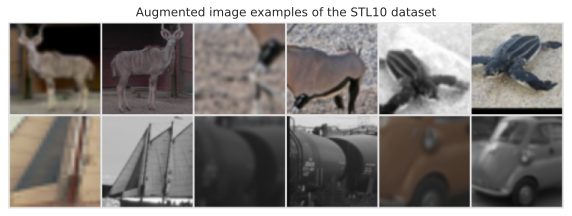

In [7]:
# Visualize some examples
pl.seed_everything(42)
NUM_IMAGES = 6
imgs = torch.stack([img for idx in range(NUM_IMAGES) for img in unlabeled_data[idx][0]], dim=0)
img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(10, 5))
plt.title("Augmented image examples of the STL10 dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

We see the wide variety of our data augmentation, including randomly cropping, grayscaling, gaussian blur, and color distortion.
Thus, it remains a challenging task for the model to match two, independently augmented patches of the same image.

### SimCLR implementation

Using the data loader pipeline above, we can now implement SimCLR.
At each iteration, we get for every image $x$ two differently augmented versions, which we refer to as $\tilde{x}_i$ and $\tilde{x}_j$.
Both of these images are encoded into a one-dimensional feature vector, between which we want to maximize similarity which minimizes it to all other images in the batch.
The encoder network is split into two parts: a base encoder network $f(\cdot)$, and a projection head $g(\cdot)$.
The base network is usually a deep CNN as we have seen in e.g. [Tutorial 5](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial5/Inception_ResNet_DenseNet.html) before, and is responsible for extracting a representation vector from the augmented data examples.
In our experiments, we will use the common ResNet-18 architecture as $f(\cdot)$, and refer to the output as $f(\tilde{x}_i)=h_i$.
The projection head $g(\cdot)$ maps the representation $h$ into a space where we apply the contrastive loss, i.e., compare similarities between vectors.
It is often chosen to be a small MLP with non-linearities, and for simplicity, we follow the original SimCLR paper setup by defining it as a two-layer MLP with ReLU activation in the hidden layer.
Note that in the follow-up paper, [SimCLRv2](https://arxiv.org/abs/2006.10029), the authors mention that larger/wider MLPs can boost the performance considerably.
This is why we apply an MLP with four times larger hidden dimensions, but deeper MLPs showed to overfit on the given dataset.
The general setup is visualized below (figure credit - [Ting Chen et al. ](https://arxiv.org/abs/2006.10029)):

<center width="100%"><img src="https://github.com/Lightning-AI/lightning-tutorials/raw/main/course_UvA-DL/13-contrastive-learning/simclr_network_setup.svg" width="350px"></center>

After finishing the training with contrastive learning, we will remove the projection head $g(\cdot)$, and use $f(\cdot)$ as a pretrained feature extractor.
The representations $z$ that come out of the projection head $g(\cdot)$ have been shown to perform worse than those of the base network $f(\cdot)$ when finetuning the network for a new task.
This is likely because the representations $z$ are trained to become invariant to many features like the color that can be important for downstream tasks.
Thus, $g(\cdot)$ is only needed for the contrastive learning stage.

Now that the architecture is described, let's take a closer look at how we train the model.
As mentioned before, we want to maximize the similarity between the representations of the two augmented versions of the same image, i.e., $z_i$ and $z_j$ in the figure above, while minimizing it to all other examples in the batch.
SimCLR thereby applies the InfoNCE loss, originally proposed by [Aaron van den Oord et al. ](https://arxiv.org/abs/1807.03748) for contrastive learning.
In short, the InfoNCE loss compares the similarity of $z_i$ and $z_j$ to the similarity of $z_i$ to any other representation in the batch by performing a softmax over the similarity values.
The loss can be formally written as:
$$
\ell_{i,j}=-\log \frac{\exp(\text{sim}(z_i,z_j)/\tau)}{\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i,z_k)/\tau)}=-\text{sim}(z_i,z_j)/\tau+\log\left[\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i,z_k)/\tau)\right]
$$
The function $\text{sim}$ is a similarity metric, and the hyperparameter $\tau$ is called temperature determining how peaked the distribution is.
Since many similarity metrics are bounded, the temperature parameter allows us to balance the influence of many dissimilar image patches versus one similar patch.
The similarity metric that is used in SimCLR is cosine similarity, as defined below:
$$
\text{sim}(z_i,z_j) = \frac{z_i^\top \cdot z_j}{||z_i||\cdot||z_j||}
$$
The maximum cosine similarity possible is $1$, while the minimum is $-1$.
In general, we will see that the features of two different images will converge to a cosine similarity around zero since the minimum, $-1$, would require $z_i$ and $z_j$ to be in the exact opposite direction in all feature dimensions, which does not allow for great flexibility.

Finally, now that we have discussed all details, let's implement SimCLR below as a PyTorch Lightning module:

In [8]:
class SimCLR(pl.LightningModule):
    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, "The temperature must be a positive float!"
        # Base model f(.)
        self.convnet = torchvision.models.resnet18(
            pretrained=False, num_classes=4 * hidden_dim
        )  # num_classes is the output size of the last linear layer
        # The MLP for g(.) consists of Linear->ReLU->Linear
        self.convnet.fc = nn.Sequential(
            self.convnet.fc,  # Linear(ResNet output, 4*hidden_dim)
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, hidden_dim),
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.hparams.max_epochs, eta_min=self.hparams.lr / 50
        )
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode="train"):
        imgs, _ = batch
        imgs = torch.cat(imgs, dim=0)

        # Encode all images
        feats = self.convnet(imgs)
        # Calculate cosine similarity
        cos_sim = F.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        self.log(mode + "_loss", nll)
        # Get ranking position of positive example
        comb_sim = torch.cat(
            [cos_sim[pos_mask][:, None], cos_sim.masked_fill(pos_mask, -9e15)],  # First position positive example
            dim=-1,
        )
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        self.log(mode + "_acc_top1", (sim_argsort == 0).float().mean())
        self.log(mode + "_acc_top5", (sim_argsort < 5).float().mean())
        self.log(mode + "_acc_mean_pos", 1 + sim_argsort.float().mean())

        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode="train")

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode="val")

Alternatively to performing the validation on the contrastive learning loss as well, we could also take a simple, small downstream task, and track the performance of the base network $f(\cdot)$ on that.
However, in this tutorial, we will restrict ourselves to the STL10
dataset where we use the task of image classification on STL10 as our
test task.

### Training

Now that we have implemented SimCLR and the data loading pipeline, we are ready to train the model.
We will use the same training function setup as usual.
For saving the best model checkpoint, we track the metric `val_acc_top5`, which describes how often the correct image patch is within the top-5 most similar examples in the batch.
This is usually less noisy than the top-1 metric, making it a better metric to choose the best model from.

In [9]:
def train_simclr(batch_size, max_epochs=500, **kwargs):
    trainer = pl.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, "SimCLR"),
        accelerator="auto",
        devices=1,
        max_epochs=max_epochs,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc_top5"),
            LearningRateMonitor("epoch"),
        ],
    )
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "SimCLR.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        # Automatically loads the model with the saved hyperparameters
        model = SimCLR.load_from_checkpoint(pretrained_filename)
    else:
        train_loader = data.DataLoader(
            unlabeled_data,
            batch_size=batch_size,
            shuffle=True,
            drop_last=True,
            pin_memory=True,
            num_workers=NUM_WORKERS,
        )
        val_loader = data.DataLoader(
            train_data_contrast,
            batch_size=batch_size,
            shuffle=False,
            drop_last=False,
            pin_memory=True,
            num_workers=NUM_WORKERS,
        )
        pl.seed_everything(42)  # To be reproducible
        model = SimCLR(max_epochs=max_epochs, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        # Load best checkpoint after training
        model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    return model

A common observation in contrastive learning is that the larger the batch size, the better the models perform.
A larger batch size allows us to compare each image to more negative examples, leading to overall smoother loss gradients.
However, in our case, we experienced that a batch size of 256 was sufficient to get good results.

In [10]:
simclr_model = train_simclr(
    batch_size=256, hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4, max_epochs=500
)

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


/usr/local/lib/python3.10/dist-packages/lightning_fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Found pretrained model at saved_models/ContrastiveLearning/SimCLR.ckpt, loading...


Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint saved_models/ContrastiveLearning/SimCLR.ckpt`


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


To get an intuition of how training with contrastive learning behaves, we can take a look at the TensorBoard below:

In [11]:
%tensorboard --logdir ../saved_models/tutorial17/tensorboards/SimCLR/

<center width="100%"> 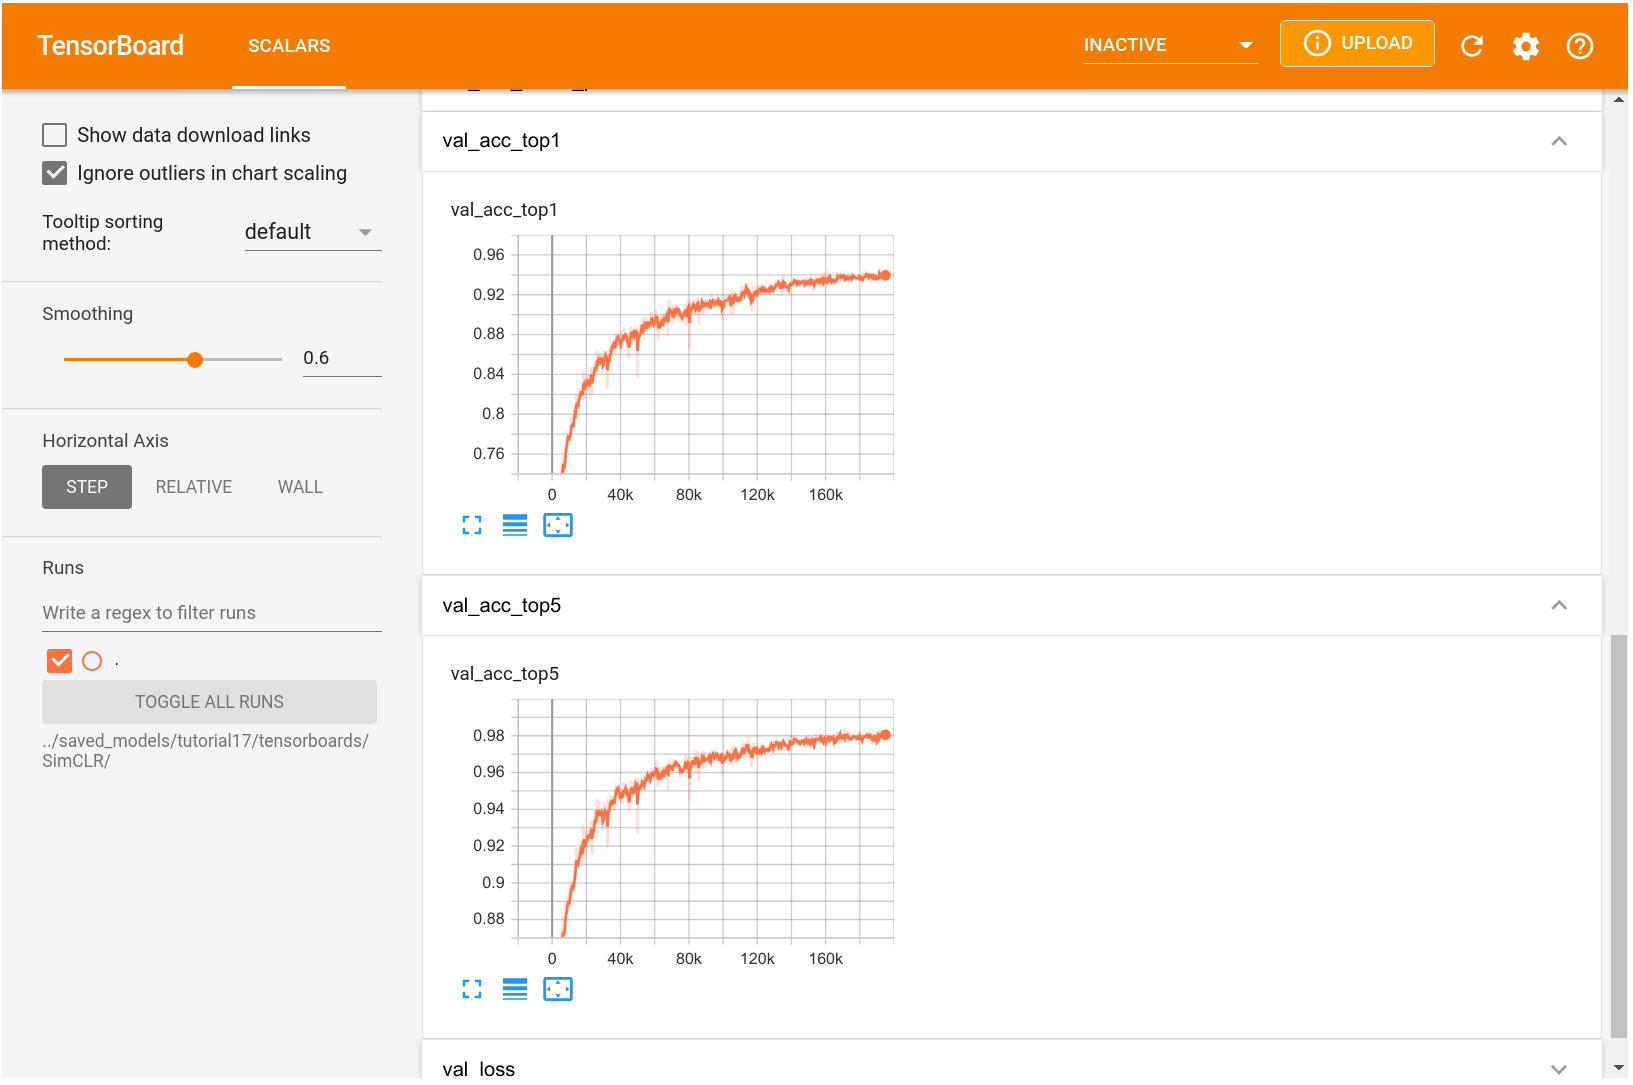{width="1200px"} </center>

One thing to note is that contrastive learning benefits a lot from long training.
The shown plot above is from a training that took approx.
1 day on a NVIDIA TitanRTX.
Training the model for even longer might reduce its loss further, but we did not experience any gains from it for the downstream task on image classification.
In general, contrastive learning can also benefit from using larger models, if sufficient unlabeled data is available.

## Logistic Regression

<div class="center-wrapper"><div class="video-wrapper"><iframe src="https://www.youtube.com/embed/o3FktysLLd4" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe></div></div>
After we have trained our model via contrastive learning, we can deploy it on downstream tasks and see how well it performs with little data.
A common setup, which also verifies whether the model has learned generalized representations, is to perform Logistic Regression on the features.
In other words, we learn a single, linear layer that maps the representations to a class prediction.
Since the base network $f(\cdot)$ is not changed during the training process, the model can only perform well if the representations of $h$ describe all features that might be necessary for the task.
Further, we do not have to worry too much about overfitting since we have very few parameters that are trained.
Hence, we might expect that the model can perform well even with very little data.

First, let's implement a simple Logistic Regression setup for which we assume that the images already have been encoded in their feature vectors.
If very little data is available, it might be beneficial to dynamically encode the images during training so that we can also apply data augmentations.
However, the way we implement it here is much more efficient and can be trained within a few seconds.
Further, using data augmentations did not show any significant gain in this simple setup.

In [12]:
class LogisticRegression(pl.LightningModule):
    def __init__(self, feature_dim, num_classes, lr, weight_decay, max_epochs=100):
        super().__init__()
        self.save_hyperparameters()
        # Mapping from representation h to classes
        self.model = nn.Linear(feature_dim, num_classes)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=[int(self.hparams.max_epochs * 0.6), int(self.hparams.max_epochs * 0.8)], gamma=0.1
        )
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode="train"):
        feats, labels = batch
        preds = self.model(feats)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(mode + "_loss", loss)
        self.log(mode + "_acc", acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode="train")

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="test")

The data we use is the training and test set of STL10.
The training contains 500 images per class, while the test set has 800 images per class.

In [13]:
img_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_img_data = STL10(root=DATASET_PATH, split="train", download=True, transform=img_transforms)
test_img_data = STL10(root=DATASET_PATH, split="test", download=True, transform=img_transforms)

print("Number of training examples:", len(train_img_data))
print("Number of test examples:", len(test_img_data))

Files already downloaded and verified


Files already downloaded and verified
Number of training examples: 5000
Number of test examples: 8000


Next, we implement a small function to encode all images in our datasets.
The output representations are then used as inputs to the Logistic Regression model.

In [14]:
@torch.no_grad()
def prepare_data_features(model, dataset):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    data_loader = data.DataLoader(dataset, batch_size=64, num_workers=NUM_WORKERS, shuffle=False, drop_last=False)
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(data_loader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)

    # Sort images by labels
    labels, idxs = labels.sort()
    feats = feats[idxs]

    return data.TensorDataset(feats, labels)

Let's apply the function to both training and test set below.

In [15]:
train_feats_simclr = prepare_data_features(simclr_model, train_img_data)
test_feats_simclr = prepare_data_features(simclr_model, test_img_data)

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Finally, we can write a training function as usual.
We evaluate the model on the test set every 10 epochs to allow early
stopping, but the low frequency of the validation ensures that we do not
overfit too much on the test set.

In [16]:
def train_logreg(batch_size, train_feats_data, test_feats_data, model_suffix, max_epochs=100, **kwargs):
    trainer = pl.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, "LogisticRegression"),
        accelerator="auto",
        devices=1,
        max_epochs=max_epochs,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
            LearningRateMonitor("epoch"),
        ],
        enable_progress_bar=False,
        check_val_every_n_epoch=10,
    )
    trainer.logger._default_hp_metric = None

    # Data loaders
    train_loader = data.DataLoader(
        train_feats_data, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0
    )
    test_loader = data.DataLoader(
        test_feats_data, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0
    )

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"LogisticRegression_{model_suffix}.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = LogisticRegression.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)  # To be reproducible
        model = LogisticRegression(**kwargs)
        trainer.fit(model, train_loader, test_loader)
        model = LogisticRegression.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on train and validation set
    train_result = trainer.test(model, dataloaders=train_loader, verbose=False)
    test_result = trainer.test(model, dataloaders=test_loader, verbose=False)
    result = {"train": train_result[0]["test_acc"], "test": test_result[0]["test_acc"]}

    return model, result

Despite the training dataset of STL10 already only having 500 labeled images per class, we will perform experiments with even smaller datasets.
Specifically, we train a Logistic Regression model for datasets with only 10, 20, 50, 100, 200, and all 500 examples per class.
This gives us an intuition on how well the representations learned by contrastive learning can be transferred to a image recognition task like this classification.
First, let's define a function to create the intended sub-datasets from the full training set:

In [17]:
def get_smaller_dataset(original_dataset, num_imgs_per_label):
    new_dataset = data.TensorDataset(
        *(t.unflatten(0, (10, 500))[:, :num_imgs_per_label].flatten(0, 1) for t in original_dataset.tensors)
    )
    return new_dataset

Next, let's run all models.
Despite us training 6 models, this cell could be run within a minute or two without the pretrained models.

In [18]:
results = {}
for num_imgs_per_label in [10, 20, 50, 100, 200, 500]:
    sub_train_set = get_smaller_dataset(train_feats_simclr, num_imgs_per_label)
    _, small_set_results = train_logreg(
        batch_size=64,
        train_feats_data=sub_train_set,
        test_feats_data=test_feats_simclr,
        model_suffix=num_imgs_per_label,
        feature_dim=train_feats_simclr.tensors[0].shape[1],
        num_classes=10,
        lr=1e-3,
        weight_decay=1e-3,
    )
    results[num_imgs_per_label] = small_set_results

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


/usr/local/lib/python3.10/dist-packages/lightning_fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
Lightning automatically upgraded your loaded checkpoint from 

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Missing logger folder: saved_models/ContrastiveLearning/LogisticRegression/lightning_logs


Found pretrained model at saved_models/ContrastiveLearning/LogisticRegression_10.ckpt, loading...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint saved_models/ContrastiveLearning/LogisticRegression_20.ckpt`


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Found pretrained model at saved_models/ContrastiveLearning/LogisticRegression_20.ckpt, loading...


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint saved_models/ContrastiveLearning/LogisticRegression_50.ckpt`


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


Found pretrained model at saved_models/ContrastiveLearning/LogisticRegression_50.ckpt, loading...
Found pretrained model at saved_models/ContrastiveLearning/LogisticRegression_100.ckpt, loading...


Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint saved_models/ContrastiveLearning/LogisticRegression_100.ckpt`


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint saved_models/ContrastiveLearning/LogisticRegression_200.ckpt`


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Found pretrained model at saved_models/ContrastiveLearning/LogisticRegression_200.ckpt, loading...


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint saved_models/ContrastiveLearning/LogisticRegression_500.ckpt`


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Found pretrained model at saved_models/ContrastiveLearning/LogisticRegression_500.ckpt, loading...


Finally, let's plot the results.

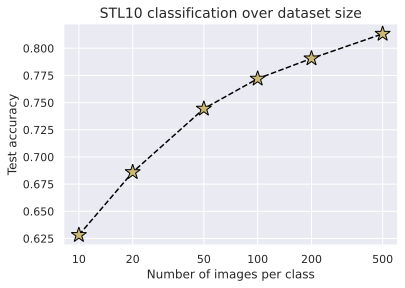

Test accuracy for  10 images per label: 62.81%
Test accuracy for  20 images per label: 68.60%
Test accuracy for  50 images per label: 74.44%
Test accuracy for 100 images per label: 77.20%
Test accuracy for 200 images per label: 79.06%
Test accuracy for 500 images per label: 81.33%


In [19]:
dataset_sizes = sorted(k for k in results)
test_scores = [results[k]["test"] for k in dataset_sizes]

fig = plt.figure(figsize=(6, 4))
plt.plot(
    dataset_sizes,
    test_scores,
    "--",
    color="#000",
    marker="*",
    markeredgecolor="#000",
    markerfacecolor="y",
    markersize=16,
)
plt.xscale("log")
plt.xticks(dataset_sizes, labels=dataset_sizes)
plt.title("STL10 classification over dataset size", fontsize=14)
plt.xlabel("Number of images per class")
plt.ylabel("Test accuracy")
plt.minorticks_off()
plt.show()

for k, score in zip(dataset_sizes, test_scores):
    print(f"Test accuracy for {k:3d} images per label: {100*score:4.2f}%")

As one would expect, the classification performance improves the more data we have.
However, with only 10 images per class, we can already classify more than 60% of the images correctly.
This is quite impressive, considering that the images are also higher dimensional than e.g. CIFAR10.
With the full dataset, we achieve an accuracy of 81%.
The increase between 50 to 500 images per class might suggest a linear increase in performance with an exponentially larger dataset.
However, with even more data, we could also finetune $f(\cdot)$ in the training process, allowing for the representations to adapt more to the specific classification task given.

To set the results above into perspective, we will train the base
network, a ResNet-18, on the classification task from scratch.

## Baseline

As a baseline to our results above, we will train a standard ResNet-18 with random initialization on the labeled training set of STL10.
The results will give us an indication of the advantages that contrastive learning on unlabeled data has compared to using only supervised training.
The implementation of the model is straightforward since the ResNet
architecture is provided in the torchvision library.

In [20]:
class ResNet(pl.LightningModule):
    def __init__(self, num_classes, lr, weight_decay, max_epochs=100):
        super().__init__()
        self.save_hyperparameters()
        self.model = torchvision.models.resnet18(pretrained=False, num_classes=num_classes)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=[int(self.hparams.max_epochs * 0.7), int(self.hparams.max_epochs * 0.9)], gamma=0.1
        )
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode="train"):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(mode + "_loss", loss)
        self.log(mode + "_acc", acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode="train")

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="test")

It is clear that the ResNet easily overfits on the training data since its parameter count is more than 1000 times larger than the dataset size.
To make the comparison to the contrastive learning models fair, we apply data augmentations similar to the ones we used before: horizontal flip, crop-and-resize, grayscale, and gaussian blur.
Color distortions as before are not used because the color distribution of an image showed to be an important feature for the classification.
Hence, we observed no noticeable performance gains when adding color distortions to the set of augmentations.
Similarly, we restrict the resizing operation before cropping to the max.
125% of its original resolution, instead of 1250% as done in SimCLR.
This is because, for classification, the model needs to recognize the full object, while in contrastive learning, we only want to check whether two patches belong to the same image/object.
Hence, the chosen augmentations below are overall weaker than in the contrastive learning case.

In [21]:
train_transforms = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(size=96, scale=(0.8, 1.0)),
        transforms.RandomGrayscale(p=0.2),
        transforms.GaussianBlur(kernel_size=9, sigma=(0.1, 0.5)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

train_img_aug_data = STL10(root=DATASET_PATH, split="train", download=True, transform=train_transforms)

Files already downloaded and verified


The training function for the ResNet is almost identical to the Logistic Regression setup.
Note that we allow the ResNet to perform validation every 2 epochs to
also check whether the model overfits strongly in the first iterations
or not.

In [22]:
def train_resnet(batch_size, max_epochs=100, **kwargs):
    trainer = pl.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, "ResNet"),
        accelerator="auto",
        devices=1,
        max_epochs=max_epochs,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
            LearningRateMonitor("epoch"),
        ],
        check_val_every_n_epoch=2,
    )
    trainer.logger._default_hp_metric = None

    # Data loaders
    train_loader = data.DataLoader(
        train_img_aug_data,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        pin_memory=True,
        num_workers=NUM_WORKERS,
    )
    test_loader = data.DataLoader(
        test_img_data, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=NUM_WORKERS
    )

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "ResNet.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = ResNet.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)  # To be reproducible
        model = ResNet(**kwargs)
        trainer.fit(model, train_loader, test_loader)
        model = ResNet.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on validation set
    train_result = trainer.test(model, dataloaders=train_loader, verbose=False)
    val_result = trainer.test(model, dataloaders=test_loader, verbose=False)
    result = {"train": train_result[0]["test_acc"], "test": val_result[0]["test_acc"]}

    return model, result

Finally, let's train the model and check its results:

In [23]:
resnet_model, resnet_result = train_resnet(batch_size=64, num_classes=10, lr=1e-3, weight_decay=2e-4, max_epochs=100)
print(f"Accuracy on training set: {100*resnet_result['train']:4.2f}%")
print(f"Accuracy on test set: {100*resnet_result['test']:4.2f}%")

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


/usr/local/lib/python3.10/dist-packages/lightning_fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
Lightning automatically upgraded your loaded checkpoint from 

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Found pretrained model at saved_models/ContrastiveLearning/ResNet.ckpt, loading...


Missing logger folder: saved_models/ContrastiveLearning/ResNet/lightning_logs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

Accuracy on training set: 99.66%
Accuracy on test set: 73.31%


The ResNet trained from scratch achieves 73.31% on the test set.
This is almost 8% less than the contrastive learning model, and even slightly less than SimCLR achieves with 1/10 of the data.
This shows that self-supervised, contrastive learning provides
considerable performance gains by leveraging large amounts of unlabeled
data when little labeled data is available.

## Conclusion

In this tutorial, we have discussed self-supervised contrastive learning and implemented SimCLR as an example method.
We have applied it to the STL10 dataset and showed that it can learn generalizable representations that we can use to train simple classification models.
With 500 images per label, it achieved an 8% higher accuracy than a similar model solely trained from supervision and performs on par with it when only using a tenth of the labeled data.
Our experimental results are limited to a single dataset, but recent works such as [Ting Chen et al. ](https://arxiv.org/abs/2006.10029) showed similar trends for larger datasets like ImageNet.
Besides the discussed hyperparameters, the size of the model seems to be important in contrastive learning as well.
If a lot of unlabeled data is available, larger models can achieve much stronger results and come close to their supervised baselines.
Further, there are also approaches for combining contrastive and supervised learning, leading to performance gains beyond supervision (see [Khosla et al.](https://arxiv.org/abs/2004.11362)).
Moreover, contrastive learning is not the only approach to self-supervised learning that has come up in the last two years and showed great results.
Other methods include distillation-based methods like [BYOL](https://arxiv.org/abs/2006.07733) and redundancy reduction techniques like [Barlow Twins](https://arxiv.org/abs/2103.03230).
There is a lot more to explore in the self-supervised domain, and more, impressive steps ahead are to be expected.

### References

[1] Chen, T., Kornblith, S., Norouzi, M., and Hinton, G. (2020).
A simple framework for contrastive learning of visual representations.
In International conference on machine learning (pp.
1597-1607).
PMLR.
([link](https://arxiv.org/abs/2002.05709))

[2] Chen, T., Kornblith, S., Swersky, K., Norouzi, M., and Hinton, G. (2020).
Big self-supervised models are strong semi-supervised learners.
NeurIPS 2021 ([link](https://arxiv.org/abs/2006.10029)).

[3] Oord, A. V. D., Li, Y., and Vinyals, O.
(2018).
Representation learning with contrastive predictive coding.
arXiv preprint arXiv:1807.03748.
([link](https://arxiv.org/abs/1807.03748))

[4] Grill, J.B., Strub, F., Altché, F., Tallec, C., Richemond, P.H., Buchatskaya, E., Doersch, C., Pires, B.A., Guo, Z.D., Azar, M.G.
and Piot, B.
(2020).
Bootstrap your own latent: A new approach to self-supervised learning.
arXiv preprint arXiv:2006.07733.
([link](https://arxiv.org/abs/2006.07733))

[5] Khosla, P., Teterwak, P., Wang, C., Sarna, A., Tian, Y., Isola, P., Maschinot, A., Liu, C. and Krishnan, D. (2020).
Supervised contrastive learning.
arXiv preprint arXiv:2004.11362.
([link](https://arxiv.org/abs/2004.11362))

[6] Zbontar, J., Jing, L., Misra, I., LeCun, Y. and Deny, S. (2021).
Barlow twins: Self-supervised learning via redundancy reduction.
arXiv preprint arXiv:2103.03230.
([link](https://arxiv.org/abs/2103.03230))

## Congratulations - Time to Join the Community!

Congratulations on completing this notebook tutorial! If you enjoyed this and would like to join the Lightning
movement, you can do so in the following ways!

### Star [Lightning](https://github.com/Lightning-AI/lightning) on GitHub
The easiest way to help our community is just by starring the GitHub repos! This helps raise awareness of the cool
tools we're building.

### Join our [Discord](https://discord.com/invite/tfXFetEZxv)!
The best way to keep up to date on the latest advancements is to join our community! Make sure to introduce yourself
and share your interests in `#general` channel


### Contributions !
The best way to contribute to our community is to become a code contributor! At any time you can go to
[Lightning](https://github.com/Lightning-AI/lightning) or [Bolt](https://github.com/Lightning-AI/lightning-bolts)
GitHub Issues page and filter for "good first issue".

* [Lightning good first issue](https://github.com/Lightning-AI/lightning/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* [Bolt good first issue](https://github.com/Lightning-AI/lightning-bolts/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* You can also contribute your own notebooks with useful examples !

### Great thanks from the entire Pytorch Lightning Team for your interest !

[Pytorch Lightning{height="60px" width="240px"}](https://pytorchlightning.ai)